Thanks for:
* https://www.kaggle.com/sishihara/moa-lgbm-benchmark#Preprocessing

* https://www.kaggle.com/ttahara/osic-baseline-lgbm-with-custom-metric

* https://zenn.dev/fkubota/articles/2b8d46b11c178ac2fa2d

* https://qiita.com/ryouta0506/items/619d9ac0d80f8c0aed92

* https://github.com/nejumi/tools_for_kaggle/blob/master/semi_supervised_learner.py

* https://upura.hatenablog.com/entry/2019/03/03/233534


In [1]:
# Version = "v1" # starter model
# Version = "v2" # Compare treat Vs. ctrl and minor modifications, StratifiedKFold
# Version = "v3" # Add debug mode and minor modifications
# Version = "v4" # Clipping a control with an outlier(25-75)
# Version = "v5" # Clipping a control with an outlier(20-80)
# Version = "v6" # under sampling 500 → oversamplling 500, lipping a control with an outlier(10-90)
# Version = "v7" # Use anotated data, under sampling 500 → oversamplling 500, clipping a control with an outlier(10-90)
# Version = "v8" # pasude labeling (thresholds:0.5), timeout
# Version = "v9" # pasude labeling (thresholds:0.6), timeout
# Version = "v10" # pasude labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP
Version = "v11" # pasude labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP, lgbm parames adjust

In [2]:
DEBUG = True

# Library

In [3]:
import lightgbm as lgb
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
import imblearn
from imblearn.over_sampling import SMOTE

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors

from tqdm.notebook import tqdm
import torch

import warnings
warnings.filterwarnings("ignore")

print("lightgbm Version: ", lgb.__version__)
print("numpy Version: ", np.__version__)
print("pandas Version: ", pd.__version__)
print("imblearn Version: ", imblearn.__version__)

lightgbm Version:  2.3.1
numpy Version:  1.18.5
pandas Version:  1.1.1
imblearn Version:  0.7.0


# Utils

In [4]:
def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.{Version}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Config

In [5]:
if DEBUG:
    N_FOLD = 2
    Num_boost_round=1000
    Early_stopping_rounds=10
    Learning_rate = 0.03
else:
    N_FOLD = 4
    Num_boost_round=10000
    Early_stopping_rounds=50
    Learning_rate = 0.01

SEED = 42
seed_everything(seed=SEED)

Threshold = 0.6
Max_depth = 7

# Data Loading

In [6]:
train = pd.read_csv("../input/lish-moa/train_features.csv")
test = pd.read_csv("../input/lish-moa/test_features.csv")
train_targets_scored = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
train_targets_nonscored = pd.read_csv("../input/lish-moa/train_targets_nonscored.csv")
sub = pd.read_csv("../input/lish-moa/sample_submission.csv")

In [7]:
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, encode_cols):
    n_train = len(train)
    train = pd.concat([train, test], sort=False).reset_index(drop=True)
    for f in encode_cols:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    return train, test

In [8]:
annot = pd.read_csv("../input/moa-annot-data/20201016_moa_sig_list.csv")
annot.head()

,sig_id,annot1,annot2,annot3
0,acetylcholine_receptor_agonist,acetylcholine_release_enhancer,NaN,NaN
1,acetylcholine_receptor_antagonist,atherogenesis_inhibitor,NaN,NaN
2,adenosine_receptor_antagonist,adenosine_deaminase_inhibitor,NaN,NaN
3,adenylyl_cyclase_activator,adenylyl_cyclase_inhibitor,NaN,NaN
4,aldehyde_dehydrogenase_inhibitor,alcohol_dehydrogenase_inhibitor,NaN,NaN


In [9]:
annot_sig = annot.sig_id.tolist()
print(annot_sig)

['acetylcholine_receptor_agonist', 'acetylcholine_receptor_antagonist', 'adenosine_receptor_antagonist', 'adenylyl_cyclase_activator', 'aldehyde_dehydrogenase_inhibitor', 'angiotensin_receptor_antagonist', 'anti-inflammatory', 'antiarrhythmic', 'anticonvulsant', 'antifungal', 'antihistamine', 'apoptosis_stimulant', 'atm_kinase_inhibitor', 'atp-sensitive_potassium_channel_antagonist', 'atp_synthase_inhibitor', 'atr_kinase_inhibitor', 'autotaxin_inhibitor', 'bacterial_membrane_integrity_inhibitor', 'bcr-abl_inhibitor', 'calcineurin_inhibitor', 'caspase_activator', 'catechol_o_methyltransferase_inhibitor', 'cdk_inhibitor', 'chk_inhibitor', 'coagulation_factor_inhibitor', 'dopamine_receptor_agonist', 'elastase_inhibitor', 'erbb2_inhibitor', 'free_radical_scavenger', 'fungal_squalene_epoxidase_inhibitor', 'gaba_receptor_agonist', 'gaba_receptor_antagonist', 'glutamate_receptor_agonist', 'histamine_receptor_antagonist', 'histone_lysine_demethylase_inhibitor', 'hiv_inhibitor', 'imidazoline_re

In [10]:
train_target = pd.concat([train_targets_scored, train_targets_nonscored], axis=1)
train_target.head() 

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Training Utils

In [11]:
def get_target(target_col, annot_sig):
    if target_col in annot_sig:
        t_cols = []
        for t_col in list(annot[annot.sig_id == target_col].iloc[0]):
            if t_col is not np.nan:
                t_cols.append(t_col)
                target = train_target[t_cols]
                target = target.sum(axis=1)
                #1以上であれば1に置換
                target = target.where(target < 1, 1)
    else:
        target = train_targets_scored[target_col]
    
    return target

In [12]:
#===========================================================
# model
#===========================================================
def run_lgbm(target_col: str, Threshold):
    target = get_target(target_col, annot_sig)
    trt = train[target==1].copy().reset_index(drop=True)
    trt["target"] = 1
    trt = trt.drop("sig_id", axis=1)
    n_target = max(500,len(trt))
    
    logger.info(f"{target_col} , len(trt) : {len(trt)}")
        
    othr = train[target==0].copy().reset_index(drop=True)
    othr = othr.drop("sig_id", axis=1)
    othr = othr.sample(n=n_target, random_state=42)
    othr["target"] = 0
    
    X_train = pd.concat([trt, othr], axis=0, sort=False, ignore_index=True)
    X_train = X_train.replace([np.inf, -np.inf], np.nan)
    X_train = X_train.fillna(0)
    
    y_train = X_train["target"]
    X_train = X_train.drop("target", axis=1)


    if len(trt) < n_target:
        sm = SMOTE(random_state=42)
        X_train, y_train = sm.fit_sample(X_train, y_train)
    
    X_test = test.drop("sig_id", axis=1)
    
    train_X, train_y = pseudo_labeling(X_train, y_train, X_test, threshold=Threshold)
    
    y_preds = []
    models = []
    oof_train = np.zeros((len(train_X),))
    score = 0
    
    
    for fold_, (train_index, valid_index) in enumerate(cv.split(train_X, train_y)):
        logger.info(f'len(train_index) : {len(train_index)}')
        logger.info(f'len(valid_index) : {len(valid_index)}')
        
        X_tr = train_X.loc[train_index, :]
        X_val = train_X.loc[valid_index, :]
        y_tr = train_y[train_index]
        y_val = train_y[valid_index]

        lgb_train = lgb.Dataset(X_tr,
                                y_tr,
                                categorical_feature=categorical_cols)

        lgb_eval = lgb.Dataset(X_val,
                               y_val,
                               reference=lgb_train,
                               categorical_feature=categorical_cols)
        
        logger.info(f"================================= fold {fold_+1}/{cv.get_n_splits()} {target_col}=================================")
        
        
        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=100,
                          num_boost_round=Num_boost_round,
                          early_stopping_rounds=Early_stopping_rounds)
        
        oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)


        y_pred = model.predict(X_test, num_iteration=model.best_iteration)

        y_preds.append(y_pred)
        models.append(model)
    
    score = log_loss(train_y, oof_train)
    
    logger.info(f"{target_col} logloss: {score}")
    logger.info(f"=========================================================================================")

    return sum(y_preds) / len(y_preds), score, models, 

In [13]:
def pseudo_labeling(X_train, y_train, X_test, max_iter=3, threshold=0.5):
       
    X = X_train.copy()
    y = y_train.copy()
    
    for iter_ in range(1, max_iter+1):
    
        logger.info(f"================= Pseudo labeling {iter_} / {max_iter} =================")
        
        y_preds = []
        for fold_, (train_index, valid_index) in enumerate(cv.split(X, y)):        
            X_tr, X_val = X.loc[train_index, :], X.loc[valid_index, :]
            y_tr, y_val = y[train_index], y[valid_index]
 
            lgb_train = lgb.Dataset(X_tr, y_tr, categorical_feature=categorical_cols)
            lgb_eval = lgb.Dataset(X_val,y_val,reference=lgb_train,categorical_feature=categorical_cols)
        
            model = lgb.train(params,
                              lgb_train,
                              valid_sets=[lgb_train, lgb_eval],
                              verbose_eval=100,
                              num_boost_round=Num_boost_round,
                              early_stopping_rounds=Early_stopping_rounds)
        
            y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            y_preds.append(y_pred)
            
        p_label = pd.Series(sum(y_preds) / len(y_preds))
        p_label = p_label.where(p_label < threshold, 1)
        p_label = p_label.where(p_label >= threshold, 0)
 
        X = pd.concat([X_train, X_test], axis=0, ignore_index=True)
        y = pd.concat([y_train, p_label], axis=0, ignore_index=True)
        
    return X, y

In [14]:
def show_feature_importance(feature_importance_df, num=100):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

    plt.figure(figsize=(8, 30))
    sns.barplot(x="importance", 
                y="Feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Features importance (averaged)')
    plt.tight_layout()
    plt.savefig(f"./feature_importance_{Version}.png")
    plt.show()

# Preprocessing

We have to convert some categorical features into numbers in train and test. We can identify categorical features by `pd.DataFrame.select_dtypes`.

In [15]:
train.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [16]:
train.select_dtypes(include=['object']).columns

Index(['sig_id', 'cp_type', 'cp_dose'], dtype='object')

In [17]:
train, test = label_encoding(train, test, ['cp_type', 'cp_time', 'cp_dose'])

In [18]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,train
1,id_000779bfc,1,2,0,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,train
2,id_000a6266a,1,1,0,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,train
3,id_0015fd391,1,1,0,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,train
4,id_001626bd3,1,2,1,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_ff7004b87,1,0,0,0.4571,-0.5743,3.3930,-0.6202,0.8557,1.6240,...,-0.6422,-0.4367,0.0159,-0.6539,-0.4791,-1.2680,-1.1280,-0.4167,-0.6600,test
27792,id_ff925dd0d,1,0,0,-0.5885,-0.2548,2.5850,0.3456,0.4401,0.3107,...,0.5780,-0.5888,0.8057,0.9312,1.2730,0.2614,-0.2790,-0.0131,-0.0934,test
27793,id_ffb710450,1,2,0,-0.3985,-0.1554,0.2677,-0.6813,0.0152,0.4791,...,0.9153,-0.1862,0.4049,0.9568,0.4666,0.0461,0.5888,-0.4205,-0.1504,test
27794,id_ffbb869f2,1,1,1,-1.0960,-1.7750,-0.3977,1.0160,-1.3350,-0.2207,...,-0.4473,-0.8192,0.7785,0.3133,0.1286,-0.2618,0.5074,0.7430,-0.0484,test


In [19]:
# Select control data
ctl = train[(train.cp_type==0)]
ctl

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
25,id_0054388ec,0,1,0,-0.6696,-0.2718,-1.2230,-0.6226,-0.7220,0.1588,...,0.6405,0.5429,0.3562,1.3290,0.5573,0.8837,0.5534,0.8976,1.0050,train
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-0.6828,-0.6594,-0.2043,0.3571,-0.1319,0.2187,0.0737,0.6498,-1.4820,train
40,id_007bfbb91,0,0,1,-1.3200,-1.7340,-0.0741,1.5440,-1.8290,-0.0951,...,1.0340,0.7393,1.1020,0.3786,0.2636,-0.5751,0.3362,0.8543,0.9180,train
47,id_008a986b7,0,1,1,0.4860,0.1430,0.5281,-0.0022,-0.2334,-0.6607,...,-0.1866,0.7629,0.3288,-0.9915,-0.3694,-0.4979,0.5281,-0.9245,-0.9367,train
63,id_009d8340f,0,0,1,0.4471,-0.0839,-0.3864,0.3196,0.2584,-0.3156,...,0.3939,0.7665,0.7932,-0.6804,-0.0435,0.0949,0.2000,-0.4326,0.9364,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23729,id_ff1f9e5fc,0,0,0,0.0465,0.6430,-0.2453,0.3521,0.6195,-0.6659,...,0.1621,-0.2065,0.8314,-0.1891,-0.0074,0.2131,-0.1419,-0.2422,0.0457,train
23747,id_ff469c482,0,2,0,-0.6204,-1.3800,-1.1880,-0.6573,-0.8408,-0.2447,...,0.7366,0.5468,1.1450,0.5254,0.6224,-0.9630,0.8872,-0.0742,-0.6777,train
23768,id_ff89331ca,0,2,1,-0.1051,0.4335,0.3648,-0.0525,-0.3632,-0.3228,...,0.4885,0.4963,0.9434,-0.4779,0.6951,0.9517,-0.8110,-0.1748,-0.3626,train
23793,id_ffd26f361,0,1,1,0.6008,0.2781,-0.3319,-0.8782,0.9281,0.7535,...,0.9569,-0.2065,-0.4918,0.7863,0.0504,0.8813,0.7757,-0.5272,0.7082,train


In [20]:
# clipping

def outlaier_clip(df):
    df = df.copy()
    clipping = df.columns[4:6]
    for col in clipping:
        lower, upper= np.percentile(df[col], [10, 90])
        df[col] = np.clip(df[col], lower, upper)
    
    return df

ctl_df = pd.DataFrame(columns=train.columns)
for i in ctl.cp_time.unique():
    for j in ctl.cp_dose.unique():
        print(len(ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]))
        tmp_ctl = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]
        tmp_ctl = outlaier_clip(tmp_ctl)
        ctl_df = pd.concat([ctl_df, tmp_ctl], axis=0).reset_index(drop=True)
ctl_df

343
305
301
305
307
305


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
0,id_0054388ec,0,1,0,-0.6696,-0.27180,-1.2230,-0.6226,-0.7220,0.1588,...,0.6405,0.5429,0.3562,1.3290,0.5573,0.8837,0.5534,0.8976,1.0050,train
1,id_01b05de6c,0,1,0,-0.3176,0.48512,-0.3773,0.5555,-0.4877,0.3413,...,-0.6163,0.8001,0.3389,0.7437,0.7533,0.2406,0.5057,0.8017,1.0280,train
2,id_020ba48d9,0,1,0,0.8094,-0.33390,1.1130,-0.4192,0.4545,-0.4771,...,-0.4414,-0.2442,0.0557,-0.6597,-0.3713,-0.6929,-0.3258,0.3602,-0.0595,train
3,id_02c93b4a5,0,1,0,-0.0884,-1.54100,0.5562,0.4661,-0.1683,0.9515,...,0.4766,0.9697,0.4613,0.8957,0.8227,1.2300,1.7180,0.6542,0.0580,train
4,id_03bc6d412,0,1,0,0.8431,0.09310,-0.0958,-0.4337,1.0690,-0.6440,...,-1.1510,-0.5010,-0.2736,0.1270,0.3511,0.1233,-0.8520,0.1767,0.1153,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1861,id_fbb620181,0,2,1,-0.3490,0.72970,-4.1480,-1.0030,2.4070,-0.9784,...,-1.4260,-0.8613,-0.0243,-0.6109,0.6377,-1.2590,-0.7238,-0.7734,-0.1274,train
1862,id_fbba92030,0,2,1,-0.8921,1.13520,0.4227,1.3270,-0.9839,-0.8469,...,1.1340,0.7007,1.3320,0.6622,0.6167,0.9459,-0.0344,-0.0186,0.5173,train
1863,id_fbc0849ad,0,2,1,-0.2948,0.21960,-0.3252,-0.2084,-0.6518,0.3542,...,0.5014,0.6009,0.4560,-0.3360,-0.5091,0.6569,0.6203,0.6764,0.4504,train
1864,id_fd93fa37d,0,2,1,-0.2984,-0.47880,-2.3560,-0.6848,1.8700,1.0240,...,-0.4422,-0.6665,-0.8033,-1.0520,0.4103,0.4462,-1.1580,-1.3060,0.1925,train


In [21]:
col_list = list(data.columns)[:-1]
data_df = pd.DataFrame(columns=col_list)
Splitdata = []
d = 1e-6

for i in data.cp_time.unique():
    for j in data.cp_dose.unique():
        select = data[(data.cp_time==i) & (data.cp_dose==j)]
        print(len(select))
        
        for k in list(select['WHERE']):
                      Splitdata.append(k)
        
        select = select.drop(columns='WHERE')
        med = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)].iloc[:, 4:].median()
        f_div = lambda x: (x+d) / (abs(med)+d)
        select_d = select.iloc[:,4:].apply(f_div, axis=1).add_prefix('d_')
        tmp_data = pd.concat([select,select_d], axis=1, sort=False)
        data_df = pd.concat([data_df, tmp_data], axis=0)
data_df

4534
4538
4561
4536
5079
4548


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [22]:
# clipping
clipping = data_df.columns[4:]
for col in clipping:
    lower, upper = np.percentile(data_df[col], [1, 99])
    data_df[col] = np.clip(data_df[col], lower, upper)
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [23]:
data_df.cp_type = data_df.cp_type.astype('int64')
data_df.cp_time = data_df.cp_time.astype('int64')
data_df.cp_dose = data_df.cp_dose.astype('int64')
data_df.dtypes

sig_id      object
cp_type      int64
cp_time      int64
cp_dose      int64
g-0        float64
            ...   
d_c-95     float64
d_c-96     float64
d_c-97     float64
d_c-98     float64
d_c-99     float64
Length: 1748, dtype: object

In [24]:
data_df = data_df.replace([np.inf, -np.inf], np.nan)
data_df = data_df.dropna(how='any', axis=1)
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [25]:
data_df['WHERE'] = Splitdata
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99,WHERE
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303,train
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866,train
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032,train
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519,train
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843,test
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932,test
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938,test
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391,test


In [26]:
train = data_df[data_df['WHERE']=="train"].drop('WHERE', axis=1)
test = data_df[data_df['WHERE']=="test"].drop('WHERE', axis=1)

In [27]:
# Kolmogorov-Smirnov test applied for train data and test data.

from scipy.stats import ks_2samp

tr = train.iloc[:, 4:]
ts = test.iloc[:, 4:]

list_p_value =[ks_2samp(ts[i], tr[i])[1] for i in tqdm(tr.columns)]
Se = pd.Series(list_p_value, index=tr.columns).sort_values() 
list_discarded = list(Se[Se < .1].index)

train = train.drop(list_discarded, axis=1)
test = test.drop(list_discarded, axis=1)

print(f"Removed {len(list_discarded)} columns")


Removed 408 columns


In [28]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

,sig_id,cp_type,cp_time,cp_dose,g-1,g-2,g-4,g-5,g-6,g-8,...,d_c-87,d_c-89,d_c-90,d_c-91,d_c-92,d_c-94,d_c-95,d_c-97,d_c-99,WHERE
0,id_000644bb2,1,0,0,0.5577,-0.2479,-0.1944,-1.0120,-1.0220,0.5548,...,-0.458706,3.210844,0.900850,0.827675,4.339584,-0.411268,1.931922,0.630788,1.125303,train
1,id_001762a82,1,0,0,0.2941,-0.9901,1.2810,0.5203,0.0543,-0.1586,...,4.198996,7.411112,5.788465,3.705949,-5.437902,3.069473,1.325997,1.110292,3.769866,train
2,id_00762e877,1,0,0,0.1662,-0.6307,-0.5992,-0.2523,-1.3770,-1.4880,...,2.130879,2.780971,-2.000935,-0.524979,-0.457811,0.017855,2.201874,2.479205,1.298032,train
3,id_0079af0fb,0,0,0,-1.8230,-0.5211,-1.1280,0.6041,0.3856,-0.5400,...,0.036750,2.267525,-1.221271,-2.187049,-3.543232,0.768123,-0.387026,0.217342,-3.993519,train
4,id_0079d45d3,1,0,0,-2.1430,-0.0943,0.4869,-0.0935,1.2090,-1.5450,...,-18.897523,-9.183429,-9.203619,-18.488086,-10.402948,-5.953954,-7.288708,-6.644035,-1.741033,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,-0.0461,-0.9751,-0.1861,0.3608,0.5174,0.9298,...,10.394855,-23.040415,3.364808,-2.944165,4.362395,-0.200288,3.648613,-1.381859,-2.753843,test
27792,id_fce497048,1,1,1,-0.3274,-0.0099,0.6673,-1.5380,-0.5368,2.1020,...,-53.796375,-33.477371,-6.666625,-2.994822,-108.965314,-19.418785,-5.186308,-3.400727,-6.611932,test
27793,id_fd75349b2,1,1,1,0.4437,-0.1530,-0.5804,0.0633,0.6952,-0.1058,...,110.075643,53.955575,1.461452,1.221387,-12.977688,-1.481351,-3.441418,1.214694,-2.167938,test
27794,id_fed0f2fe0,1,1,1,0.7350,0.3304,0.1435,-1.6810,-1.1370,-0.4083,...,-26.830434,-50.825426,-5.310498,-2.757956,9.262242,-2.189681,-6.566071,-3.150643,-5.960391,test


In [29]:
Splitdata = data["WHERE"]
data = data.drop('WHERE', axis=1)
data

,sig_id,cp_type,cp_time,cp_dose,g-1,g-2,g-4,g-5,g-6,g-8,...,d_c-85,d_c-87,d_c-89,d_c-90,d_c-91,d_c-92,d_c-94,d_c-95,d_c-97,d_c-99
0,id_000644bb2,1,0,0,0.5577,-0.2479,-0.1944,-1.0120,-1.0220,0.5548,...,0.610453,-0.458706,3.210844,0.900850,0.827675,4.339584,-0.411268,1.931922,0.630788,1.125303
1,id_001762a82,1,0,0,0.2941,-0.9901,1.2810,0.5203,0.0543,-0.1586,...,2.368506,4.198996,7.411112,5.788465,3.705949,-5.437902,3.069473,1.325997,1.110292,3.769866
2,id_00762e877,1,0,0,0.1662,-0.6307,-0.5992,-0.2523,-1.3770,-1.4880,...,-2.098055,2.130879,2.780971,-2.000935,-0.524979,-0.457811,0.017855,2.201874,2.479205,1.298032
3,id_0079af0fb,0,0,0,-1.8230,-0.5211,-1.1280,0.6041,0.3856,-0.5400,...,0.927045,0.036750,2.267525,-1.221271,-2.187049,-3.543232,0.768123,-0.387026,0.217342,-3.993519
4,id_0079d45d3,1,0,0,-2.1430,-0.0943,0.4869,-0.0935,1.2090,-1.5450,...,-12.466870,-18.897523,-9.183429,-9.203619,-18.488086,-10.402948,-5.953954,-7.288708,-6.644035,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,-0.0461,-0.9751,-0.1861,0.3608,0.5174,0.9298,...,0.977743,10.394855,-23.040415,3.364808,-2.944165,4.362395,-0.200288,3.648613,-1.381859,-2.753843
27792,id_fce497048,1,1,1,-0.3274,-0.0099,0.6673,-1.5380,-0.5368,2.1020,...,-3.525817,-53.796375,-33.477371,-6.666625,-2.994822,-108.965314,-19.418785,-5.186308,-3.400727,-6.611932
27793,id_fd75349b2,1,1,1,0.4437,-0.1530,-0.5804,0.0633,0.6952,-0.1058,...,2.350949,110.075643,53.955575,1.461452,1.221387,-12.977688,-1.481351,-3.441418,1.214694,-2.167938
27794,id_fed0f2fe0,1,1,1,0.7350,0.3304,0.1435,-1.6810,-1.1370,-0.4083,...,-6.247984,-26.830434,-50.825426,-5.310498,-2.757956,9.262242,-2.189681,-6.566071,-3.150643,-5.960391


In [30]:
# Based on v8 notebook with feature importance
Feature_importance = [
    "g-104",
    "g-307",
    "g-46",
    "g-219",
    "d_g-104",
    "d_g-307",
    "d_g-46",
    "d_g-216",
    "d_g-219",
    "d_g-153",
]

In [31]:
FI = data[Feature_importance]
FI

,g-104,g-307,g-46,g-219,d_g-104,d_g-307,d_g-46,d_g-216,d_g-219,d_g-153
0,-0.1181,-0.24180,-0.1143,0.2482,-118099.0,-241799.0,-1.970638e+00,4.616837,1.185290e+00,-11.613288
1,0.1227,0.00000,0.1312,0.2772,122701.0,1.0,2.262047e+00,-0.481498,1.323781e+00,17.350905
2,0.5925,0.00000,0.7736,-0.5217,592501.0,1.0,1.333772e+01,-0.812117,-2.491387e+00,-10.828763
3,0.1426,-0.24650,0.6869,0.1076,142601.0,-246499.0,1.184292e+01,-11.390441,5.138514e-01,-3.636894
4,0.3467,-0.16830,0.7055,0.1538,346701.0,-168299.0,1.216360e+01,9.178934,7.344807e-01,-52.762207
...,...,...,...,...,...,...,...,...,...,...
27791,0.5244,-0.00100,0.2657,-0.2441,524401.0,-999.0,2.657010e+05,2.188177,-2.440990e+05,27.593597
27792,-0.8219,1.13805,5.0000,1.1980,-821899.0,863001.0,5.000001e+06,0.024612,1.198001e+06,-15.565715
27793,0.0000,0.07860,0.0000,-0.1278,1.0,78601.0,1.000000e+00,8.329553,-1.277990e+05,-97.875108
27794,0.3558,-0.94730,-0.6075,-0.3595,355801.0,-947299.0,-6.074990e+05,-7.773570,-3.594990e+05,-246.610807


In [32]:
g_list = [col for col in data.columns[4:] if col.startswith("g-")]
c_list = [col for col in data.columns[4:] if col.startswith("c-")]
d_g_list = [col for col in data.columns[4:] if col.startswith("d_g-")]
d_c_list = [col for col in data.columns[4:] if col.startswith("d_c-")]

g_list

['g-1',
 'g-2',
 'g-4',
 'g-5',
 'g-6',
 'g-8',
 'g-9',
 'g-10',
 'g-12',
 'g-13',
 'g-14',
 'g-15',
 'g-16',
 'g-18',
 'g-19',
 'g-20',
 'g-23',
 'g-24',
 'g-25',
 'g-26',
 'g-27',
 'g-28',
 'g-29',
 'g-30',
 'g-31',
 'g-32',
 'g-33',
 'g-34',
 'g-35',
 'g-36',
 'g-38',
 'g-39',
 'g-40',
 'g-41',
 'g-42',
 'g-43',
 'g-44',
 'g-45',
 'g-46',
 'g-47',
 'g-48',
 'g-49',
 'g-50',
 'g-51',
 'g-53',
 'g-54',
 'g-55',
 'g-56',
 'g-57',
 'g-58',
 'g-59',
 'g-61',
 'g-62',
 'g-64',
 'g-65',
 'g-67',
 'g-69',
 'g-70',
 'g-71',
 'g-73',
 'g-74',
 'g-77',
 'g-78',
 'g-79',
 'g-81',
 'g-83',
 'g-87',
 'g-88',
 'g-89',
 'g-90',
 'g-91',
 'g-93',
 'g-94',
 'g-95',
 'g-96',
 'g-97',
 'g-99',
 'g-103',
 'g-104',
 'g-105',
 'g-106',
 'g-107',
 'g-108',
 'g-109',
 'g-110',
 'g-111',
 'g-113',
 'g-114',
 'g-115',
 'g-116',
 'g-117',
 'g-118',
 'g-119',
 'g-121',
 'g-122',
 'g-123',
 'g-124',
 'g-125',
 'g-126',
 'g-127',
 'g-128',
 'g-129',
 'g-130',
 'g-131',
 'g-132',
 'g-133',
 'g-136',
 'g-137',
 'g-

In [33]:
from sklearn.preprocessing import StandardScaler
    
# Z-score
scaler = StandardScaler(with_mean=True, with_std=True)
std_values = scaler.fit_transform(data.iloc[:, 4:])
std_df = pd.DataFrame(std_values, index=data.index, columns=data.columns[4:])
    

In [34]:
from sklearn.decomposition import PCA
from umap import UMAP

# PCA for all data
pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_all = pca_transformer.fit_transform(std_df)

# PCA → UMAP for all data
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_all = umap.fit_transform(pca_all)

print(pca_umap_all.shape)

(27796, 10)


In [35]:
# PCA for merged categories
g_d_g_list = g_list + d_g_list
c_d_c_list = c_list + d_c_list

pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_g_d_g = pca_transformer.fit_transform(std_df[g_d_g_list])
pca_c_d_c = pca_transformer.fit_transform(std_df[c_d_c_list])

# PCA → UMAP for merged categories
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_g_d_g = umap.fit_transform(pca_g_d_g)

umap = UMAP(n_components=2, random_state=SEED)
pca_umap_c_d_c = umap.fit_transform(pca_c_d_c)

print(pca_umap_g_d_g.shape)
print(pca_umap_c_d_c.shape)

(27796, 10)
(27796, 2)


In [36]:
# PCA for each category
pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_g = pca_transformer.fit_transform(std_df[g_list])
pca_c = pca_transformer.fit_transform(std_df[c_list])
pca_d_g = pca_transformer.fit_transform(std_df[d_g_list])
pca_d_c = pca_transformer.fit_transform(std_df[d_c_list])

print(pca_g.shape)
print(pca_c.shape)
print(pca_d_g.shape)
print(pca_d_c.shape)

# PCA → UMAP for each category
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_g = umap.fit_transform(pca_g)
pca_umap_d_g = umap.fit_transform(pca_d_g)

umap = UMAP(n_components=2, random_state=SEED)
pca_umap_c = umap.fit_transform(pca_c)
pca_umap_d_c = umap.fit_transform(pca_d_c)

print(pca_umap_g.shape)
print(pca_umap_c.shape)
print(pca_umap_d_g.shape)
print(pca_umap_d_c.shape)

(27796, 323)
(27796, 13)
(27796, 394)
(27796, 25)
(27796, 10)
(27796, 2)
(27796, 10)
(27796, 2)


In [37]:
# PCA for all categories
pca_transformer = PCA(n_components=3, whiten=True, random_state=SEED)

pca_all = pca_transformer.fit_transform(std_df)
pca_g_d_g = pca_transformer.fit_transform(std_df[g_d_g_list])
pca_c_d_c = pca_transformer.fit_transform(std_df[c_d_c_list])
pca_g = pca_transformer.fit_transform(std_df[g_list])
pca_c = pca_transformer.fit_transform(std_df[c_list])
pca_d_g = pca_transformer.fit_transform(std_df[d_g_list])
pca_d_c = pca_transformer.fit_transform(std_df[d_c_list])

print(pca_all.shape)
print(pca_g_d_g.shape)
print(pca_c_d_c.shape)
print(pca_g.shape)
print(pca_c.shape)
print(pca_d_g.shape)
print(pca_d_c.shape)

(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)


In [38]:
data_list = [ 
    pca_umap_all,
    pca_umap_g_d_g,
    pca_umap_c_d_c,
    pca_umap_g,
    pca_umap_c,
    pca_umap_d_g,
    pca_umap_d_c,
    pca_all,
    pca_g_d_g,
    pca_c_d_c,
    pca_g,
    pca_c,
    pca_d_g,
    pca_d_c,
]

data_names = [ 
    "pca_umap_all",
    "pca_umap_g_d_g",
    "pca_umap_c_d_c",
    "pca_umap_g",
    "pca_umap_c",
    "pca_umap_d_g",
    "pca_umap_d_c",
    "pca_all",
    "pca_g_d_g",
    "pca_c_d_c",
    "pca_g",
    "pca_c",
    "pca_d_g",
    "pca_d_c",
]

In [39]:
col_list = []
for i, d in enumerate(data_list):
    for j in range(d.shape[1]):
        col_list.append( f"{data_names[i]}_{j+1}")
col_list

['pca_umap_all_1',
 'pca_umap_all_2',
 'pca_umap_all_3',
 'pca_umap_all_4',
 'pca_umap_all_5',
 'pca_umap_all_6',
 'pca_umap_all_7',
 'pca_umap_all_8',
 'pca_umap_all_9',
 'pca_umap_all_10',
 'pca_umap_g_d_g_1',
 'pca_umap_g_d_g_2',
 'pca_umap_g_d_g_3',
 'pca_umap_g_d_g_4',
 'pca_umap_g_d_g_5',
 'pca_umap_g_d_g_6',
 'pca_umap_g_d_g_7',
 'pca_umap_g_d_g_8',
 'pca_umap_g_d_g_9',
 'pca_umap_g_d_g_10',
 'pca_umap_c_d_c_1',
 'pca_umap_c_d_c_2',
 'pca_umap_g_1',
 'pca_umap_g_2',
 'pca_umap_g_3',
 'pca_umap_g_4',
 'pca_umap_g_5',
 'pca_umap_g_6',
 'pca_umap_g_7',
 'pca_umap_g_8',
 'pca_umap_g_9',
 'pca_umap_g_10',
 'pca_umap_c_1',
 'pca_umap_c_2',
 'pca_umap_d_g_1',
 'pca_umap_d_g_2',
 'pca_umap_d_g_3',
 'pca_umap_d_g_4',
 'pca_umap_d_g_5',
 'pca_umap_d_g_6',
 'pca_umap_d_g_7',
 'pca_umap_d_g_8',
 'pca_umap_d_g_9',
 'pca_umap_d_g_10',
 'pca_umap_d_c_1',
 'pca_umap_d_c_2',
 'pca_all_1',
 'pca_all_2',
 'pca_all_3',
 'pca_g_d_g_1',
 'pca_g_d_g_2',
 'pca_g_d_g_3',
 'pca_c_d_c_1',
 'pca_c_d_c_2',


In [40]:
result_df = pd.DataFrame(data_list[0])
for d in data_list[1:]:
    tmp_df = pd.DataFrame(d)
    result_df = pd.concat([result_df, tmp_df], axis=1)
result_df.columns = col_list
result_df

,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,pca_umap_all_7,pca_umap_all_8,pca_umap_all_9,pca_umap_all_10,...,pca_g_3,pca_c_1,pca_c_2,pca_c_3,pca_d_g_1,pca_d_g_2,pca_d_g_3,pca_d_c_1,pca_d_c_2,pca_d_c_3
0,0.414406,0.909078,-1.512993,0.927889,-0.848250,0.769027,-0.631963,0.520953,-0.489372,0.596058,...,-1.140890,-0.469951,0.099505,0.543770,-0.412404,0.344801,0.037566,-0.352178,0.185292,0.004245
1,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,-0.837569,0.656989,0.557744,0.862181,...,0.393231,-0.814709,0.613391,-0.238404,-0.522178,-0.182825,0.440264,-0.575022,0.122275,0.280131
2,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,-1.044028,0.611787,0.327000,0.522496,...,-0.603388,-0.262629,-0.104706,0.204114,-0.150261,0.224066,-0.477699,-0.254322,0.146491,-0.005201
3,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,-0.463792,0.222208,0.172640,0.482514,...,0.520171,-0.202956,-0.340746,-1.418043,-0.040187,-0.775782,-0.318853,-0.157597,-0.122486,-0.020528
4,0.227194,-0.630111,-0.460141,0.464349,-0.928014,0.013562,-0.936194,0.003462,1.613957,0.086733,...,-2.687000,1.478095,0.804459,2.194776,1.834257,0.532104,-2.136533,0.808826,-0.534457,-0.547478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,-0.518431,0.616687,-0.967858,0.699507,...,0.282427,-0.124308,-0.178446,0.631366,-0.533474,1.250751,0.927038,-0.070210,0.002111,-0.157756
27792,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,-0.553066,0.555583,-0.925586,0.635752,...,-2.186621,0.986815,5.615881,-1.809798,1.305137,1.420641,-1.273816,1.123556,-2.183204,0.610776
27793,1.028752,0.136440,-1.150451,1.722474,-0.885569,-0.035729,-1.325753,0.832510,0.902315,1.563123,...,-1.047883,-0.212064,0.409555,2.046140,-0.126035,0.358089,-0.604766,-0.223797,0.372728,0.561805
27794,0.511500,0.943903,-1.439615,0.766808,-0.643382,0.663832,-0.554051,0.652266,-0.881698,0.647011,...,0.111515,0.261040,-0.357443,0.309463,-0.092845,-0.936262,-0.360358,0.259394,-0.407341,0.143140


In [41]:
# Merge data
result_df = pd.concat([result_df, FI], axis=1)

In [42]:
# Add data with sig_id, cp_type, cp_time, and cp_dose
data = pd.concat([data.iloc[:, :4], result_df], axis=1)
data

,sig_id,cp_type,cp_time,cp_dose,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,...,g-104,g-307,g-46,g-219,d_g-104,d_g-307,d_g-46,d_g-216,d_g-219,d_g-153
0,id_000644bb2,1,0,0,0.414406,0.909078,-1.512993,0.927889,-0.848250,0.769027,...,-0.1181,-0.24180,-0.1143,0.2482,-118099.0,-241799.0,-1.970638e+00,4.616837,1.185290e+00,-11.613288
1,id_001762a82,1,0,0,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,...,0.1227,0.00000,0.1312,0.2772,122701.0,1.0,2.262047e+00,-0.481498,1.323781e+00,17.350905
2,id_00762e877,1,0,0,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,...,0.5925,0.00000,0.7736,-0.5217,592501.0,1.0,1.333772e+01,-0.812117,-2.491387e+00,-10.828763
3,id_0079af0fb,0,0,0,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,...,0.1426,-0.24650,0.6869,0.1076,142601.0,-246499.0,1.184292e+01,-11.390441,5.138514e-01,-3.636894
4,id_0079d45d3,1,0,0,0.227194,-0.630111,-0.460141,0.464349,-0.928014,0.013562,...,0.3467,-0.16830,0.7055,0.1538,346701.0,-168299.0,1.216360e+01,9.178934,7.344807e-01,-52.762207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,...,0.5244,-0.00100,0.2657,-0.2441,524401.0,-999.0,2.657010e+05,2.188177,-2.440990e+05,27.593597
27792,id_fce497048,1,1,1,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,...,-0.8219,1.13805,5.0000,1.1980,-821899.0,863001.0,5.000001e+06,0.024612,1.198001e+06,-15.565715
27793,id_fd75349b2,1,1,1,1.028752,0.136440,-1.150451,1.722474,-0.885569,-0.035729,...,0.0000,0.07860,0.0000,-0.1278,1.0,78601.0,1.000000e+00,8.329553,-1.277990e+05,-97.875108
27794,id_fed0f2fe0,1,1,1,0.511500,0.943903,-1.439615,0.766808,-0.643382,0.663832,...,0.3558,-0.94730,-0.6075,-0.3595,355801.0,-947299.0,-6.074990e+05,-7.773570,-3.594990e+05,-246.610807


In [43]:
# clipping
clipping = data.columns[4:]
for col in clipping:
    lower, upper = np.percentile(data[col], [1, 99])
    data[col] = np.clip(data[col], lower, upper)
data

,sig_id,cp_type,cp_time,cp_dose,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,...,g-104,g-307,g-46,g-219,d_g-104,d_g-307,d_g-46,d_g-216,d_g-219,d_g-153
0,id_000644bb2,1,0,0,0.414406,0.909078,-1.407962,0.927889,-0.848250,0.769027,...,-0.1181,-0.241800,-0.1143,0.2482,-118099.0,-241799.0,-1.970638e+00,4.616837,1.185290e+00,-11.613288
1,id_001762a82,1,0,0,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,...,0.1227,0.000000,0.1312,0.2772,122701.0,1.0,2.262047e+00,-0.481498,1.323781e+00,17.350905
2,id_00762e877,1,0,0,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,...,0.5925,0.000000,0.7736,-0.5217,592501.0,1.0,1.333772e+01,-0.812117,-2.491387e+00,-10.828763
3,id_0079af0fb,0,0,0,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,...,0.1426,-0.246500,0.6869,0.1076,142601.0,-246499.0,1.184292e+01,-11.390441,5.138514e-01,-3.636894
4,id_0079d45d3,1,0,0,0.227194,-0.630111,-0.460141,0.464349,-0.923120,0.013562,...,0.3467,-0.168300,0.7055,0.1538,346701.0,-168299.0,1.216360e+01,9.178934,7.344807e-01,-52.762207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,...,0.5244,-0.001000,0.2657,-0.2441,524401.0,-999.0,2.657010e+05,2.188177,-2.440990e+05,27.593597
27792,id_fce497048,1,1,1,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,...,-0.8219,1.138002,5.0000,1.1980,-821899.0,863001.0,5.000001e+06,0.024612,1.198001e+06,-15.565715
27793,id_fd75349b2,1,1,1,1.028752,0.136440,-1.150451,1.162132,-0.885569,-0.035729,...,0.0000,0.078600,0.0000,-0.1278,1.0,78601.0,1.000000e+00,8.329553,-1.277990e+05,-97.875108
27794,id_fed0f2fe0,1,1,1,0.511500,0.943903,-1.407962,0.766808,-0.643382,0.663832,...,0.3558,-0.947300,-0.6075,-0.3595,355801.0,-947299.0,-6.074990e+05,-7.773570,-3.594990e+05,-246.610807


In [44]:
data['WHERE'] = Splitdata
train = data[data['WHERE']=="train"].drop('WHERE', axis=1).reset_index(drop=True)
test = data[data['WHERE']=="test"].drop('WHERE', axis=1).reset_index(drop=True)

# Modeling

In [45]:
cv = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)

params = {
    'objective': 'binary',
    'learning_rate': Learning_rate,
    'num_threads': 2,
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'feature_fraction':0.7, # randomly select part of features on each iteration
    'lambda_l1':0.1,
    'lambda_l2':0.1

}

categorical_cols = []
feature_importance_df = pd.DataFrame()
models = []
scores = []

In [46]:
for target_col in tqdm(train_targets_scored.columns[1:]):
    _preds, _score, models = run_lgbm(target_col, Threshold)

    sub[target_col] = _preds
    scores.append(_score)
        
    for model in models:
        _importance_df = pd.DataFrame()
        _importance_df["Feature"] = train.columns[1:]
        _importance_df["importance"] = model.feature_importance(importance_type='gain')
        feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)

5-alpha_reductase_inhibitor , len(trt) : 17
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.082749	valid_1's binary_logloss: 0.146908
[200]	training's binary_logloss: 0.0173733	valid_1's binary_logloss: 0.0651983
[300]	training's binary_logloss: 0.0061386	valid_1's binary_logloss: 0.04223
[400]	training's binary_logloss: 0.00333719	valid_1's binary_logloss: 0.0345682
[500]	training's binary_logloss: 0.00238566	valid_1's binary_logloss: 0.0303805
[600]	training's binary_logloss: 0.00200865	valid_1's binary_logloss: 0.0285277
[700]	training's binary_logloss: 0.00189654	valid_1's binary_logloss: 0.0280294
[800]	training's binary_logloss: 0.00189652	valid_1's binary_logloss: 0.0280292
[900]	training's binary_logloss: 0.00189652	valid_1's binary_logloss: 0.0280292
[1000]	training's binary_logloss: 0.00189652	valid_1's binary_logloss: 0.0280292
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00189652	valid_1's binary_logloss: 0.0280292
Training until v

================= Pseudo labeling 2 / 3 =================


[600]	training's binary_logloss: 0.00197521	valid_1's binary_logloss: 0.0362387
Early stopping, best iteration is:
[597]	training's binary_logloss: 0.00198259	valid_1's binary_logloss: 0.0362368
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0207613	valid_1's binary_logloss: 0.0438567
[200]	training's binary_logloss: 0.00342038	valid_1's binary_logloss: 0.0255741
[300]	training's binary_logloss: 0.0011374	valid_1's binary_logloss: 0.0218447
[400]	training's binary_logloss: 0.000648461	valid_1's binary_logloss: 0.0205815
[500]	training's binary_logloss: 0.000485524	valid_1's binary_logloss: 0.020265
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000466539	valid_1's binary_logloss: 0.0202047
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209048	valid_1's binary_logloss: 0.0397543
[200]	training's binary_logloss: 0.00354777	valid_1's binary_logloss: 0.0224758
[300]	tra

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019155	valid_1's binary_logloss: 0.0388522
[200]	training's binary_logloss: 0.00309953	valid_1's binary_logloss: 0.0205319
[300]	training's binary_logloss: 0.00105417	valid_1's binary_logloss: 0.0166545
[400]	training's binary_logloss: 0.000609313	valid_1's binary_logloss: 0.015402
[500]	training's binary_logloss: 0.000469895	valid_1's binary_logloss: 0.0149881
[600]	training's binary_logloss: 0.000410155	valid_1's binary_logloss: 0.0148512
Early stopping, best iteration is:
[593]	training's binary_logloss: 0.000413318	valid_1's binary_logloss: 0.0148485
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200577	valid_1's binary_logloss: 0.0343243
[200]	training's binary_logloss: 0.00322128	valid_1's binary_logloss: 0.0157074
[300]	training's binary_logloss: 0.00109431	valid_1's binary_logloss: 0.013005


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 5-alpha_reductase_inhibitor=================================


Early stopping, best iteration is:
[363]	training's binary_logloss: 0.000734857	valid_1's binary_logloss: 0.0122701
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182672	valid_1's binary_logloss: 0.036844
[200]	training's binary_logloss: 0.00289413	valid_1's binary_logloss: 0.0193284
[300]	training's binary_logloss: 0.000980155	valid_1's binary_logloss: 0.0149598
[400]	training's binary_logloss: 0.000574936	valid_1's binary_logloss: 0.0136222
[500]	training's binary_logloss: 0.000437827	valid_1's binary_logloss: 0.012995
[600]	training's binary_logloss: 0.000383224	valid_1's binary_logloss: 0.0127805
Early stopping, best iteration is:
[623]	training's binary_logloss: 0.000376704	valid_1's binary_logloss: 0.012731


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0205119	valid_1's binary_logloss: 0.029814
[200]	training's binary_logloss: 0.00320258	valid_1's binary_logloss: 0.0108457
[300]	training's binary_logloss: 0.00106573	valid_1's binary_logloss: 0.00722337
[400]	training's binary_logloss: 0.000602374	valid_1's binary_logloss: 0.00600424
[500]	training's binary_logloss: 0.000455143	valid_1's binary_logloss: 0.00554163
[600]	training's binary_logloss: 0.000396315	valid_1's binary_logloss: 0.00533599
[700]	training's binary_logloss: 0.00037422	valid_1's binary_logloss: 0.00526542
Early stopping, best iteration is:
[692]	training's binary_logloss: 0.000374355	valid_1's binary_logloss: 0.00526521


5-alpha_reductase_inhibitor logloss: 0.008998112178573017
11-beta-hsd1_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0773013	valid_1's binary_logloss: 0.148788
[200]	training's binary_logloss: 0.0141059	valid_1's binary_logloss: 0.0784384
[300]	training's binary_logloss: 0.00469889	valid_1's binary_logloss: 0.054728
[400]	training's binary_logloss: 0.0026508	valid_1's binary_logloss: 0.0464557
[500]	training's binary_logloss: 0.00200354	valid_1's binary_logloss: 0.0427575
Early stopping, best iteration is:
[588]	training's binary_logloss: 0.0017995	valid_1's binary_logloss: 0.0412096
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0807771	valid_1's binary_logloss: 0.1257
[200]	training's binary_logloss: 0.0154222	valid_1's binary_logloss: 0.0568499
[300]	training's binary_logloss: 0.00517545	valid_1's binary_logloss: 0.0386264
[400]	training's binary_logloss: 0.00289011	valid_1's binary_logloss: 0.0324994
[500]	training's binary_logloss: 0.00217541	valid_1's 

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0340195	valid_1's binary_logloss: 0.0665753
[200]	training's binary_logloss: 0.00662225	valid_1's binary_logloss: 0.0408107
[300]	training's binary_logloss: 0.00219362	valid_1's binary_logloss: 0.0372061
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.00224964	valid_1's binary_logloss: 0.0371686
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0318449	valid_1's binary_logloss: 0.0714484
[200]	training's binary_logloss: 0.00596509	valid_1's binary_logloss: 0.0530457


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[274]	training's binary_logloss: 0.00245411	valid_1's binary_logloss: 0.05134
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285608	valid_1's binary_logloss: 0.0628795
[200]	training's binary_logloss: 0.00505844	valid_1's binary_logloss: 0.0416047
[300]	training's binary_logloss: 0.00165262	valid_1's binary_logloss: 0.0380456
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.00122807	valid_1's binary_logloss: 0.0377064
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289715	valid_1's binary_logloss: 0.0597973
[200]	training's binary_logloss: 0.00532815	valid_1's binary_logloss: 0.0395785


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 11-beta-hsd1_inhibitor=================================


Early stopping, best iteration is:
[271]	training's binary_logloss: 0.00226476	valid_1's binary_logloss: 0.0372478
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0243742	valid_1's binary_logloss: 0.049258
[200]	training's binary_logloss: 0.00430798	valid_1's binary_logloss: 0.0297001
[300]	training's binary_logloss: 0.00138664	valid_1's binary_logloss: 0.0265339
Early stopping, best iteration is:
[354]	training's binary_logloss: 0.000960273	valid_1's binary_logloss: 0.0261772


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256839	valid_1's binary_logloss: 0.0490099
[200]	training's binary_logloss: 0.00444453	valid_1's binary_logloss: 0.0279781


11-beta-hsd1_inhibitor logloss: 0.025740416023574957
acat_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


[300]	training's binary_logloss: 0.00143522	valid_1's binary_logloss: 0.0253286
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.00151849	valid_1's binary_logloss: 0.0253036
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0875244	valid_1's binary_logloss: 0.191056
[200]	training's binary_logloss: 0.0188171	valid_1's binary_logloss: 0.109945
[300]	training's binary_logloss: 0.00657532	valid_1's binary_logloss: 0.0869129
[400]	training's binary_logloss: 0.00358957	valid_1's binary_logloss: 0.0805735
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.00280303	valid_1's binary_logloss: 0.0783505
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0916663	valid_1's binary_logloss: 0.155925
[200]	training's binary_logloss: 0.0203107	valid_1's binary_logloss: 0.0845602
[300]	training's binary_logloss: 0.00718648	valid_1's binary_logloss: 0.064181
[400]	training's

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0279472	valid_1's binary_logloss: 0.0582676
[200]	training's binary_logloss: 0.00503708	valid_1's binary_logloss: 0.0390408
[300]	training's binary_logloss: 0.00165523	valid_1's binary_logloss: 0.0362489
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.00128288	valid_1's binary_logloss: 0.0357539
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0262979	valid_1's binary_logloss: 0.0645388
[200]	training's binary_logloss: 0.00455448	valid_1's binary_logloss: 0.0476777
Early stopping, best iteration is:
[229]	training's binary_logloss: 0.00311389	valid_1's binary_logloss: 0.0467612


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232136	valid_1's binary_logloss: 0.0452751
[200]	training's binary_logloss: 0.00390067	valid_1's binary_logloss: 0.0268806
[300]	training's binary_logloss: 0.0012845	valid_1's binary_logloss: 0.0206947
[400]	training's binary_logloss: 0.000724022	valid_1's binary_logloss: 0.0185177
[500]	training's binary_logloss: 0.000547402	valid_1's binary_logloss: 0.0177306
[600]	training's binary_logloss: 0.000468496	valid_1's binary_logloss: 0.0174405
Early stopping, best iteration is:
[596]	training's binary_logloss: 0.00047113	valid_1's binary_logloss: 0.0174251
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246718	valid_1's binary_logloss: 0.0431627
[200]	training's binary_logloss: 0.00421303	valid_1's binary_logloss: 0.0211054
[300]	training's binary_logloss: 0.00134554	valid_1's binary_logloss: 0.0151281


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 acat_inhibitor=================================


[400]	training's binary_logloss: 0.000750245	valid_1's binary_logloss: 0.0136441
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.000686362	valid_1's binary_logloss: 0.0133882
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221077	valid_1's binary_logloss: 0.046361
[200]	training's binary_logloss: 0.00377738	valid_1's binary_logloss: 0.0254925
[300]	training's binary_logloss: 0.00121056	valid_1's binary_logloss: 0.0191284
[400]	training's binary_logloss: 0.000677902	valid_1's binary_logloss: 0.0170848
[500]	training's binary_logloss: 0.000513046	valid_1's binary_logloss: 0.0163495
[600]	training's binary_logloss: 0.000442843	valid_1's binary_logloss: 0.0160923
Early stopping, best iteration is:
[621]	training's binary_logloss: 0.000435098	valid_1's binary_logloss: 0.0160301


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0248483	valid_1's binary_logloss: 0.0415355
[200]	training's binary_logloss: 0.00418215	valid_1's binary_logloss: 0.0173582
[300]	training's binary_logloss: 0.00134487	valid_1's binary_logloss: 0.0120363
[400]	training's binary_logloss: 0.000739959	valid_1's binary_logloss: 0.0106331
[500]	training's binary_logloss: 0.000566011	valid_1's binary_logloss: 0.0101432
[600]	training's binary_logloss: 0.000484623	valid_1's binary_logloss: 0.00979438
Early stopping, best iteration is:
[663]	training's binary_logloss: 0.000456166	valid_1's binary_logloss: 0.0096717


acat_inhibitor logloss: 0.012850911012939007
acetylcholine_receptor_agonist , len(trt) : 196
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.256266	valid_1's binary_logloss: 0.619061
Early stopping, best iteration is:
[126]	training's binary_logloss: 0.208825	valid_1's binary_logloss: 0.609385
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.261257	valid_1's binary_logloss: 0.588074
Early stopping, best iteration is:
[183]	training's binary_logloss: 0.137626	valid_1's binary_logloss: 0.57163


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106289	valid_1's binary_logloss: 0.226354
[200]	training's binary_logloss: 0.0438545	valid_1's binary_logloss: 0.205198
Early stopping, best iteration is:
[232]	training's binary_logloss: 0.0337474	valid_1's binary_logloss: 0.203479
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101106	valid_1's binary_logloss: 0.236513
[200]	training's binary_logloss: 0.0397701	valid_1's binary_logloss: 0.223476


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[240]	training's binary_logloss: 0.0280157	valid_1's binary_logloss: 0.221755
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0858911	valid_1's binary_logloss: 0.202016
Early stopping, best iteration is:
[156]	training's binary_logloss: 0.049636	valid_1's binary_logloss: 0.193508
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0981222	valid_1's binary_logloss: 0.191503


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 acetylcholine_receptor_agonist=================================


[200]	training's binary_logloss: 0.040798	valid_1's binary_logloss: 0.175026
Early stopping, best iteration is:
[203]	training's binary_logloss: 0.0397854	valid_1's binary_logloss: 0.174673
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0854466	valid_1's binary_logloss: 0.176675


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 acetylcholine_receptor_agonist=================================


[200]	training's binary_logloss: 0.0342089	valid_1's binary_logloss: 0.162938
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.0366022	valid_1's binary_logloss: 0.162731
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0899303	valid_1's binary_logloss: 0.176251
[200]	training's binary_logloss: 0.038236	valid_1's binary_logloss: 0.156616


acetylcholine_receptor_agonist logloss: 0.1575040573717603
acetylcholine_receptor_antagonist , len(trt) : 307


Early stopping, best iteration is:
[279]	training's binary_logloss: 0.019187	valid_1's binary_logloss: 0.152277


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.278064	valid_1's binary_logloss: 0.659778
Early stopping, best iteration is:
[96]	training's binary_logloss: 0.28736	valid_1's binary_logloss: 0.658779
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[66]	training's binary_logloss: 0.393388	valid_1's binary_logloss: 0.672195
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111834	valid_1's binary_logloss: 0.283659
Early stopping, best iteration is:
[184]	training's binary_logloss: 0.0542734	valid_1's binary_logloss: 0.276762
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119456	valid_1's binary_logloss: 0.270063


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[163]	training's binary_logloss: 0.0702579	valid_1's binary_logloss: 0.260333
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0781573	valid_1's binary_logloss: 0.199132
Early stopping, best iteration is:
[161]	training's binary_logloss: 0.0427116	valid_1's binary_logloss: 0.195236
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0872703	valid_1's binary_logloss: 0.192195


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 acetylcholine_receptor_antagonist=================================


Early stopping, best iteration is:
[170]	training's binary_logloss: 0.0496166	valid_1's binary_logloss: 0.184669
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0720308	valid_1's binary_logloss: 0.176042


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 acetylcholine_receptor_antagonist=================================


Early stopping, best iteration is:
[149]	training's binary_logloss: 0.0478401	valid_1's binary_logloss: 0.172949
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0801008	valid_1's binary_logloss: 0.181199


acetylcholine_receptor_antagonist logloss: 0.1756225749385543
acetylcholinesterase_inhibitor , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[166]	training's binary_logloss: 0.0466844	valid_1's binary_logloss: 0.178296
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.186948	valid_1's binary_logloss: 0.391938
[200]	training's binary_logloss: 0.0659072	valid_1's binary_logloss: 0.311469
[300]	training's binary_logloss: 0.0263237	valid_1's binary_logloss: 0.281481
[400]	training's binary_logloss: 0.0127952	valid_1's binary_logloss: 0.2713
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.011091	valid_1's binary_logloss: 0.268705
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.183265	valid_1's binary_logloss: 0.416415
[200]	training's binary_logloss: 0.0639618	valid_1's binary_logloss: 0.35893
[300]	training's binary_logloss: 0.0258308	valid_1's binary_logloss: 0.333252


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[359]	training's binary_logloss: 0.0162512	valid_1's binary_logloss: 0.326773
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0647625	valid_1's binary_logloss: 0.156587
[200]	training's binary_logloss: 0.0199153	valid_1's binary_logloss: 0.12797
Early stopping, best iteration is:
[261]	training's binary_logloss: 0.0106683	valid_1's binary_logloss: 0.12207
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0651216	valid_1's binary_logloss: 0.1483
[200]	training's binary_logloss: 0.0193437	valid_1's binary_logloss: 0.120603


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[287]	training's binary_logloss: 0.00773499	valid_1's binary_logloss: 0.115752
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.054326	valid_1's binary_logloss: 0.122624
[200]	training's binary_logloss: 0.0153781	valid_1's binary_logloss: 0.0988561
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.00629617	valid_1's binary_logloss: 0.0933369
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0483617	valid_1's binary_logloss: 0.109271
[200]	training's binary_logloss: 0.0136199	valid_1's binary_logloss: 0.0879257


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 acetylcholinesterase_inhibitor=================================


Early stopping, best iteration is:
[262]	training's binary_logloss: 0.00658617	valid_1's binary_logloss: 0.0847379
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.050016	valid_1's binary_logloss: 0.104325
[200]	training's binary_logloss: 0.0145535	valid_1's binary_logloss: 0.0769228
[300]	training's binary_logloss: 0.00462622	valid_1's binary_logloss: 0.0679294
[400]	training's binary_logloss: 0.00209937	valid_1's binary_logloss: 0.0648796
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.00145225	valid_1's binary_logloss: 0.064132


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0441004	valid_1's binary_logloss: 0.0969952
[200]	training's binary_logloss: 0.0122221	valid_1's binary_logloss: 0.0738505


acetylcholinesterase_inhibitor logloss: 0.06642382351154517
adenosine_receptor_agonist , len(trt) : 54


[300]	training's binary_logloss: 0.00408706	valid_1's binary_logloss: 0.0687688
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.00404947	valid_1's binary_logloss: 0.0687156


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185997	valid_1's binary_logloss: 0.358965
[200]	training's binary_logloss: 0.0638726	valid_1's binary_logloss: 0.253102
[300]	training's binary_logloss: 0.024657	valid_1's binary_logloss: 0.211871
[400]	training's binary_logloss: 0.0117514	valid_1's binary_logloss: 0.193321
[500]	training's binary_logloss: 0.00703823	valid_1's binary_logloss: 0.185334
Early stopping, best iteration is:
[582]	training's binary_logloss: 0.0053199	valid_1's binary_logloss: 0.181775
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15395	valid_1's binary_logloss: 0.385316
[200]	training's binary_logloss: 0.0482211	valid_1's binary_logloss: 0.321491


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[245]	training's binary_logloss: 0.0304768	valid_1's binary_logloss: 0.312123
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0461009	valid_1's binary_logloss: 0.104781
[200]	training's binary_logloss: 0.0119057	valid_1's binary_logloss: 0.0775512
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.00450753	valid_1's binary_logloss: 0.0732741
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0468517	valid_1's binary_logloss: 0.102325
[200]	training's binary_logloss: 0.0115355	valid_1's binary_logloss: 0.0768552
[300]	training's binary_logloss: 0.00375781	valid_1's binary_logloss: 0.0705607


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[358]	training's binary_logloss: 0.00236536	valid_1's binary_logloss: 0.0691882
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0381655	valid_1's binary_logloss: 0.0867861
[200]	training's binary_logloss: 0.0101428	valid_1's binary_logloss: 0.0609939
[300]	training's binary_logloss: 0.00335709	valid_1's binary_logloss: 0.0532527
[400]	training's binary_logloss: 0.00159598	valid_1's binary_logloss: 0.0500208
[500]	training's binary_logloss: 0.00104756	valid_1's binary_logloss: 0.0479579
Early stopping, best iteration is:
[558]	training's binary_logloss: 0.000896364	valid_1's binary_logloss: 0.0473892
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0451554	valid_1's binary_logloss: 0.0830367
[200]	training's binary_logloss: 0.0120451	valid_1's binary_logloss: 0.0537344
[300]	training's binary_logloss: 0.00373779	valid_1's binary_logloss: 0.0426791
[400]	train

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 adenosine_receptor_agonist=================================


[500]	training's binary_logloss: 0.00113033	valid_1's binary_logloss: 0.038143
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.00114002	valid_1's binary_logloss: 0.0381156
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0414048	valid_1's binary_logloss: 0.0816637
[200]	training's binary_logloss: 0.0110487	valid_1's binary_logloss: 0.0543054
[300]	training's binary_logloss: 0.00353927	valid_1's binary_logloss: 0.0452992
[400]	training's binary_logloss: 0.00164069	valid_1's binary_logloss: 0.0404102
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00110666	valid_1's binary_logloss: 0.0390492


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395953	valid_1's binary_logloss: 0.0911054
[200]	training's binary_logloss: 0.0103675	valid_1's binary_logloss: 0.0682992
[300]	training's binary_logloss: 0.00317686	valid_1's binary_logloss: 0.0612363


adenosine_receptor_agonist logloss: 0.049382364977545286
adenosine_receptor_antagonist , len(trt) : 96


Early stopping, best iteration is:
[357]	training's binary_logloss: 0.00195903	valid_1's binary_logloss: 0.0597155


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.208494	valid_1's binary_logloss: 0.449802
[200]	training's binary_logloss: 0.0813425	valid_1's binary_logloss: 0.403452
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.0512482	valid_1's binary_logloss: 0.390125
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.192455	valid_1's binary_logloss: 0.47325


================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.0726016	valid_1's binary_logloss: 0.426939
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.0457944	valid_1's binary_logloss: 0.419246
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0746422	valid_1's binary_logloss: 0.155839
[200]	training's binary_logloss: 0.0268601	valid_1's binary_logloss: 0.130782
[300]	training's binary_logloss: 0.0100466	valid_1's binary_logloss: 0.12403
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.0103815	valid_1's binary_logloss: 0.123867
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.078734	valid_1's binary_logloss: 0.157882
[200]	training's binary_logloss: 0.0286164	valid_1's binary_logloss: 0.132598
[300]	training's binary_logloss: 0.0111426	valid_1's binary_logloss: 0.124911
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00931423	valid_1's binary_logloss: 0.1

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0600389	valid_1's binary_logloss: 0.142076
[200]	training's binary_logloss: 0.0191464	valid_1's binary_logloss: 0.120458
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.00740123	valid_1's binary_logloss: 0.115624
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0637024	valid_1's binary_logloss: 0.124542
[200]	training's binary_logloss: 0.0224198	valid_1's binary_logloss: 0.0965134
[300]	training's binary_logloss: 0.00836698	valid_1's binary_logloss: 0.0871171


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 adenosine_receptor_antagonist=================================


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00473937	valid_1's binary_logloss: 0.0846103
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0510223	valid_1's binary_logloss: 0.124629
[200]	training's binary_logloss: 0.0154984	valid_1's binary_logloss: 0.102433


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 adenosine_receptor_antagonist=================================


Early stopping, best iteration is:
[283]	training's binary_logloss: 0.00607353	valid_1's binary_logloss: 0.0984274
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0552933	valid_1's binary_logloss: 0.114867
[200]	training's binary_logloss: 0.0160717	valid_1's binary_logloss: 0.0920994


adenosine_receptor_antagonist logloss: 0.0920265993842473
adenylyl_cyclase_activator , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[286]	training's binary_logloss: 0.00657282	valid_1's binary_logloss: 0.0856258
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0808294	valid_1's binary_logloss: 0.146834
[200]	training's binary_logloss: 0.0165383	valid_1's binary_logloss: 0.0744185
[300]	training's binary_logloss: 0.00583804	valid_1's binary_logloss: 0.0552673
[400]	training's binary_logloss: 0.00321067	valid_1's binary_logloss: 0.0496269
[500]	training's binary_logloss: 0.00231638	valid_1's binary_logloss: 0.0454863
Early stopping, best iteration is:
[561]	training's binary_logloss: 0.00206509	valid_1's binary_logloss: 0.0442515
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0853601	valid_1's binary_logloss: 0.149906
[200]	training's binary_logloss: 0.0174327	valid_1's binary_logloss: 0.0676943
[300]	training's binary_logloss: 0.00613473	valid_1's binary_logloss: 0.0467053
[400]	training

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0378154	valid_1's binary_logloss: 0.0891689
[200]	training's binary_logloss: 0.00787332	valid_1's binary_logloss: 0.06463
Early stopping, best iteration is:
[256]	training's binary_logloss: 0.00394354	valid_1's binary_logloss: 0.0622115
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0364968	valid_1's binary_logloss: 0.103206
[200]	training's binary_logloss: 0.00722619	valid_1's binary_logloss: 0.0776294


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[243]	training's binary_logloss: 0.00424064	valid_1's binary_logloss: 0.0762081
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274985	valid_1's binary_logloss: 0.0702166
[200]	training's binary_logloss: 0.00471203	valid_1's binary_logloss: 0.0459796
Early stopping, best iteration is:
[257]	training's binary_logloss: 0.00235348	valid_1's binary_logloss: 0.0441441
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281197	valid_1's binary_logloss: 0.0582654
[200]	training's binary_logloss: 0.00474824	valid_1's binary_logloss: 0.0355149


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 adenylyl_cyclase_activator=================================


Early stopping, best iteration is:
[289]	training's binary_logloss: 0.00175319	valid_1's binary_logloss: 0.0328306
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225562	valid_1's binary_logloss: 0.0499836
[200]	training's binary_logloss: 0.00367026	valid_1's binary_logloss: 0.0271004
[300]	training's binary_logloss: 0.00122227	valid_1's binary_logloss: 0.0229283
[400]	training's binary_logloss: 0.000684782	valid_1's binary_logloss: 0.0218385
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000547025	valid_1's binary_logloss: 0.0214568


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235406	valid_1's binary_logloss: 0.047652
[200]	training's binary_logloss: 0.00367963	valid_1's binary_logloss: 0.02468
[300]	training's binary_logloss: 0.00128105	valid_1's binary_logloss: 0.0217238


adenylyl_cyclase_activator logloss: 0.021418103531418625
adrenergic_receptor_agonist , len(trt) : 270


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000824054	valid_1's binary_logloss: 0.0213794


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[81]	training's binary_logloss: 0.326563	valid_1's binary_logloss: 0.64306
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.277316	valid_1's binary_logloss: 0.63309
Early stopping, best iteration is:
[90]	training's binary_logloss: 0.29725	valid_1's binary_logloss: 0.631189


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0921042	valid_1's binary_logloss: 0.222102
Early stopping, best iteration is:
[145]	training's binary_logloss: 0.0604618	valid_1's binary_logloss: 0.214709
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0879491	valid_1's binary_logloss: 0.228916


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[159]	training's binary_logloss: 0.0485219	valid_1's binary_logloss: 0.222701
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0690559	valid_1's binary_logloss: 0.162986
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.0405309	valid_1's binary_logloss: 0.156879
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0749774	valid_1's binary_logloss: 0.159714


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 adrenergic_receptor_agonist=================================


Early stopping, best iteration is:
[176]	training's binary_logloss: 0.0352643	valid_1's binary_logloss: 0.149991
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0618846	valid_1's binary_logloss: 0.170262


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 adrenergic_receptor_agonist=================================


Early stopping, best iteration is:
[179]	training's binary_logloss: 0.0268924	valid_1's binary_logloss: 0.161081
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0739114	valid_1's binary_logloss: 0.159802


adrenergic_receptor_agonist logloss: 0.15602370965138027
adrenergic_receptor_antagonist , len(trt) : 360
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[188]	training's binary_logloss: 0.0320343	valid_1's binary_logloss: 0.150967
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[12]	training's binary_logloss: 0.610128	valid_1's binary_logloss: 0.68807
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[32]	training's binary_logloss: 0.498823	valid_1's binary_logloss: 0.678962
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0831602	valid_1's binary_logloss: 0.199246
Early stopping, best iteration is:
[109]	training's binary_logloss: 0.0771233	valid_1's binary_logloss: 0.198788
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0816566	valid_1's binary_logloss: 0.186576


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[135]	training's binary_logloss: 0.0611659	valid_1's binary_logloss: 0.184125
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0684618	valid_1's binary_logloss: 0.179469
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.0630081	valid_1's binary_logloss: 0.177884
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0798385	valid_1's binary_logloss: 0.173894
Early stopping, best iteration is:
[128]	training's binary_logloss: 0.0614541	valid_1's binary_logloss: 0.170394


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0762368	valid_1's binary_logloss: 0.175974


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 adrenergic_receptor_antagonist=================================


Early stopping, best iteration is:
[159]	training's binary_logloss: 0.0461599	valid_1's binary_logloss: 0.172115
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0762166	valid_1's binary_logloss: 0.174599


adrenergic_receptor_antagonist logloss: 0.17287620806965792
akt_inhibitor , len(trt) : 66
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[132]	training's binary_logloss: 0.0568209	valid_1's binary_logloss: 0.173638
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157219	valid_1's binary_logloss: 0.338713
[200]	training's binary_logloss: 0.0519922	valid_1's binary_logloss: 0.2514
[300]	training's binary_logloss: 0.0205325	valid_1's binary_logloss: 0.209685
[400]	training's binary_logloss: 0.0102537	valid_1's binary_logloss: 0.187626
[500]	training's binary_logloss: 0.00636339	valid_1's binary_logloss: 0.17821
[600]	training's binary_logloss: 0.00466339	valid_1's binary_logloss: 0.17449
Early stopping, best iteration is:
[606]	training's binary_logloss: 0.00459208	valid_1's binary_logloss: 0.174132
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.173093	valid_1's binary_logloss: 0.347809
[200]	training's binary_logloss: 0.0577063	valid_1's binary_logloss: 0.267318
[300]	training's binary_logloss

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0493357	valid_1's binary_logloss: 0.121577
[200]	training's binary_logloss: 0.013575	valid_1's binary_logloss: 0.0935604
[300]	training's binary_logloss: 0.00475074	valid_1's binary_logloss: 0.0878871
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.00446028	valid_1's binary_logloss: 0.087689
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0500728	valid_1's binary_logloss: 0.119891
[200]	training's binary_logloss: 0.0137875	valid_1's binary_logloss: 0.0945708
[300]	training's binary_logloss: 0.00468507	valid_1's binary_logloss: 0.0881127


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00334856	valid_1's binary_logloss: 0.0872296
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0449781	valid_1's binary_logloss: 0.097677
[200]	training's binary_logloss: 0.0110441	valid_1's binary_logloss: 0.0700814
[300]	training's binary_logloss: 0.00349463	valid_1's binary_logloss: 0.0621032
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.00249715	valid_1's binary_logloss: 0.0604716
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0444042	valid_1's binary_logloss: 0.0949515
[200]	training's binary_logloss: 0.0107017	valid_1's binary_logloss: 0.0653717
[300]	training's binary_logloss: 0.00350533	valid_1's binary_logloss: 0.0566552
[400]	training's binary_logloss: 0.0017346	valid_1's binary_logloss: 0.0534062
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.00145126	valid_1's binar

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 akt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0413675	valid_1's binary_logloss: 0.0863674
[200]	training's binary_logloss: 0.0106999	valid_1's binary_logloss: 0.0572174
[300]	training's binary_logloss: 0.00318693	valid_1's binary_logloss: 0.0473319
[400]	training's binary_logloss: 0.00155273	valid_1's binary_logloss: 0.0452952
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00123435	valid_1's binary_logloss: 0.0450522


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 akt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0422525	valid_1's binary_logloss: 0.0792113
[200]	training's binary_logloss: 0.0110148	valid_1's binary_logloss: 0.0490729
[300]	training's binary_logloss: 0.00332096	valid_1's binary_logloss: 0.040245
[400]	training's binary_logloss: 0.00161994	valid_1's binary_logloss: 0.0374375
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.00136259	valid_1's binary_logloss: 0.0370332


akt_inhibitor logloss: 0.04104269704151974
aldehyde_dehydrogenase_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0891935	valid_1's binary_logloss: 0.165549
[200]	training's binary_logloss: 0.0185298	valid_1's binary_logloss: 0.0878571
[300]	training's binary_logloss: 0.0064119	valid_1's binary_logloss: 0.0695859
[400]	training's binary_logloss: 0.00344716	valid_1's binary_logloss: 0.0609363
[500]	training's binary_logloss: 0.00247016	valid_1's binary_logloss: 0.0574958
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00215386	valid_1's binary_logloss: 0.056176
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0900596	valid_1's binary_logloss: 0.17348
[200]	training's binary_logloss: 0.0192173	valid_1's binary_logloss: 0.087737
[300]	training's binary_logloss: 0.00646792	valid_1's binary_logloss: 0.0658529
[400]	training's binary_logloss: 0.00351817	valid_1's binary_logloss: 0.0582347
[500]	training's binary_logloss: 0.00254181	valid_1's

================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[602]	training's binary_logloss: 0.00213046	valid_1's binary_logloss: 0.0525997
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0320578	valid_1's binary_logloss: 0.0915638
[200]	training's binary_logloss: 0.00634495	valid_1's binary_logloss: 0.0674693
Early stopping, best iteration is:
[236]	training's binary_logloss: 0.00400292	valid_1's binary_logloss: 0.0662494
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0331783	valid_1's binary_logloss: 0.0897945
[200]	training's binary_logloss: 0.00682107	valid_1's binary_logloss: 0.0682154


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[235]	training's binary_logloss: 0.00437973	valid_1's binary_logloss: 0.0673381
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0239265	valid_1's binary_logloss: 0.0509349
[200]	training's binary_logloss: 0.00375299	valid_1's binary_logloss: 0.0258304
[300]	training's binary_logloss: 0.00119297	valid_1's binary_logloss: 0.0211331
[400]	training's binary_logloss: 0.000658584	valid_1's binary_logloss: 0.0198434
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.000565502	valid_1's binary_logloss: 0.0196003
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0243606	valid_1's binary_logloss: 0.0480279
[200]	training's binary_logloss: 0.00378539	valid_1's binary_logloss: 0.0249148
[300]	training's binary_logloss: 0.00122451	valid_1's binary_logloss: 0.0204529
[400]	training's binary_logloss: 0.000677529	valid_1's binary_logloss: 0.0188939


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 aldehyde_dehydrogenase_inhibitor=================================


[500]	training's binary_logloss: 0.000504456	valid_1's binary_logloss: 0.0181697
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.000508248	valid_1's binary_logloss: 0.0181676
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234562	valid_1's binary_logloss: 0.0423339
[200]	training's binary_logloss: 0.00351655	valid_1's binary_logloss: 0.0182592
[300]	training's binary_logloss: 0.00110928	valid_1's binary_logloss: 0.01369


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 aldehyde_dehydrogenase_inhibitor=================================


Early stopping, best iteration is:
[377]	training's binary_logloss: 0.000692613	valid_1's binary_logloss: 0.0126877
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221709	valid_1's binary_logloss: 0.0386872
[200]	training's binary_logloss: 0.00366681	valid_1's binary_logloss: 0.0157946
[300]	training's binary_logloss: 0.00114076	valid_1's binary_logloss: 0.0105409
[400]	training's binary_logloss: 0.000640341	valid_1's binary_logloss: 0.00898765
[500]	training's binary_logloss: 0.000483891	valid_1's binary_logloss: 0.00849068
[600]	training's binary_logloss: 0.000425732	valid_1's binary_logloss: 0.00827463
Early stopping, best iteration is:
[633]	training's binary_logloss: 0.00041595	valid_1's binary_logloss: 0.00825303


aldehyde_dehydrogenase_inhibitor logloss: 0.010470386648180825
alk_inhibitor , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124295	valid_1's binary_logloss: 0.269428
[200]	training's binary_logloss: 0.0346795	valid_1's binary_logloss: 0.177028
[300]	training's binary_logloss: 0.0126554	valid_1's binary_logloss: 0.149
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.00709859	valid_1's binary_logloss: 0.142362
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137293	valid_1's binary_logloss: 0.269357
[200]	training's binary_logloss: 0.0379077	valid_1's binary_logloss: 0.172842
[300]	training's binary_logloss: 0.0137486	valid_1's binary_logloss: 0.140209
[400]	training's binary_logloss: 0.00682479	valid_1's binary_logloss: 0.129467
[500]	training's binary_logloss: 0.00444776	valid_1's binary_logloss: 0.125544


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[543]	training's binary_logloss: 0.00392862	valid_1's binary_logloss: 0.124275
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0626303	valid_1's binary_logloss: 0.141468
[200]	training's binary_logloss: 0.0189704	valid_1's binary_logloss: 0.108347
[300]	training's binary_logloss: 0.00689511	valid_1's binary_logloss: 0.0998906
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00578488	valid_1's binary_logloss: 0.0995454
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.060973	valid_1's binary_logloss: 0.15608
[200]	training's binary_logloss: 0.0178346	valid_1's binary_logloss: 0.12144


================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.00631001	valid_1's binary_logloss: 0.116134
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.00612795	valid_1's binary_logloss: 0.116051
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0453229	valid_1's binary_logloss: 0.106258
[200]	training's binary_logloss: 0.011951	valid_1's binary_logloss: 0.0768451
[300]	training's binary_logloss: 0.00405127	valid_1's binary_logloss: 0.0694871
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00270643	valid_1's binary_logloss: 0.0678803
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0446144	valid_1's binary_logloss: 0.110292
[200]	training's binary_logloss: 0.0108814	valid_1's binary_logloss: 0.0823199


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 alk_inhibitor=================================


Early stopping, best iteration is:
[273]	training's binary_logloss: 0.00485601	valid_1's binary_logloss: 0.0771514
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0376427	valid_1's binary_logloss: 0.0907451
[200]	training's binary_logloss: 0.00896833	valid_1's binary_logloss: 0.0647009
[300]	training's binary_logloss: 0.00295536	valid_1's binary_logloss: 0.0577814


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 alk_inhibitor=================================


Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00188265	valid_1's binary_logloss: 0.0561532
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.037049	valid_1's binary_logloss: 0.0923025
[200]	training's binary_logloss: 0.00825766	valid_1's binary_logloss: 0.0650838
[300]	training's binary_logloss: 0.00276769	valid_1's binary_logloss: 0.0587428
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.00242586	valid_1's binary_logloss: 0.0585085


alk_inhibitor logloss: 0.05733085591050367
ampk_activator , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0764401	valid_1's binary_logloss: 0.160224
[200]	training's binary_logloss: 0.0136648	valid_1's binary_logloss: 0.0773496
[300]	training's binary_logloss: 0.0047122	valid_1's binary_logloss: 0.0585432
[400]	training's binary_logloss: 0.00272285	valid_1's binary_logloss: 0.0522316
[500]	training's binary_logloss: 0.00211522	valid_1's binary_logloss: 0.0499577
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.00197547	valid_1's binary_logloss: 0.0491296
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0726797	valid_1's binary_logloss: 0.129075
[200]	training's binary_logloss: 0.0132067	valid_1's binary_logloss: 0.059026
[300]	training's binary_logloss: 0.00476404	valid_1's binary_logloss: 0.0423262


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[317]	training's binary_logloss: 0.00424842	valid_1's binary_logloss: 0.0413591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232309	valid_1's binary_logloss: 0.0452898
[200]	training's binary_logloss: 0.00356007	valid_1's binary_logloss: 0.0262794
[300]	training's binary_logloss: 0.00108808	valid_1's binary_logloss: 0.0227695
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.000946483	valid_1's binary_logloss: 0.0226551
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247325	valid_1's binary_logloss: 0.0390649
[200]	training's binary_logloss: 0.00385256	valid_1's binary_logloss: 0.0196049
[300]	training's binary_logloss: 0.00113699	valid_1's binary_logloss: 0.0163943


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[353]	training's binary_logloss: 0.000793673	valid_1's binary_logloss: 0.0159108
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0216193	valid_1's binary_logloss: 0.0324475
[200]	training's binary_logloss: 0.00325242	valid_1's binary_logloss: 0.0111796
[300]	training's binary_logloss: 0.000958724	valid_1's binary_logloss: 0.00739744
[400]	training's binary_logloss: 0.000537081	valid_1's binary_logloss: 0.00656456
[500]	training's binary_logloss: 0.000420825	valid_1's binary_logloss: 0.00629172
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.000416944	valid_1's binary_logloss: 0.00628427
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022795	valid_1's binary_logloss: 0.036833
[200]	training's binary_logloss: 0.00331312	valid_1's binary_logloss: 0.0134236
[300]	training's binary_logloss: 0.00101049	valid_1's binary_logloss: 0.00820812
[4

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 ampk_activator=================================


[600]	training's binary_logloss: 0.000406872	valid_1's binary_logloss: 0.00520592
Early stopping, best iteration is:
[604]	training's binary_logloss: 0.000406433	valid_1's binary_logloss: 0.00519969
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213644	valid_1's binary_logloss: 0.0330746
[200]	training's binary_logloss: 0.00319541	valid_1's binary_logloss: 0.012205
[300]	training's binary_logloss: 0.000971765	valid_1's binary_logloss: 0.00807161
[400]	training's binary_logloss: 0.000540948	valid_1's binary_logloss: 0.00659633
[500]	training's binary_logloss: 0.000417185	valid_1's binary_logloss: 0.00605735
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.000381051	valid_1's binary_logloss: 0.00591813


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0219561	valid_1's binary_logloss: 0.0333976
[200]	training's binary_logloss: 0.00319888	valid_1's binary_logloss: 0.0103877
[300]	training's binary_logloss: 0.000977465	valid_1's binary_logloss: 0.00607011
[400]	training's binary_logloss: 0.000553913	valid_1's binary_logloss: 0.00468511
[500]	training's binary_logloss: 0.000433921	valid_1's binary_logloss: 0.00432321
[600]	training's binary_logloss: 0.000394832	valid_1's binary_logloss: 0.00421174
Early stopping, best iteration is:
[604]	training's binary_logloss: 0.000394217	valid_1's binary_logloss: 0.00420887


ampk_activator logloss: 0.00506349688093885
analgesic , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0555786	valid_1's binary_logloss: 0.091199
[200]	training's binary_logloss: 0.00932707	valid_1's binary_logloss: 0.044302
[300]	training's binary_logloss: 0.00335827	valid_1's binary_logloss: 0.0333201
[400]	training's binary_logloss: 0.00203959	valid_1's binary_logloss: 0.0295762
[500]	training's binary_logloss: 0.0016238	valid_1's binary_logloss: 0.0276423
[600]	training's binary_logloss: 0.00158805	valid_1's binary_logloss: 0.0274707
[700]	training's binary_logloss: 0.00158798	valid_1's binary_logloss: 0.0274692
[800]	training's binary_logloss: 0.00158796	valid_1's binary_logloss: 0.0274689
[900]	training's binary_logloss: 0.00158796	valid_1's binary_logloss: 0.0274688
[1000]	training's binary_logloss: 0.00158796	valid_1's binary_logloss: 0.0274688
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00158796	valid_1's binary_logloss: 0.0274688
Training unti

================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.0019002	valid_1's binary_logloss: 0.0411909
[500]	training's binary_logloss: 0.00156485	valid_1's binary_logloss: 0.0397371
Early stopping, best iteration is:
[518]	training's binary_logloss: 0.00154493	valid_1's binary_logloss: 0.039602
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160626	valid_1's binary_logloss: 0.0241731
[200]	training's binary_logloss: 0.00228491	valid_1's binary_logloss: 0.0103258
[300]	training's binary_logloss: 0.000743308	valid_1's binary_logloss: 0.00903579
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.000694822	valid_1's binary_logloss: 0.00899225
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156778	valid_1's binary_logloss: 0.0227411
[200]	training's binary_logloss: 0.00216126	valid_1's binary_logloss: 0.00968511


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[284]	training's binary_logloss: 0.000845147	valid_1's binary_logloss: 0.00829512
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0148956	valid_1's binary_logloss: 0.0246788
[200]	training's binary_logloss: 0.00196365	valid_1's binary_logloss: 0.0107306
[300]	training's binary_logloss: 0.000665225	valid_1's binary_logloss: 0.00903204
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.000562498	valid_1's binary_logloss: 0.00886663
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0146166	valid_1's binary_logloss: 0.0210455
[200]	training's binary_logloss: 0.00198571	valid_1's binary_logloss: 0.00875059
[300]	training's binary_logloss: 0.000671185	valid_1's binary_logloss: 0.00669907
[400]	training's binary_logloss: 0.000407475	valid_1's binary_logloss: 0.006277
[500]	training's binary_logloss: 0.000327211	valid_1's binary_logloss: 0.00608207

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 analgesic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0147515	valid_1's binary_logloss: 0.0198158
[200]	training's binary_logloss: 0.00190573	valid_1's binary_logloss: 0.00546588
[300]	training's binary_logloss: 0.000642435	valid_1's binary_logloss: 0.00371885
[400]	training's binary_logloss: 0.000381905	valid_1's binary_logloss: 0.00301333
[500]	training's binary_logloss: 0.000311555	valid_1's binary_logloss: 0.00277464


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 analgesic=================================


Early stopping, best iteration is:
[565]	training's binary_logloss: 0.000297118	valid_1's binary_logloss: 0.00270863
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0141753	valid_1's binary_logloss: 0.0207924
[200]	training's binary_logloss: 0.00187375	valid_1's binary_logloss: 0.00729802
[300]	training's binary_logloss: 0.00063281	valid_1's binary_logloss: 0.00503836
[400]	training's binary_logloss: 0.000395351	valid_1's binary_logloss: 0.0043107


analgesic logloss: 0.0033718751570111175
androgen_receptor_agonist , len(trt) : 48


[500]	training's binary_logloss: 0.000318867	valid_1's binary_logloss: 0.00406285
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.000310277	valid_1's binary_logloss: 0.00403512


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136831	valid_1's binary_logloss: 0.281992
[200]	training's binary_logloss: 0.0397392	valid_1's binary_logloss: 0.197407
[300]	training's binary_logloss: 0.0147005	valid_1's binary_logloss: 0.171563
[400]	training's binary_logloss: 0.0073924	valid_1's binary_logloss: 0.164725
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00527102	valid_1's binary_logloss: 0.16108
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14546	valid_1's binary_logloss: 0.293957
[200]	training's binary_logloss: 0.0412247	valid_1's binary_logloss: 0.201538
[300]	training's binary_logloss: 0.0149286	valid_1's binary_logloss: 0.170335


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[362]	training's binary_logloss: 0.00943018	valid_1's binary_logloss: 0.158167
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0461165	valid_1's binary_logloss: 0.114105
[200]	training's binary_logloss: 0.011562	valid_1's binary_logloss: 0.0900577
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.00634633	valid_1's binary_logloss: 0.0870173
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0516319	valid_1's binary_logloss: 0.120924
[200]	training's binary_logloss: 0.0145703	valid_1's binary_logloss: 0.0978426


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[287]	training's binary_logloss: 0.00553993	valid_1's binary_logloss: 0.0935851
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0377787	valid_1's binary_logloss: 0.0872122
[200]	training's binary_logloss: 0.00920053	valid_1's binary_logloss: 0.0596859
[300]	training's binary_logloss: 0.00305336	valid_1's binary_logloss: 0.0518359
[400]	training's binary_logloss: 0.00152567	valid_1's binary_logloss: 0.0503666
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.00124101	valid_1's binary_logloss: 0.0500612
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0365274	valid_1's binary_logloss: 0.0890937
[200]	training's binary_logloss: 0.00783246	valid_1's binary_logloss: 0.0641014
[300]	training's binary_logloss: 0.00258819	valid_1's binary_logloss: 0.0588354
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.00207104	valid_1's b

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0333017	valid_1's binary_logloss: 0.0679592
[200]	training's binary_logloss: 0.00720497	valid_1's binary_logloss: 0.0417354
[300]	training's binary_logloss: 0.0022341	valid_1's binary_logloss: 0.0340414
[400]	training's binary_logloss: 0.00117057	valid_1's binary_logloss: 0.0318538
[500]	training's binary_logloss: 0.000825384	valid_1's binary_logloss: 0.0310583
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.000774308	valid_1's binary_logloss: 0.0309568


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0324868	valid_1's binary_logloss: 0.075469
[200]	training's binary_logloss: 0.00693285	valid_1's binary_logloss: 0.0514476
[300]	training's binary_logloss: 0.00225263	valid_1's binary_logloss: 0.0446103


androgen_receptor_agonist logloss: 0.0366360849038058


Early stopping, best iteration is:
[379]	training's binary_logloss: 0.00130426	valid_1's binary_logloss: 0.0423154


androgen_receptor_antagonist , len(trt) : 89
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.180621	valid_1's binary_logloss: 0.412031
[200]	training's binary_logloss: 0.0647822	valid_1's binary_logloss: 0.343456
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0305286	valid_1's binary_logloss: 0.324465
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.189719	valid_1's binary_logloss: 0.420233
[200]	training's binary_logloss: 0.0704029	valid_1's binary_logloss: 0.349648
[300]	training's binary_logloss: 0.0288656	valid_1's binary_logloss: 0.326385
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.0160157	valid_1's binary_logloss: 0.319107


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0519019	valid_1's binary_logloss: 0.14143
[200]	training's binary_logloss: 0.015058	valid_1's binary_logloss: 0.129505
Early stopping, best iteration is:
[216]	training's binary_logloss: 0.0126154	valid_1's binary_logloss: 0.128708
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.054329	valid_1's binary_logloss: 0.134671
[200]	training's binary_logloss: 0.0164319	valid_1's binary_logloss: 0.114932


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[244]	training's binary_logloss: 0.0101981	valid_1's binary_logloss: 0.112142
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0497165	valid_1's binary_logloss: 0.105575
[200]	training's binary_logloss: 0.0142769	valid_1's binary_logloss: 0.0821054
[300]	training's binary_logloss: 0.00486455	valid_1's binary_logloss: 0.0762454
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.00321948	valid_1's binary_logloss: 0.0743608
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.04714	valid_1's binary_logloss: 0.10851
[200]	training's binary_logloss: 0.0137342	valid_1's binary_logloss: 0.0867367


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 androgen_receptor_antagonist=================================


[300]	training's binary_logloss: 0.00466739	valid_1's binary_logloss: 0.079867
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00429016	valid_1's binary_logloss: 0.0797182
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0451702	valid_1's binary_logloss: 0.0981447
[200]	training's binary_logloss: 0.0128379	valid_1's binary_logloss: 0.075897
[300]	training's binary_logloss: 0.00440133	valid_1's binary_logloss: 0.0697592
[400]	training's binary_logloss: 0.00206419	valid_1's binary_logloss: 0.0677088
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00211297	valid_1's binary_logloss: 0.0676797


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0455986	valid_1's binary_logloss: 0.109213
[200]	training's binary_logloss: 0.0124623	valid_1's binary_logloss: 0.0914326


androgen_receptor_antagonist logloss: 0.07748506440256252
anesthetic_-_local , len(trt) : 80
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[264]	training's binary_logloss: 0.00592188	valid_1's binary_logloss: 0.0872904
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.198646	valid_1's binary_logloss: 0.399191
[200]	training's binary_logloss: 0.0739058	valid_1's binary_logloss: 0.314207
[300]	training's binary_logloss: 0.030808	valid_1's binary_logloss: 0.284902
Early stopping, best iteration is:
[357]	training's binary_logloss: 0.0200704	valid_1's binary_logloss: 0.276671
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.205316	valid_1's binary_logloss: 0.438586
[200]	training's binary_logloss: 0.0774741	valid_1's binary_logloss: 0.364763
[300]	training's binary_logloss: 0.0319169	valid_1's binary_logloss: 0.340467


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[334]	training's binary_logloss: 0.0245926	valid_1's binary_logloss: 0.334998
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132998	valid_1's binary_logloss: 0.258451
[200]	training's binary_logloss: 0.0579967	valid_1's binary_logloss: 0.212443
[300]	training's binary_logloss: 0.0267682	valid_1's binary_logloss: 0.196969
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.0200664	valid_1's binary_logloss: 0.195232
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130211	valid_1's binary_logloss: 0.25778
[200]	training's binary_logloss: 0.0534911	valid_1's binary_logloss: 0.214383
[300]	training's binary_logloss: 0.0235283	valid_1's binary_logloss: 0.201802


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[329]	training's binary_logloss: 0.0187753	valid_1's binary_logloss: 0.200201
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0948894	valid_1's binary_logloss: 0.207133
[200]	training's binary_logloss: 0.0347255	valid_1's binary_logloss: 0.16408
[300]	training's binary_logloss: 0.0142962	valid_1's binary_logloss: 0.150529
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.0107726	valid_1's binary_logloss: 0.14913
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0944026	valid_1's binary_logloss: 0.20214
[200]	training's binary_logloss: 0.0342234	valid_1's binary_logloss: 0.160552
[300]	training's binary_logloss: 0.0136834	valid_1's binary_logloss: 0.147697


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 anesthetic_-_local=================================


Early stopping, best iteration is:
[334]	training's binary_logloss: 0.010361	valid_1's binary_logloss: 0.14639
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0765268	valid_1's binary_logloss: 0.165726
[200]	training's binary_logloss: 0.0248385	valid_1's binary_logloss: 0.126174
[300]	training's binary_logloss: 0.0093134	valid_1's binary_logloss: 0.113025
[400]	training's binary_logloss: 0.00429991	valid_1's binary_logloss: 0.109165
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.00453169	valid_1's binary_logloss: 0.108947


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 anesthetic_-_local=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0763353	valid_1's binary_logloss: 0.17741
[200]	training's binary_logloss: 0.0255239	valid_1's binary_logloss: 0.141047


anesthetic_-_local logloss: 0.12146246102896319
angiogenesis_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[282]	training's binary_logloss: 0.0117489	valid_1's binary_logloss: 0.133978
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122677	valid_1's binary_logloss: 0.238306
[200]	training's binary_logloss: 0.0334919	valid_1's binary_logloss: 0.145272
[300]	training's binary_logloss: 0.012149	valid_1's binary_logloss: 0.117084
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.010094	valid_1's binary_logloss: 0.114325
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134716	valid_1's binary_logloss: 0.242335
[200]	training's binary_logloss: 0.0381658	valid_1's binary_logloss: 0.139076
[300]	training's binary_logloss: 0.0139043	valid_1's binary_logloss: 0.100039
[400]	training's binary_logloss: 0.00700074	valid_1's binary_logloss: 0.0837306
[500]	training's binary_logloss: 0.00449853	valid_1's binary_logloss: 0.0757603
[600]	training's binary_logl

================= Pseudo labeling 2 / 3 =================


[700]	training's binary_logloss: 0.00299349	valid_1's binary_logloss: 0.0687518
Early stopping, best iteration is:
[710]	training's binary_logloss: 0.00297677	valid_1's binary_logloss: 0.0685953
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0384837	valid_1's binary_logloss: 0.0978466
[200]	training's binary_logloss: 0.00890337	valid_1's binary_logloss: 0.0690522
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.00342	valid_1's binary_logloss: 0.0648415
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0378503	valid_1's binary_logloss: 0.0997359
[200]	training's binary_logloss: 0.00814343	valid_1's binary_logloss: 0.0754495


================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.00274627	valid_1's binary_logloss: 0.0722331
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.00299338	valid_1's binary_logloss: 0.0722161
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0311618	valid_1's binary_logloss: 0.0790343
[200]	training's binary_logloss: 0.0062903	valid_1's binary_logloss: 0.0523906
[300]	training's binary_logloss: 0.00206315	valid_1's binary_logloss: 0.043359
[400]	training's binary_logloss: 0.00109268	valid_1's binary_logloss: 0.0402823
[500]	training's binary_logloss: 0.000774259	valid_1's binary_logloss: 0.038967
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000750786	valid_1's binary_logloss: 0.0388041
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0317299	valid_1's binary_logloss: 0.0651343
[200]	training's binary_logloss: 0.00622386	valid_1's binary_logloss: 0.0354835
[300]	train

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0311387	valid_1's binary_logloss: 0.0600032
[200]	training's binary_logloss: 0.00628401	valid_1's binary_logloss: 0.0314061
[300]	training's binary_logloss: 0.00201067	valid_1's binary_logloss: 0.0218606
[400]	training's binary_logloss: 0.00106224	valid_1's binary_logloss: 0.018666
[500]	training's binary_logloss: 0.000758818	valid_1's binary_logloss: 0.0174164
[600]	training's binary_logloss: 0.000636981	valid_1's binary_logloss: 0.0169391
Early stopping, best iteration is:
[683]	training's binary_logloss: 0.000576643	valid_1's binary_logloss: 0.0166224


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0313474	valid_1's binary_logloss: 0.0570072
[200]	training's binary_logloss: 0.00646617	valid_1's binary_logloss: 0.0304139
[300]	training's binary_logloss: 0.00212357	valid_1's binary_logloss: 0.0242422
[400]	training's binary_logloss: 0.00111556	valid_1's binary_logloss: 0.0222532
[500]	training's binary_logloss: 0.000775277	valid_1's binary_logloss: 0.0212073
[600]	training's binary_logloss: 0.000633554	valid_1's binary_logloss: 0.0207431
[700]	training's binary_logloss: 0.000572353	valid_1's binary_logloss: 0.0204905
Early stopping, best iteration is:
[709]	training's binary_logloss: 0.000569342	valid_1's binary_logloss: 0.0204754


angiogenesis_inhibitor logloss: 0.018548914338694423
angiotensin_receptor_antagonist , len(trt) : 128
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.230106	valid_1's binary_logloss: 0.515214
[200]	training's binary_logloss: 0.0978545	valid_1's binary_logloss: 0.462982
[300]	training's binary_logloss: 0.0444255	valid_1's binary_logloss: 0.445588
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.032659	valid_1's binary_logloss: 0.442096
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.224659	valid_1's binary_logloss: 0.509783


================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.0946347	valid_1's binary_logloss: 0.452347
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.0670218	valid_1's binary_logloss: 0.442727
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0646194	valid_1's binary_logloss: 0.160994
[200]	training's binary_logloss: 0.0209812	valid_1's binary_logloss: 0.140618
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.0139251	valid_1's binary_logloss: 0.137877
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0740757	valid_1's binary_logloss: 0.156675


================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.0254489	valid_1's binary_logloss: 0.135975
Early stopping, best iteration is:
[196]	training's binary_logloss: 0.0264007	valid_1's binary_logloss: 0.135834
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0544441	valid_1's binary_logloss: 0.122729
[200]	training's binary_logloss: 0.0171685	valid_1's binary_logloss: 0.101895
[300]	training's binary_logloss: 0.00615066	valid_1's binary_logloss: 0.0963942
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.0063021	valid_1's binary_logloss: 0.0962484
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0600973	valid_1's binary_logloss: 0.130648
[200]	training's binary_logloss: 0.0199894	valid_1's binary_logloss: 0.11142


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 angiotensin_receptor_antagonist=================================


Early stopping, best iteration is:
[279]	training's binary_logloss: 0.00877364	valid_1's binary_logloss: 0.105835
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0569451	valid_1's binary_logloss: 0.123383
[200]	training's binary_logloss: 0.0178998	valid_1's binary_logloss: 0.101133
[300]	training's binary_logloss: 0.00604454	valid_1's binary_logloss: 0.0945585


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 angiotensin_receptor_antagonist=================================


Early stopping, best iteration is:
[328]	training's binary_logloss: 0.00469096	valid_1's binary_logloss: 0.0939108
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0564201	valid_1's binary_logloss: 0.12312
[200]	training's binary_logloss: 0.0182689	valid_1's binary_logloss: 0.1045


angiotensin_receptor_antagonist logloss: 0.09699099983911082
anti-inflammatory , len(trt) : 145
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[262]	training's binary_logloss: 0.00954664	valid_1's binary_logloss: 0.100071
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.232276	valid_1's binary_logloss: 0.507277
Early stopping, best iteration is:
[167]	training's binary_logloss: 0.126429	valid_1's binary_logloss: 0.477376
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.214723	valid_1's binary_logloss: 0.529168


================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.0934462	valid_1's binary_logloss: 0.505673
Early stopping, best iteration is:
[236]	training's binary_logloss: 0.0692426	valid_1's binary_logloss: 0.50333
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0607815	valid_1's binary_logloss: 0.16358
[200]	training's binary_logloss: 0.0204945	valid_1's binary_logloss: 0.151957
Early stopping, best iteration is:
[202]	training's binary_logloss: 0.020115	valid_1's binary_logloss: 0.151861
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0650629	valid_1's binary_logloss: 0.150998


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[179]	training's binary_logloss: 0.0269973	valid_1's binary_logloss: 0.141202
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0530812	valid_1's binary_logloss: 0.133589
Early stopping, best iteration is:
[183]	training's binary_logloss: 0.0197227	valid_1's binary_logloss: 0.124487
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0563469	valid_1's binary_logloss: 0.124123
[200]	training's binary_logloss: 0.0186452	valid_1's binary_logloss: 0.10898


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 anti-inflammatory=================================


Early stopping, best iteration is:
[237]	training's binary_logloss: 0.0127938	valid_1's binary_logloss: 0.107221
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0528742	valid_1's binary_logloss: 0.127457
[200]	training's binary_logloss: 0.016278	valid_1's binary_logloss: 0.112128


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 anti-inflammatory=================================


Early stopping, best iteration is:
[243]	training's binary_logloss: 0.010379	valid_1's binary_logloss: 0.110711
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0546065	valid_1's binary_logloss: 0.120153
[200]	training's binary_logloss: 0.0178965	valid_1's binary_logloss: 0.105251


anti-inflammatory logloss: 0.106176552644928
antiarrhythmic , len(trt) : 104
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[269]	training's binary_logloss: 0.00862983	valid_1's binary_logloss: 0.101642
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.219483	valid_1's binary_logloss: 0.44872
[200]	training's binary_logloss: 0.0853312	valid_1's binary_logloss: 0.390331
[300]	training's binary_logloss: 0.0380622	valid_1's binary_logloss: 0.37172
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.0293972	valid_1's binary_logloss: 0.366674
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.204918	valid_1's binary_logloss: 0.445966
[200]	training's binary_logloss: 0.081946	valid_1's binary_logloss: 0.391648


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0357852	valid_1's binary_logloss: 0.371269
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.0310386	valid_1's binary_logloss: 0.368205
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107984	valid_1's binary_logloss: 0.227811
[200]	training's binary_logloss: 0.0421621	valid_1's binary_logloss: 0.190283
[300]	training's binary_logloss: 0.0181049	valid_1's binary_logloss: 0.181388
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.0157275	valid_1's binary_logloss: 0.181004
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113693	valid_1's binary_logloss: 0.227168
[200]	training's binary_logloss: 0.0452864	valid_1's binary_logloss: 0.194301
[300]	training's binary_logloss: 0.0196199	valid_1's binary_logloss: 0.186777
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.0178502	valid_1's binary_logloss: 0.18

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0805731	valid_1's binary_logloss: 0.189386
[200]	training's binary_logloss: 0.0279304	valid_1's binary_logloss: 0.157321
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.0171862	valid_1's binary_logloss: 0.152554
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0873462	valid_1's binary_logloss: 0.178161
[200]	training's binary_logloss: 0.0320232	valid_1's binary_logloss: 0.148887


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 antiarrhythmic=================================


[300]	training's binary_logloss: 0.0127565	valid_1's binary_logloss: 0.141364
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.0130914	valid_1's binary_logloss: 0.141126
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0698835	valid_1's binary_logloss: 0.157648
[200]	training's binary_logloss: 0.0235421	valid_1's binary_logloss: 0.132855


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 antiarrhythmic=================================


Early stopping, best iteration is:
[266]	training's binary_logloss: 0.012012	valid_1's binary_logloss: 0.127901
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0741251	valid_1's binary_logloss: 0.155843
[200]	training's binary_logloss: 0.0279788	valid_1's binary_logloss: 0.126466
[300]	training's binary_logloss: 0.0108146	valid_1's binary_logloss: 0.115745
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00903889	valid_1's binary_logloss: 0.114152


antiarrhythmic logloss: 0.12102658208244615
antibiotic , len(trt) : 43
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147824	valid_1's binary_logloss: 0.306276
[200]	training's binary_logloss: 0.0444094	valid_1's binary_logloss: 0.204169
[300]	training's binary_logloss: 0.0162354	valid_1's binary_logloss: 0.168278
[400]	training's binary_logloss: 0.00802547	valid_1's binary_logloss: 0.155813
[500]	training's binary_logloss: 0.00514359	valid_1's binary_logloss: 0.150401
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.00444028	valid_1's binary_logloss: 0.148563
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133896	valid_1's binary_logloss: 0.29765
[200]	training's binary_logloss: 0.0385941	valid_1's binary_logloss: 0.222837
[300]	training's binary_logloss: 0.0140099	valid_1's binary_logloss: 0.194495
[400]	training's binary_logloss: 0.007135	valid_1's binary_logloss: 0.185332
Early stopping, best iteration is:
[400]	training's binary_loglo

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0438743	valid_1's binary_logloss: 0.0992056
[200]	training's binary_logloss: 0.0116871	valid_1's binary_logloss: 0.0746752
[300]	training's binary_logloss: 0.00388497	valid_1's binary_logloss: 0.0686071
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.00258783	valid_1's binary_logloss: 0.0671734
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0475702	valid_1's binary_logloss: 0.0949008
[200]	training's binary_logloss: 0.0134341	valid_1's binary_logloss: 0.0656624
[300]	training's binary_logloss: 0.00429811	valid_1's binary_logloss: 0.0588203


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00256277	valid_1's binary_logloss: 0.0573345
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0413843	valid_1's binary_logloss: 0.0871735
[200]	training's binary_logloss: 0.0110284	valid_1's binary_logloss: 0.0603777
[300]	training's binary_logloss: 0.00344021	valid_1's binary_logloss: 0.0532841
[400]	training's binary_logloss: 0.00163205	valid_1's binary_logloss: 0.051101
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.00164854	valid_1's binary_logloss: 0.0510333
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0407499	valid_1's binary_logloss: 0.079709
[200]	training's binary_logloss: 0.0105009	valid_1's binary_logloss: 0.0548672
[300]	training's binary_logloss: 0.00329696	valid_1's binary_logloss: 0.0468464
[400]	training's binary_logloss: 0.00160037	valid_1's binary_logloss: 0.0451015
Early stopping

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0336956	valid_1's binary_logloss: 0.0743701
[200]	training's binary_logloss: 0.00835988	valid_1's binary_logloss: 0.0518572
[300]	training's binary_logloss: 0.0025672	valid_1's binary_logloss: 0.0433813
[400]	training's binary_logloss: 0.00126964	valid_1's binary_logloss: 0.0402069
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.00102107	valid_1's binary_logloss: 0.039572


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0349603	valid_1's binary_logloss: 0.0678492
[200]	training's binary_logloss: 0.00785161	valid_1's binary_logloss: 0.0401362
[300]	training's binary_logloss: 0.00255244	valid_1's binary_logloss: 0.0330986
[400]	training's binary_logloss: 0.00130441	valid_1's binary_logloss: 0.0305382
[500]	training's binary_logloss: 0.000904419	valid_1's binary_logloss: 0.0298102
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.00089075	valid_1's binary_logloss: 0.029765


antibiotic logloss: 0.03466847907915201
anticonvulsant , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0846578	valid_1's binary_logloss: 0.15692
[200]	training's binary_logloss: 0.017093	valid_1's binary_logloss: 0.0748131
[300]	training's binary_logloss: 0.00582741	valid_1's binary_logloss: 0.0567442
[400]	training's binary_logloss: 0.00322206	valid_1's binary_logloss: 0.048818
[500]	training's binary_logloss: 0.00230366	valid_1's binary_logloss: 0.043935
[600]	training's binary_logloss: 0.0019974	valid_1's binary_logloss: 0.0416396
[700]	training's binary_logloss: 0.00199052	valid_1's binary_logloss: 0.0415222
Early stopping, best iteration is:
[739]	training's binary_logloss: 0.00199017	valid_1's binary_logloss: 0.0415175
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0784399	valid_1's binary_logloss: 0.155815
[200]	training's binary_logloss: 0.0152037	valid_1's binary_logloss: 0.0742484
[300]	training's binary_logloss: 0.00541513	valid_1's 

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227468	valid_1's binary_logloss: 0.0495932
[200]	training's binary_logloss: 0.00363446	valid_1's binary_logloss: 0.029818
[300]	training's binary_logloss: 0.00117854	valid_1's binary_logloss: 0.0273976
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00117854	valid_1's binary_logloss: 0.0273976
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232311	valid_1's binary_logloss: 0.0492101
[200]	training's binary_logloss: 0.0035448	valid_1's binary_logloss: 0.0287473
[300]	training's binary_logloss: 0.00114189	valid_1's binary_logloss: 0.0254586


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[372]	training's binary_logloss: 0.000736493	valid_1's binary_logloss: 0.0247709
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0205486	valid_1's binary_logloss: 0.038532
[200]	training's binary_logloss: 0.00325291	valid_1's binary_logloss: 0.0158438
[300]	training's binary_logloss: 0.00101772	valid_1's binary_logloss: 0.0102626
[400]	training's binary_logloss: 0.000567752	valid_1's binary_logloss: 0.00867521
[500]	training's binary_logloss: 0.000425369	valid_1's binary_logloss: 0.00789742
Early stopping, best iteration is:
[577]	training's binary_logloss: 0.000392411	valid_1's binary_logloss: 0.00776891
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020191	valid_1's binary_logloss: 0.034877
[200]	training's binary_logloss: 0.00301767	valid_1's binary_logloss: 0.0176967


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 anticonvulsant=================================


Early stopping, best iteration is:
[288]	training's binary_logloss: 0.00107849	valid_1's binary_logloss: 0.0154255
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0208029	valid_1's binary_logloss: 0.030732
[200]	training's binary_logloss: 0.00333822	valid_1's binary_logloss: 0.0111386
[300]	training's binary_logloss: 0.00104332	valid_1's binary_logloss: 0.00766136
[400]	training's binary_logloss: 0.000586317	valid_1's binary_logloss: 0.00620707
[500]	training's binary_logloss: 0.000434385	valid_1's binary_logloss: 0.0055481
[600]	training's binary_logloss: 0.000392946	valid_1's binary_logloss: 0.00537734
[700]	training's binary_logloss: 0.000390359	valid_1's binary_logloss: 0.00536147
[800]	training's binary_logloss: 0.000390344	valid_1's binary_logloss: 0.00536144
[900]	training's binary_logloss: 0.00039034	valid_1's binary_logloss: 0.00536144
[1000]	training's binary_logloss: 0.000390339	valid_1's binary_logloss: 0.00536144
Did not meet

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193455	valid_1's binary_logloss: 0.0377637
[200]	training's binary_logloss: 0.00292068	valid_1's binary_logloss: 0.0156328
[300]	training's binary_logloss: 0.000964484	valid_1's binary_logloss: 0.0114528
[400]	training's binary_logloss: 0.000548513	valid_1's binary_logloss: 0.0101407
[500]	training's binary_logloss: 0.00041585	valid_1's binary_logloss: 0.00970301


anticonvulsant logloss: 0.007475840523377877
antifungal , len(trt) : 26


Early stopping, best iteration is:
[563]	training's binary_logloss: 0.000386084	valid_1's binary_logloss: 0.00959025


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109373	valid_1's binary_logloss: 0.195516
[200]	training's binary_logloss: 0.0262274	valid_1's binary_logloss: 0.095307
[300]	training's binary_logloss: 0.00896526	valid_1's binary_logloss: 0.0681096
[400]	training's binary_logloss: 0.00469229	valid_1's binary_logloss: 0.0591561
[500]	training's binary_logloss: 0.00326892	valid_1's binary_logloss: 0.0556189
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00291488	valid_1's binary_logloss: 0.0547871
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115892	valid_1's binary_logloss: 0.220161
[200]	training's binary_logloss: 0.0275384	valid_1's binary_logloss: 0.130684
[300]	training's binary_logloss: 0.00932958	valid_1's binary_logloss: 0.101845
[400]	training's binary_logloss: 0.00471969	valid_1's binary_logloss: 0.0903867
[500]	training's binary_logloss: 0.00320524	valid_1's 

================= Pseudo labeling 2 / 3 =================


[600]	training's binary_logloss: 0.00257744	valid_1's binary_logloss: 0.0820925
Early stopping, best iteration is:
[664]	training's binary_logloss: 0.00241509	valid_1's binary_logloss: 0.080945
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280918	valid_1's binary_logloss: 0.0613379
[200]	training's binary_logloss: 0.0053482	valid_1's binary_logloss: 0.0398863
[300]	training's binary_logloss: 0.00167464	valid_1's binary_logloss: 0.0347564
[400]	training's binary_logloss: 0.000901864	valid_1's binary_logloss: 0.0335314
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000687127	valid_1's binary_logloss: 0.0331386
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0284369	valid_1's binary_logloss: 0.0631838
[200]	training's binary_logloss: 0.00560501	valid_1's binary_logloss: 0.0430366


================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.00175096	valid_1's binary_logloss: 0.039913
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00167854	valid_1's binary_logloss: 0.0398221
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0258103	valid_1's binary_logloss: 0.0483482
[200]	training's binary_logloss: 0.00475439	valid_1's binary_logloss: 0.0263812
[300]	training's binary_logloss: 0.00146909	valid_1's binary_logloss: 0.0212465
[400]	training's binary_logloss: 0.000793858	valid_1's binary_logloss: 0.0195549
[500]	training's binary_logloss: 0.00058912	valid_1's binary_logloss: 0.0185787
[600]	training's binary_logloss: 0.000501251	valid_1's binary_logloss: 0.0178656
Early stopping, best iteration is:
[662]	training's binary_logloss: 0.000478679	valid_1's binary_logloss: 0.0176926
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249149	valid_1's binary_logloss: 0.0458078
[200]	tr

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 antifungal=================================


[400]	training's binary_logloss: 0.000794416	valid_1's binary_logloss: 0.0148738
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000810458	valid_1's binary_logloss: 0.0148358
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235839	valid_1's binary_logloss: 0.0518641
[200]	training's binary_logloss: 0.00425123	valid_1's binary_logloss: 0.0350776
[300]	training's binary_logloss: 0.00136699	valid_1's binary_logloss: 0.0324004
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.000958726	valid_1's binary_logloss: 0.0320221


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 antifungal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027751	valid_1's binary_logloss: 0.0496435
[200]	training's binary_logloss: 0.00510175	valid_1's binary_logloss: 0.0233953
[300]	training's binary_logloss: 0.00153381	valid_1's binary_logloss: 0.0162548
[400]	training's binary_logloss: 0.000805195	valid_1's binary_logloss: 0.0139572
[500]	training's binary_logloss: 0.00060366	valid_1's binary_logloss: 0.0130209
[600]	training's binary_logloss: 0.000516774	valid_1's binary_logloss: 0.0126769
Early stopping, best iteration is:
[673]	training's binary_logloss: 0.000482482	valid_1's binary_logloss: 0.0125182


antifungal logloss: 0.022270148656993026
antihistamine , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0813932	valid_1's binary_logloss: 0.166869
[200]	training's binary_logloss: 0.0157931	valid_1's binary_logloss: 0.0892647
[300]	training's binary_logloss: 0.00537686	valid_1's binary_logloss: 0.0663509
[400]	training's binary_logloss: 0.00308047	valid_1's binary_logloss: 0.0574319
[500]	training's binary_logloss: 0.00232955	valid_1's binary_logloss: 0.0530727
[600]	training's binary_logloss: 0.00201828	valid_1's binary_logloss: 0.051447
Early stopping, best iteration is:
[636]	training's binary_logloss: 0.00197537	valid_1's binary_logloss: 0.0510679
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0808526	valid_1's binary_logloss: 0.167418
[200]	training's binary_logloss: 0.0157139	valid_1's binary_logloss: 0.088867
[300]	training's binary_logloss: 0.00552983	valid_1's binary_logloss: 0.0672237
[400]	training's binary_logloss: 0.00312261	valid_1

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.032076	valid_1's binary_logloss: 0.0839132
[200]	training's binary_logloss: 0.00582864	valid_1's binary_logloss: 0.0666555
Early stopping, best iteration is:
[227]	training's binary_logloss: 0.00402821	valid_1's binary_logloss: 0.0657128
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0317958	valid_1's binary_logloss: 0.0676531
[200]	training's binary_logloss: 0.00610513	valid_1's binary_logloss: 0.047349


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[232]	training's binary_logloss: 0.00401215	valid_1's binary_logloss: 0.046177
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0248724	valid_1's binary_logloss: 0.0557761
[200]	training's binary_logloss: 0.00404235	valid_1's binary_logloss: 0.0315409
[300]	training's binary_logloss: 0.00134537	valid_1's binary_logloss: 0.0273787
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.0010358	valid_1's binary_logloss: 0.0267928
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250098	valid_1's binary_logloss: 0.0480917
[200]	training's binary_logloss: 0.00413402	valid_1's binary_logloss: 0.0279926
[300]	training's binary_logloss: 0.00136741	valid_1's binary_logloss: 0.0250353
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00111657	valid_1's binary_logloss: 0.0245692


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023249	valid_1's binary_logloss: 0.0425173
[200]	training's binary_logloss: 0.00371004	valid_1's binary_logloss: 0.0196031
[300]	training's binary_logloss: 0.00121958	valid_1's binary_logloss: 0.0157496


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 antihistamine=================================


[400]	training's binary_logloss: 0.000707615	valid_1's binary_logloss: 0.0149677
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.000718867	valid_1's binary_logloss: 0.0149259
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229648	valid_1's binary_logloss: 0.0433731
[200]	training's binary_logloss: 0.00359738	valid_1's binary_logloss: 0.0201757
[300]	training's binary_logloss: 0.00122512	valid_1's binary_logloss: 0.0164047
Early stopping, best iteration is:
[358]	training's binary_logloss: 0.000862679	valid_1's binary_logloss: 0.0156749


antihistamine logloss: 0.015300396815076242
antimalarial , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0843618	valid_1's binary_logloss: 0.198505
[200]	training's binary_logloss: 0.0169272	valid_1's binary_logloss: 0.108118
[300]	training's binary_logloss: 0.00586219	valid_1's binary_logloss: 0.088888
[400]	training's binary_logloss: 0.00314499	valid_1's binary_logloss: 0.081442
[500]	training's binary_logloss: 0.00227006	valid_1's binary_logloss: 0.0775594
[600]	training's binary_logloss: 0.00196001	valid_1's binary_logloss: 0.0758958
Early stopping, best iteration is:
[597]	training's binary_logloss: 0.00196001	valid_1's binary_logloss: 0.0758958
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0844722	valid_1's binary_logloss: 0.141673
[200]	training's binary_logloss: 0.016665	valid_1's binary_logloss: 0.0762788
[300]	training's binary_logloss: 0.00568655	valid_1's binary_logloss: 0.0639049
[400]	training's binary_logloss: 0.00314898	valid_1's

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204905	valid_1's binary_logloss: 0.046322
[200]	training's binary_logloss: 0.00294711	valid_1's binary_logloss: 0.0262647
[300]	training's binary_logloss: 0.000945428	valid_1's binary_logloss: 0.0231561
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000617616	valid_1's binary_logloss: 0.0226624
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0219731	valid_1's binary_logloss: 0.0383096
[200]	training's binary_logloss: 0.0034266	valid_1's binary_logloss: 0.0179098
[300]	training's binary_logloss: 0.00112491	valid_1's binary_logloss: 0.013831
[400]	training's binary_logloss: 0.000628229	valid_1's binary_logloss: 0.0125991
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000513659	valid_1's binary_logloss: 0.0123962


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193988	valid_1's binary_logloss: 0.0391338
[200]	training's binary_logloss: 0.00288393	valid_1's binary_logloss: 0.0186444
[300]	training's binary_logloss: 0.000933603	valid_1's binary_logloss: 0.0143692
[400]	training's binary_logloss: 0.000540604	valid_1's binary_logloss: 0.0133945
[500]	training's binary_logloss: 0.000413707	valid_1's binary_logloss: 0.0128471
[600]	training's binary_logloss: 0.000368452	valid_1's binary_logloss: 0.0126488
Early stopping, best iteration is:
[602]	training's binary_logloss: 0.000368306	valid_1's binary_logloss: 0.0126477
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0210471	valid_1's binary_logloss: 0.0332732
[200]	training's binary_logloss: 0.003357	valid_1's binary_logloss: 0.011932
[300]	training's binary_logloss: 0.00106286	valid_1's binary_logloss: 0.00768579
[400]	training's binary_logloss: 0.0005951

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 antimalarial=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0199317	valid_1's binary_logloss: 0.039303
[200]	training's binary_logloss: 0.00296318	valid_1's binary_logloss: 0.0180664
[300]	training's binary_logloss: 0.000940194	valid_1's binary_logloss: 0.0136102
[400]	training's binary_logloss: 0.000544519	valid_1's binary_logloss: 0.0121821
[500]	training's binary_logloss: 0.000420697	valid_1's binary_logloss: 0.0116432


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 antimalarial=================================


Early stopping, best iteration is:
[587]	training's binary_logloss: 0.000374779	valid_1's binary_logloss: 0.0114499
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200354	valid_1's binary_logloss: 0.0346247
[200]	training's binary_logloss: 0.00314793	valid_1's binary_logloss: 0.0122292
[300]	training's binary_logloss: 0.00103091	valid_1's binary_logloss: 0.00765172
[400]	training's binary_logloss: 0.000581828	valid_1's binary_logloss: 0.00608632
[500]	training's binary_logloss: 0.000441005	valid_1's binary_logloss: 0.0054075
[600]	training's binary_logloss: 0.000385006	valid_1's binary_logloss: 0.00508505
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.000380953	valid_1's binary_logloss: 0.0050631


antimalarial logloss: 0.008256523067787932
antioxidant , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.173131	valid_1's binary_logloss: 0.373158
[200]	training's binary_logloss: 0.0587098	valid_1's binary_logloss: 0.302229
[300]	training's binary_logloss: 0.0233375	valid_1's binary_logloss: 0.278797
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.0149456	valid_1's binary_logloss: 0.272801
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.194974	valid_1's binary_logloss: 0.381898
[200]	training's binary_logloss: 0.0682068	valid_1's binary_logloss: 0.31178
[300]	training's binary_logloss: 0.0274203	valid_1's binary_logloss: 0.287734


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[301]	training's binary_logloss: 0.0271915	valid_1's binary_logloss: 0.287357
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0463288	valid_1's binary_logloss: 0.106233
[200]	training's binary_logloss: 0.0119717	valid_1's binary_logloss: 0.0915837
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.00630122	valid_1's binary_logloss: 0.0900483
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0470747	valid_1's binary_logloss: 0.104187
[200]	training's binary_logloss: 0.0139463	valid_1's binary_logloss: 0.0780662


================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.00453018	valid_1's binary_logloss: 0.0709607
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.00443637	valid_1's binary_logloss: 0.0708026
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.042677	valid_1's binary_logloss: 0.098132
[200]	training's binary_logloss: 0.0117789	valid_1's binary_logloss: 0.0769333
[300]	training's binary_logloss: 0.00362539	valid_1's binary_logloss: 0.0693684
Early stopping, best iteration is:
[357]	training's binary_logloss: 0.00224669	valid_1's binary_logloss: 0.0671275
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0447808	valid_1's binary_logloss: 0.0919765
[200]	training's binary_logloss: 0.0124891	valid_1's binary_logloss: 0.0705525


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 antioxidant=================================


[300]	training's binary_logloss: 0.00395345	valid_1's binary_logloss: 0.0654167
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.0037943	valid_1's binary_logloss: 0.0653508
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0391148	valid_1's binary_logloss: 0.0886099
[200]	training's binary_logloss: 0.0104462	valid_1's binary_logloss: 0.0673172


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 antioxidant=================================


[300]	training's binary_logloss: 0.00328313	valid_1's binary_logloss: 0.0623035
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.00347523	valid_1's binary_logloss: 0.062279
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0422095	valid_1's binary_logloss: 0.0879938
[200]	training's binary_logloss: 0.0118138	valid_1's binary_logloss: 0.064622
[300]	training's binary_logloss: 0.0037688	valid_1's binary_logloss: 0.0557548
[400]	training's binary_logloss: 0.00173199	valid_1's binary_logloss: 0.0521094
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.00157712	valid_1's binary_logloss: 0.0519561


antioxidant logloss: 0.057117557129629896
antiprotozoal , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121909	valid_1's binary_logloss: 0.254463
[200]	training's binary_logloss: 0.031959	valid_1's binary_logloss: 0.15518
[300]	training's binary_logloss: 0.0111921	valid_1's binary_logloss: 0.1246
[400]	training's binary_logloss: 0.00579148	valid_1's binary_logloss: 0.113975
[500]	training's binary_logloss: 0.00389342	valid_1's binary_logloss: 0.109199
[600]	training's binary_logloss: 0.00304341	valid_1's binary_logloss: 0.106354
Early stopping, best iteration is:
[601]	training's binary_logloss: 0.00303949	valid_1's binary_logloss: 0.10633
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11834	valid_1's binary_logloss: 0.280198
[200]	training's binary_logloss: 0.0310092	valid_1's binary_logloss: 0.200963
[300]	training's binary_logloss: 0.0105952	valid_1's binary_logloss: 0.175082
[400]	training's binary_logloss: 0.00537405	valid_1's binary_loglos

================= Pseudo labeling 2 / 3 =================


[600]	training's binary_logloss: 0.00287556	valid_1's binary_logloss: 0.15362
Early stopping, best iteration is:
[618]	training's binary_logloss: 0.0027982	valid_1's binary_logloss: 0.153487
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0321691	valid_1's binary_logloss: 0.072337
[200]	training's binary_logloss: 0.00642774	valid_1's binary_logloss: 0.0472704
[300]	training's binary_logloss: 0.00206762	valid_1's binary_logloss: 0.0416941
[400]	training's binary_logloss: 0.00109595	valid_1's binary_logloss: 0.0399412
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.00094321	valid_1's binary_logloss: 0.0396089
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0331229	valid_1's binary_logloss: 0.0786491
[200]	training's binary_logloss: 0.00603989	valid_1's binary_logloss: 0.0528982


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[284]	training's binary_logloss: 0.0022742	valid_1's binary_logloss: 0.0502513
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287862	valid_1's binary_logloss: 0.0633932
[200]	training's binary_logloss: 0.00569385	valid_1's binary_logloss: 0.0391713
[300]	training's binary_logloss: 0.00177476	valid_1's binary_logloss: 0.0324006
[400]	training's binary_logloss: 0.000933685	valid_1's binary_logloss: 0.0297393
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000778772	valid_1's binary_logloss: 0.0291181
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029613	valid_1's binary_logloss: 0.0584097
[200]	training's binary_logloss: 0.0052135	valid_1's binary_logloss: 0.0321751
[300]	training's binary_logloss: 0.00174799	valid_1's binary_logloss: 0.0269578


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 antiprotozoal=================================


Early stopping, best iteration is:
[349]	training's binary_logloss: 0.00123408	valid_1's binary_logloss: 0.0260209
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283238	valid_1's binary_logloss: 0.0566485
[200]	training's binary_logloss: 0.00570407	valid_1's binary_logloss: 0.0320044
[300]	training's binary_logloss: 0.00181254	valid_1's binary_logloss: 0.0240861
[400]	training's binary_logloss: 0.000957931	valid_1's binary_logloss: 0.0210239
[500]	training's binary_logloss: 0.000679493	valid_1's binary_logloss: 0.0196793
[600]	training's binary_logloss: 0.000566672	valid_1's binary_logloss: 0.0191863
Early stopping, best iteration is:
[614]	training's binary_logloss: 0.000555509	valid_1's binary_logloss: 0.0191358


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 antiprotozoal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287423	valid_1's binary_logloss: 0.0576317
[200]	training's binary_logloss: 0.00528099	valid_1's binary_logloss: 0.0326399


antiprotozoal logloss: 0.02321864515475804
antiviral , len(trt) : 23


[300]	training's binary_logloss: 0.00171149	valid_1's binary_logloss: 0.027434
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00158157	valid_1's binary_logloss: 0.0273015


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0872086	valid_1's binary_logloss: 0.171213
[200]	training's binary_logloss: 0.0185518	valid_1's binary_logloss: 0.0880181
[300]	training's binary_logloss: 0.00634092	valid_1's binary_logloss: 0.0657358
[400]	training's binary_logloss: 0.00343931	valid_1's binary_logloss: 0.0587125
[500]	training's binary_logloss: 0.00245145	valid_1's binary_logloss: 0.0555847
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.00227288	valid_1's binary_logloss: 0.0546165
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0926818	valid_1's binary_logloss: 0.147598
[200]	training's binary_logloss: 0.0202128	valid_1's binary_logloss: 0.0725271
[300]	training's binary_logloss: 0.00657408	valid_1's binary_logloss: 0.0496131
[400]	training's binary_logloss: 0.00354849	valid_1's binary_logloss: 0.0409836
[500]	training's binary_logloss: 0.00252158	valid

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214822	valid_1's binary_logloss: 0.0448589
[200]	training's binary_logloss: 0.00336761	valid_1's binary_logloss: 0.0248594
[300]	training's binary_logloss: 0.00107837	valid_1's binary_logloss: 0.0204268
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.000655128	valid_1's binary_logloss: 0.0195085
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222854	valid_1's binary_logloss: 0.0386796
[200]	training's binary_logloss: 0.00371488	valid_1's binary_logloss: 0.0191231
[300]	training's binary_logloss: 0.00117764	valid_1's binary_logloss: 0.0151011


================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.000649168	valid_1's binary_logloss: 0.0135274
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000588767	valid_1's binary_logloss: 0.0132987
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0208773	valid_1's binary_logloss: 0.0344988
[200]	training's binary_logloss: 0.00321169	valid_1's binary_logloss: 0.0137546
[300]	training's binary_logloss: 0.00102602	valid_1's binary_logloss: 0.0102576
[400]	training's binary_logloss: 0.000582526	valid_1's binary_logloss: 0.00894394
[500]	training's binary_logloss: 0.000446863	valid_1's binary_logloss: 0.0084762
[600]	training's binary_logloss: 0.000404978	valid_1's binary_logloss: 0.00825709
[700]	training's binary_logloss: 0.000403844	valid_1's binary_logloss: 0.00824539
[800]	training's binary_logloss: 0.000403837	valid_1's binary_logloss: 0.00824534
[900]	training's binary_logloss: 0.000403836	valid_1's binary_logloss: 0.00824533
[1000]	train

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 antiviral=================================


[600]	training's binary_logloss: 0.000426486	valid_1's binary_logloss: 0.00821309
Early stopping, best iteration is:
[593]	training's binary_logloss: 0.000426493	valid_1's binary_logloss: 0.00821307
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209628	valid_1's binary_logloss: 0.0358375
[200]	training's binary_logloss: 0.0031941	valid_1's binary_logloss: 0.013033
[300]	training's binary_logloss: 0.00101126	valid_1's binary_logloss: 0.00834218
[400]	training's binary_logloss: 0.000574941	valid_1's binary_logloss: 0.00693156
[500]	training's binary_logloss: 0.000440669	valid_1's binary_logloss: 0.00626995


len(train_index) : 2491


[600]	training's binary_logloss: 0.000402139	valid_1's binary_logloss: 0.0060482
Early stopping, best iteration is:
[594]	training's binary_logloss: 0.000402139	valid_1's binary_logloss: 0.0060482


len(valid_index) : 2491
================================= fold 2/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196069	valid_1's binary_logloss: 0.0433252
[200]	training's binary_logloss: 0.00313738	valid_1's binary_logloss: 0.0225872
[300]	training's binary_logloss: 0.00101291	valid_1's binary_logloss: 0.0165358
[400]	training's binary_logloss: 0.000577492	valid_1's binary_logloss: 0.0136353
[500]	training's binary_logloss: 0.000455957	valid_1's binary_logloss: 0.0128066


antiviral logloss: 0.009352157751039375
apoptosis_stimulant , len(trt) : 110


Early stopping, best iteration is:
[555]	training's binary_logloss: 0.000424788	valid_1's binary_logloss: 0.0126561


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.218058	valid_1's binary_logloss: 0.465489
[200]	training's binary_logloss: 0.0910477	valid_1's binary_logloss: 0.393577
[300]	training's binary_logloss: 0.0413166	valid_1's binary_logloss: 0.362074
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.0229005	valid_1's binary_logloss: 0.349429
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.225258	valid_1's binary_logloss: 0.495181
[200]	training's binary_logloss: 0.0912097	valid_1's binary_logloss: 0.422962
[300]	training's binary_logloss: 0.0413466	valid_1's binary_logloss: 0.399716
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.0260815	valid_1's binary_logloss: 0.391552


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0750304	valid_1's binary_logloss: 0.205463
[200]	training's binary_logloss: 0.0240778	valid_1's binary_logloss: 0.184126
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0169132	valid_1's binary_logloss: 0.182451
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0843082	valid_1's binary_logloss: 0.200132
[200]	training's binary_logloss: 0.0287441	valid_1's binary_logloss: 0.175565


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[257]	training's binary_logloss: 0.0165044	valid_1's binary_logloss: 0.172466
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0597736	valid_1's binary_logloss: 0.15393
[200]	training's binary_logloss: 0.0199052	valid_1's binary_logloss: 0.136928
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.00849119	valid_1's binary_logloss: 0.131938
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0658812	valid_1's binary_logloss: 0.144971
[200]	training's binary_logloss: 0.0195738	valid_1's binary_logloss: 0.12237


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 apoptosis_stimulant=================================


Early stopping, best iteration is:
[258]	training's binary_logloss: 0.0102724	valid_1's binary_logloss: 0.119404
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0522233	valid_1's binary_logloss: 0.127293
[200]	training's binary_logloss: 0.0179186	valid_1's binary_logloss: 0.106056
[300]	training's binary_logloss: 0.0059554	valid_1's binary_logloss: 0.0985333


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 apoptosis_stimulant=================================


Early stopping, best iteration is:
[369]	training's binary_logloss: 0.00324627	valid_1's binary_logloss: 0.0966887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0530396	valid_1's binary_logloss: 0.122116
[200]	training's binary_logloss: 0.0173528	valid_1's binary_logloss: 0.102357
[300]	training's binary_logloss: 0.00594751	valid_1's binary_logloss: 0.0950323
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.00532643	valid_1's binary_logloss: 0.0947668


apoptosis_stimulant logloss: 0.09572773795735742
aromatase_inhibitor , len(trt) : 47
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141127	valid_1's binary_logloss: 0.310535
[200]	training's binary_logloss: 0.0416866	valid_1's binary_logloss: 0.228449
[300]	training's binary_logloss: 0.014858	valid_1's binary_logloss: 0.192969
Early stopping, best iteration is:
[387]	training's binary_logloss: 0.00790852	valid_1's binary_logloss: 0.178334
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139536	valid_1's binary_logloss: 0.290293
[200]	training's binary_logloss: 0.041893	valid_1's binary_logloss: 0.20978
[300]	training's binary_logloss: 0.0157227	valid_1's binary_logloss: 0.183271
[400]	training's binary_logloss: 0.00785801	valid_1's binary_logloss: 0.174063


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[414]	training's binary_logloss: 0.00728784	valid_1's binary_logloss: 0.172642
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0631407	valid_1's binary_logloss: 0.148108
[200]	training's binary_logloss: 0.019947	valid_1's binary_logloss: 0.123261
Early stopping, best iteration is:
[261]	training's binary_logloss: 0.0106615	valid_1's binary_logloss: 0.119962
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0616379	valid_1's binary_logloss: 0.151774
[200]	training's binary_logloss: 0.0180199	valid_1's binary_logloss: 0.127348


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[230]	training's binary_logloss: 0.0131079	valid_1's binary_logloss: 0.125547
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0352628	valid_1's binary_logloss: 0.0984652
[200]	training's binary_logloss: 0.00784022	valid_1's binary_logloss: 0.0786786
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00427523	valid_1's binary_logloss: 0.076833
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0419423	valid_1's binary_logloss: 0.0966885
[200]	training's binary_logloss: 0.00988166	valid_1's binary_logloss: 0.0742072


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 aromatase_inhibitor=================================


Early stopping, best iteration is:
[266]	training's binary_logloss: 0.00453969	valid_1's binary_logloss: 0.0713433
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0323955	valid_1's binary_logloss: 0.0834392
[200]	training's binary_logloss: 0.00700086	valid_1's binary_logloss: 0.0618845
[300]	training's binary_logloss: 0.00219094	valid_1's binary_logloss: 0.0578533
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00172191	valid_1's binary_logloss: 0.0574401


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 aromatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0350829	valid_1's binary_logloss: 0.0684034
[200]	training's binary_logloss: 0.00785284	valid_1's binary_logloss: 0.0425799
[300]	training's binary_logloss: 0.00253215	valid_1's binary_logloss: 0.0359916
[400]	training's binary_logloss: 0.00126627	valid_1's binary_logloss: 0.0336005
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.00100589	valid_1's binary_logloss: 0.0329573


aromatase_inhibitor logloss: 0.04519869208011593
atm_kinase_inhibitor , len(trt) : 157
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.227925	valid_1's binary_logloss: 0.561821
Early stopping, best iteration is:
[163]	training's binary_logloss: 0.127382	valid_1's binary_logloss: 0.540276
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.235958	valid_1's binary_logloss: 0.536486


================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.102707	valid_1's binary_logloss: 0.494136
Early stopping, best iteration is:
[237]	training's binary_logloss: 0.0777485	valid_1's binary_logloss: 0.489042
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100156	valid_1's binary_logloss: 0.211694
[200]	training's binary_logloss: 0.0388607	valid_1's binary_logloss: 0.185593
Early stopping, best iteration is:
[264]	training's binary_logloss: 0.0219053	valid_1's binary_logloss: 0.181564
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0929047	valid_1's binary_logloss: 0.222983


================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.0352495	valid_1's binary_logloss: 0.200891
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.0349502	valid_1's binary_logloss: 0.200816
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0541465	valid_1's binary_logloss: 0.154971
[200]	training's binary_logloss: 0.0156308	valid_1's binary_logloss: 0.145797
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.0175797	valid_1's binary_logloss: 0.145223
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0601088	valid_1's binary_logloss: 0.149669
[200]	training's binary_logloss: 0.0189051	valid_1's binary_logloss: 0.137383
Early stopping, best iteration is:
[219]	training's binary_logloss: 0.0154244	valid_1's binary_logloss: 0.13682


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0513393	valid_1's binary_logloss: 0.133122
[200]	training's binary_logloss: 0.0149572	valid_1's binary_logloss: 0.116414


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 atm_kinase_inhibitor=================================


Early stopping, best iteration is:
[252]	training's binary_logloss: 0.0083178	valid_1's binary_logloss: 0.113764
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.055947	valid_1's binary_logloss: 0.116481
[200]	training's binary_logloss: 0.019199	valid_1's binary_logloss: 0.0968141


atm_kinase_inhibitor logloss: 0.10445990855846131
atp-sensitive_potassium_channel_antagonist , len(trt) : 7


Early stopping, best iteration is:
[232]	training's binary_logloss: 0.0137905	valid_1's binary_logloss: 0.0951563


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0439211	valid_1's binary_logloss: 0.0841889
[200]	training's binary_logloss: 0.0058045	valid_1's binary_logloss: 0.0488118
[300]	training's binary_logloss: 0.00203175	valid_1's binary_logloss: 0.0437333
[400]	training's binary_logloss: 0.00127067	valid_1's binary_logloss: 0.0413423
[500]	training's binary_logloss: 0.0010607	valid_1's binary_logloss: 0.0397217
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00103756	valid_1's binary_logloss: 0.0393975
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0450828	valid_1's binary_logloss: 0.0572574
[200]	training's binary_logloss: 0.00606789	valid_1's binary_logloss: 0.0151254
[300]	training's binary_logloss: 0.00216444	valid_1's binary_logloss: 0.00925723
[400]	training's binary_logloss: 0.00134273	valid_1's binary_logloss: 0.00743598
[500]	training's binary_logloss: 0.0011356	va

================= Pseudo labeling 2 / 3 =================


[1000]	training's binary_logloss: 0.00110997	valid_1's binary_logloss: 0.00675279
Did not meet early stopping. Best iteration is:
[999]	training's binary_logloss: 0.00110997	valid_1's binary_logloss: 0.00675279
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020239	valid_1's binary_logloss: 0.044078
[200]	training's binary_logloss: 0.00305896	valid_1's binary_logloss: 0.0323419
Early stopping, best iteration is:
[203]	training's binary_logloss: 0.00292243	valid_1's binary_logloss: 0.0323376
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0210854	valid_1's binary_logloss: 0.0459044


================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.00331322	valid_1's binary_logloss: 0.0347216
Early stopping, best iteration is:
[202]	training's binary_logloss: 0.00321786	valid_1's binary_logloss: 0.0346892
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157318	valid_1's binary_logloss: 0.0277249
[200]	training's binary_logloss: 0.00203049	valid_1's binary_logloss: 0.0134313
Early stopping, best iteration is:
[277]	training's binary_logloss: 0.000806422	valid_1's binary_logloss: 0.0121981
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161029	valid_1's binary_logloss: 0.0322077
[200]	training's binary_logloss: 0.00213289	valid_1's binary_logloss: 0.0177412
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.0011242	valid_1's binary_logloss: 0.017454


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0146461	valid_1's binary_logloss: 0.02915
[200]	training's binary_logloss: 0.00176804	valid_1's binary_logloss: 0.0156264
Early stopping, best iteration is:
[241]	training's binary_logloss: 0.00100577	valid_1's binary_logloss: 0.0151743


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0148126	valid_1's binary_logloss: 0.0251733
[200]	training's binary_logloss: 0.00181575	valid_1's binary_logloss: 0.0125006
Early stopping, best iteration is:
[243]	training's binary_logloss: 0.00101186	valid_1's binary_logloss: 0.0122405


atp-sensitive_potassium_channel_antagonist logloss: 0.013707439293759335
atp_synthase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0777975	valid_1's binary_logloss: 0.179935
[200]	training's binary_logloss: 0.0153865	valid_1's binary_logloss: 0.0991643
[300]	training's binary_logloss: 0.00544364	valid_1's binary_logloss: 0.0816973
[400]	training's binary_logloss: 0.00309986	valid_1's binary_logloss: 0.0769897
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00283435	valid_1's binary_logloss: 0.0760321
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.091104	valid_1's binary_logloss: 0.164393
[200]	training's binary_logloss: 0.0190971	valid_1's binary_logloss: 0.0872228
[300]	training's binary_logloss: 0.00655792	valid_1's binary_logloss: 0.0659649
[400]	training's binary_logloss: 0.00361839	valid_1's binary_logloss: 0.057103
[500]	training's binary_logloss: 0.00256071	valid_1's binary_logloss: 0.0531495
[600]	training's binary_logloss: 0.00213969	valid_1

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0323348	valid_1's binary_logloss: 0.0772316
[200]	training's binary_logloss: 0.00703766	valid_1's binary_logloss: 0.0566748
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00353117	valid_1's binary_logloss: 0.055071
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0326085	valid_1's binary_logloss: 0.0812541
[200]	training's binary_logloss: 0.00672601	valid_1's binary_logloss: 0.058554
Early stopping, best iteration is:
[226]	training's binary_logloss: 0.00476841	valid_1's binary_logloss: 0.0575731


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252285	valid_1's binary_logloss: 0.0501496
[200]	training's binary_logloss: 0.00408317	valid_1's binary_logloss: 0.02904
[300]	training's binary_logloss: 0.0012609	valid_1's binary_logloss: 0.0232982
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.000762179	valid_1's binary_logloss: 0.0219862
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0255985	valid_1's binary_logloss: 0.0546323
[200]	training's binary_logloss: 0.00432978	valid_1's binary_logloss: 0.0358991
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.00263402	valid_1's binary_logloss: 0.0345823


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245819	valid_1's binary_logloss: 0.0450336
[200]	training's binary_logloss: 0.00371757	valid_1's binary_logloss: 0.0221569
[300]	training's binary_logloss: 0.00112442	valid_1's binary_logloss: 0.0164217
[400]	training's binary_logloss: 0.000626002	valid_1's binary_logloss: 0.0150664
[500]	training's binary_logloss: 0.000458241	valid_1's binary_logloss: 0.0146308
Early stopping, best iteration is:
[582]	training's binary_logloss: 0.000410915	valid_1's binary_logloss: 0.0144909


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0239674	valid_1's binary_logloss: 0.0404222
[200]	training's binary_logloss: 0.0039502	valid_1's binary_logloss: 0.0213591
[300]	training's binary_logloss: 0.00122472	valid_1's binary_logloss: 0.0170253
[400]	training's binary_logloss: 0.000673754	valid_1's binary_logloss: 0.0153847
[500]	training's binary_logloss: 0.000502771	valid_1's binary_logloss: 0.0150562


atp_synthase_inhibitor logloss: 0.0147661077660057
atpase_inhibitor , len(trt) : 97


Early stopping, best iteration is:
[497]	training's binary_logloss: 0.000505822	valid_1's binary_logloss: 0.0150413


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.225881	valid_1's binary_logloss: 0.442309
[200]	training's binary_logloss: 0.0899732	valid_1's binary_logloss: 0.360217
[300]	training's binary_logloss: 0.0401907	valid_1's binary_logloss: 0.331017
[400]	training's binary_logloss: 0.0195112	valid_1's binary_logloss: 0.314221
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.0196201	valid_1's binary_logloss: 0.313885
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.204487	valid_1's binary_logloss: 0.454448
[200]	training's binary_logloss: 0.0783455	valid_1's binary_logloss: 0.387238
[300]	training's binary_logloss: 0.0338915	valid_1's binary_logloss: 0.363952
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.0194862	valid_1's binary_logloss: 0.353735


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10081	valid_1's binary_logloss: 0.225195
[200]	training's binary_logloss: 0.0373105	valid_1's binary_logloss: 0.197662
Early stopping, best iteration is:
[268]	training's binary_logloss: 0.0195958	valid_1's binary_logloss: 0.192729
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101273	valid_1's binary_logloss: 0.222634
[200]	training's binary_logloss: 0.0366182	valid_1's binary_logloss: 0.186139
[300]	training's binary_logloss: 0.0148889	valid_1's binary_logloss: 0.1782
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0131361	valid_1's binary_logloss: 0.177637


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0803969	valid_1's binary_logloss: 0.179722
[200]	training's binary_logloss: 0.0269399	valid_1's binary_logloss: 0.150411
[300]	training's binary_logloss: 0.00970557	valid_1's binary_logloss: 0.140449
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.00727269	valid_1's binary_logloss: 0.138833
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0745772	valid_1's binary_logloss: 0.163604
[200]	training's binary_logloss: 0.0238703	valid_1's binary_logloss: 0.133938


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 atpase_inhibitor=================================


[300]	training's binary_logloss: 0.00885108	valid_1's binary_logloss: 0.128335
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.00900923	valid_1's binary_logloss: 0.128251
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0683253	valid_1's binary_logloss: 0.15848
[200]	training's binary_logloss: 0.0199183	valid_1's binary_logloss: 0.13173


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 atpase_inhibitor=================================


Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00867065	valid_1's binary_logloss: 0.126963
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0756993	valid_1's binary_logloss: 0.148206
[200]	training's binary_logloss: 0.0247592	valid_1's binary_logloss: 0.118686
[300]	training's binary_logloss: 0.00892571	valid_1's binary_logloss: 0.110709


atpase_inhibitor logloss: 0.1180136152666504


Early stopping, best iteration is:
[348]	training's binary_logloss: 0.00581272	valid_1's binary_logloss: 0.109064


atr_kinase_inhibitor , len(trt) : 43
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149793	valid_1's binary_logloss: 0.2673
[200]	training's binary_logloss: 0.0444297	valid_1's binary_logloss: 0.166421
[300]	training's binary_logloss: 0.0163634	valid_1's binary_logloss: 0.129481
[400]	training's binary_logloss: 0.00806404	valid_1's binary_logloss: 0.112681
[500]	training's binary_logloss: 0.00519927	valid_1's binary_logloss: 0.104317
[600]	training's binary_logloss: 0.00391091	valid_1's binary_logloss: 0.100218
Early stopping, best iteration is:
[591]	training's binary_logloss: 0.00399547	valid_1's binary_logloss: 0.100051
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127656	valid_1's binary_logloss: 0.28885
[200]	training's binary_logloss: 0.036629	valid_1's binary_logloss: 0.200708
[300]	training's binary_logloss: 0.013651	valid_1's binary_logloss: 0.168564
[400]	training's binary_logloss: 0.00702055	valid_1's binary_loglo

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.039882	valid_1's binary_logloss: 0.0923257
[200]	training's binary_logloss: 0.00920889	valid_1's binary_logloss: 0.0695786
[300]	training's binary_logloss: 0.0029495	valid_1's binary_logloss: 0.0655887
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.00233277	valid_1's binary_logloss: 0.065304
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.041349	valid_1's binary_logloss: 0.0914489
[200]	training's binary_logloss: 0.0100674	valid_1's binary_logloss: 0.0684855
[300]	training's binary_logloss: 0.00315544	valid_1's binary_logloss: 0.0629677


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[337]	training's binary_logloss: 0.00229634	valid_1's binary_logloss: 0.0623406
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0343129	valid_1's binary_logloss: 0.0733105
[200]	training's binary_logloss: 0.00769796	valid_1's binary_logloss: 0.0475944
[300]	training's binary_logloss: 0.002394	valid_1's binary_logloss: 0.0405397
[400]	training's binary_logloss: 0.00120003	valid_1's binary_logloss: 0.0370978
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000928699	valid_1's binary_logloss: 0.0359934
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0364513	valid_1's binary_logloss: 0.0648537
[200]	training's binary_logloss: 0.00867378	valid_1's binary_logloss: 0.0407438
[300]	training's binary_logloss: 0.00258214	valid_1's binary_logloss: 0.033282


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 atr_kinase_inhibitor=================================


[400]	training's binary_logloss: 0.00127233	valid_1's binary_logloss: 0.0310315
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.00128569	valid_1's binary_logloss: 0.0309638
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0353621	valid_1's binary_logloss: 0.0656986
[200]	training's binary_logloss: 0.00770123	valid_1's binary_logloss: 0.0389626
[300]	training's binary_logloss: 0.00228097	valid_1's binary_logloss: 0.0298752
[400]	training's binary_logloss: 0.00115658	valid_1's binary_logloss: 0.0264551
[500]	training's binary_logloss: 0.000815369	valid_1's binary_logloss: 0.0249085
[600]	training's binary_logloss: 0.000674597	valid_1's binary_logloss: 0.0243063
[700]	training's binary_logloss: 0.000597743	valid_1's binary_logloss: 0.0237506
Early stopping, best iteration is:
[778]	training's binary_logloss: 0.0005672	valid_1's binary_logloss: 0.0235001


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0347856	valid_1's binary_logloss: 0.0627863
[200]	training's binary_logloss: 0.00769817	valid_1's binary_logloss: 0.0329989
[300]	training's binary_logloss: 0.00239622	valid_1's binary_logloss: 0.0239901
[400]	training's binary_logloss: 0.00120831	valid_1's binary_logloss: 0.020148
[500]	training's binary_logloss: 0.000827164	valid_1's binary_logloss: 0.0187663
[600]	training's binary_logloss: 0.000668938	valid_1's binary_logloss: 0.0181962
Early stopping, best iteration is:
[670]	training's binary_logloss: 0.000615761	valid_1's binary_logloss: 0.0179555


atr_kinase_inhibitor logloss: 0.02072784193814991
aurora_kinase_inhibitor , len(trt) : 96
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.200174	valid_1's binary_logloss: 0.419788
[200]	training's binary_logloss: 0.0747544	valid_1's binary_logloss: 0.349327
[300]	training's binary_logloss: 0.0319377	valid_1's binary_logloss: 0.323925
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.0249391	valid_1's binary_logloss: 0.321047
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.184135	valid_1's binary_logloss: 0.452307


================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.0661211	valid_1's binary_logloss: 0.403269
Early stopping, best iteration is:
[203]	training's binary_logloss: 0.0643145	valid_1's binary_logloss: 0.402673
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134849	valid_1's binary_logloss: 0.272445
[200]	training's binary_logloss: 0.0551139	valid_1's binary_logloss: 0.232763
[300]	training's binary_logloss: 0.0244272	valid_1's binary_logloss: 0.221762
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.019903	valid_1's binary_logloss: 0.220765
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129802	valid_1's binary_logloss: 0.262884
[200]	training's binary_logloss: 0.0529774	valid_1's binary_logloss: 0.227381


================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.0237633	valid_1's binary_logloss: 0.218731
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.0240604	valid_1's binary_logloss: 0.218684
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0908312	valid_1's binary_logloss: 0.189095
[200]	training's binary_logloss: 0.031477	valid_1's binary_logloss: 0.153695
[300]	training's binary_logloss: 0.012286	valid_1's binary_logloss: 0.144547
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.012194	valid_1's binary_logloss: 0.144459
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0893224	valid_1's binary_logloss: 0.200843
[200]	training's binary_logloss: 0.0329244	valid_1's binary_logloss: 0.173108


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 aurora_kinase_inhibitor=================================


Early stopping, best iteration is:
[261]	training's binary_logloss: 0.0190547	valid_1's binary_logloss: 0.16846
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0609611	valid_1's binary_logloss: 0.158857
[200]	training's binary_logloss: 0.0194986	valid_1's binary_logloss: 0.138262


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 aurora_kinase_inhibitor=================================


Early stopping, best iteration is:
[232]	training's binary_logloss: 0.0138788	valid_1's binary_logloss: 0.135625
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0627508	valid_1's binary_logloss: 0.140471
[200]	training's binary_logloss: 0.02078	valid_1's binary_logloss: 0.115703


aurora_kinase_inhibitor logloss: 0.12361050276562145
autotaxin_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[259]	training's binary_logloss: 0.0113536	valid_1's binary_logloss: 0.111596
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133587	valid_1's binary_logloss: 0.261025
[200]	training's binary_logloss: 0.0372252	valid_1's binary_logloss: 0.165004
[300]	training's binary_logloss: 0.0131281	valid_1's binary_logloss: 0.13367
[400]	training's binary_logloss: 0.00663348	valid_1's binary_logloss: 0.12374
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.0067714	valid_1's binary_logloss: 0.123524
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131973	valid_1's binary_logloss: 0.2599
[200]	training's binary_logloss: 0.0385896	valid_1's binary_logloss: 0.176874
[300]	training's binary_logloss: 0.0136313	valid_1's binary_logloss: 0.152962
[400]	training's binary_logloss: 0.00668766	valid_1's binary_logloss: 0.14379


================= Pseudo labeling 2 / 3 =================


[500]	training's binary_logloss: 0.0042852	valid_1's binary_logloss: 0.138794
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.00411977	valid_1's binary_logloss: 0.137915
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0545578	valid_1's binary_logloss: 0.126778
[200]	training's binary_logloss: 0.0148344	valid_1's binary_logloss: 0.0950498
[300]	training's binary_logloss: 0.00503976	valid_1's binary_logloss: 0.0906456
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.00490584	valid_1's binary_logloss: 0.0905993
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0530808	valid_1's binary_logloss: 0.126504
[200]	training's binary_logloss: 0.0161824	valid_1's binary_logloss: 0.0942794


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[287]	training's binary_logloss: 0.00624456	valid_1's binary_logloss: 0.0891606
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0450946	valid_1's binary_logloss: 0.107893
[200]	training's binary_logloss: 0.0116081	valid_1's binary_logloss: 0.0718177
[300]	training's binary_logloss: 0.00390521	valid_1's binary_logloss: 0.0616123
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00206194	valid_1's binary_logloss: 0.0596871
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0443755	valid_1's binary_logloss: 0.105501
[200]	training's binary_logloss: 0.0112246	valid_1's binary_logloss: 0.0776711


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 autotaxin_inhibitor=================================


Early stopping, best iteration is:
[266]	training's binary_logloss: 0.00534159	valid_1's binary_logloss: 0.0731317
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.039961	valid_1's binary_logloss: 0.0855078
[200]	training's binary_logloss: 0.00994358	valid_1's binary_logloss: 0.0545787
[300]	training's binary_logloss: 0.0033268	valid_1's binary_logloss: 0.0483488
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.00283153	valid_1's binary_logloss: 0.0480629


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 autotaxin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0400014	valid_1's binary_logloss: 0.0928762
[200]	training's binary_logloss: 0.00891295	valid_1's binary_logloss: 0.0603082
[300]	training's binary_logloss: 0.00294967	valid_1's binary_logloss: 0.0535978
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.00235589	valid_1's binary_logloss: 0.0527992


autotaxin_inhibitor logloss: 0.05043107052591185
bacterial_30s_ribosomal_subunit_inhibitor , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.189063	valid_1's binary_logloss: 0.415211
[200]	training's binary_logloss: 0.0658201	valid_1's binary_logloss: 0.335936
[300]	training's binary_logloss: 0.0254454	valid_1's binary_logloss: 0.305966
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.0158003	valid_1's binary_logloss: 0.297285
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.188734	valid_1's binary_logloss: 0.364695
[200]	training's binary_logloss: 0.0714392	valid_1's binary_logloss: 0.276115
[300]	training's binary_logloss: 0.0299612	valid_1's binary_logloss: 0.23276
[400]	training's binary_logloss: 0.0144158	valid_1's binary_logloss: 0.210869
[500]	training's binary_logloss: 0.00837347	valid_1's binary_logloss: 0.203105
Early stopping, best iteration is:
[548]	training's binary_logloss: 0.00689966	valid_1's binary_logloss: 0.199974


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0595604	valid_1's binary_logloss: 0.167813
[200]	training's binary_logloss: 0.0169556	valid_1's binary_logloss: 0.142959
[300]	training's binary_logloss: 0.00607199	valid_1's binary_logloss: 0.138111
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.00596237	valid_1's binary_logloss: 0.138027
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0635995	valid_1's binary_logloss: 0.146917
[200]	training's binary_logloss: 0.0182481	valid_1's binary_logloss: 0.117458
[300]	training's binary_logloss: 0.00651785	valid_1's binary_logloss: 0.109498
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.00579486	valid_1's binary_logloss: 0.108921


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0480533	valid_1's binary_logloss: 0.109316
[200]	training's binary_logloss: 0.0137372	valid_1's binary_logloss: 0.0789106
[300]	training's binary_logloss: 0.00442707	valid_1's binary_logloss: 0.0677118
[400]	training's binary_logloss: 0.00200824	valid_1's binary_logloss: 0.0645837
[500]	training's binary_logloss: 0.00128566	valid_1's binary_logloss: 0.0630329
Early stopping, best iteration is:
[508]	training's binary_logloss: 0.00125354	valid_1's binary_logloss: 0.0628976
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0519203	valid_1's binary_logloss: 0.0978116
[200]	training's binary_logloss: 0.0149561	valid_1's binary_logloss: 0.0660254
[300]	training's binary_logloss: 0.00465404	valid_1's binary_logloss: 0.0541365


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Early stopping, best iteration is:
[384]	training's binary_logloss: 0.00230358	valid_1's binary_logloss: 0.0510934
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0477176	valid_1's binary_logloss: 0.0952478
[200]	training's binary_logloss: 0.0137156	valid_1's binary_logloss: 0.0630093
[300]	training's binary_logloss: 0.00435219	valid_1's binary_logloss: 0.0509645
[400]	training's binary_logloss: 0.00191659	valid_1's binary_logloss: 0.0457151
[500]	training's binary_logloss: 0.00117683	valid_1's binary_logloss: 0.0435668
[600]	training's binary_logloss: 0.000893768	valid_1's binary_logloss: 0.0423166
Early stopping, best iteration is:
[660]	training's binary_logloss: 0.000804124	valid_1's binary_logloss: 0.0419713


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0497326	valid_1's binary_logloss: 0.0875444
[200]	training's binary_logloss: 0.0138144	valid_1's binary_logloss: 0.0597909
[300]	training's binary_logloss: 0.00434337	valid_1's binary_logloss: 0.0488327
[400]	training's binary_logloss: 0.00196227	valid_1's binary_logloss: 0.0440033
[500]	training's binary_logloss: 0.00123824	valid_1's binary_logloss: 0.0418901
[600]	training's binary_logloss: 0.000959523	valid_1's binary_logloss: 0.0410458
[700]	training's binary_logloss: 0.000814326	valid_1's binary_logloss: 0.0400974
Early stopping, best iteration is:
[721]	training's binary_logloss: 0.000794084	valid_1's binary_logloss: 0.0399947


bacterial_30s_ribosomal_subunit_inhibitor logloss: 0.0409829889476861
bacterial_50s_ribosomal_subunit_inhibitor , len(trt) : 80
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.219961	valid_1's binary_logloss: 0.442559
[200]	training's binary_logloss: 0.0813543	valid_1's binary_logloss: 0.359833
[300]	training's binary_logloss: 0.0344699	valid_1's binary_logloss: 0.326182
[400]	training's binary_logloss: 0.0167515	valid_1's binary_logloss: 0.311851
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.0125551	valid_1's binary_logloss: 0.308385
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.205383	valid_1's binary_logloss: 0.459204
[200]	training's binary_logloss: 0.0768628	valid_1's binary_logloss: 0.400373
Early stopping, best iteration is:
[273]	training's binary_logloss: 0.0400467	valid_1's binary_logloss: 0.384444


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113419	valid_1's binary_logloss: 0.23174
[200]	training's binary_logloss: 0.0451042	valid_1's binary_logloss: 0.194968
[300]	training's binary_logloss: 0.0192983	valid_1's binary_logloss: 0.185317
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.018318	valid_1's binary_logloss: 0.184785
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120461	valid_1's binary_logloss: 0.222978
[200]	training's binary_logloss: 0.0491557	valid_1's binary_logloss: 0.188806
[300]	training's binary_logloss: 0.0211075	valid_1's binary_logloss: 0.178516


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[328]	training's binary_logloss: 0.0168521	valid_1's binary_logloss: 0.177928
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0892998	valid_1's binary_logloss: 0.179745
[200]	training's binary_logloss: 0.033368	valid_1's binary_logloss: 0.151025
[300]	training's binary_logloss: 0.0126913	valid_1's binary_logloss: 0.143633
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.0108747	valid_1's binary_logloss: 0.142997
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0884432	valid_1's binary_logloss: 0.176174
[200]	training's binary_logloss: 0.0330735	valid_1's binary_logloss: 0.14733
[300]	training's binary_logloss: 0.0130879	valid_1's binary_logloss: 0.137938


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00755387	valid_1's binary_logloss: 0.136057
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0684321	valid_1's binary_logloss: 0.157012
[200]	training's binary_logloss: 0.0246718	valid_1's binary_logloss: 0.134346
[300]	training's binary_logloss: 0.00927692	valid_1's binary_logloss: 0.126975


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Early stopping, best iteration is:
[332]	training's binary_logloss: 0.00698605	valid_1's binary_logloss: 0.125804
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0806595	valid_1's binary_logloss: 0.131916
[200]	training's binary_logloss: 0.0280569	valid_1's binary_logloss: 0.1036
[300]	training's binary_logloss: 0.0104324	valid_1's binary_logloss: 0.096712


bacterial_50s_ribosomal_subunit_inhibitor logloss: 0.11057098181527582
bacterial_antifolate , len(trt) : 36


Early stopping, best iteration is:
[338]	training's binary_logloss: 0.00748726	valid_1's binary_logloss: 0.0953385


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13687	valid_1's binary_logloss: 0.256754
[200]	training's binary_logloss: 0.0400943	valid_1's binary_logloss: 0.173372
[300]	training's binary_logloss: 0.0139449	valid_1's binary_logloss: 0.138804
[400]	training's binary_logloss: 0.00677397	valid_1's binary_logloss: 0.12254
[500]	training's binary_logloss: 0.0043251	valid_1's binary_logloss: 0.111197
[600]	training's binary_logloss: 0.00332665	valid_1's binary_logloss: 0.105574
Early stopping, best iteration is:
[639]	training's binary_logloss: 0.00317444	valid_1's binary_logloss: 0.104451
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126737	valid_1's binary_logloss: 0.265004
[200]	training's binary_logloss: 0.0343426	valid_1's binary_logloss: 0.171701
[300]	training's binary_logloss: 0.0123423	valid_1's binary_logloss: 0.142926
[400]	training's binary_logloss: 0.00623934	valid_1's binary_log

================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00526772	valid_1's binary_logloss: 0.131097
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038525	valid_1's binary_logloss: 0.101468
[200]	training's binary_logloss: 0.00870938	valid_1's binary_logloss: 0.0765223
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00461779	valid_1's binary_logloss: 0.0748937
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0435753	valid_1's binary_logloss: 0.10142
[200]	training's binary_logloss: 0.0107239	valid_1's binary_logloss: 0.0750284


================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.00352538	valid_1's binary_logloss: 0.0691427
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.0034026	valid_1's binary_logloss: 0.0689458
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.034008	valid_1's binary_logloss: 0.0765048
[200]	training's binary_logloss: 0.00750647	valid_1's binary_logloss: 0.0504221
[300]	training's binary_logloss: 0.00244592	valid_1's binary_logloss: 0.0441131
[400]	training's binary_logloss: 0.00122598	valid_1's binary_logloss: 0.0419478
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.00109667	valid_1's binary_logloss: 0.0415827
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0313716	valid_1's binary_logloss: 0.0735853
[200]	training's binary_logloss: 0.00670153	valid_1's binary_logloss: 0.0514097
[300]	training's binary_logloss: 0.00228289	valid_1's binary_logloss: 0.0477241
[400]	traini

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029342	valid_1's binary_logloss: 0.0798347
[200]	training's binary_logloss: 0.0061369	valid_1's binary_logloss: 0.0536774
[300]	training's binary_logloss: 0.00202567	valid_1's binary_logloss: 0.0477277


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bacterial_antifolate=================================


Early stopping, best iteration is:
[369]	training's binary_logloss: 0.00123419	valid_1's binary_logloss: 0.0459161
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0314823	valid_1's binary_logloss: 0.071206
[200]	training's binary_logloss: 0.00649041	valid_1's binary_logloss: 0.046587
[300]	training's binary_logloss: 0.00209968	valid_1's binary_logloss: 0.0402428
[400]	training's binary_logloss: 0.00110884	valid_1's binary_logloss: 0.0378733
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.000826357	valid_1's binary_logloss: 0.037004


bacterial_antifolate logloss: 0.04146007065378989
bacterial_cell_wall_synthesis_inhibitor , len(trt) : 192
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.241412	valid_1's binary_logloss: 0.582764
[200]	training's binary_logloss: 0.105928	valid_1's binary_logloss: 0.568608
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.113793	valid_1's binary_logloss: 0.567537
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


[100]	training's binary_logloss: 0.275724	valid_1's binary_logloss: 0.555043
Early stopping, best iteration is:
[166]	training's binary_logloss: 0.176351	valid_1's binary_logloss: 0.532238
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0938291	valid_1's binary_logloss: 0.238201
Early stopping, best iteration is:
[154]	training's binary_logloss: 0.0544123	valid_1's binary_logloss: 0.231931
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10457	valid_1's binary_logloss: 0.228342
[200]	training's binary_logloss: 0.0430972	valid_1's binary_logloss: 0.207187
Early stopping, best iteration is:
[212]	training's binary_logloss: 0.0392363	valid_1's binary_logloss: 0.206628


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0781684	valid_1's binary_logloss: 0.190979
[200]	training's binary_logloss: 0.0303529	valid_1's binary_logloss: 0.177528
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.0186179	valid_1's binary_logloss: 0.174838
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0797816	valid_1's binary_logloss: 0.166197
[200]	training's binary_logloss: 0.0350404	valid_1's binary_logloss: 0.150248


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bacterial_cell_wall_synthesis_inhibitor=================================


Early stopping, best iteration is:
[264]	training's binary_logloss: 0.020014	valid_1's binary_logloss: 0.145899
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0640591	valid_1's binary_logloss: 0.171971


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bacterial_cell_wall_synthesis_inhibitor=================================


Early stopping, best iteration is:
[159]	training's binary_logloss: 0.0348176	valid_1's binary_logloss: 0.162539
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0765852	valid_1's binary_logloss: 0.15999
[200]	training's binary_logloss: 0.0312328	valid_1's binary_logloss: 0.146146


bacterial_cell_wall_synthesis_inhibitor logloss: 0.15219665227937698
bacterial_dna_gyrase_inhibitor , len(trt) : 89
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[272]	training's binary_logloss: 0.0157424	valid_1's binary_logloss: 0.141854
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.181371	valid_1's binary_logloss: 0.414494
[200]	training's binary_logloss: 0.0640173	valid_1's binary_logloss: 0.352725
[300]	training's binary_logloss: 0.0266326	valid_1's binary_logloss: 0.337676
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.0276228	valid_1's binary_logloss: 0.337264
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.181503	valid_1's binary_logloss: 0.433602
[200]	training's binary_logloss: 0.0653677	valid_1's binary_logloss: 0.378359


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[264]	training's binary_logloss: 0.0369165	valid_1's binary_logloss: 0.365376
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0850623	valid_1's binary_logloss: 0.180207
[200]	training's binary_logloss: 0.0291204	valid_1's binary_logloss: 0.148515
[300]	training's binary_logloss: 0.0114541	valid_1's binary_logloss: 0.141221
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.0113471	valid_1's binary_logloss: 0.141145
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0764129	valid_1's binary_logloss: 0.188122
[200]	training's binary_logloss: 0.0248892	valid_1's binary_logloss: 0.16353


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[227]	training's binary_logloss: 0.0191515	valid_1's binary_logloss: 0.161328
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0593275	valid_1's binary_logloss: 0.147839
[200]	training's binary_logloss: 0.0178927	valid_1's binary_logloss: 0.120393
[300]	training's binary_logloss: 0.00665581	valid_1's binary_logloss: 0.113423
[400]	training's binary_logloss: 0.00319467	valid_1's binary_logloss: 0.110709
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00313827	valid_1's binary_logloss: 0.110607
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0624522	valid_1's binary_logloss: 0.147463
[200]	training's binary_logloss: 0.0205432	valid_1's binary_logloss: 0.122807


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bacterial_dna_gyrase_inhibitor=================================


Early stopping, best iteration is:
[266]	training's binary_logloss: 0.0102821	valid_1's binary_logloss: 0.11808
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0455137	valid_1's binary_logloss: 0.130209
[200]	training's binary_logloss: 0.0122651	valid_1's binary_logloss: 0.107969


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bacterial_dna_gyrase_inhibitor=================================


Early stopping, best iteration is:
[245]	training's binary_logloss: 0.00727501	valid_1's binary_logloss: 0.105163
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0531068	valid_1's binary_logloss: 0.118782
[200]	training's binary_logloss: 0.0162143	valid_1's binary_logloss: 0.0974372


bacterial_dna_gyrase_inhibitor logloss: 0.0985177833863595


[300]	training's binary_logloss: 0.00591045	valid_1's binary_logloss: 0.0919098
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.00585772	valid_1's binary_logloss: 0.091873


bacterial_dna_inhibitor , len(trt) : 115
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.223165	valid_1's binary_logloss: 0.497905
[200]	training's binary_logloss: 0.0914929	valid_1's binary_logloss: 0.449292
[300]	training's binary_logloss: 0.0407087	valid_1's binary_logloss: 0.427762
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.0292676	valid_1's binary_logloss: 0.424423
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.197306	valid_1's binary_logloss: 0.480308
[200]	training's binary_logloss: 0.0821988	valid_1's binary_logloss: 0.422234


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.036825	valid_1's binary_logloss: 0.397063
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.0335669	valid_1's binary_logloss: 0.395
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0602861	valid_1's binary_logloss: 0.134719
[200]	training's binary_logloss: 0.0199789	valid_1's binary_logloss: 0.117096
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00985684	valid_1's binary_logloss: 0.114184
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0622525	valid_1's binary_logloss: 0.1302


================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.0207636	valid_1's binary_logloss: 0.114678
Early stopping, best iteration is:
[211]	training's binary_logloss: 0.018508	valid_1's binary_logloss: 0.114399
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0548018	valid_1's binary_logloss: 0.110774
[200]	training's binary_logloss: 0.0191264	valid_1's binary_logloss: 0.0900352
[300]	training's binary_logloss: 0.00607798	valid_1's binary_logloss: 0.0795237
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.00299428	valid_1's binary_logloss: 0.0763087
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0531777	valid_1's binary_logloss: 0.1122
[200]	training's binary_logloss: 0.0171947	valid_1's binary_logloss: 0.0882371


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bacterial_dna_inhibitor=================================


Early stopping, best iteration is:
[283]	training's binary_logloss: 0.00681919	valid_1's binary_logloss: 0.0826715
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0524544	valid_1's binary_logloss: 0.123967
[200]	training's binary_logloss: 0.0187899	valid_1's binary_logloss: 0.111287


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bacterial_dna_inhibitor=================================


[300]	training's binary_logloss: 0.00583546	valid_1's binary_logloss: 0.104991
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.00566113	valid_1's binary_logloss: 0.1049
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0506396	valid_1's binary_logloss: 0.100866
[200]	training's binary_logloss: 0.0168048	valid_1's binary_logloss: 0.0803075
[300]	training's binary_logloss: 0.00575039	valid_1's binary_logloss: 0.0745614


bacterial_dna_inhibitor logloss: 0.08929005390248945
bacterial_membrane_integrity_inhibitor , len(trt) : 19


Early stopping, best iteration is:
[337]	training's binary_logloss: 0.00407925	valid_1's binary_logloss: 0.0736805


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0818577	valid_1's binary_logloss: 0.150124
[200]	training's binary_logloss: 0.0157462	valid_1's binary_logloss: 0.0830727
[300]	training's binary_logloss: 0.00525006	valid_1's binary_logloss: 0.0603054
[400]	training's binary_logloss: 0.00292179	valid_1's binary_logloss: 0.052565
[500]	training's binary_logloss: 0.00220227	valid_1's binary_logloss: 0.0487641
[600]	training's binary_logloss: 0.00195924	valid_1's binary_logloss: 0.047172
Early stopping, best iteration is:
[607]	training's binary_logloss: 0.00195731	valid_1's binary_logloss: 0.0470844
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0864592	valid_1's binary_logloss: 0.149058
[200]	training's binary_logloss: 0.0167184	valid_1's binary_logloss: 0.0703316
[300]	training's binary_logloss: 0.00561501	valid_1's binary_logloss: 0.0496498


================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.00311259	valid_1's binary_logloss: 0.0434638
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00246794	valid_1's binary_logloss: 0.0413334
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.048425	valid_1's binary_logloss: 0.0919751
[200]	training's binary_logloss: 0.0124962	valid_1's binary_logloss: 0.0622047
[300]	training's binary_logloss: 0.0041817	valid_1's binary_logloss: 0.0557613
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.0022099	valid_1's binary_logloss: 0.0542562
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0439181	valid_1's binary_logloss: 0.0928956
[200]	training's binary_logloss: 0.0101892	valid_1's binary_logloss: 0.0668057


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[244]	training's binary_logloss: 0.00584696	valid_1's binary_logloss: 0.0648399
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0413331	valid_1's binary_logloss: 0.0740911
[200]	training's binary_logloss: 0.0100724	valid_1's binary_logloss: 0.0468851
Early stopping, best iteration is:
[289]	training's binary_logloss: 0.00352032	valid_1's binary_logloss: 0.0425498
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0401432	valid_1's binary_logloss: 0.0761352
[200]	training's binary_logloss: 0.00913292	valid_1's binary_logloss: 0.0489486


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bacterial_membrane_integrity_inhibitor=================================


Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00372314	valid_1's binary_logloss: 0.0460906
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356229	valid_1's binary_logloss: 0.0792025
[200]	training's binary_logloss: 0.00769738	valid_1's binary_logloss: 0.0549843


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bacterial_membrane_integrity_inhibitor=================================


Early stopping, best iteration is:
[239]	training's binary_logloss: 0.00460157	valid_1's binary_logloss: 0.0532685
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0362966	valid_1's binary_logloss: 0.0625354
[200]	training's binary_logloss: 0.00806479	valid_1's binary_logloss: 0.0378533


bacterial_membrane_integrity_inhibitor logloss: 0.0434125191962037
bcl_inhibitor , len(trt) : 31


[300]	training's binary_logloss: 0.00254913	valid_1's binary_logloss: 0.0335863
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.00241298	valid_1's binary_logloss: 0.0335565


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108013	valid_1's binary_logloss: 0.227106
[200]	training's binary_logloss: 0.0263032	valid_1's binary_logloss: 0.144444
[300]	training's binary_logloss: 0.00916861	valid_1's binary_logloss: 0.118368
[400]	training's binary_logloss: 0.00484224	valid_1's binary_logloss: 0.109296
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.00427706	valid_1's binary_logloss: 0.108367
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119049	valid_1's binary_logloss: 0.203228
[200]	training's binary_logloss: 0.0304235	valid_1's binary_logloss: 0.11642
[300]	training's binary_logloss: 0.01053	valid_1's binary_logloss: 0.0905416
[400]	training's binary_logloss: 0.00539284	valid_1's binary_logloss: 0.0817342
[500]	training's binary_logloss: 0.0036653	valid_1's binary_logloss: 0.0763514
[600]	training's binary_logloss: 0.00293232	valid_1's binary_

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0284334	valid_1's binary_logloss: 0.0622492
[200]	training's binary_logloss: 0.00553856	valid_1's binary_logloss: 0.042087
[300]	training's binary_logloss: 0.00179597	valid_1's binary_logloss: 0.0380619
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.00141038	valid_1's binary_logloss: 0.0377127
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293764	valid_1's binary_logloss: 0.0616342
[200]	training's binary_logloss: 0.00567139	valid_1's binary_logloss: 0.0424131


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[268]	training's binary_logloss: 0.00252016	valid_1's binary_logloss: 0.0406923
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0248155	valid_1's binary_logloss: 0.0564469
[200]	training's binary_logloss: 0.00481786	valid_1's binary_logloss: 0.0351765
[300]	training's binary_logloss: 0.00157259	valid_1's binary_logloss: 0.0294534
[400]	training's binary_logloss: 0.000868086	valid_1's binary_logloss: 0.0272129
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.000665783	valid_1's binary_logloss: 0.0265832
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251961	valid_1's binary_logloss: 0.0542791
[200]	training's binary_logloss: 0.00458139	valid_1's binary_logloss: 0.0342932
[300]	training's binary_logloss: 0.00151307	valid_1's binary_logloss: 0.0302424


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bcl_inhibitor=================================


Early stopping, best iteration is:
[358]	training's binary_logloss: 0.00103204	valid_1's binary_logloss: 0.0293593
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234097	valid_1's binary_logloss: 0.0613222
[200]	training's binary_logloss: 0.00416509	valid_1's binary_logloss: 0.0412883


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bcl_inhibitor=================================


Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00185976	valid_1's binary_logloss: 0.0385235
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0262657	valid_1's binary_logloss: 0.0475928
[200]	training's binary_logloss: 0.00476838	valid_1's binary_logloss: 0.0253063
[300]	training's binary_logloss: 0.00155254	valid_1's binary_logloss: 0.020831
[400]	training's binary_logloss: 0.000890368	valid_1's binary_logloss: 0.0191577
[500]	training's binary_logloss: 0.000653732	valid_1's binary_logloss: 0.0184603
[600]	training's binary_logloss: 0.000546072	valid_1's binary_logloss: 0.0181105
Early stopping, best iteration is:
[620]	training's binary_logloss: 0.000531335	valid_1's binary_logloss: 0.0180583


bcl_inhibitor logloss: 0.028290891889212164
bcr-abl_inhibitor , len(trt) : 63
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160509	valid_1's binary_logloss: 0.338879
[200]	training's binary_logloss: 0.0545792	valid_1's binary_logloss: 0.258771
[300]	training's binary_logloss: 0.0216392	valid_1's binary_logloss: 0.227527
[400]	training's binary_logloss: 0.0108353	valid_1's binary_logloss: 0.213861
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.0104705	valid_1's binary_logloss: 0.213293
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165544	valid_1's binary_logloss: 0.335949
[200]	training's binary_logloss: 0.0539725	valid_1's binary_logloss: 0.258824
[300]	training's binary_logloss: 0.0210002	valid_1's binary_logloss: 0.228501
[400]	training's binary_logloss: 0.010356	valid_1's binary_logloss: 0.2172


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[474]	training's binary_logloss: 0.00719507	valid_1's binary_logloss: 0.212712
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0760197	valid_1's binary_logloss: 0.169679
[200]	training's binary_logloss: 0.0234654	valid_1's binary_logloss: 0.139547
[300]	training's binary_logloss: 0.00881528	valid_1's binary_logloss: 0.135116
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.00904418	valid_1's binary_logloss: 0.134975
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0741353	valid_1's binary_logloss: 0.175927
[200]	training's binary_logloss: 0.0240017	valid_1's binary_logloss: 0.139701
[300]	training's binary_logloss: 0.00897759	valid_1's binary_logloss: 0.131052
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.00855201	valid_1's binary_logloss: 0.130787


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0532492	valid_1's binary_logloss: 0.130912
[200]	training's binary_logloss: 0.0133696	valid_1's binary_logloss: 0.101222
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.00558804	valid_1's binary_logloss: 0.0959777
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0551839	valid_1's binary_logloss: 0.128439
[200]	training's binary_logloss: 0.0145085	valid_1's binary_logloss: 0.0983136


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bcr-abl_inhibitor=================================


Early stopping, best iteration is:
[251]	training's binary_logloss: 0.00816406	valid_1's binary_logloss: 0.0941663
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0438026	valid_1's binary_logloss: 0.0924
[200]	training's binary_logloss: 0.0115415	valid_1's binary_logloss: 0.064718
[300]	training's binary_logloss: 0.00361492	valid_1's binary_logloss: 0.0575014
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.00332954	valid_1's binary_logloss: 0.0572407


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0443268	valid_1's binary_logloss: 0.0976364
[200]	training's binary_logloss: 0.011226	valid_1's binary_logloss: 0.0740187
[300]	training's binary_logloss: 0.00356573	valid_1's binary_logloss: 0.066081
[400]	training's binary_logloss: 0.00170904	valid_1's binary_logloss: 0.0634032
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00123797	valid_1's binary_logloss: 0.0628643


bcr-abl_inhibitor logloss: 0.0600525181972528
benzodiazepine_receptor_agonist , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168308	valid_1's binary_logloss: 0.378709
[200]	training's binary_logloss: 0.0550831	valid_1's binary_logloss: 0.294689
[300]	training's binary_logloss: 0.021168	valid_1's binary_logloss: 0.268544
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.0151671	valid_1's binary_logloss: 0.266307
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.17762	valid_1's binary_logloss: 0.356342
[200]	training's binary_logloss: 0.0626076	valid_1's binary_logloss: 0.2806
[300]	training's binary_logloss: 0.0246854	valid_1's binary_logloss: 0.255888
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.01409	valid_1's binary_logloss: 0.247254


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0458951	valid_1's binary_logloss: 0.0922754
[200]	training's binary_logloss: 0.0132337	valid_1's binary_logloss: 0.0702539
[300]	training's binary_logloss: 0.00411182	valid_1's binary_logloss: 0.0620394
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.00329106	valid_1's binary_logloss: 0.0612348
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0414751	valid_1's binary_logloss: 0.0974988
[200]	training's binary_logloss: 0.0116277	valid_1's binary_logloss: 0.0779787


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[267]	training's binary_logloss: 0.00508633	valid_1's binary_logloss: 0.0751085
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0406824	valid_1's binary_logloss: 0.085862
[200]	training's binary_logloss: 0.0113982	valid_1's binary_logloss: 0.0635922
[300]	training's binary_logloss: 0.00364824	valid_1's binary_logloss: 0.055599
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00213668	valid_1's binary_logloss: 0.0537759
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0419789	valid_1's binary_logloss: 0.0810429
[200]	training's binary_logloss: 0.0118486	valid_1's binary_logloss: 0.0591242
[300]	training's binary_logloss: 0.00376554	valid_1's binary_logloss: 0.0507558


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 benzodiazepine_receptor_agonist=================================


[400]	training's binary_logloss: 0.00175549	valid_1's binary_logloss: 0.0485065
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.0018045	valid_1's binary_logloss: 0.0484653
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0397234	valid_1's binary_logloss: 0.0921731
[200]	training's binary_logloss: 0.0107244	valid_1's binary_logloss: 0.0729459
[300]	training's binary_logloss: 0.00334684	valid_1's binary_logloss: 0.0643598


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 benzodiazepine_receptor_agonist=================================


Early stopping, best iteration is:
[364]	training's binary_logloss: 0.00199633	valid_1's binary_logloss: 0.0612039
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0408102	valid_1's binary_logloss: 0.0808536
[200]	training's binary_logloss: 0.0112522	valid_1's binary_logloss: 0.0573758
[300]	training's binary_logloss: 0.00352854	valid_1's binary_logloss: 0.0501851


benzodiazepine_receptor_agonist logloss: 0.05498020982606627
beta_amyloid_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00202918	valid_1's binary_logloss: 0.0487565
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116431	valid_1's binary_logloss: 0.213153
[200]	training's binary_logloss: 0.0281725	valid_1's binary_logloss: 0.113063
[300]	training's binary_logloss: 0.0097386	valid_1's binary_logloss: 0.0829525
[400]	training's binary_logloss: 0.00498653	valid_1's binary_logloss: 0.0729557
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.00402127	valid_1's binary_logloss: 0.0715197
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109875	valid_1's binary_logloss: 0.212478
[200]	training's binary_logloss: 0.0254992	valid_1's binary_logloss: 0.106911
[300]	training's binary_logloss: 0.00874113	valid_1's binary_logloss: 0.076765
[400]	training's binary_logloss: 0.00452078	valid_1's binary_logloss: 0.0661789
[500]	training's bin

================= Pseudo labeling 2 / 3 =================


[600]	training's binary_logloss: 0.00245717	valid_1's binary_logloss: 0.0584368
Early stopping, best iteration is:
[641]	training's binary_logloss: 0.00236638	valid_1's binary_logloss: 0.0579077
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0269686	valid_1's binary_logloss: 0.0621206
[200]	training's binary_logloss: 0.00483279	valid_1's binary_logloss: 0.0378817
[300]	training's binary_logloss: 0.00152737	valid_1's binary_logloss: 0.0328986
[400]	training's binary_logloss: 0.000843619	valid_1's binary_logloss: 0.0318049
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.000801723	valid_1's binary_logloss: 0.0316028
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.030233	valid_1's binary_logloss: 0.0586548
[200]	training's binary_logloss: 0.00573764	valid_1's binary_logloss: 0.0326317
[300]	training's binary_logloss: 0.00182994	valid_1's binary_logloss: 0.0269829
[400]	tra

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261012	valid_1's binary_logloss: 0.0515035
[200]	training's binary_logloss: 0.00459733	valid_1's binary_logloss: 0.0257705
[300]	training's binary_logloss: 0.00144044	valid_1's binary_logloss: 0.018512
[400]	training's binary_logloss: 0.000773786	valid_1's binary_logloss: 0.0158921
[500]	training's binary_logloss: 0.000578744	valid_1's binary_logloss: 0.0149202
[600]	training's binary_logloss: 0.000487942	valid_1's binary_logloss: 0.0143288
[700]	training's binary_logloss: 0.000475005	valid_1's binary_logloss: 0.0142128
[800]	training's binary_logloss: 0.000475001	valid_1's binary_logloss: 0.0142126
[900]	training's binary_logloss: 0.000475	valid_1's binary_logloss: 0.0142126
[1000]	training's binary_logloss: 0.000475	valid_1's binary_logloss: 0.0142126
Did not meet early stopping. Best iteration is:
[996]	training's binary_logloss: 0.000475	valid_1's binary_logloss: 0.0142126
Training unti

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 beta_amyloid_inhibitor=================================


[500]	training's binary_logloss: 0.000570536	valid_1's binary_logloss: 0.0148733
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000586848	valid_1's binary_logloss: 0.0148476
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0253241	valid_1's binary_logloss: 0.0523702
[200]	training's binary_logloss: 0.00451819	valid_1's binary_logloss: 0.0270825
[300]	training's binary_logloss: 0.0013929	valid_1's binary_logloss: 0.0185893
[400]	training's binary_logloss: 0.000745339	valid_1's binary_logloss: 0.0150882
[500]	training's binary_logloss: 0.000547658	valid_1's binary_logloss: 0.0137829
[600]	training's binary_logloss: 0.000467044	valid_1's binary_logloss: 0.0130895
[700]	training's binary_logloss: 0.000463067	valid_1's binary_logloss: 0.013025
[800]	training's binary_logloss: 0.000463064	valid_1's binary_logloss: 0.0130247
[900]	training's binary_logloss: 0.000463063	valid_1's binary_logloss: 0.0130247
[1000]	training's b

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261647	valid_1's binary_logloss: 0.0505594
[200]	training's binary_logloss: 0.00456553	valid_1's binary_logloss: 0.0206614
[300]	training's binary_logloss: 0.00143777	valid_1's binary_logloss: 0.0139371
[400]	training's binary_logloss: 0.000780864	valid_1's binary_logloss: 0.0115338
[500]	training's binary_logloss: 0.000561852	valid_1's binary_logloss: 0.0105742
[600]	training's binary_logloss: 0.00048223	valid_1's binary_logloss: 0.0101715
Early stopping, best iteration is:
[634]	training's binary_logloss: 0.000471263	valid_1's binary_logloss: 0.0101122


beta_amyloid_inhibitor logloss: 0.011568455995078596
bromodomain_inhibitor , len(trt) : 68
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162924	valid_1's binary_logloss: 0.363427
[200]	training's binary_logloss: 0.0516495	valid_1's binary_logloss: 0.285607
Early stopping, best iteration is:
[266]	training's binary_logloss: 0.0272608	valid_1's binary_logloss: 0.268406
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160321	valid_1's binary_logloss: 0.350906
[200]	training's binary_logloss: 0.0519171	valid_1's binary_logloss: 0.271459


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0203613	valid_1's binary_logloss: 0.240033
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.0159391	valid_1's binary_logloss: 0.238087
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0598212	valid_1's binary_logloss: 0.144313
[200]	training's binary_logloss: 0.0182139	valid_1's binary_logloss: 0.110345
[300]	training's binary_logloss: 0.00646057	valid_1's binary_logloss: 0.101778
Early stopping, best iteration is:
[353]	training's binary_logloss: 0.00419822	valid_1's binary_logloss: 0.100811
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0580125	valid_1's binary_logloss: 0.148624
[200]	training's binary_logloss: 0.0160596	valid_1's binary_logloss: 0.122523


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[241]	training's binary_logloss: 0.0100175	valid_1's binary_logloss: 0.119645
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0428822	valid_1's binary_logloss: 0.122351
[200]	training's binary_logloss: 0.0107201	valid_1's binary_logloss: 0.0976674
Early stopping, best iteration is:
[289]	training's binary_logloss: 0.00388445	valid_1's binary_logloss: 0.0932806
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0468405	valid_1's binary_logloss: 0.10266
[200]	training's binary_logloss: 0.0126191	valid_1's binary_logloss: 0.075367
[300]	training's binary_logloss: 0.00418527	valid_1's binary_logloss: 0.0664977


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bromodomain_inhibitor=================================


[400]	training's binary_logloss: 0.00205542	valid_1's binary_logloss: 0.0649569
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.00212226	valid_1's binary_logloss: 0.0649186
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0383144	valid_1's binary_logloss: 0.103313
[200]	training's binary_logloss: 0.00950781	valid_1's binary_logloss: 0.0812512
[300]	training's binary_logloss: 0.003101	valid_1's binary_logloss: 0.0760948
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.00269637	valid_1's binary_logloss: 0.0758084


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0446469	valid_1's binary_logloss: 0.0847846
[200]	training's binary_logloss: 0.011603	valid_1's binary_logloss: 0.0568558
[300]	training's binary_logloss: 0.00369186	valid_1's binary_logloss: 0.0475959


bromodomain_inhibitor logloss: 0.060266641609536646


[400]	training's binary_logloss: 0.00180936	valid_1's binary_logloss: 0.0447648
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00185731	valid_1's binary_logloss: 0.0447249


btk_inhibitor , len(trt) : 29
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11606	valid_1's binary_logloss: 0.201472
[200]	training's binary_logloss: 0.0295716	valid_1's binary_logloss: 0.115234
[300]	training's binary_logloss: 0.0100203	valid_1's binary_logloss: 0.0898868
[400]	training's binary_logloss: 0.00513971	valid_1's binary_logloss: 0.0764179
[500]	training's binary_logloss: 0.00344316	valid_1's binary_logloss: 0.0703115
[600]	training's binary_logloss: 0.00274168	valid_1's binary_logloss: 0.0683521
Early stopping, best iteration is:
[670]	training's binary_logloss: 0.00256688	valid_1's binary_logloss: 0.0676534
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106214	valid_1's binary_logloss: 0.226031
[200]	training's binary_logloss: 0.0252762	valid_1's binary_logloss: 0.141721
[300]	training's binary_logloss: 0.00899818	valid_1's binary_logloss: 0.118017


================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.00470266	valid_1's binary_logloss: 0.107903
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.00373281	valid_1's binary_logloss: 0.105709
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0364703	valid_1's binary_logloss: 0.0901223
[200]	training's binary_logloss: 0.00792249	valid_1's binary_logloss: 0.0672495
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00320637	valid_1's binary_logloss: 0.0639053
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0378155	valid_1's binary_logloss: 0.0805334
[200]	training's binary_logloss: 0.00870064	valid_1's binary_logloss: 0.056548


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[271]	training's binary_logloss: 0.00367638	valid_1's binary_logloss: 0.0537606
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345019	valid_1's binary_logloss: 0.0682707
[200]	training's binary_logloss: 0.00748823	valid_1's binary_logloss: 0.0451271
[300]	training's binary_logloss: 0.00236226	valid_1's binary_logloss: 0.0410504
[400]	training's binary_logloss: 0.00121563	valid_1's binary_logloss: 0.0391524
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.00100843	valid_1's binary_logloss: 0.0387492
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0337092	valid_1's binary_logloss: 0.0731928
[200]	training's binary_logloss: 0.00693663	valid_1's binary_logloss: 0.0502708
[300]	training's binary_logloss: 0.00220304	valid_1's binary_logloss: 0.0454659
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.00182005	valid_1's b

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 btk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334061	valid_1's binary_logloss: 0.0617859
[200]	training's binary_logloss: 0.0067632	valid_1's binary_logloss: 0.0337392
[300]	training's binary_logloss: 0.00219856	valid_1's binary_logloss: 0.0271021
[400]	training's binary_logloss: 0.00115885	valid_1's binary_logloss: 0.0250615
[500]	training's binary_logloss: 0.000812827	valid_1's binary_logloss: 0.0240008
[600]	training's binary_logloss: 0.00064904	valid_1's binary_logloss: 0.0234185
[700]	training's binary_logloss: 0.00057497	valid_1's binary_logloss: 0.0229741
Early stopping, best iteration is:
[718]	training's binary_logloss: 0.000566584	valid_1's binary_logloss: 0.022899


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 btk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304375	valid_1's binary_logloss: 0.0739878
[200]	training's binary_logloss: 0.00604016	valid_1's binary_logloss: 0.051496


btk_inhibitor logloss: 0.03592385965510904
calcineurin_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[274]	training's binary_logloss: 0.00242933	valid_1's binary_logloss: 0.0489487
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0655803	valid_1's binary_logloss: 0.106634
[200]	training's binary_logloss: 0.011244	valid_1's binary_logloss: 0.0424403
[300]	training's binary_logloss: 0.00377407	valid_1's binary_logloss: 0.0315884
[400]	training's binary_logloss: 0.00216782	valid_1's binary_logloss: 0.0278301
[500]	training's binary_logloss: 0.00170217	valid_1's binary_logloss: 0.0266016
Early stopping, best iteration is:
[542]	training's binary_logloss: 0.00162038	valid_1's binary_logloss: 0.0263477
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0617622	valid_1's binary_logloss: 0.121384
[200]	training's binary_logloss: 0.0102653	valid_1's binary_logloss: 0.0568871
[300]	training's binary_logloss: 0.00352593	valid_1's binary_logloss: 0.0413119
[400]	training'

================= Pseudo labeling 2 / 3 =================


[500]	training's binary_logloss: 0.00160188	valid_1's binary_logloss: 0.0349431
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00152211	valid_1's binary_logloss: 0.0346156
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190225	valid_1's binary_logloss: 0.0360058
[200]	training's binary_logloss: 0.00264814	valid_1's binary_logloss: 0.0211739
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00132525	valid_1's binary_logloss: 0.0204449
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187599	valid_1's binary_logloss: 0.0439114
[200]	training's binary_logloss: 0.00257604	valid_1's binary_logloss: 0.0300586


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[249]	training's binary_logloss: 0.00136085	valid_1's binary_logloss: 0.0289265
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168304	valid_1's binary_logloss: 0.0283447
[200]	training's binary_logloss: 0.00229657	valid_1's binary_logloss: 0.0125239
[300]	training's binary_logloss: 0.000782637	valid_1's binary_logloss: 0.0105027
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.000554884	valid_1's binary_logloss: 0.0101914
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169533	valid_1's binary_logloss: 0.027851
[200]	training's binary_logloss: 0.00226847	valid_1's binary_logloss: 0.0118716
[300]	training's binary_logloss: 0.000765781	valid_1's binary_logloss: 0.00961342
[400]	training's binary_logloss: 0.000469159	valid_1's binary_logloss: 0.00887488
[500]	training's binary_logloss: 0.000379239	valid_1's binary_logloss: 0.00852275


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 calcineurin_inhibitor=================================


Early stopping, best iteration is:
[543]	training's binary_logloss: 0.000364624	valid_1's binary_logloss: 0.00845352
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167943	valid_1's binary_logloss: 0.0266532
[200]	training's binary_logloss: 0.00229883	valid_1's binary_logloss: 0.01043
[300]	training's binary_logloss: 0.000768951	valid_1's binary_logloss: 0.00810704


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 calcineurin_inhibitor=================================


[400]	training's binary_logloss: 0.000458277	valid_1's binary_logloss: 0.00755617
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.000439034	valid_1's binary_logloss: 0.00752489
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.017008	valid_1's binary_logloss: 0.0301759
[200]	training's binary_logloss: 0.00225938	valid_1's binary_logloss: 0.0151485
[300]	training's binary_logloss: 0.000740972	valid_1's binary_logloss: 0.013202
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.000527441	valid_1's binary_logloss: 0.0128837


calcineurin_inhibitor logloss: 0.010204286767076177
calcium_channel_blocker , len(trt) : 281
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[41]	training's binary_logloss: 0.482251	valid_1's binary_logloss: 0.665049
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


[100]	training's binary_logloss: 0.297075	valid_1's binary_logloss: 0.649119
Early stopping, best iteration is:
[103]	training's binary_logloss: 0.28977	valid_1's binary_logloss: 0.648438
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0926736	valid_1's binary_logloss: 0.226888
Early stopping, best iteration is:
[122]	training's binary_logloss: 0.0767816	valid_1's binary_logloss: 0.224116
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0926726	valid_1's binary_logloss: 0.22987


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[162]	training's binary_logloss: 0.0547324	valid_1's binary_logloss: 0.22605
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0794225	valid_1's binary_logloss: 0.170203
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.0393282	valid_1's binary_logloss: 0.16494
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0773233	valid_1's binary_logloss: 0.168815


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 calcium_channel_blocker=================================


Early stopping, best iteration is:
[148]	training's binary_logloss: 0.0484175	valid_1's binary_logloss: 0.163914
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0783635	valid_1's binary_logloss: 0.167303


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 calcium_channel_blocker=================================


Early stopping, best iteration is:
[166]	training's binary_logloss: 0.0437787	valid_1's binary_logloss: 0.161966
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0732354	valid_1's binary_logloss: 0.159665


calcium_channel_blocker logloss: 0.15825212005260003
cannabinoid_receptor_agonist , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[163]	training's binary_logloss: 0.0411023	valid_1's binary_logloss: 0.154539
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13734	valid_1's binary_logloss: 0.261747
[200]	training's binary_logloss: 0.0410367	valid_1's binary_logloss: 0.182171
[300]	training's binary_logloss: 0.0154614	valid_1's binary_logloss: 0.153724
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00967905	valid_1's binary_logloss: 0.14738
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131692	valid_1's binary_logloss: 0.306036
[200]	training's binary_logloss: 0.0368448	valid_1's binary_logloss: 0.234859
[300]	training's binary_logloss: 0.0134239	valid_1's binary_logloss: 0.209501


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[310]	training's binary_logloss: 0.0123719	valid_1's binary_logloss: 0.207363
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038779	valid_1's binary_logloss: 0.0913638
[200]	training's binary_logloss: 0.00812656	valid_1's binary_logloss: 0.0666337
Early stopping, best iteration is:
[272]	training's binary_logloss: 0.00357768	valid_1's binary_logloss: 0.0621044
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0371342	valid_1's binary_logloss: 0.0896313
[200]	training's binary_logloss: 0.0080233	valid_1's binary_logloss: 0.0655217
[300]	training's binary_logloss: 0.0026953	valid_1's binary_logloss: 0.0609026
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.00228294	valid_1's binary_logloss: 0.0605837


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344614	valid_1's binary_logloss: 0.0767398
[200]	training's binary_logloss: 0.00790118	valid_1's binary_logloss: 0.0525011
[300]	training's binary_logloss: 0.00251964	valid_1's binary_logloss: 0.0453789
[400]	training's binary_logloss: 0.00127172	valid_1's binary_logloss: 0.0431631
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.00102732	valid_1's binary_logloss: 0.0426917
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0365783	valid_1's binary_logloss: 0.0746335
[200]	training's binary_logloss: 0.00879756	valid_1's binary_logloss: 0.0514472
[300]	training's binary_logloss: 0.00277594	valid_1's binary_logloss: 0.0430617


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 cannabinoid_receptor_agonist=================================


Early stopping, best iteration is:
[343]	training's binary_logloss: 0.00194854	valid_1's binary_logloss: 0.042064
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0333514	valid_1's binary_logloss: 0.0668831
[200]	training's binary_logloss: 0.00778774	valid_1's binary_logloss: 0.042333
[300]	training's binary_logloss: 0.00256074	valid_1's binary_logloss: 0.0339189
[400]	training's binary_logloss: 0.00130506	valid_1's binary_logloss: 0.0306899
[500]	training's binary_logloss: 0.000877959	valid_1's binary_logloss: 0.0295132
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.000769754	valid_1's binary_logloss: 0.0291127


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374376	valid_1's binary_logloss: 0.0813464
[200]	training's binary_logloss: 0.00894366	valid_1's binary_logloss: 0.0536914
[300]	training's binary_logloss: 0.00274512	valid_1's binary_logloss: 0.04414
[400]	training's binary_logloss: 0.00134876	valid_1's binary_logloss: 0.0396611
[500]	training's binary_logloss: 0.000909966	valid_1's binary_logloss: 0.0380323
[600]	training's binary_logloss: 0.000715521	valid_1's binary_logloss: 0.0372194
Early stopping, best iteration is:
[631]	training's binary_logloss: 0.000682902	valid_1's binary_logloss: 0.0370724


cannabinoid_receptor_agonist logloss: 0.033092540986758665
cannabinoid_receptor_antagonist , len(trt) : 55
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149703	valid_1's binary_logloss: 0.326845
[200]	training's binary_logloss: 0.0462114	valid_1's binary_logloss: 0.244541
[300]	training's binary_logloss: 0.0171579	valid_1's binary_logloss: 0.208382
[400]	training's binary_logloss: 0.00851149	valid_1's binary_logloss: 0.192136
[500]	training's binary_logloss: 0.00544774	valid_1's binary_logloss: 0.185149
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.00475166	valid_1's binary_logloss: 0.183855
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15174	valid_1's binary_logloss: 0.342046
[200]	training's binary_logloss: 0.0470741	valid_1's binary_logloss: 0.249977
[300]	training's binary_logloss: 0.0179202	valid_1's binary_logloss: 0.223854
[400]	training's binary_logloss: 0.0091719	valid_1's binary_logloss: 0.213668
Early stopping, best iteration is:
[453]	training's binary_logl

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0500192	valid_1's binary_logloss: 0.139784
[200]	training's binary_logloss: 0.0142747	valid_1's binary_logloss: 0.114352
Early stopping, best iteration is:
[264]	training's binary_logloss: 0.00680581	valid_1's binary_logloss: 0.10848
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0605628	valid_1's binary_logloss: 0.126864
[200]	training's binary_logloss: 0.0191772	valid_1's binary_logloss: 0.0972225


================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.00657457	valid_1's binary_logloss: 0.0888703
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.00611718	valid_1's binary_logloss: 0.0885892
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0406872	valid_1's binary_logloss: 0.10392
[200]	training's binary_logloss: 0.0103622	valid_1's binary_logloss: 0.0860736
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.0102201	valid_1's binary_logloss: 0.0859972
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0449811	valid_1's binary_logloss: 0.107568
[200]	training's binary_logloss: 0.0119591	valid_1's binary_logloss: 0.0839312


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 cannabinoid_receptor_antagonist=================================


Early stopping, best iteration is:
[258]	training's binary_logloss: 0.00609185	valid_1's binary_logloss: 0.0790682
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0402894	valid_1's binary_logloss: 0.0909051
[200]	training's binary_logloss: 0.0100537	valid_1's binary_logloss: 0.0684261
[300]	training's binary_logloss: 0.00334252	valid_1's binary_logloss: 0.063621


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 cannabinoid_receptor_antagonist=================================


Early stopping, best iteration is:
[362]	training's binary_logloss: 0.00203821	valid_1's binary_logloss: 0.0618581
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0397783	valid_1's binary_logloss: 0.0812899
[200]	training's binary_logloss: 0.00989252	valid_1's binary_logloss: 0.0551682
[300]	training's binary_logloss: 0.00323533	valid_1's binary_logloss: 0.0487353
[400]	training's binary_logloss: 0.00159191	valid_1's binary_logloss: 0.0473467


cannabinoid_receptor_antagonist logloss: 0.05430840624085146


Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00122894	valid_1's binary_logloss: 0.0467587


carbonic_anhydrase_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12983	valid_1's binary_logloss: 0.266888
[200]	training's binary_logloss: 0.0349869	valid_1's binary_logloss: 0.174173
[300]	training's binary_logloss: 0.0127839	valid_1's binary_logloss: 0.144677
[400]	training's binary_logloss: 0.00656879	valid_1's binary_logloss: 0.135023
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.00469552	valid_1's binary_logloss: 0.130847
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130554	valid_1's binary_logloss: 0.252436
[200]	training's binary_logloss: 0.0360626	valid_1's binary_logloss: 0.167568
[300]	training's binary_logloss: 0.0131683	valid_1's binary_logloss: 0.138587
[400]	training's binary_logloss: 0.00656012	valid_1's binary_logloss: 0.124732
[500]	training's binary_logloss: 0.00432908	valid_1's binary_logloss: 0.117531
[600]	training's binary_logloss: 0.00334662	valid_1's binary_l

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0322322	valid_1's binary_logloss: 0.0712165
[200]	training's binary_logloss: 0.0065192	valid_1's binary_logloss: 0.0514316
Early stopping, best iteration is:
[267]	training's binary_logloss: 0.00292565	valid_1's binary_logloss: 0.049471
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0320155	valid_1's binary_logloss: 0.0663312
[200]	training's binary_logloss: 0.00663041	valid_1's binary_logloss: 0.0412805
[300]	training's binary_logloss: 0.00212966	valid_1's binary_logloss: 0.0356239


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[389]	training's binary_logloss: 0.00118858	valid_1's binary_logloss: 0.0340114
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292296	valid_1's binary_logloss: 0.0566704
[200]	training's binary_logloss: 0.00582571	valid_1's binary_logloss: 0.0331785
[300]	training's binary_logloss: 0.00181935	valid_1's binary_logloss: 0.0269743
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.00114144	valid_1's binary_logloss: 0.025549
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0310286	valid_1's binary_logloss: 0.057882
[200]	training's binary_logloss: 0.00648715	valid_1's binary_logloss: 0.036591
[300]	training's binary_logloss: 0.00192334	valid_1's binary_logloss: 0.0311302


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 carbonic_anhydrase_inhibitor=================================


[400]	training's binary_logloss: 0.000995818	valid_1's binary_logloss: 0.0297503
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.0010157	valid_1's binary_logloss: 0.0297084
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282077	valid_1's binary_logloss: 0.0535024
[200]	training's binary_logloss: 0.00564982	valid_1's binary_logloss: 0.0313223
[300]	training's binary_logloss: 0.00178917	valid_1's binary_logloss: 0.0248163
[400]	training's binary_logloss: 0.000964985	valid_1's binary_logloss: 0.0233963
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000787678	valid_1's binary_logloss: 0.0227258


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0308473	valid_1's binary_logloss: 0.0566584
[200]	training's binary_logloss: 0.00624135	valid_1's binary_logloss: 0.0346965
[300]	training's binary_logloss: 0.00185482	valid_1's binary_logloss: 0.0296749


carbonic_anhydrase_inhibitor logloss: 0.025582955123546


[400]	training's binary_logloss: 0.000978085	valid_1's binary_logloss: 0.0285014
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.000946611	valid_1's binary_logloss: 0.0284401


casein_kinase_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115973	valid_1's binary_logloss: 0.196925
[200]	training's binary_logloss: 0.0294546	valid_1's binary_logloss: 0.113318
[300]	training's binary_logloss: 0.0104324	valid_1's binary_logloss: 0.0875577
[400]	training's binary_logloss: 0.00546144	valid_1's binary_logloss: 0.0760877
[500]	training's binary_logloss: 0.00370065	valid_1's binary_logloss: 0.0711735
[600]	training's binary_logloss: 0.00289329	valid_1's binary_logloss: 0.0686148
[700]	training's binary_logloss: 0.00260783	valid_1's binary_logloss: 0.0670837
[800]	training's binary_logloss: 0.00260779	valid_1's binary_logloss: 0.0670816
[900]	training's binary_logloss: 0.00260778	valid_1's binary_logloss: 0.0670813
[1000]	training's binary_logloss: 0.00260778	valid_1's binary_logloss: 0.0670813
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00260778	valid_1's binary_logloss: 0.0670813
Training until 

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0578732	valid_1's binary_logloss: 0.13384
[200]	training's binary_logloss: 0.0161591	valid_1's binary_logloss: 0.101457
[300]	training's binary_logloss: 0.00579322	valid_1's binary_logloss: 0.096055
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.00388369	valid_1's binary_logloss: 0.0952629
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0575559	valid_1's binary_logloss: 0.128183
[200]	training's binary_logloss: 0.0156028	valid_1's binary_logloss: 0.0940568
[300]	training's binary_logloss: 0.00532412	valid_1's binary_logloss: 0.085808


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00312785	valid_1's binary_logloss: 0.0836825
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0483776	valid_1's binary_logloss: 0.104522
[200]	training's binary_logloss: 0.011745	valid_1's binary_logloss: 0.0740829
[300]	training's binary_logloss: 0.00391465	valid_1's binary_logloss: 0.0663609
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.00352092	valid_1's binary_logloss: 0.0659014
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0448655	valid_1's binary_logloss: 0.107851
[200]	training's binary_logloss: 0.0109236	valid_1's binary_logloss: 0.0788985


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 casein_kinase_inhibitor=================================


Early stopping, best iteration is:
[278]	training's binary_logloss: 0.00448426	valid_1's binary_logloss: 0.0733655
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0410471	valid_1's binary_logloss: 0.0846044
[200]	training's binary_logloss: 0.00873316	valid_1's binary_logloss: 0.0526116
[300]	training's binary_logloss: 0.00292096	valid_1's binary_logloss: 0.0448345
[400]	training's binary_logloss: 0.00148235	valid_1's binary_logloss: 0.0428623
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00143649	valid_1's binary_logloss: 0.0428113


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0400343	valid_1's binary_logloss: 0.087477
[200]	training's binary_logloss: 0.00931098	valid_1's binary_logloss: 0.0603129
[300]	training's binary_logloss: 0.00291199	valid_1's binary_logloss: 0.0528576
[400]	training's binary_logloss: 0.00145122	valid_1's binary_logloss: 0.0505568
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.00132455	valid_1's binary_logloss: 0.0504297


casein_kinase_inhibitor logloss: 0.0466204635282232
caspase_activator , len(trt) : 55
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159662	valid_1's binary_logloss: 0.335001
[200]	training's binary_logloss: 0.05358	valid_1's binary_logloss: 0.251063
[300]	training's binary_logloss: 0.0207532	valid_1's binary_logloss: 0.218814
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.0182141	valid_1's binary_logloss: 0.216101
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156268	valid_1's binary_logloss: 0.317559
[200]	training's binary_logloss: 0.0491294	valid_1's binary_logloss: 0.233548
[300]	training's binary_logloss: 0.0186645	valid_1's binary_logloss: 0.199629
[400]	training's binary_logloss: 0.00937682	valid_1's binary_logloss: 0.186059


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[425]	training's binary_logloss: 0.0082248	valid_1's binary_logloss: 0.183242
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.043247	valid_1's binary_logloss: 0.0990077
[200]	training's binary_logloss: 0.010574	valid_1's binary_logloss: 0.0728215
[300]	training's binary_logloss: 0.00348279	valid_1's binary_logloss: 0.0668779
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.00325042	valid_1's binary_logloss: 0.0665602
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.042493	valid_1's binary_logloss: 0.105812
[200]	training's binary_logloss: 0.0101115	valid_1's binary_logloss: 0.0806955


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00528849	valid_1's binary_logloss: 0.0773651
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0363928	valid_1's binary_logloss: 0.0791519
[200]	training's binary_logloss: 0.00859465	valid_1's binary_logloss: 0.0538397
[300]	training's binary_logloss: 0.00269931	valid_1's binary_logloss: 0.0455103
[400]	training's binary_logloss: 0.00136726	valid_1's binary_logloss: 0.0439066
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00134653	valid_1's binary_logloss: 0.0438489
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0427096	valid_1's binary_logloss: 0.0850396
[200]	training's binary_logloss: 0.0103663	valid_1's binary_logloss: 0.0546169
[300]	training's binary_logloss: 0.00328945	valid_1's binary_logloss: 0.0446599
[400]	training's binary_logloss: 0.0015927	valid_1's binary_logloss: 0.0409978


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 caspase_activator=================================


Early stopping, best iteration is:
[477]	training's binary_logloss: 0.00112129	valid_1's binary_logloss: 0.0394277
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0365647	valid_1's binary_logloss: 0.0803148
[200]	training's binary_logloss: 0.00849809	valid_1's binary_logloss: 0.0529559
[300]	training's binary_logloss: 0.00272142	valid_1's binary_logloss: 0.0447667
[400]	training's binary_logloss: 0.00137986	valid_1's binary_logloss: 0.042373
[500]	training's binary_logloss: 0.000919397	valid_1's binary_logloss: 0.0413169
Early stopping, best iteration is:
[569]	training's binary_logloss: 0.000773239	valid_1's binary_logloss: 0.04069


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0399421	valid_1's binary_logloss: 0.094302
[200]	training's binary_logloss: 0.00999032	valid_1's binary_logloss: 0.0689516


caspase_activator logloss: 0.050312283565017456


[300]	training's binary_logloss: 0.00303717	valid_1's binary_logloss: 0.060073
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.00281867	valid_1's binary_logloss: 0.0599346


catechol_o_methyltransferase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.088373	valid_1's binary_logloss: 0.176086
[200]	training's binary_logloss: 0.0183134	valid_1's binary_logloss: 0.0941602
[300]	training's binary_logloss: 0.00628216	valid_1's binary_logloss: 0.0723846
[400]	training's binary_logloss: 0.00340986	valid_1's binary_logloss: 0.0650906
[500]	training's binary_logloss: 0.00240219	valid_1's binary_logloss: 0.0620188
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.00237962	valid_1's binary_logloss: 0.0618699
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0907763	valid_1's binary_logloss: 0.145927
[200]	training's binary_logloss: 0.0186716	valid_1's binary_logloss: 0.05814
[300]	training's binary_logloss: 0.00648011	valid_1's binary_logloss: 0.0348076
[400]	training's binary_logloss: 0.00355523	valid_1's binary_logloss: 0.0265665
[500]	training's binary_logloss: 0.00257918	valid_1'

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230579	valid_1's binary_logloss: 0.0437843
[200]	training's binary_logloss: 0.00356171	valid_1's binary_logloss: 0.0206533
[300]	training's binary_logloss: 0.00115984	valid_1's binary_logloss: 0.0158274
[400]	training's binary_logloss: 0.000647567	valid_1's binary_logloss: 0.0144265
[500]	training's binary_logloss: 0.000477767	valid_1's binary_logloss: 0.0138871
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000482923	valid_1's binary_logloss: 0.0138778
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022926	valid_1's binary_logloss: 0.0379325
[200]	training's binary_logloss: 0.0036436	valid_1's binary_logloss: 0.0181827
[300]	training's binary_logloss: 0.00117614	valid_1's binary_logloss: 0.0147145
[400]	training's binary_logloss: 0.00066195	valid_1's binary_logloss: 0.0139577
Early stopping, best iteration is:
[437]	tra

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0206013	valid_1's binary_logloss: 0.0413244
[200]	training's binary_logloss: 0.00322302	valid_1's binary_logloss: 0.01896
[300]	training's binary_logloss: 0.00102897	valid_1's binary_logloss: 0.014405
[400]	training's binary_logloss: 0.000578173	valid_1's binary_logloss: 0.0127892
Early stopping, best iteration is:
[473]	training's binary_logloss: 0.000462872	valid_1's binary_logloss: 0.0121173
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230206	valid_1's binary_logloss: 0.0356178
[200]	training's binary_logloss: 0.00360317	valid_1's binary_logloss: 0.0135508
[300]	training's binary_logloss: 0.00114715	valid_1's binary_logloss: 0.00881184
[400]	training's binary_logloss: 0.000651124	valid_1's binary_logloss: 0.0073616
[500]	training's binary_logloss: 0.000486907	valid_1's binary_logloss: 0.00687422


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 catechol_o_methyltransferase_inhibitor=================================


Early stopping, best iteration is:
[537]	training's binary_logloss: 0.000453026	valid_1's binary_logloss: 0.00677953
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0208441	valid_1's binary_logloss: 0.038098
[200]	training's binary_logloss: 0.00330781	valid_1's binary_logloss: 0.0153618
[300]	training's binary_logloss: 0.00106543	valid_1's binary_logloss: 0.0101547
[400]	training's binary_logloss: 0.000602276	valid_1's binary_logloss: 0.00832758
[500]	training's binary_logloss: 0.000450843	valid_1's binary_logloss: 0.00754522


len(train_index) : 2491


[600]	training's binary_logloss: 0.000397661	valid_1's binary_logloss: 0.00728726
Early stopping, best iteration is:
[592]	training's binary_logloss: 0.000398571	valid_1's binary_logloss: 0.00728452


len(valid_index) : 2491
================================= fold 2/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022273	valid_1's binary_logloss: 0.0342579
[200]	training's binary_logloss: 0.0034927	valid_1's binary_logloss: 0.0121573
[300]	training's binary_logloss: 0.00109645	valid_1's binary_logloss: 0.00731162
[400]	training's binary_logloss: 0.000624947	valid_1's binary_logloss: 0.00609321
[500]	training's binary_logloss: 0.000472265	valid_1's binary_logloss: 0.00564877


catechol_o_methyltransferase_inhibitor logloss: 0.006411017357918968


Early stopping, best iteration is:
[577]	training's binary_logloss: 0.000422733	valid_1's binary_logloss: 0.00553751


cc_chemokine_receptor_antagonist , len(trt) : 102
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.20628	valid_1's binary_logloss: 0.426924
[200]	training's binary_logloss: 0.0807184	valid_1's binary_logloss: 0.357147
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.0514019	valid_1's binary_logloss: 0.341082
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.201322	valid_1's binary_logloss: 0.450149
[200]	training's binary_logloss: 0.073049	valid_1's binary_logloss: 0.398672


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0304046	valid_1's binary_logloss: 0.378256
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.0301245	valid_1's binary_logloss: 0.377851
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140477	valid_1's binary_logloss: 0.268019
[200]	training's binary_logloss: 0.0593815	valid_1's binary_logloss: 0.2274
[300]	training's binary_logloss: 0.0276681	valid_1's binary_logloss: 0.214155
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.0211369	valid_1's binary_logloss: 0.212619
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139658	valid_1's binary_logloss: 0.263039
[200]	training's binary_logloss: 0.0575675	valid_1's binary_logloss: 0.213912
[300]	training's binary_logloss: 0.0263668	valid_1's binary_logloss: 0.195695


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[322]	training's binary_logloss: 0.02227	valid_1's binary_logloss: 0.194087
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110244	valid_1's binary_logloss: 0.216463
[200]	training's binary_logloss: 0.0438403	valid_1's binary_logloss: 0.171123
[300]	training's binary_logloss: 0.0189002	valid_1's binary_logloss: 0.154097
[400]	training's binary_logloss: 0.0089834	valid_1's binary_logloss: 0.147485
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.00824227	valid_1's binary_logloss: 0.146889
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11684	valid_1's binary_logloss: 0.219387
[200]	training's binary_logloss: 0.0458838	valid_1's binary_logloss: 0.1746
[300]	training's binary_logloss: 0.0195131	valid_1's binary_logloss: 0.158502


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 cc_chemokine_receptor_antagonist=================================


Early stopping, best iteration is:
[362]	training's binary_logloss: 0.0122138	valid_1's binary_logloss: 0.154481
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0933857	valid_1's binary_logloss: 0.201563
[200]	training's binary_logloss: 0.0346094	valid_1's binary_logloss: 0.162956
[300]	training's binary_logloss: 0.0144629	valid_1's binary_logloss: 0.151665


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 cc_chemokine_receptor_antagonist=================================


Early stopping, best iteration is:
[341]	training's binary_logloss: 0.0104139	valid_1's binary_logloss: 0.150097
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0939508	valid_1's binary_logloss: 0.19861
[200]	training's binary_logloss: 0.0366287	valid_1's binary_logloss: 0.169417
[300]	training's binary_logloss: 0.0152881	valid_1's binary_logloss: 0.161303


cc_chemokine_receptor_antagonist logloss: 0.1550981878373958
cck_receptor_antagonist , len(trt) : 18


Early stopping, best iteration is:
[333]	training's binary_logloss: 0.0116193	valid_1's binary_logloss: 0.1601


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0854293	valid_1's binary_logloss: 0.136936
[200]	training's binary_logloss: 0.0172717	valid_1's binary_logloss: 0.0580724
[300]	training's binary_logloss: 0.00603207	valid_1's binary_logloss: 0.0382188
[400]	training's binary_logloss: 0.00334224	valid_1's binary_logloss: 0.0328063
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.00257081	valid_1's binary_logloss: 0.0307056
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0775384	valid_1's binary_logloss: 0.157833
[200]	training's binary_logloss: 0.014848	valid_1's binary_logloss: 0.0849027
[300]	training's binary_logloss: 0.00504007	valid_1's binary_logloss: 0.0689708


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[351]	training's binary_logloss: 0.0035531	valid_1's binary_logloss: 0.0670581
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0459667	valid_1's binary_logloss: 0.0996696
[200]	training's binary_logloss: 0.0106937	valid_1's binary_logloss: 0.0747633
Early stopping, best iteration is:
[257]	training's binary_logloss: 0.0053327	valid_1's binary_logloss: 0.0725245
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0455275	valid_1's binary_logloss: 0.101166
[200]	training's binary_logloss: 0.0109295	valid_1's binary_logloss: 0.0756805


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[257]	training's binary_logloss: 0.00542355	valid_1's binary_logloss: 0.0738893
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0367051	valid_1's binary_logloss: 0.0763297
[200]	training's binary_logloss: 0.00787844	valid_1's binary_logloss: 0.050123
[300]	training's binary_logloss: 0.00257827	valid_1's binary_logloss: 0.0460472
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.00260072	valid_1's binary_logloss: 0.0460014
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0362473	valid_1's binary_logloss: 0.0765517
[200]	training's binary_logloss: 0.00740399	valid_1's binary_logloss: 0.0506653


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 cck_receptor_antagonist=================================


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00283177	valid_1's binary_logloss: 0.0473618
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0336086	valid_1's binary_logloss: 0.0678252
[200]	training's binary_logloss: 0.00688062	valid_1's binary_logloss: 0.0425475
[300]	training's binary_logloss: 0.00221228	valid_1's binary_logloss: 0.0368905


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 cck_receptor_antagonist=================================


Early stopping, best iteration is:
[351]	training's binary_logloss: 0.00151036	valid_1's binary_logloss: 0.0357959
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330353	valid_1's binary_logloss: 0.0614473
[200]	training's binary_logloss: 0.00682816	valid_1's binary_logloss: 0.0387742
[300]	training's binary_logloss: 0.00221558	valid_1's binary_logloss: 0.0357218
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.0019833	valid_1's binary_logloss: 0.0355425


cck_receptor_antagonist logloss: 0.03566919962228237
cdk_inhibitor , len(trt) : 352
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.43952	valid_1's binary_logloss: 0.670364
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[39]	training's binary_logloss: 0.479413	valid_1's binary_logloss: 0.671654
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105765	valid_1's binary_logloss: 0.27221
Early stopping, best iteration is:
[137]	training's binary_logloss: 0.0759631	valid_1's binary_logloss: 0.266373
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11524	valid_1's binary_logloss: 0.260615


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[171]	training's binary_logloss: 0.0651027	valid_1's binary_logloss: 0.254038
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0831864	valid_1's binary_logloss: 0.187703
Early stopping, best iteration is:
[158]	training's binary_logloss: 0.0509961	valid_1's binary_logloss: 0.182882
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0758007	valid_1's binary_logloss: 0.192913


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 cdk_inhibitor=================================


Early stopping, best iteration is:
[132]	training's binary_logloss: 0.0552141	valid_1's binary_logloss: 0.191087
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0779506	valid_1's binary_logloss: 0.182133


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 cdk_inhibitor=================================


Early stopping, best iteration is:
[130]	training's binary_logloss: 0.0589404	valid_1's binary_logloss: 0.180197
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.081535	valid_1's binary_logloss: 0.174659


cdk_inhibitor logloss: 0.1746605797449314
chelating_agent , len(trt) : 54
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[162]	training's binary_logloss: 0.0502086	valid_1's binary_logloss: 0.169124
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143372	valid_1's binary_logloss: 0.337179
[200]	training's binary_logloss: 0.0432277	valid_1's binary_logloss: 0.26931
[300]	training's binary_logloss: 0.0167276	valid_1's binary_logloss: 0.250681
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.0177168	valid_1's binary_logloss: 0.250018
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1689	valid_1's binary_logloss: 0.311811
[200]	training's binary_logloss: 0.0540664	valid_1's binary_logloss: 0.214173
[300]	training's binary_logloss: 0.0202668	valid_1's binary_logloss: 0.177478
[400]	training's binary_logloss: 0.00995952	valid_1's binary_logloss: 0.160204
[500]	training's binary_logloss: 0.00615691	valid_1's binary_logloss: 0.150973
[600]	training's binary_logloss

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0417873	valid_1's binary_logloss: 0.110993
[200]	training's binary_logloss: 0.0103888	valid_1's binary_logloss: 0.0898729
Early stopping, best iteration is:
[271]	training's binary_logloss: 0.00454548	valid_1's binary_logloss: 0.0868687
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0440428	valid_1's binary_logloss: 0.108546
[200]	training's binary_logloss: 0.0116062	valid_1's binary_logloss: 0.0851492


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[268]	training's binary_logloss: 0.00527542	valid_1's binary_logloss: 0.0808832
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0377316	valid_1's binary_logloss: 0.0854436
[200]	training's binary_logloss: 0.00894598	valid_1's binary_logloss: 0.0622165
[300]	training's binary_logloss: 0.00289534	valid_1's binary_logloss: 0.0565426
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.00213212	valid_1's binary_logloss: 0.055424
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0390204	valid_1's binary_logloss: 0.0818613
[200]	training's binary_logloss: 0.00955778	valid_1's binary_logloss: 0.056168
[300]	training's binary_logloss: 0.00300959	valid_1's binary_logloss: 0.0498574
[400]	training's binary_logloss: 0.00150496	valid_1's binary_logloss: 0.0480189
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.00133018	valid_1's bin

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0360718	valid_1's binary_logloss: 0.0873953
[200]	training's binary_logloss: 0.00834998	valid_1's binary_logloss: 0.0617732
[300]	training's binary_logloss: 0.00264088	valid_1's binary_logloss: 0.053033
[400]	training's binary_logloss: 0.00134382	valid_1's binary_logloss: 0.0497435
[500]	training's binary_logloss: 0.000931403	valid_1's binary_logloss: 0.0486612
[600]	training's binary_logloss: 0.000754762	valid_1's binary_logloss: 0.047982
Early stopping, best iteration is:
[635]	training's binary_logloss: 0.000715891	valid_1's binary_logloss: 0.0478564


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0372152	valid_1's binary_logloss: 0.0790725
[200]	training's binary_logloss: 0.00935173	valid_1's binary_logloss: 0.0534593
[300]	training's binary_logloss: 0.00294212	valid_1's binary_logloss: 0.0448814
[400]	training's binary_logloss: 0.00143427	valid_1's binary_logloss: 0.0410345
[500]	training's binary_logloss: 0.000973525	valid_1's binary_logloss: 0.0391818
[600]	training's binary_logloss: 0.00078143	valid_1's binary_logloss: 0.0382036
Early stopping, best iteration is:
[649]	training's binary_logloss: 0.000725176	valid_1's binary_logloss: 0.0378082


chelating_agent logloss: 0.0428323082434806
chk_inhibitor , len(trt) : 43
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149793	valid_1's binary_logloss: 0.2673
[200]	training's binary_logloss: 0.0444297	valid_1's binary_logloss: 0.166421
[300]	training's binary_logloss: 0.0163634	valid_1's binary_logloss: 0.129481
[400]	training's binary_logloss: 0.00806404	valid_1's binary_logloss: 0.112681
[500]	training's binary_logloss: 0.00519927	valid_1's binary_logloss: 0.104317
[600]	training's binary_logloss: 0.00391091	valid_1's binary_logloss: 0.100218
Early stopping, best iteration is:
[591]	training's binary_logloss: 0.00399547	valid_1's binary_logloss: 0.100051
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127656	valid_1's binary_logloss: 0.28885
[200]	training's binary_logloss: 0.036629	valid_1's binary_logloss: 0.200708
[300]	training's binary_logloss: 0.013651	valid_1's binary_logloss: 0.168564
[400]	training's binary_logloss: 0.00702055	valid_1's binary_loglo

================= Pseudo labeling 2 / 3 =================


[500]	training's binary_logloss: 0.00460099	valid_1's binary_logloss: 0.145422
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.00464946	valid_1's binary_logloss: 0.145282
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.039882	valid_1's binary_logloss: 0.0923257
[200]	training's binary_logloss: 0.00920889	valid_1's binary_logloss: 0.0695786
[300]	training's binary_logloss: 0.0029495	valid_1's binary_logloss: 0.0655887
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.00233277	valid_1's binary_logloss: 0.065304
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.041349	valid_1's binary_logloss: 0.0914489
[200]	training's binary_logloss: 0.0100674	valid_1's binary_logloss: 0.0684855
[300]	training's binary_logloss: 0.00315544	valid_1's binary_logloss: 0.0629677


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[337]	training's binary_logloss: 0.00229634	valid_1's binary_logloss: 0.0623406
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0343129	valid_1's binary_logloss: 0.0733105
[200]	training's binary_logloss: 0.00769796	valid_1's binary_logloss: 0.0475944
[300]	training's binary_logloss: 0.002394	valid_1's binary_logloss: 0.0405397
[400]	training's binary_logloss: 0.00120003	valid_1's binary_logloss: 0.0370978
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000928699	valid_1's binary_logloss: 0.0359934
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0364513	valid_1's binary_logloss: 0.0648537
[200]	training's binary_logloss: 0.00867378	valid_1's binary_logloss: 0.0407438
[300]	training's binary_logloss: 0.00258214	valid_1's binary_logloss: 0.033282


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 chk_inhibitor=================================


[400]	training's binary_logloss: 0.00127233	valid_1's binary_logloss: 0.0310315
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.00128569	valid_1's binary_logloss: 0.0309638
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0353621	valid_1's binary_logloss: 0.0656986
[200]	training's binary_logloss: 0.00770123	valid_1's binary_logloss: 0.0389626
[300]	training's binary_logloss: 0.00228097	valid_1's binary_logloss: 0.0298752
[400]	training's binary_logloss: 0.00115658	valid_1's binary_logloss: 0.0264551
[500]	training's binary_logloss: 0.000815369	valid_1's binary_logloss: 0.0249085
[600]	training's binary_logloss: 0.000674597	valid_1's binary_logloss: 0.0243063
[700]	training's binary_logloss: 0.000597743	valid_1's binary_logloss: 0.0237506
Early stopping, best iteration is:
[778]	training's binary_logloss: 0.0005672	valid_1's binary_logloss: 0.0235001


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 chk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0347856	valid_1's binary_logloss: 0.0627863
[200]	training's binary_logloss: 0.00769817	valid_1's binary_logloss: 0.0329989
[300]	training's binary_logloss: 0.00239622	valid_1's binary_logloss: 0.0239901
[400]	training's binary_logloss: 0.00120831	valid_1's binary_logloss: 0.020148
[500]	training's binary_logloss: 0.000827164	valid_1's binary_logloss: 0.0187663
[600]	training's binary_logloss: 0.000668938	valid_1's binary_logloss: 0.0181962
Early stopping, best iteration is:
[670]	training's binary_logloss: 0.000615761	valid_1's binary_logloss: 0.0179555


chk_inhibitor logloss: 0.02072784193814991
chloride_channel_blocker , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131502	valid_1's binary_logloss: 0.254743
[200]	training's binary_logloss: 0.0383796	valid_1's binary_logloss: 0.169837
[300]	training's binary_logloss: 0.0138917	valid_1's binary_logloss: 0.139432
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.00868031	valid_1's binary_logloss: 0.132481
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124513	valid_1's binary_logloss: 0.264889
[200]	training's binary_logloss: 0.0337503	valid_1's binary_logloss: 0.18675
[300]	training's binary_logloss: 0.0125054	valid_1's binary_logloss: 0.163895


================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.00658983	valid_1's binary_logloss: 0.154805
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.00533193	valid_1's binary_logloss: 0.152072
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0324019	valid_1's binary_logloss: 0.0713544
[200]	training's binary_logloss: 0.00714523	valid_1's binary_logloss: 0.0469532
[300]	training's binary_logloss: 0.00230048	valid_1's binary_logloss: 0.0416655
[400]	training's binary_logloss: 0.00116965	valid_1's binary_logloss: 0.0405225
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.00117557	valid_1's binary_logloss: 0.0405038
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0336283	valid_1's binary_logloss: 0.0731449
[200]	training's binary_logloss: 0.00687569	valid_1's binary_logloss: 0.048563
[300]	training's binary_logloss: 0.00222959	valid_1's binary_logloss: 0.043504
[400]	training

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0299853	valid_1's binary_logloss: 0.062456
[200]	training's binary_logloss: 0.0064156	valid_1's binary_logloss: 0.0382204
[300]	training's binary_logloss: 0.00204233	valid_1's binary_logloss: 0.0311259
[400]	training's binary_logloss: 0.00107666	valid_1's binary_logloss: 0.0288384
[500]	training's binary_logloss: 0.000755111	valid_1's binary_logloss: 0.0278349
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.000709698	valid_1's binary_logloss: 0.0276129
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0298833	valid_1's binary_logloss: 0.0633044
[200]	training's binary_logloss: 0.00632353	valid_1's binary_logloss: 0.0433006


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 chloride_channel_blocker=================================


[300]	training's binary_logloss: 0.00209391	valid_1's binary_logloss: 0.0404751
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.0018259	valid_1's binary_logloss: 0.0403884
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285984	valid_1's binary_logloss: 0.0666575
[200]	training's binary_logloss: 0.00598726	valid_1's binary_logloss: 0.0402962
[300]	training's binary_logloss: 0.00192023	valid_1's binary_logloss: 0.0329205
[400]	training's binary_logloss: 0.00100417	valid_1's binary_logloss: 0.0304855


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 chloride_channel_blocker=================================


Early stopping, best iteration is:
[479]	training's binary_logloss: 0.000750559	valid_1's binary_logloss: 0.0297274
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0313406	valid_1's binary_logloss: 0.058023
[200]	training's binary_logloss: 0.00712343	valid_1's binary_logloss: 0.0354876
[300]	training's binary_logloss: 0.00229218	valid_1's binary_logloss: 0.0292404
[400]	training's binary_logloss: 0.00117439	valid_1's binary_logloss: 0.0275333
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.000950362	valid_1's binary_logloss: 0.0271062


chloride_channel_blocker logloss: 0.028416800483824105
cholesterol_inhibitor , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148869	valid_1's binary_logloss: 0.341819
[200]	training's binary_logloss: 0.0458058	valid_1's binary_logloss: 0.272424
[300]	training's binary_logloss: 0.0173857	valid_1's binary_logloss: 0.259097
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.0169699	valid_1's binary_logloss: 0.258927
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151391	valid_1's binary_logloss: 0.346467
[200]	training's binary_logloss: 0.0505477	valid_1's binary_logloss: 0.269682
[300]	training's binary_logloss: 0.0190874	valid_1's binary_logloss: 0.240785


================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.00939324	valid_1's binary_logloss: 0.2272
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00764089	valid_1's binary_logloss: 0.225241
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0385166	valid_1's binary_logloss: 0.101765
[200]	training's binary_logloss: 0.00920976	valid_1's binary_logloss: 0.0817165
Early stopping, best iteration is:
[267]	training's binary_logloss: 0.00411268	valid_1's binary_logloss: 0.0785524
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0417705	valid_1's binary_logloss: 0.0926197
[200]	training's binary_logloss: 0.0105339	valid_1's binary_logloss: 0.0657673
[300]	training's binary_logloss: 0.00338159	valid_1's binary_logloss: 0.059896


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[348]	training's binary_logloss: 0.00228573	valid_1's binary_logloss: 0.0590232
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0394181	valid_1's binary_logloss: 0.0801209
[200]	training's binary_logloss: 0.00842356	valid_1's binary_logloss: 0.0499142
[300]	training's binary_logloss: 0.00269874	valid_1's binary_logloss: 0.0402598
[400]	training's binary_logloss: 0.00141191	valid_1's binary_logloss: 0.0374318
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.0012706	valid_1's binary_logloss: 0.037048
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0391858	valid_1's binary_logloss: 0.0779007
[200]	training's binary_logloss: 0.00863712	valid_1's binary_logloss: 0.0479644
[300]	training's binary_logloss: 0.00277949	valid_1's binary_logloss: 0.0400944
[400]	training's binary_logloss: 0.00139849	valid_1's binary_logloss: 0.0379736
[500]	traini

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344183	valid_1's binary_logloss: 0.0784715
[200]	training's binary_logloss: 0.00729051	valid_1's binary_logloss: 0.0526074
[300]	training's binary_logloss: 0.00237687	valid_1's binary_logloss: 0.0470395
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.00195586	valid_1's binary_logloss: 0.0464637


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0387358	valid_1's binary_logloss: 0.077436
[200]	training's binary_logloss: 0.00857054	valid_1's binary_logloss: 0.0490669
[300]	training's binary_logloss: 0.00265296	valid_1's binary_logloss: 0.0419594
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.00203375	valid_1's binary_logloss: 0.0411532


cholesterol_inhibitor logloss: 0.04380845106851447
cholinergic_receptor_antagonist , len(trt) : 54
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141386	valid_1's binary_logloss: 0.298745
[200]	training's binary_logloss: 0.0426191	valid_1's binary_logloss: 0.206301
[300]	training's binary_logloss: 0.0161532	valid_1's binary_logloss: 0.178013
[400]	training's binary_logloss: 0.00823744	valid_1's binary_logloss: 0.168122
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.00814945	valid_1's binary_logloss: 0.167927
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145034	valid_1's binary_logloss: 0.337226
[200]	training's binary_logloss: 0.0456483	valid_1's binary_logloss: 0.241806
[300]	training's binary_logloss: 0.0176152	valid_1's binary_logloss: 0.208368
[400]	training's binary_logloss: 0.00880199	valid_1's binary_logloss: 0.192084
[500]	training's binary_logloss: 0.00557992	valid_1's binary_logloss: 0.181898
[600]	training's binary_logloss: 0.00414547	valid_1's binary_

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0432219	valid_1's binary_logloss: 0.121696
[200]	training's binary_logloss: 0.0101117	valid_1's binary_logloss: 0.0944467
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00560238	valid_1's binary_logloss: 0.0914409
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0462341	valid_1's binary_logloss: 0.121551
[200]	training's binary_logloss: 0.0118069	valid_1's binary_logloss: 0.0950404


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[251]	training's binary_logloss: 0.00639395	valid_1's binary_logloss: 0.0912412
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.036102	valid_1's binary_logloss: 0.0860169
[200]	training's binary_logloss: 0.00769557	valid_1's binary_logloss: 0.0631473
[300]	training's binary_logloss: 0.0025926	valid_1's binary_logloss: 0.0578291
[400]	training's binary_logloss: 0.00134905	valid_1's binary_logloss: 0.056631
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.00120264	valid_1's binary_logloss: 0.0565043
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0348405	valid_1's binary_logloss: 0.0790469
[200]	training's binary_logloss: 0.00740838	valid_1's binary_logloss: 0.0535693
[300]	training's binary_logloss: 0.0025501	valid_1's binary_logloss: 0.0478669
[400]	training's binary_logloss: 0.00138432	valid_1's binary_logloss: 0.046721
Early stopping,

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0323724	valid_1's binary_logloss: 0.0801272
[200]	training's binary_logloss: 0.00694473	valid_1's binary_logloss: 0.0517821
[300]	training's binary_logloss: 0.00224763	valid_1's binary_logloss: 0.0426924
[400]	training's binary_logloss: 0.00115938	valid_1's binary_logloss: 0.0394366
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000984301	valid_1's binary_logloss: 0.0387197


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0331181	valid_1's binary_logloss: 0.0699898
[200]	training's binary_logloss: 0.00710756	valid_1's binary_logloss: 0.0423639
[300]	training's binary_logloss: 0.00236939	valid_1's binary_logloss: 0.0347715
[400]	training's binary_logloss: 0.00125088	valid_1's binary_logloss: 0.0322957
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.000927396	valid_1's binary_logloss: 0.0316761


cholinergic_receptor_antagonist logloss: 0.03519790726695976
coagulation_factor_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0949643	valid_1's binary_logloss: 0.193058
[200]	training's binary_logloss: 0.0214769	valid_1's binary_logloss: 0.113235
[300]	training's binary_logloss: 0.00719078	valid_1's binary_logloss: 0.0902605
[400]	training's binary_logloss: 0.00393702	valid_1's binary_logloss: 0.0804396
[500]	training's binary_logloss: 0.00276105	valid_1's binary_logloss: 0.0761185
[600]	training's binary_logloss: 0.00238648	valid_1's binary_logloss: 0.073759
Early stopping, best iteration is:
[599]	training's binary_logloss: 0.00238648	valid_1's binary_logloss: 0.073759
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0989184	valid_1's binary_logloss: 0.200281
[200]	training's binary_logloss: 0.021466	valid_1's binary_logloss: 0.117719
[300]	training's binary_logloss: 0.0073339	valid_1's binary_logloss: 0.0952239


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[374]	training's binary_logloss: 0.00445313	valid_1's binary_logloss: 0.0893304
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292167	valid_1's binary_logloss: 0.066695
[200]	training's binary_logloss: 0.00555836	valid_1's binary_logloss: 0.0473946
[300]	training's binary_logloss: 0.00175884	valid_1's binary_logloss: 0.042324
[400]	training's binary_logloss: 0.000949788	valid_1's binary_logloss: 0.041169
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.000937754	valid_1's binary_logloss: 0.0411034
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0308138	valid_1's binary_logloss: 0.0672509
[200]	training's binary_logloss: 0.00568724	valid_1's binary_logloss: 0.0455579
[300]	training's binary_logloss: 0.00178855	valid_1's binary_logloss: 0.0416612
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00141529	valid_1's bi

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254153	valid_1's binary_logloss: 0.0526821
[200]	training's binary_logloss: 0.00455551	valid_1's binary_logloss: 0.0300802
[300]	training's binary_logloss: 0.00137841	valid_1's binary_logloss: 0.0236251
[400]	training's binary_logloss: 0.000747887	valid_1's binary_logloss: 0.0215936
[500]	training's binary_logloss: 0.000544241	valid_1's binary_logloss: 0.0209595
[600]	training's binary_logloss: 0.000470107	valid_1's binary_logloss: 0.0206005
Early stopping, best iteration is:
[601]	training's binary_logloss: 0.000469821	valid_1's binary_logloss: 0.0205976
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0277006	valid_1's binary_logloss: 0.0450545
[200]	training's binary_logloss: 0.00545462	valid_1's binary_logloss: 0.0229306
[300]	training's binary_logloss: 0.00166254	valid_1's binary_logloss: 0.0175763
[400]	training's binary_logloss: 0.000867

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254242	valid_1's binary_logloss: 0.0521594
[200]	training's binary_logloss: 0.00465938	valid_1's binary_logloss: 0.0305968
[300]	training's binary_logloss: 0.00139915	valid_1's binary_logloss: 0.0241642
[400]	training's binary_logloss: 0.000759613	valid_1's binary_logloss: 0.0219319
[500]	training's binary_logloss: 0.000542518	valid_1's binary_logloss: 0.0208408
Early stopping, best iteration is:
[567]	training's binary_logloss: 0.000480484	valid_1's binary_logloss: 0.0206198


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274993	valid_1's binary_logloss: 0.0405638
[200]	training's binary_logloss: 0.00509908	valid_1's binary_logloss: 0.0172542
[300]	training's binary_logloss: 0.00154515	valid_1's binary_logloss: 0.0118044
[400]	training's binary_logloss: 0.000811757	valid_1's binary_logloss: 0.0101275
[500]	training's binary_logloss: 0.000589998	valid_1's binary_logloss: 0.00955487
[600]	training's binary_logloss: 0.000503894	valid_1's binary_logloss: 0.00937088
Early stopping, best iteration is:
[662]	training's binary_logloss: 0.000485919	valid_1's binary_logloss: 0.00928975


coagulation_factor_inhibitor logloss: 0.01495476460210585
corticosteroid_agonist , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125307	valid_1's binary_logloss: 0.252887
[200]	training's binary_logloss: 0.0315193	valid_1's binary_logloss: 0.167651
[300]	training's binary_logloss: 0.0109214	valid_1's binary_logloss: 0.141291
[400]	training's binary_logloss: 0.00565272	valid_1's binary_logloss: 0.132138
[500]	training's binary_logloss: 0.00373341	valid_1's binary_logloss: 0.124809
[600]	training's binary_logloss: 0.00295032	valid_1's binary_logloss: 0.120955
[700]	training's binary_logloss: 0.00261044	valid_1's binary_logloss: 0.118878
Early stopping, best iteration is:
[722]	training's binary_logloss: 0.00257777	valid_1's binary_logloss: 0.118781
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131193	valid_1's binary_logloss: 0.242916
[200]	training's binary_logloss: 0.0350826	valid_1's binary_logloss: 0.159882
[300]	training's binary_logloss: 0.0121157	valid_1's binary_

================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00649689	valid_1's binary_logloss: 0.11544
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0655136	valid_1's binary_logloss: 0.12734
[200]	training's binary_logloss: 0.0204582	valid_1's binary_logloss: 0.0910652
[300]	training's binary_logloss: 0.00702629	valid_1's binary_logloss: 0.0853393
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.00547039	valid_1's binary_logloss: 0.0851995
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0594826	valid_1's binary_logloss: 0.14223
[200]	training's binary_logloss: 0.0175958	valid_1's binary_logloss: 0.112046


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[262]	training's binary_logloss: 0.00891927	valid_1's binary_logloss: 0.109177
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0419524	valid_1's binary_logloss: 0.0997614
[200]	training's binary_logloss: 0.0106777	valid_1's binary_logloss: 0.0695016
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.0045328	valid_1's binary_logloss: 0.0628897
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0414629	valid_1's binary_logloss: 0.0908276
[200]	training's binary_logloss: 0.00922979	valid_1's binary_logloss: 0.0605896


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 corticosteroid_agonist=================================


Early stopping, best iteration is:
[261]	training's binary_logloss: 0.00439298	valid_1's binary_logloss: 0.0567353
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0361792	valid_1's binary_logloss: 0.0701996
[200]	training's binary_logloss: 0.00754485	valid_1's binary_logloss: 0.0439426
[300]	training's binary_logloss: 0.00223159	valid_1's binary_logloss: 0.0377966


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 corticosteroid_agonist=================================


[400]	training's binary_logloss: 0.00111137	valid_1's binary_logloss: 0.0369637
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.00112696	valid_1's binary_logloss: 0.0369273
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344268	valid_1's binary_logloss: 0.0686329
[200]	training's binary_logloss: 0.00679538	valid_1's binary_logloss: 0.04254
[300]	training's binary_logloss: 0.00212384	valid_1's binary_logloss: 0.0372421
[400]	training's binary_logloss: 0.00108665	valid_1's binary_logloss: 0.0352852
[500]	training's binary_logloss: 0.000769203	valid_1's binary_logloss: 0.0341593
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.000743231	valid_1's binary_logloss: 0.0340996


corticosteroid_agonist logloss: 0.035513455307646824
cyclooxygenase_inhibitor , len(trt) : 435
================= Pseudo labeling 1 / 3 =================
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.676582	valid_1's binary_logloss: 0.692463
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.685149	valid_1's binary_logloss: 0.69324
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0811648	valid_1's binary_logloss: 0.183912
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.0745368	valid_1's binary_logloss: 0.183276
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 3 / 3 =================


[100]	training's binary_logloss: 0.0681343	valid_1's binary_logloss: 0.180077
Early stopping, best iteration is:
[92]	training's binary_logloss: 0.0736778	valid_1's binary_logloss: 0.179595
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0811648	valid_1's binary_logloss: 0.183912
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.0745368	valid_1's binary_logloss: 0.183276
Training until validation scores don't improve for 10 rounds


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 cyclooxygenase_inhibitor=================================


[100]	training's binary_logloss: 0.0681343	valid_1's binary_logloss: 0.180077
Early stopping, best iteration is:
[92]	training's binary_logloss: 0.0736778	valid_1's binary_logloss: 0.179595
Training until validation scores don't improve for 10 rounds


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 cyclooxygenase_inhibitor=================================


[100]	training's binary_logloss: 0.0811648	valid_1's binary_logloss: 0.183912
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.0745368	valid_1's binary_logloss: 0.183276
Training until validation scores don't improve for 10 rounds


cyclooxygenase_inhibitor logloss: 0.18143518409658843
cytochrome_p450_inhibitor , len(trt) : 104
================= Pseudo labeling 1 / 3 =================


[100]	training's binary_logloss: 0.0681343	valid_1's binary_logloss: 0.180077
Early stopping, best iteration is:
[92]	training's binary_logloss: 0.0736778	valid_1's binary_logloss: 0.179595
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.210663	valid_1's binary_logloss: 0.446118
[200]	training's binary_logloss: 0.0812421	valid_1's binary_logloss: 0.392761
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.0417703	valid_1's binary_logloss: 0.381885
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1986	valid_1's binary_logloss: 0.479773


================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.0739898	valid_1's binary_logloss: 0.41682
Early stopping, best iteration is:
[241]	training's binary_logloss: 0.0513891	valid_1's binary_logloss: 0.408572
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0532613	valid_1's binary_logloss: 0.149091
[200]	training's binary_logloss: 0.0162396	valid_1's binary_logloss: 0.131062
Early stopping, best iteration is:
[218]	training's binary_logloss: 0.0132878	valid_1's binary_logloss: 0.129802
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0663384	valid_1's binary_logloss: 0.135463
[200]	training's binary_logloss: 0.0227665	valid_1's binary_logloss: 0.109744
[300]	training's binary_logloss: 0.00820806	valid_1's binary_logloss: 0.102829
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.00680248	valid_1's binary_logloss: 0.101986


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.048199	valid_1's binary_logloss: 0.101037
[200]	training's binary_logloss: 0.0138171	valid_1's binary_logloss: 0.0762016
[300]	training's binary_logloss: 0.00460218	valid_1's binary_logloss: 0.0687612
[400]	training's binary_logloss: 0.00217472	valid_1's binary_logloss: 0.066485
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.00214804	valid_1's binary_logloss: 0.0663084
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0508213	valid_1's binary_logloss: 0.117847
[200]	training's binary_logloss: 0.01544	valid_1's binary_logloss: 0.0994936


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 cytochrome_p450_inhibitor=================================


Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00835095	valid_1's binary_logloss: 0.0970391
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0473913	valid_1's binary_logloss: 0.101529
[200]	training's binary_logloss: 0.0134552	valid_1's binary_logloss: 0.0766381
[300]	training's binary_logloss: 0.0042519	valid_1's binary_logloss: 0.0688613
[400]	training's binary_logloss: 0.00201315	valid_1's binary_logloss: 0.0665507
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.0018241	valid_1's binary_logloss: 0.0661498


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0501175	valid_1's binary_logloss: 0.104732
[200]	training's binary_logloss: 0.0156118	valid_1's binary_logloss: 0.0829921
[300]	training's binary_logloss: 0.00528786	valid_1's binary_logloss: 0.07718
[400]	training's binary_logloss: 0.0024176	valid_1's binary_logloss: 0.0754944
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00237157	valid_1's binary_logloss: 0.0753717


cytochrome_p450_inhibitor logloss: 0.07076070665696028
dihydrofolate_reductase_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128136	valid_1's binary_logloss: 0.229983
[200]	training's binary_logloss: 0.0345089	valid_1's binary_logloss: 0.141015
[300]	training's binary_logloss: 0.0125582	valid_1's binary_logloss: 0.109161
[400]	training's binary_logloss: 0.00640624	valid_1's binary_logloss: 0.0952565
[500]	training's binary_logloss: 0.00420185	valid_1's binary_logloss: 0.0899066
[600]	training's binary_logloss: 0.00320494	valid_1's binary_logloss: 0.0855711
[700]	training's binary_logloss: 0.00278403	valid_1's binary_logloss: 0.083282
[800]	training's binary_logloss: 0.00277891	valid_1's binary_logloss: 0.0831976
[900]	training's binary_logloss: 0.00277891	valid_1's binary_logloss: 0.0831974
[1000]	training's binary_logloss: 0.00277891	valid_1's binary_logloss: 0.0831974
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00277891	valid_1's binary_logloss: 0.0831974
Training until va

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0467914	valid_1's binary_logloss: 0.100318
[200]	training's binary_logloss: 0.0117536	valid_1's binary_logloss: 0.0757509
[300]	training's binary_logloss: 0.00383743	valid_1's binary_logloss: 0.070192
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.00338312	valid_1's binary_logloss: 0.0698992
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0424245	valid_1's binary_logloss: 0.0968742
[200]	training's binary_logloss: 0.0101896	valid_1's binary_logloss: 0.0711173


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[266]	training's binary_logloss: 0.00465333	valid_1's binary_logloss: 0.0673768
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0367964	valid_1's binary_logloss: 0.0725483
[200]	training's binary_logloss: 0.00830598	valid_1's binary_logloss: 0.0452962
[300]	training's binary_logloss: 0.00257379	valid_1's binary_logloss: 0.0392361
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.00196248	valid_1's binary_logloss: 0.0388014
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0338488	valid_1's binary_logloss: 0.0890437
[200]	training's binary_logloss: 0.00739736	valid_1's binary_logloss: 0.0652789
[300]	training's binary_logloss: 0.00234802	valid_1's binary_logloss: 0.0590985


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 dihydrofolate_reductase_inhibitor=================================


Early stopping, best iteration is:
[351]	training's binary_logloss: 0.00158087	valid_1's binary_logloss: 0.0583597
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0320506	valid_1's binary_logloss: 0.0667268
[200]	training's binary_logloss: 0.00655844	valid_1's binary_logloss: 0.0398345
[300]	training's binary_logloss: 0.00203847	valid_1's binary_logloss: 0.0318525
[400]	training's binary_logloss: 0.00106656	valid_1's binary_logloss: 0.0291315
[500]	training's binary_logloss: 0.000748238	valid_1's binary_logloss: 0.0280299
[600]	training's binary_logloss: 0.000608846	valid_1's binary_logloss: 0.0276283
Early stopping, best iteration is:
[636]	training's binary_logloss: 0.000580434	valid_1's binary_logloss: 0.0275367


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031388	valid_1's binary_logloss: 0.0631354
[200]	training's binary_logloss: 0.00665444	valid_1's binary_logloss: 0.0393883
[300]	training's binary_logloss: 0.00208473	valid_1's binary_logloss: 0.0337456
[400]	training's binary_logloss: 0.00107233	valid_1's binary_logloss: 0.0321684
[500]	training's binary_logloss: 0.000744171	valid_1's binary_logloss: 0.0317911
Early stopping, best iteration is:
[498]	training's binary_logloss: 0.000748167	valid_1's binary_logloss: 0.0317684


dihydrofolate_reductase_inhibitor logloss: 0.029652572227372852
dipeptidyl_peptidase_inhibitor , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103164	valid_1's binary_logloss: 0.19218
[200]	training's binary_logloss: 0.0229453	valid_1's binary_logloss: 0.108504
[300]	training's binary_logloss: 0.00788811	valid_1's binary_logloss: 0.0893725
[400]	training's binary_logloss: 0.00422438	valid_1's binary_logloss: 0.0821338
[500]	training's binary_logloss: 0.00296184	valid_1's binary_logloss: 0.0787146
Early stopping, best iteration is:
[498]	training's binary_logloss: 0.0029798	valid_1's binary_logloss: 0.0786078
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111817	valid_1's binary_logloss: 0.199319
[200]	training's binary_logloss: 0.0250629	valid_1's binary_logloss: 0.103921
[300]	training's binary_logloss: 0.00870253	valid_1's binary_logloss: 0.0742141
[400]	training's binary_logloss: 0.00466353	valid_1's binary_logloss: 0.0637859
[500]	training's binary_logloss: 0.00322988	valid_1's b

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282249	valid_1's binary_logloss: 0.0656454
[200]	training's binary_logloss: 0.0050948	valid_1's binary_logloss: 0.0474726
[300]	training's binary_logloss: 0.0016675	valid_1's binary_logloss: 0.0452157
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00147768	valid_1's binary_logloss: 0.0449061
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028928	valid_1's binary_logloss: 0.0625199
[200]	training's binary_logloss: 0.00528417	valid_1's binary_logloss: 0.0422666


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[281]	training's binary_logloss: 0.00204427	valid_1's binary_logloss: 0.0401812
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0243944	valid_1's binary_logloss: 0.048866
[200]	training's binary_logloss: 0.00408314	valid_1's binary_logloss: 0.0289092
[300]	training's binary_logloss: 0.00127956	valid_1's binary_logloss: 0.0250542
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000812735	valid_1's binary_logloss: 0.024515
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254649	valid_1's binary_logloss: 0.053269
[200]	training's binary_logloss: 0.00429732	valid_1's binary_logloss: 0.0305732
[300]	training's binary_logloss: 0.00137001	valid_1's binary_logloss: 0.0247678
[400]	training's binary_logloss: 0.000769969	valid_1's binary_logloss: 0.0231381
[500]	training's binary_logloss: 0.000570243	valid_1's binary_logloss: 0.0223154
[600]	trai

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229207	valid_1's binary_logloss: 0.0423378
[200]	training's binary_logloss: 0.00399264	valid_1's binary_logloss: 0.0241215
[300]	training's binary_logloss: 0.0012789	valid_1's binary_logloss: 0.0195764
[400]	training's binary_logloss: 0.000723793	valid_1's binary_logloss: 0.0176995
[500]	training's binary_logloss: 0.00053125	valid_1's binary_logloss: 0.0169846
[600]	training's binary_logloss: 0.000462028	valid_1's binary_logloss: 0.0166483
Early stopping, best iteration is:
[606]	training's binary_logloss: 0.000459222	valid_1's binary_logloss: 0.0166263


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244217	valid_1's binary_logloss: 0.0384636
[200]	training's binary_logloss: 0.00416444	valid_1's binary_logloss: 0.0148658
[300]	training's binary_logloss: 0.00133643	valid_1's binary_logloss: 0.00981243
[400]	training's binary_logloss: 0.000742733	valid_1's binary_logloss: 0.00830428
[500]	training's binary_logloss: 0.000553743	valid_1's binary_logloss: 0.00768337
[600]	training's binary_logloss: 0.000476108	valid_1's binary_logloss: 0.00743958
Early stopping, best iteration is:
[656]	training's binary_logloss: 0.000456702	valid_1's binary_logloss: 0.00736338


dipeptidyl_peptidase_inhibitor logloss: 0.011994824184149232
diuretic , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0396094	valid_1's binary_logloss: 0.0513
[200]	training's binary_logloss: 0.00479031	valid_1's binary_logloss: 0.0159715
[300]	training's binary_logloss: 0.00170223	valid_1's binary_logloss: 0.0126436
[400]	training's binary_logloss: 0.00114453	valid_1's binary_logloss: 0.0118968
[500]	training's binary_logloss: 0.000981905	valid_1's binary_logloss: 0.0114828
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.000962305	valid_1's binary_logloss: 0.0114306
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386577	valid_1's binary_logloss: 0.0560068
[200]	training's binary_logloss: 0.00477855	valid_1's binary_logloss: 0.0197185
[300]	training's binary_logloss: 0.00171037	valid_1's binary_logloss: 0.0136682
[400]	training's binary_logloss: 0.00113364	valid_1's binary_logloss: 0.0116173
[500]	training's binary_logloss: 0.000968326	v

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0109661	valid_1's binary_logloss: 0.0149024
[200]	training's binary_logloss: 0.00105504	valid_1's binary_logloss: 0.00513591
[300]	training's binary_logloss: 0.000346691	valid_1's binary_logloss: 0.00428955
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.000291977	valid_1's binary_logloss: 0.00415259
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0109458	valid_1's binary_logloss: 0.0123994
[200]	training's binary_logloss: 0.00106249	valid_1's binary_logloss: 0.00270929
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.000386364	valid_1's binary_logloss: 0.00211129


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0108472	valid_1's binary_logloss: 0.0151883
[200]	training's binary_logloss: 0.00102639	valid_1's binary_logloss: 0.0050795
[300]	training's binary_logloss: 0.00032943	valid_1's binary_logloss: 0.00411481
[400]	training's binary_logloss: 0.000227656	valid_1's binary_logloss: 0.00363837
[500]	training's binary_logloss: 0.000198369	valid_1's binary_logloss: 0.00351273
Early stopping, best iteration is:
[544]	training's binary_logloss: 0.000196091	valid_1's binary_logloss: 0.00350194
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0109818	valid_1's binary_logloss: 0.0128557


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 diuretic=================================


[200]	training's binary_logloss: 0.00107667	valid_1's binary_logloss: 0.00272442
Early stopping, best iteration is:
[263]	training's binary_logloss: 0.000476282	valid_1's binary_logloss: 0.0021757
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0108469	valid_1's binary_logloss: 0.0170567
[200]	training's binary_logloss: 0.00101118	valid_1's binary_logloss: 0.00704796
[300]	training's binary_logloss: 0.000321577	valid_1's binary_logloss: 0.0058998


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 diuretic=================================


[400]	training's binary_logloss: 0.000216381	valid_1's binary_logloss: 0.00535633
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.00019984	valid_1's binary_logloss: 0.00528643
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0107234	valid_1's binary_logloss: 0.0125367
[200]	training's binary_logloss: 0.00100572	valid_1's binary_logloss: 0.00257652


diuretic logloss: 0.0036762450737421026
dna_alkylating_agent , len(trt) : 48


[300]	training's binary_logloss: 0.000322634	valid_1's binary_logloss: 0.00211588
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.000277374	valid_1's binary_logloss: 0.00206606


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143972	valid_1's binary_logloss: 0.313582
[200]	training's binary_logloss: 0.0410878	valid_1's binary_logloss: 0.242941
[300]	training's binary_logloss: 0.0152181	valid_1's binary_logloss: 0.218703
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.0111701	valid_1's binary_logloss: 0.214329
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149778	valid_1's binary_logloss: 0.279245
[200]	training's binary_logloss: 0.0455016	valid_1's binary_logloss: 0.180517
[300]	training's binary_logloss: 0.0166673	valid_1's binary_logloss: 0.140549
[400]	training's binary_logloss: 0.00831084	valid_1's binary_logloss: 0.124502
[500]	training's binary_logloss: 0.00529758	valid_1's binary_logloss: 0.113699
[600]	training's binary_logloss: 0.00397308	valid_1's binary_logloss: 0.108109
[700]	training's binary_logloss: 0.00334435	valid_1's binary_l

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334784	valid_1's binary_logloss: 0.0814148
[200]	training's binary_logloss: 0.0074172	valid_1's binary_logloss: 0.0628683
Early stopping, best iteration is:
[227]	training's binary_logloss: 0.00523554	valid_1's binary_logloss: 0.0624521
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0367135	valid_1's binary_logloss: 0.0708156
[200]	training's binary_logloss: 0.00933506	valid_1's binary_logloss: 0.0485996
[300]	training's binary_logloss: 0.00298712	valid_1's binary_logloss: 0.0419808
[400]	training's binary_logloss: 0.00145899	valid_1's binary_logloss: 0.0393104
[500]	training's binary_logloss: 0.000982319	valid_1's binary_logloss: 0.0383593


================= Pseudo labeling 3 / 3 =================


[600]	training's binary_logloss: 0.000796544	valid_1's binary_logloss: 0.03771
Early stopping, best iteration is:
[596]	training's binary_logloss: 0.000802818	valid_1's binary_logloss: 0.037628
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0346395	valid_1's binary_logloss: 0.0626004
[200]	training's binary_logloss: 0.00826873	valid_1's binary_logloss: 0.037533
[300]	training's binary_logloss: 0.00262069	valid_1's binary_logloss: 0.0301276
[400]	training's binary_logloss: 0.00132196	valid_1's binary_logloss: 0.0273072
[500]	training's binary_logloss: 0.00090297	valid_1's binary_logloss: 0.0259176
[600]	training's binary_logloss: 0.000739134	valid_1's binary_logloss: 0.0252173
Early stopping, best iteration is:
[628]	training's binary_logloss: 0.000710299	valid_1's binary_logloss: 0.0250735
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309846	valid_1's binary_logloss: 0.074664
[200]	train

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334423	valid_1's binary_logloss: 0.0626623
[200]	training's binary_logloss: 0.00783669	valid_1's binary_logloss: 0.0386612
[300]	training's binary_logloss: 0.00254462	valid_1's binary_logloss: 0.0315758
[400]	training's binary_logloss: 0.00127982	valid_1's binary_logloss: 0.0294565
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.00115629	valid_1's binary_logloss: 0.0291024


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0341379	valid_1's binary_logloss: 0.0646934
[200]	training's binary_logloss: 0.00839136	valid_1's binary_logloss: 0.0396601
[300]	training's binary_logloss: 0.00269663	valid_1's binary_logloss: 0.03149
[400]	training's binary_logloss: 0.00133372	valid_1's binary_logloss: 0.0274995
[500]	training's binary_logloss: 0.000915254	valid_1's binary_logloss: 0.0256614
[600]	training's binary_logloss: 0.00074521	valid_1's binary_logloss: 0.0247928
[700]	training's binary_logloss: 0.000659561	valid_1's binary_logloss: 0.0241965
Early stopping, best iteration is:
[773]	training's binary_logloss: 0.000629975	valid_1's binary_logloss: 0.0238942


dna_alkylating_agent logloss: 0.026498263561031552
dna_inhibitor , len(trt) : 402
================= Pseudo labeling 1 / 3 =================
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[7]	training's binary_logloss: 0.639166	valid_1's binary_logloss: 0.690564
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[11]	training's binary_logloss: 0.611599	valid_1's binary_logloss: 0.687263
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0710081	valid_1's binary_logloss: 0.190979
Early stopping, best iteration is:
[111]	training's binary_logloss: 0.0645964	valid_1's binary_logloss: 0.190567
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 3 / 3 =================


[100]	training's binary_logloss: 0.0789137	valid_1's binary_logloss: 0.174322
Early stopping, best iteration is:
[106]	training's binary_logloss: 0.0751778	valid_1's binary_logloss: 0.174026
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0710081	valid_1's binary_logloss: 0.190979
Early stopping, best iteration is:
[111]	training's binary_logloss: 0.0645964	valid_1's binary_logloss: 0.190567
Training until validation scores don't improve for 10 rounds


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 dna_inhibitor=================================


[100]	training's binary_logloss: 0.0789137	valid_1's binary_logloss: 0.174322
Early stopping, best iteration is:
[106]	training's binary_logloss: 0.0751778	valid_1's binary_logloss: 0.174026
Training until validation scores don't improve for 10 rounds


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 dna_inhibitor=================================


[100]	training's binary_logloss: 0.0710081	valid_1's binary_logloss: 0.190979
Early stopping, best iteration is:
[111]	training's binary_logloss: 0.0645964	valid_1's binary_logloss: 0.190567
Training until validation scores don't improve for 10 rounds


dna_inhibitor logloss: 0.1822964870059871
dopamine_receptor_agonist , len(trt) : 127


[100]	training's binary_logloss: 0.0789137	valid_1's binary_logloss: 0.174322
Early stopping, best iteration is:
[106]	training's binary_logloss: 0.0751778	valid_1's binary_logloss: 0.174026


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.216863	valid_1's binary_logloss: 0.486767
[200]	training's binary_logloss: 0.0937352	valid_1's binary_logloss: 0.458219
Early stopping, best iteration is:
[216]	training's binary_logloss: 0.0827407	valid_1's binary_logloss: 0.456726
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.221686	valid_1's binary_logloss: 0.52586
[200]	training's binary_logloss: 0.090328	valid_1's binary_logloss: 0.489723
Early stopping, best iteration is:
[264]	training's binary_logloss: 0.0530651	valid_1's binary_logloss: 0.479026


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0996571	valid_1's binary_logloss: 0.217453
[200]	training's binary_logloss: 0.0415564	valid_1's binary_logloss: 0.19123
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.020851	valid_1's binary_logloss: 0.185222
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0970976	valid_1's binary_logloss: 0.223452
[200]	training's binary_logloss: 0.0377264	valid_1's binary_logloss: 0.194361


================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.0163496	valid_1's binary_logloss: 0.191325
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.0177148	valid_1's binary_logloss: 0.190805
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0686004	valid_1's binary_logloss: 0.16492
[200]	training's binary_logloss: 0.0251456	valid_1's binary_logloss: 0.150391
Early stopping, best iteration is:
[239]	training's binary_logloss: 0.0173691	valid_1's binary_logloss: 0.149246
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0705177	valid_1's binary_logloss: 0.152211
[200]	training's binary_logloss: 0.0246416	valid_1's binary_logloss: 0.136233


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 dopamine_receptor_agonist=================================


Early stopping, best iteration is:
[231]	training's binary_logloss: 0.0181132	valid_1's binary_logloss: 0.134113
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0601451	valid_1's binary_logloss: 0.145606
[200]	training's binary_logloss: 0.0213253	valid_1's binary_logloss: 0.127307


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 dopamine_receptor_agonist=================================


Early stopping, best iteration is:
[254]	training's binary_logloss: 0.0126369	valid_1's binary_logloss: 0.125413
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0607546	valid_1's binary_logloss: 0.13233
[200]	training's binary_logloss: 0.0208959	valid_1's binary_logloss: 0.1152


dopamine_receptor_agonist logloss: 0.11969587745501535
dopamine_receptor_antagonist , len(trt) : 424
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[229]	training's binary_logloss: 0.0157785	valid_1's binary_logloss: 0.113979


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.686059	valid_1's binary_logloss: 0.692407
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.687808	valid_1's binary_logloss: 0.693525
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0754755	valid_1's binary_logloss: 0.18396
Early stopping, best iteration is:
[99]	training's binary_logloss: 0.0760832	valid_1's binary_logloss: 0.183845
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 3 / 3 =================


[100]	training's binary_logloss: 0.0796723	valid_1's binary_logloss: 0.187596
Early stopping, best iteration is:
[94]	training's binary_logloss: 0.0830277	valid_1's binary_logloss: 0.187471
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0754755	valid_1's binary_logloss: 0.18396
Early stopping, best iteration is:
[99]	training's binary_logloss: 0.0760832	valid_1's binary_logloss: 0.183845
Training until validation scores don't improve for 10 rounds


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 dopamine_receptor_antagonist=================================


[100]	training's binary_logloss: 0.0796723	valid_1's binary_logloss: 0.187596
Early stopping, best iteration is:
[94]	training's binary_logloss: 0.0830277	valid_1's binary_logloss: 0.187471
Training until validation scores don't improve for 10 rounds


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 dopamine_receptor_antagonist=================================


[100]	training's binary_logloss: 0.0754755	valid_1's binary_logloss: 0.18396
Early stopping, best iteration is:
[99]	training's binary_logloss: 0.0760832	valid_1's binary_logloss: 0.183845
Training until validation scores don't improve for 10 rounds


dopamine_receptor_antagonist logloss: 0.18565778269852246
egfr_inhibitor , len(trt) : 336
================= Pseudo labeling 1 / 3 =================


[100]	training's binary_logloss: 0.0796723	valid_1's binary_logloss: 0.187596
Early stopping, best iteration is:
[94]	training's binary_logloss: 0.0830277	valid_1's binary_logloss: 0.187471
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.466627	valid_1's binary_logloss: 0.67525
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[76]	training's binary_logloss: 0.351771	valid_1's binary_logloss: 0.6548
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126819	valid_1's binary_logloss: 0.2815
Early stopping, best iteration is:
[177]	training's binary_logloss: 0.0671506	valid_1's binary_logloss: 0.274369
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128268	valid_1's binary_logloss: 0.285691


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[174]	training's binary_logloss: 0.0679489	valid_1's binary_logloss: 0.272611
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0960663	valid_1's binary_logloss: 0.215141
Early stopping, best iteration is:
[161]	training's binary_logloss: 0.0560756	valid_1's binary_logloss: 0.208754
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0835355	valid_1's binary_logloss: 0.220319


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 egfr_inhibitor=================================


Early stopping, best iteration is:
[152]	training's binary_logloss: 0.0523449	valid_1's binary_logloss: 0.216744
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.072981	valid_1's binary_logloss: 0.175539
Early stopping, best iteration is:
[130]	training's binary_logloss: 0.0573717	valid_1's binary_logloss: 0.172765


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 egfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0870025	valid_1's binary_logloss: 0.175334


egfr_inhibitor logloss: 0.17228791899033613
elastase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[160]	training's binary_logloss: 0.0569382	valid_1's binary_logloss: 0.171811
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0616693	valid_1's binary_logloss: 0.106174
[200]	training's binary_logloss: 0.0102545	valid_1's binary_logloss: 0.0439084
[300]	training's binary_logloss: 0.00353819	valid_1's binary_logloss: 0.0343715
[400]	training's binary_logloss: 0.00209914	valid_1's binary_logloss: 0.0292391
[500]	training's binary_logloss: 0.00170011	valid_1's binary_logloss: 0.0276996
[600]	training's binary_logloss: 0.00152442	valid_1's binary_logloss: 0.0269073
Early stopping, best iteration is:
[607]	training's binary_logloss: 0.00151936	valid_1's binary_logloss: 0.0268956
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0564935	valid_1's binary_logloss: 0.105305
[200]	training's binary_logloss: 0.00918228	valid_1's binary_logloss: 0.0534722
[300]	training'

================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[558]	training's binary_logloss: 0.00156918	valid_1's binary_logloss: 0.0349794
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163264	valid_1's binary_logloss: 0.0360899
[200]	training's binary_logloss: 0.00223284	valid_1's binary_logloss: 0.0230056
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.000876299	valid_1's binary_logloss: 0.0213298
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170227	valid_1's binary_logloss: 0.0285291
[200]	training's binary_logloss: 0.00230243	valid_1's binary_logloss: 0.0138867


================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.000768769	valid_1's binary_logloss: 0.0127075
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.000780032	valid_1's binary_logloss: 0.0126742
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0153805	valid_1's binary_logloss: 0.0250687
[200]	training's binary_logloss: 0.00204996	valid_1's binary_logloss: 0.00992783
[300]	training's binary_logloss: 0.000687055	valid_1's binary_logloss: 0.00744294
[400]	training's binary_logloss: 0.000438358	valid_1's binary_logloss: 0.00693174
[500]	training's binary_logloss: 0.000355419	valid_1's binary_logloss: 0.0067873
Early stopping, best iteration is:
[542]	training's binary_logloss: 0.000335431	valid_1's binary_logloss: 0.0067448
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0151491	valid_1's binary_logloss: 0.0222159
[200]	training's binary_logloss: 0.00201259	valid_1's binary_logloss: 0.00928653


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 elastase_inhibitor=================================


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.000736904	valid_1's binary_logloss: 0.00817265
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0144785	valid_1's binary_logloss: 0.0259823
[200]	training's binary_logloss: 0.00178568	valid_1's binary_logloss: 0.0110789
[300]	training's binary_logloss: 0.000594492	valid_1's binary_logloss: 0.00826839
[400]	training's binary_logloss: 0.000387657	valid_1's binary_logloss: 0.00748065
[500]	training's binary_logloss: 0.000316972	valid_1's binary_logloss: 0.00707492
[600]	training's binary_logloss: 0.000292884	valid_1's binary_logloss: 0.00688767
Early stopping, best iteration is:
[681]	training's binary_logloss: 0.000286683	valid_1's binary_logloss: 0.00683355


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 elastase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0149032	valid_1's binary_logloss: 0.018754
[200]	training's binary_logloss: 0.00193182	valid_1's binary_logloss: 0.00554056
[300]	training's binary_logloss: 0.000640105	valid_1's binary_logloss: 0.00384922
[400]	training's binary_logloss: 0.000421304	valid_1's binary_logloss: 0.00333658


elastase_inhibitor logloss: 0.005019785276129711
erbb2_inhibitor , len(trt) : 20


[500]	training's binary_logloss: 0.000348115	valid_1's binary_logloss: 0.00320602
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000348115	valid_1's binary_logloss: 0.00320602


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0870262	valid_1's binary_logloss: 0.167952
[200]	training's binary_logloss: 0.018064	valid_1's binary_logloss: 0.0897728
[300]	training's binary_logloss: 0.00614346	valid_1's binary_logloss: 0.0643767
[400]	training's binary_logloss: 0.00342533	valid_1's binary_logloss: 0.0561137
[500]	training's binary_logloss: 0.00255023	valid_1's binary_logloss: 0.0519809
[600]	training's binary_logloss: 0.00222633	valid_1's binary_logloss: 0.050167
Early stopping, best iteration is:
[643]	training's binary_logloss: 0.00217179	valid_1's binary_logloss: 0.0496828
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0868237	valid_1's binary_logloss: 0.162689
[200]	training's binary_logloss: 0.0172935	valid_1's binary_logloss: 0.0786809
[300]	training's binary_logloss: 0.00587405	valid_1's binary_logloss: 0.0521411
[400]	training's binary_logloss: 0.00327015	valid_1

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0248451	valid_1's binary_logloss: 0.0578189
[200]	training's binary_logloss: 0.00409273	valid_1's binary_logloss: 0.0362981
[300]	training's binary_logloss: 0.00128977	valid_1's binary_logloss: 0.0295586
[400]	training's binary_logloss: 0.000723677	valid_1's binary_logloss: 0.0272467
[500]	training's binary_logloss: 0.000549029	valid_1's binary_logloss: 0.0264573
[600]	training's binary_logloss: 0.00046623	valid_1's binary_logloss: 0.026116
[700]	training's binary_logloss: 0.0004361	valid_1's binary_logloss: 0.0259734
Early stopping, best iteration is:
[704]	training's binary_logloss: 0.000436031	valid_1's binary_logloss: 0.0259728
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251806	valid_1's binary_logloss: 0.0479853
[200]	training's binary_logloss: 0.00425367	valid_1's binary_logloss: 0.0266907


================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.00131528	valid_1's binary_logloss: 0.0239253
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.00127449	valid_1's binary_logloss: 0.0238741
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230862	valid_1's binary_logloss: 0.0476089
[200]	training's binary_logloss: 0.00366786	valid_1's binary_logloss: 0.0250008
[300]	training's binary_logloss: 0.00116347	valid_1's binary_logloss: 0.0180497
[400]	training's binary_logloss: 0.000657656	valid_1's binary_logloss: 0.0157732
[500]	training's binary_logloss: 0.000499858	valid_1's binary_logloss: 0.0151662
[600]	training's binary_logloss: 0.000429856	valid_1's binary_logloss: 0.0147562
Early stopping, best iteration is:
[647]	training's binary_logloss: 0.000413173	valid_1's binary_logloss: 0.014648
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225988	valid_1's binary_logloss: 0.0378622
[200]	t

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 erbb2_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0215472	valid_1's binary_logloss: 0.0485719
[200]	training's binary_logloss: 0.00340434	valid_1's binary_logloss: 0.0245206
[300]	training's binary_logloss: 0.00110597	valid_1's binary_logloss: 0.0186884
[400]	training's binary_logloss: 0.000618135	valid_1's binary_logloss: 0.0164869
[500]	training's binary_logloss: 0.000465	valid_1's binary_logloss: 0.0156793
Early stopping, best iteration is:
[562]	training's binary_logloss: 0.000420332	valid_1's binary_logloss: 0.0154183


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 erbb2_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214911	valid_1's binary_logloss: 0.037737
[200]	training's binary_logloss: 0.00338456	valid_1's binary_logloss: 0.0199605
[300]	training's binary_logloss: 0.00109448	valid_1's binary_logloss: 0.0168586
[400]	training's binary_logloss: 0.000630479	valid_1's binary_logloss: 0.0159594
[500]	training's binary_logloss: 0.000483881	valid_1's binary_logloss: 0.0156551
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.000493475	valid_1's binary_logloss: 0.0156449


erbb2_inhibitor logloss: 0.01553163498624514
estrogen_receptor_agonist , len(trt) : 158
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.229189	valid_1's binary_logloss: 0.545424
[200]	training's binary_logloss: 0.0974298	valid_1's binary_logloss: 0.509765
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.0869594	valid_1's binary_logloss: 0.508685
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.246586	valid_1's binary_logloss: 0.51136
[200]	training's binary_logloss: 0.108215	valid_1's binary_logloss: 0.466779
Early stopping, best iteration is:
[279]	training's binary_logloss: 0.0608445	valid_1's binary_logloss: 0.453668


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.080919	valid_1's binary_logloss: 0.204547
[200]	training's binary_logloss: 0.0281718	valid_1's binary_logloss: 0.189205
Early stopping, best iteration is:
[199]	training's binary_logloss: 0.0284092	valid_1's binary_logloss: 0.188962
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0851609	valid_1's binary_logloss: 0.198188
[200]	training's binary_logloss: 0.0315674	valid_1's binary_logloss: 0.179288


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[228]	training's binary_logloss: 0.0240478	valid_1's binary_logloss: 0.177297
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.067117	valid_1's binary_logloss: 0.15868
[200]	training's binary_logloss: 0.0232446	valid_1's binary_logloss: 0.142237
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.0229789	valid_1's binary_logloss: 0.142092
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0672016	valid_1's binary_logloss: 0.157792
[200]	training's binary_logloss: 0.0224734	valid_1's binary_logloss: 0.137079


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 estrogen_receptor_agonist=================================


Early stopping, best iteration is:
[244]	training's binary_logloss: 0.0142784	valid_1's binary_logloss: 0.133903
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0556182	valid_1's binary_logloss: 0.143863
[200]	training's binary_logloss: 0.0181177	valid_1's binary_logloss: 0.127201


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 estrogen_receptor_agonist=================================


Early stopping, best iteration is:
[264]	training's binary_logloss: 0.00924677	valid_1's binary_logloss: 0.124176
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0681908	valid_1's binary_logloss: 0.135213
[200]	training's binary_logloss: 0.0241635	valid_1's binary_logloss: 0.113447
[300]	training's binary_logloss: 0.00886245	valid_1's binary_logloss: 0.106953
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.00854201	valid_1's binary_logloss: 0.106797


estrogen_receptor_agonist logloss: 0.11548644011775755
estrogen_receptor_antagonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158936	valid_1's binary_logloss: 0.315926
[200]	training's binary_logloss: 0.0502768	valid_1's binary_logloss: 0.214574
[300]	training's binary_logloss: 0.018955	valid_1's binary_logloss: 0.180312
[400]	training's binary_logloss: 0.00911717	valid_1's binary_logloss: 0.164763
[500]	training's binary_logloss: 0.005722	valid_1's binary_logloss: 0.157949
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.0059235	valid_1's binary_logloss: 0.157902
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155128	valid_1's binary_logloss: 0.333276
[200]	training's binary_logloss: 0.049596	valid_1's binary_logloss: 0.230981
[300]	training's binary_logloss: 0.0184793	valid_1's binary_logloss: 0.188338
[400]	training's binary_logloss: 0.00905001	valid_1's binary_logloss: 0.16942
[500]	training's binary_logloss: 0.00574757	valid_1's binary_loglos

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386204	valid_1's binary_logloss: 0.0950325
[200]	training's binary_logloss: 0.00851615	valid_1's binary_logloss: 0.0658044
[300]	training's binary_logloss: 0.00283302	valid_1's binary_logloss: 0.0582593
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.00184515	valid_1's binary_logloss: 0.0572104
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0399652	valid_1's binary_logloss: 0.0886256
[200]	training's binary_logloss: 0.00936157	valid_1's binary_logloss: 0.0633369
[300]	training's binary_logloss: 0.00289662	valid_1's binary_logloss: 0.057473


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[344]	training's binary_logloss: 0.00202794	valid_1's binary_logloss: 0.05679
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0366481	valid_1's binary_logloss: 0.078158
[200]	training's binary_logloss: 0.00903838	valid_1's binary_logloss: 0.049294
[300]	training's binary_logloss: 0.00278058	valid_1's binary_logloss: 0.0397338
[400]	training's binary_logloss: 0.00141042	valid_1's binary_logloss: 0.0363497
[500]	training's binary_logloss: 0.000970084	valid_1's binary_logloss: 0.0352087
[600]	training's binary_logloss: 0.000789033	valid_1's binary_logloss: 0.034699
[700]	training's binary_logloss: 0.000699278	valid_1's binary_logloss: 0.0342796
Early stopping, best iteration is:
[698]	training's binary_logloss: 0.000699913	valid_1's binary_logloss: 0.0342703
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0354299	valid_1's binary_logloss: 0.0748128
[200]	train

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0333082	valid_1's binary_logloss: 0.081108
[200]	training's binary_logloss: 0.00775362	valid_1's binary_logloss: 0.0584958
[300]	training's binary_logloss: 0.00245266	valid_1's binary_logloss: 0.0507411
[400]	training's binary_logloss: 0.00127085	valid_1's binary_logloss: 0.047516
[500]	training's binary_logloss: 0.000882376	valid_1's binary_logloss: 0.0463753
Early stopping, best iteration is:
[557]	training's binary_logloss: 0.000772986	valid_1's binary_logloss: 0.0460491


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0381894	valid_1's binary_logloss: 0.0644467
[200]	training's binary_logloss: 0.00865984	valid_1's binary_logloss: 0.0364469
[300]	training's binary_logloss: 0.00277232	valid_1's binary_logloss: 0.0281652
[400]	training's binary_logloss: 0.00137933	valid_1's binary_logloss: 0.0246087
[500]	training's binary_logloss: 0.00094229	valid_1's binary_logloss: 0.0233482
[600]	training's binary_logloss: 0.000768107	valid_1's binary_logloss: 0.0227133
[700]	training's binary_logloss: 0.000677425	valid_1's binary_logloss: 0.0221494
Early stopping, best iteration is:
[720]	training's binary_logloss: 0.000667988	valid_1's binary_logloss: 0.0220716


estrogen_receptor_antagonist logloss: 0.03406033972375001
faah_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138519	valid_1's binary_logloss: 0.256352
[200]	training's binary_logloss: 0.038168	valid_1's binary_logloss: 0.15946
[300]	training's binary_logloss: 0.0134288	valid_1's binary_logloss: 0.125756
[400]	training's binary_logloss: 0.00666651	valid_1's binary_logloss: 0.114017
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00501331	valid_1's binary_logloss: 0.111969
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136315	valid_1's binary_logloss: 0.259076
[200]	training's binary_logloss: 0.0380427	valid_1's binary_logloss: 0.169147
[300]	training's binary_logloss: 0.0136624	valid_1's binary_logloss: 0.137437


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00835758	valid_1's binary_logloss: 0.129971
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0491137	valid_1's binary_logloss: 0.118483
[200]	training's binary_logloss: 0.0119981	valid_1's binary_logloss: 0.0933357
Early stopping, best iteration is:
[266]	training's binary_logloss: 0.00548118	valid_1's binary_logloss: 0.0898479
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0514273	valid_1's binary_logloss: 0.112146
[200]	training's binary_logloss: 0.0131073	valid_1's binary_logloss: 0.0837682


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[288]	training's binary_logloss: 0.00491217	valid_1's binary_logloss: 0.0786506
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0389168	valid_1's binary_logloss: 0.0793855
[200]	training's binary_logloss: 0.00922819	valid_1's binary_logloss: 0.053387
[300]	training's binary_logloss: 0.00294776	valid_1's binary_logloss: 0.047802
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00177507	valid_1's binary_logloss: 0.0467937
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0413212	valid_1's binary_logloss: 0.0840409
[200]	training's binary_logloss: 0.00985656	valid_1's binary_logloss: 0.0533781
[300]	training's binary_logloss: 0.00309108	valid_1's binary_logloss: 0.0464477
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00238785	valid_1's binary_logloss: 0.0458914


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0352085	valid_1's binary_logloss: 0.0709529
[200]	training's binary_logloss: 0.00775216	valid_1's binary_logloss: 0.0458279
[300]	training's binary_logloss: 0.00235306	valid_1's binary_logloss: 0.0400961
[400]	training's binary_logloss: 0.00117148	valid_1's binary_logloss: 0.0383931
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.00102506	valid_1's binary_logloss: 0.0382422


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374095	valid_1's binary_logloss: 0.0727158
[200]	training's binary_logloss: 0.00880188	valid_1's binary_logloss: 0.0452581
[300]	training's binary_logloss: 0.00255413	valid_1's binary_logloss: 0.0372075
[400]	training's binary_logloss: 0.0012365	valid_1's binary_logloss: 0.0347983
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.00114506	valid_1's binary_logloss: 0.0345927


faah_inhibitor logloss: 0.0364174708300714
farnesyltransferase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0835455	valid_1's binary_logloss: 0.157552
[200]	training's binary_logloss: 0.0162867	valid_1's binary_logloss: 0.0753434
[300]	training's binary_logloss: 0.00550671	valid_1's binary_logloss: 0.0519285
[400]	training's binary_logloss: 0.00308699	valid_1's binary_logloss: 0.0441005
[500]	training's binary_logloss: 0.00222018	valid_1's binary_logloss: 0.0408175
[600]	training's binary_logloss: 0.00192108	valid_1's binary_logloss: 0.0393466
Early stopping, best iteration is:
[620]	training's binary_logloss: 0.00191197	valid_1's binary_logloss: 0.0392426
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.078304	valid_1's binary_logloss: 0.134008
[200]	training's binary_logloss: 0.0152732	valid_1's binary_logloss: 0.0650306
[300]	training's binary_logloss: 0.00524994	valid_1's binary_logloss: 0.0459843
[400]	training's binary_logloss: 0.0030196	valid_1

================= Pseudo labeling 2 / 3 =================


[700]	training's binary_logloss: 0.00188519	valid_1's binary_logloss: 0.0296198
[800]	training's binary_logloss: 0.00188493	valid_1's binary_logloss: 0.0296155
Early stopping, best iteration is:
[790]	training's binary_logloss: 0.00188493	valid_1's binary_logloss: 0.0296155
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179029	valid_1's binary_logloss: 0.0378806
[200]	training's binary_logloss: 0.00274734	valid_1's binary_logloss: 0.0218007
[300]	training's binary_logloss: 0.000895144	valid_1's binary_logloss: 0.0185471
[400]	training's binary_logloss: 0.000529004	valid_1's binary_logloss: 0.0172553
[500]	training's binary_logloss: 0.0004207	valid_1's binary_logloss: 0.0167613
[600]	training's binary_logloss: 0.000378837	valid_1's binary_logloss: 0.0165755
Early stopping, best iteration is:
[597]	training's binary_logloss: 0.000379145	valid_1's binary_logloss: 0.0165751
Training until validation scores don't improve for 10 rounds
[100]	

================= Pseudo labeling 3 / 3 =================


[500]	training's binary_logloss: 0.000437253	valid_1's binary_logloss: 0.00716218
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.000429018	valid_1's binary_logloss: 0.00714417
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182781	valid_1's binary_logloss: 0.0331683
[200]	training's binary_logloss: 0.00270175	valid_1's binary_logloss: 0.0159106
[300]	training's binary_logloss: 0.000878306	valid_1's binary_logloss: 0.012077
[400]	training's binary_logloss: 0.000515682	valid_1's binary_logloss: 0.0103944
[500]	training's binary_logloss: 0.000407753	valid_1's binary_logloss: 0.00971289
[600]	training's binary_logloss: 0.000376413	valid_1's binary_logloss: 0.00944698
[700]	training's binary_logloss: 0.000376185	valid_1's binary_logloss: 0.00944128
[800]	training's binary_logloss: 0.000376172	valid_1's binary_logloss: 0.00944108
[900]	training's binary_logloss: 0.000376169	valid_1's binary_logloss: 0.00944104
[1000]	tra

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 farnesyltransferase_inhibitor=================================


[400]	training's binary_logloss: 0.000527969	valid_1's binary_logloss: 0.00571452
Early stopping, best iteration is:
[432]	training's binary_logloss: 0.000476728	valid_1's binary_logloss: 0.00552799
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0175466	valid_1's binary_logloss: 0.0355549
[200]	training's binary_logloss: 0.00267028	valid_1's binary_logloss: 0.0178141
[300]	training's binary_logloss: 0.000875745	valid_1's binary_logloss: 0.0139019
[400]	training's binary_logloss: 0.000530944	valid_1's binary_logloss: 0.0118655
[500]	training's binary_logloss: 0.000414214	valid_1's binary_logloss: 0.0108758
[600]	training's binary_logloss: 0.000377622	valid_1's binary_logloss: 0.010438
[700]	training's binary_logloss: 0.000376204	valid_1's binary_logloss: 0.0104222
[800]	training's binary_logloss: 0.000376194	valid_1's binary_logloss: 0.010422
[900]	training's binary_logloss: 0.000376192	valid_1's binary_logloss: 0.0104219
[1000]	training'

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019445	valid_1's binary_logloss: 0.0289056
[200]	training's binary_logloss: 0.0029104	valid_1's binary_logloss: 0.0103656
[300]	training's binary_logloss: 0.000918848	valid_1's binary_logloss: 0.00641435
[400]	training's binary_logloss: 0.000526387	valid_1's binary_logloss: 0.00559249
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.000443041	valid_1's binary_logloss: 0.00527049


farnesyltransferase_inhibitor logloss: 0.007846211104740312
fatty_acid_receptor_agonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111672	valid_1's binary_logloss: 0.212388
[200]	training's binary_logloss: 0.026386	valid_1's binary_logloss: 0.114979
[300]	training's binary_logloss: 0.00926902	valid_1's binary_logloss: 0.0826197
[400]	training's binary_logloss: 0.00477116	valid_1's binary_logloss: 0.0714437
[500]	training's binary_logloss: 0.00325276	valid_1's binary_logloss: 0.0660586
[600]	training's binary_logloss: 0.00258471	valid_1's binary_logloss: 0.0621834
[700]	training's binary_logloss: 0.00232942	valid_1's binary_logloss: 0.0610254
Early stopping, best iteration is:
[724]	training's binary_logloss: 0.00231466	valid_1's binary_logloss: 0.0609282
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101411	valid_1's binary_logloss: 0.205681
[200]	training's binary_logloss: 0.0242408	valid_1's binary_logloss: 0.120157
[300]	training's binary_logloss: 0.00850759	valid_1's 

================= Pseudo labeling 2 / 3 =================


[600]	training's binary_logloss: 0.00251236	valid_1's binary_logloss: 0.0838988
Early stopping, best iteration is:
[624]	training's binary_logloss: 0.00242674	valid_1's binary_logloss: 0.0836475
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0326573	valid_1's binary_logloss: 0.0801543
[200]	training's binary_logloss: 0.0064558	valid_1's binary_logloss: 0.0553754
[300]	training's binary_logloss: 0.0021232	valid_1's binary_logloss: 0.0518341
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.00183316	valid_1's binary_logloss: 0.0515101
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0327113	valid_1's binary_logloss: 0.0820981
[200]	training's binary_logloss: 0.00641343	valid_1's binary_logloss: 0.0636416


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[233]	training's binary_logloss: 0.00409985	valid_1's binary_logloss: 0.0626571
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286478	valid_1's binary_logloss: 0.0582307
[200]	training's binary_logloss: 0.00533785	valid_1's binary_logloss: 0.0388412
[300]	training's binary_logloss: 0.00159553	valid_1's binary_logloss: 0.0336851
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.00124238	valid_1's binary_logloss: 0.0330698
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0269066	valid_1's binary_logloss: 0.0523602
[200]	training's binary_logloss: 0.00529241	valid_1's binary_logloss: 0.0293471
[300]	training's binary_logloss: 0.00167504	valid_1's binary_logloss: 0.0240197
[400]	training's binary_logloss: 0.00090399	valid_1's binary_logloss: 0.0220889


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 fatty_acid_receptor_agonist=================================


Early stopping, best iteration is:
[474]	training's binary_logloss: 0.000691884	valid_1's binary_logloss: 0.0215205
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249352	valid_1's binary_logloss: 0.043684
[200]	training's binary_logloss: 0.00432884	valid_1's binary_logloss: 0.019838
[300]	training's binary_logloss: 0.00139508	valid_1's binary_logloss: 0.014037
[400]	training's binary_logloss: 0.000774119	valid_1's binary_logloss: 0.0120974
[500]	training's binary_logloss: 0.000573403	valid_1's binary_logloss: 0.0114126
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.000560572	valid_1's binary_logloss: 0.011362


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0255667	valid_1's binary_logloss: 0.046826
[200]	training's binary_logloss: 0.00459643	valid_1's binary_logloss: 0.024685
[300]	training's binary_logloss: 0.00147845	valid_1's binary_logloss: 0.0202645


fatty_acid_receptor_agonist logloss: 0.015511696090426859
fgfr_inhibitor , len(trt) : 50


[400]	training's binary_logloss: 0.000813001	valid_1's binary_logloss: 0.0196746
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.000827366	valid_1's binary_logloss: 0.0196614


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16981	valid_1's binary_logloss: 0.334448
[200]	training's binary_logloss: 0.0564067	valid_1's binary_logloss: 0.237631
[300]	training's binary_logloss: 0.0219086	valid_1's binary_logloss: 0.202579
[400]	training's binary_logloss: 0.0105355	valid_1's binary_logloss: 0.182728
[500]	training's binary_logloss: 0.00642942	valid_1's binary_logloss: 0.172504
[600]	training's binary_logloss: 0.00466949	valid_1's binary_logloss: 0.167048
Early stopping, best iteration is:
[607]	training's binary_logloss: 0.00457377	valid_1's binary_logloss: 0.166969
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155768	valid_1's binary_logloss: 0.327988
[200]	training's binary_logloss: 0.0505428	valid_1's binary_logloss: 0.23673
[300]	training's binary_logloss: 0.0195323	valid_1's binary_logloss: 0.200849
Early stopping, best iteration is:
[383]	training's binary_loglo

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.046968	valid_1's binary_logloss: 0.114977
[200]	training's binary_logloss: 0.0132086	valid_1's binary_logloss: 0.0902953
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.00464791	valid_1's binary_logloss: 0.0839224
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0535643	valid_1's binary_logloss: 0.111121
[200]	training's binary_logloss: 0.0143869	valid_1's binary_logloss: 0.0830371
[300]	training's binary_logloss: 0.00471899	valid_1's binary_logloss: 0.0777126
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.0043333	valid_1's binary_logloss: 0.077642


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0394053	valid_1's binary_logloss: 0.0914428
[200]	training's binary_logloss: 0.0105359	valid_1's binary_logloss: 0.0675416
[300]	training's binary_logloss: 0.00333283	valid_1's binary_logloss: 0.0611605
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00276813	valid_1's binary_logloss: 0.0604702
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.040134	valid_1's binary_logloss: 0.0880185
[200]	training's binary_logloss: 0.00964953	valid_1's binary_logloss: 0.0642392


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 fgfr_inhibitor=================================


[300]	training's binary_logloss: 0.00303002	valid_1's binary_logloss: 0.0578895
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00288636	valid_1's binary_logloss: 0.0578534
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395436	valid_1's binary_logloss: 0.0823401
[200]	training's binary_logloss: 0.0098725	valid_1's binary_logloss: 0.0550384
[300]	training's binary_logloss: 0.00295849	valid_1's binary_logloss: 0.0461843


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 fgfr_inhibitor=================================


Early stopping, best iteration is:
[357]	training's binary_logloss: 0.00187131	valid_1's binary_logloss: 0.044698
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0398675	valid_1's binary_logloss: 0.0741048
[200]	training's binary_logloss: 0.0107843	valid_1's binary_logloss: 0.0439722
[300]	training's binary_logloss: 0.00327154	valid_1's binary_logloss: 0.0347656
[400]	training's binary_logloss: 0.00156315	valid_1's binary_logloss: 0.0312818
[500]	training's binary_logloss: 0.00104203	valid_1's binary_logloss: 0.029948
[600]	training's binary_logloss: 0.000838007	valid_1's binary_logloss: 0.0289845
Early stopping, best iteration is:
[636]	training's binary_logloss: 0.000790097	valid_1's binary_logloss: 0.0287157


fgfr_inhibitor logloss: 0.03670686914901955
flt3_inhibitor , len(trt) : 279
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[63]	training's binary_logloss: 0.387627	valid_1's binary_logloss: 0.661404
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


[100]	training's binary_logloss: 0.266544	valid_1's binary_logloss: 0.654757
Early stopping, best iteration is:
[94]	training's binary_logloss: 0.279402	valid_1's binary_logloss: 0.652763
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.085081	valid_1's binary_logloss: 0.221203
Early stopping, best iteration is:
[128]	training's binary_logloss: 0.0640562	valid_1's binary_logloss: 0.219301
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.081953	valid_1's binary_logloss: 0.210523


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[136]	training's binary_logloss: 0.0586036	valid_1's binary_logloss: 0.206045
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0695798	valid_1's binary_logloss: 0.160188
Early stopping, best iteration is:
[157]	training's binary_logloss: 0.0414851	valid_1's binary_logloss: 0.157221
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0718928	valid_1's binary_logloss: 0.162468


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 flt3_inhibitor=================================


Early stopping, best iteration is:
[164]	training's binary_logloss: 0.0395118	valid_1's binary_logloss: 0.157283
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0682734	valid_1's binary_logloss: 0.165851
Early stopping, best iteration is:
[131]	training's binary_logloss: 0.0534592	valid_1's binary_logloss: 0.164072


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 flt3_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0693722	valid_1's binary_logloss: 0.162594
Early stopping, best iteration is:
[131]	training's binary_logloss: 0.0538918	valid_1's binary_logloss: 0.159757


flt3_inhibitor logloss: 0.16191450683967154
focal_adhesion_kinase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0812188	valid_1's binary_logloss: 0.161871
[200]	training's binary_logloss: 0.01623	valid_1's binary_logloss: 0.0848583
[300]	training's binary_logloss: 0.00577997	valid_1's binary_logloss: 0.0659887
[400]	training's binary_logloss: 0.00328017	valid_1's binary_logloss: 0.0586426
[500]	training's binary_logloss: 0.00237738	valid_1's binary_logloss: 0.0552673
[600]	training's binary_logloss: 0.00202112	valid_1's binary_logloss: 0.0533531
Early stopping, best iteration is:
[609]	training's binary_logloss: 0.00200842	valid_1's binary_logloss: 0.0533018
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0797327	valid_1's binary_logloss: 0.151384
[200]	training's binary_logloss: 0.0162935	valid_1's binary_logloss: 0.0793716
[300]	training's binary_logloss: 0.00574211	valid_1's binary_logloss: 0.0574557
[400]	training's binary_logloss: 0.00332147	valid_1

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0321243	valid_1's binary_logloss: 0.0768075
[200]	training's binary_logloss: 0.00626205	valid_1's binary_logloss: 0.0532674
Early stopping, best iteration is:
[262]	training's binary_logloss: 0.00293729	valid_1's binary_logloss: 0.050749
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315525	valid_1's binary_logloss: 0.0727618
[200]	training's binary_logloss: 0.00652616	valid_1's binary_logloss: 0.0499791


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[246]	training's binary_logloss: 0.0035828	valid_1's binary_logloss: 0.0488936
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02475	valid_1's binary_logloss: 0.052892
[200]	training's binary_logloss: 0.00409349	valid_1's binary_logloss: 0.0326193
Early stopping, best iteration is:
[284]	training's binary_logloss: 0.0015199	valid_1's binary_logloss: 0.0306493
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254397	valid_1's binary_logloss: 0.0564744
[200]	training's binary_logloss: 0.00423849	valid_1's binary_logloss: 0.0385509


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 focal_adhesion_kinase_inhibitor=================================


Early stopping, best iteration is:
[266]	training's binary_logloss: 0.00188486	valid_1's binary_logloss: 0.0372282
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203655	valid_1's binary_logloss: 0.0457631
[200]	training's binary_logloss: 0.00300664	valid_1's binary_logloss: 0.0276702
[300]	training's binary_logloss: 0.000949545	valid_1's binary_logloss: 0.0226884
[400]	training's binary_logloss: 0.000563292	valid_1's binary_logloss: 0.0205051
[500]	training's binary_logloss: 0.000435506	valid_1's binary_logloss: 0.0195748


len(train_index) : 2491
len(valid_index) : 2491


[600]	training's binary_logloss: 0.000392539	valid_1's binary_logloss: 0.0191439
Early stopping, best iteration is:
[607]	training's binary_logloss: 0.000392144	valid_1's binary_logloss: 0.0191395


================================= fold 2/2 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213564	valid_1's binary_logloss: 0.035911
[200]	training's binary_logloss: 0.00319221	valid_1's binary_logloss: 0.0150923
[300]	training's binary_logloss: 0.00104565	valid_1's binary_logloss: 0.0102668
[400]	training's binary_logloss: 0.000606615	valid_1's binary_logloss: 0.00871321
[500]	training's binary_logloss: 0.000466631	valid_1's binary_logloss: 0.00813159
[600]	training's binary_logloss: 0.000405517	valid_1's binary_logloss: 0.007762
Early stopping, best iteration is:
[626]	training's binary_logloss: 0.000397588	valid_1's binary_logloss: 0.00771918


focal_adhesion_kinase_inhibitor logloss: 0.013429349039992391
free_radical_scavenger , len(trt) : 91
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.193649	valid_1's binary_logloss: 0.43163
[200]	training's binary_logloss: 0.0729762	valid_1's binary_logloss: 0.383023
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.0352919	valid_1's binary_logloss: 0.369038
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.187921	valid_1's binary_logloss: 0.434782


================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.0644882	valid_1's binary_logloss: 0.36896
Early stopping, best iteration is:
[222]	training's binary_logloss: 0.0522509	valid_1's binary_logloss: 0.363309
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0465453	valid_1's binary_logloss: 0.121229
[200]	training's binary_logloss: 0.0133205	valid_1's binary_logloss: 0.106359
Early stopping, best iteration is:
[223]	training's binary_logloss: 0.0102333	valid_1's binary_logloss: 0.105201
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0483487	valid_1's binary_logloss: 0.113628
[200]	training's binary_logloss: 0.0131303	valid_1's binary_logloss: 0.0922136


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[271]	training's binary_logloss: 0.005944	valid_1's binary_logloss: 0.089033
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0398413	valid_1's binary_logloss: 0.0988034
[200]	training's binary_logloss: 0.0108392	valid_1's binary_logloss: 0.0809307
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00426787	valid_1's binary_logloss: 0.0781418
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.047313	valid_1's binary_logloss: 0.0950934
[200]	training's binary_logloss: 0.0137136	valid_1's binary_logloss: 0.0724099
[300]	training's binary_logloss: 0.00432606	valid_1's binary_logloss: 0.0672776
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.0035546	valid_1's binary_logloss: 0.0669242


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 free_radical_scavenger=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.04286	valid_1's binary_logloss: 0.101614
[200]	training's binary_logloss: 0.0122906	valid_1's binary_logloss: 0.0811933
[300]	training's binary_logloss: 0.00407697	valid_1's binary_logloss: 0.0756318
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00367317	valid_1's binary_logloss: 0.0750939


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 free_radical_scavenger=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0452305	valid_1's binary_logloss: 0.0924662
[200]	training's binary_logloss: 0.0122429	valid_1's binary_logloss: 0.0685244
[300]	training's binary_logloss: 0.00405867	valid_1's binary_logloss: 0.0614031
[400]	training's binary_logloss: 0.00193702	valid_1's binary_logloss: 0.0586328
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.00197373	valid_1's binary_logloss: 0.0585929


free_radical_scavenger logloss: 0.0668434272805873
fungal_squalene_epoxidase_inhibitor , len(trt) : 29
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114638	valid_1's binary_logloss: 0.204396
[200]	training's binary_logloss: 0.0288741	valid_1's binary_logloss: 0.120918
[300]	training's binary_logloss: 0.0101628	valid_1's binary_logloss: 0.0918403
[400]	training's binary_logloss: 0.00529084	valid_1's binary_logloss: 0.0805405
[500]	training's binary_logloss: 0.00359452	valid_1's binary_logloss: 0.0759739
[600]	training's binary_logloss: 0.00287187	valid_1's binary_logloss: 0.073087
Early stopping, best iteration is:
[677]	training's binary_logloss: 0.00262226	valid_1's binary_logloss: 0.0719199
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0992675	valid_1's binary_logloss: 0.229852
[200]	training's binary_logloss: 0.0229929	valid_1's binary_logloss: 0.163023
[300]	training's binary_logloss: 0.00807988	valid_1's binary_logloss: 0.147798


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00524304	valid_1's binary_logloss: 0.144113
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263245	valid_1's binary_logloss: 0.0602706
[200]	training's binary_logloss: 0.00473227	valid_1's binary_logloss: 0.0377367
[300]	training's binary_logloss: 0.0015438	valid_1's binary_logloss: 0.0319342
[400]	training's binary_logloss: 0.000840217	valid_1's binary_logloss: 0.0299831
Early stopping, best iteration is:
[422]	training's binary_logloss: 0.000766925	valid_1's binary_logloss: 0.0297536
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0258281	valid_1's binary_logloss: 0.0577008
[200]	training's binary_logloss: 0.00465595	valid_1's binary_logloss: 0.0401598
[300]	training's binary_logloss: 0.00150315	valid_1's binary_logloss: 0.0372777


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[349]	training's binary_logloss: 0.00103568	valid_1's binary_logloss: 0.0365637
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252969	valid_1's binary_logloss: 0.0459722
[200]	training's binary_logloss: 0.00474392	valid_1's binary_logloss: 0.0218228
[300]	training's binary_logloss: 0.00147786	valid_1's binary_logloss: 0.0166737
[400]	training's binary_logloss: 0.000781299	valid_1's binary_logloss: 0.0154151
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.000609799	valid_1's binary_logloss: 0.0150603
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247012	valid_1's binary_logloss: 0.0496689
[200]	training's binary_logloss: 0.00437517	valid_1's binary_logloss: 0.0284243
[300]	training's binary_logloss: 0.00139549	valid_1's binary_logloss: 0.0229794
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.00111062	valid_1's

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252969	valid_1's binary_logloss: 0.0459722
[200]	training's binary_logloss: 0.00474392	valid_1's binary_logloss: 0.0218228
[300]	training's binary_logloss: 0.00147786	valid_1's binary_logloss: 0.0166737
[400]	training's binary_logloss: 0.000781299	valid_1's binary_logloss: 0.0154151
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.000609799	valid_1's binary_logloss: 0.0150603


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247012	valid_1's binary_logloss: 0.0496689
[200]	training's binary_logloss: 0.00437517	valid_1's binary_logloss: 0.0284243
[300]	training's binary_logloss: 0.00139549	valid_1's binary_logloss: 0.0229794
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.00111062	valid_1's binary_logloss: 0.0219921


fungal_squalene_epoxidase_inhibitor logloss: 0.018526190288242476
gaba_receptor_agonist , len(trt) : 129
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.238678	valid_1's binary_logloss: 0.488561
[200]	training's binary_logloss: 0.107006	valid_1's binary_logloss: 0.42308
[300]	training's binary_logloss: 0.0511313	valid_1's binary_logloss: 0.397492
[400]	training's binary_logloss: 0.0260444	valid_1's binary_logloss: 0.383256
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.0230883	valid_1's binary_logloss: 0.38203
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.22797	valid_1's binary_logloss: 0.514107
[200]	training's binary_logloss: 0.0943932	valid_1's binary_logloss: 0.478854


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[200]	training's binary_logloss: 0.0943932	valid_1's binary_logloss: 0.478854
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.199541	valid_1's binary_logloss: 0.353051
[200]	training's binary_logloss: 0.0960946	valid_1's binary_logloss: 0.310486
[300]	training's binary_logloss: 0.049355	valid_1's binary_logloss: 0.297383
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.0370156	valid_1's binary_logloss: 0.295097
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.209286	valid_1's binary_logloss: 0.342085
[200]	training's binary_logloss: 0.105764	valid_1's binary_logloss: 0.294844
[300]	training's binary_logloss: 0.0569548	valid_1's binary_logloss: 0.276879


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[363]	training's binary_logloss: 0.0390324	valid_1's binary_logloss: 0.271374
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159707	valid_1's binary_logloss: 0.276774
[200]	training's binary_logloss: 0.0746137	valid_1's binary_logloss: 0.230567
[300]	training's binary_logloss: 0.0360194	valid_1's binary_logloss: 0.212171
[400]	training's binary_logloss: 0.0183841	valid_1's binary_logloss: 0.205088
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.0142588	valid_1's binary_logloss: 0.203317
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157271	valid_1's binary_logloss: 0.284499
[200]	training's binary_logloss: 0.0709454	valid_1's binary_logloss: 0.24072
[300]	training's binary_logloss: 0.0342677	valid_1's binary_logloss: 0.225967


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[339]	training's binary_logloss: 0.0261648	valid_1's binary_logloss: 0.224412


================================= fold 1/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132679	valid_1's binary_logloss: 0.256258
[200]	training's binary_logloss: 0.0563813	valid_1's binary_logloss: 0.219977
[300]	training's binary_logloss: 0.0262723	valid_1's binary_logloss: 0.209541
[400]	training's binary_logloss: 0.013264	valid_1's binary_logloss: 0.206596
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.0140322	valid_1's binary_logloss: 0.206396


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134685	valid_1's binary_logloss: 0.250289
[200]	training's binary_logloss: 0.0574257	valid_1's binary_logloss: 0.212011
[300]	training's binary_logloss: 0.0266259	valid_1's binary_logloss: 0.199652
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.0210244	valid_1's binary_logloss: 0.19766


gaba_receptor_agonist logloss: 0.20202786613553564
gaba_receptor_antagonist , len(trt) : 171
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.238361	valid_1's binary_logloss: 0.551308
[200]	training's binary_logloss: 0.108528	valid_1's binary_logloss: 0.523252
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.108528	valid_1's binary_logloss: 0.523252
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.263393	valid_1's binary_logloss: 0.543534


================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.130728	valid_1's binary_logloss: 0.509402
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.0931328	valid_1's binary_logloss: 0.502796
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0624495	valid_1's binary_logloss: 0.149229
[200]	training's binary_logloss: 0.0245087	valid_1's binary_logloss: 0.13718
Early stopping, best iteration is:
[239]	training's binary_logloss: 0.0163389	valid_1's binary_logloss: 0.135145
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0690247	valid_1's binary_logloss: 0.139427
[200]	training's binary_logloss: 0.0242069	valid_1's binary_logloss: 0.126404


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[234]	training's binary_logloss: 0.0176701	valid_1's binary_logloss: 0.125616
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0578123	valid_1's binary_logloss: 0.12792
[200]	training's binary_logloss: 0.0202804	valid_1's binary_logloss: 0.111472
Early stopping, best iteration is:
[247]	training's binary_logloss: 0.0123306	valid_1's binary_logloss: 0.109654
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0642956	valid_1's binary_logloss: 0.125852
[200]	training's binary_logloss: 0.0241572	valid_1's binary_logloss: 0.111009


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 gaba_receptor_antagonist=================================


Early stopping, best iteration is:
[246]	training's binary_logloss: 0.0153617	valid_1's binary_logloss: 0.108723
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0588956	valid_1's binary_logloss: 0.135635
[200]	training's binary_logloss: 0.0218157	valid_1's binary_logloss: 0.127427
Early stopping, best iteration is:
[228]	training's binary_logloss: 0.0165147	valid_1's binary_logloss: 0.126211


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0576579	valid_1's binary_logloss: 0.127901


gaba_receptor_antagonist logloss: 0.11962097817111472
gamma_secretase_inhibitor , len(trt) : 56


[200]	training's binary_logloss: 0.0213567	valid_1's binary_logloss: 0.113384
Early stopping, best iteration is:
[209]	training's binary_logloss: 0.0196245	valid_1's binary_logloss: 0.113031


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157068	valid_1's binary_logloss: 0.356254
[200]	training's binary_logloss: 0.0502109	valid_1's binary_logloss: 0.289645
[300]	training's binary_logloss: 0.0188341	valid_1's binary_logloss: 0.259323
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.0126179	valid_1's binary_logloss: 0.251807
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15333	valid_1's binary_logloss: 0.350337
[200]	training's binary_logloss: 0.0488167	valid_1's binary_logloss: 0.274807


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0182385	valid_1's binary_logloss: 0.255294
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.0198572	valid_1's binary_logloss: 0.254958
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0320682	valid_1's binary_logloss: 0.0787643
[200]	training's binary_logloss: 0.00772019	valid_1's binary_logloss: 0.0621831
[300]	training's binary_logloss: 0.00240531	valid_1's binary_logloss: 0.0564477
Early stopping, best iteration is:
[354]	training's binary_logloss: 0.0015735	valid_1's binary_logloss: 0.0553237
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0352612	valid_1's binary_logloss: 0.0647066
[200]	training's binary_logloss: 0.00862643	valid_1's binary_logloss: 0.0396664
[300]	training's binary_logloss: 0.00264946	valid_1's binary_logloss: 0.0318321
[400]	training's binary_logloss: 0.00131215	valid_1's binary_logloss: 0.0293936


================= Pseudo labeling 3 / 3 =================


[500]	training's binary_logloss: 0.000906533	valid_1's binary_logloss: 0.0284719
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000919139	valid_1's binary_logloss: 0.0284339
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0324883	valid_1's binary_logloss: 0.0781217
[200]	training's binary_logloss: 0.00746353	valid_1's binary_logloss: 0.0597123
[300]	training's binary_logloss: 0.00232505	valid_1's binary_logloss: 0.0542194
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00182006	valid_1's binary_logloss: 0.0536558
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345316	valid_1's binary_logloss: 0.0730324
[200]	training's binary_logloss: 0.00815269	valid_1's binary_logloss: 0.047089
[300]	training's binary_logloss: 0.00254633	valid_1's binary_logloss: 0.0392749


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 gamma_secretase_inhibitor=================================


Early stopping, best iteration is:
[377]	training's binary_logloss: 0.00144568	valid_1's binary_logloss: 0.0377372
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0324883	valid_1's binary_logloss: 0.0781217
[200]	training's binary_logloss: 0.00746353	valid_1's binary_logloss: 0.0597123
[300]	training's binary_logloss: 0.00232505	valid_1's binary_logloss: 0.0542194
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00182006	valid_1's binary_logloss: 0.0536558


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345316	valid_1's binary_logloss: 0.0730324
[200]	training's binary_logloss: 0.00815269	valid_1's binary_logloss: 0.047089
[300]	training's binary_logloss: 0.00254633	valid_1's binary_logloss: 0.0392749


gamma_secretase_inhibitor logloss: 0.04569650729908377
glucocorticoid_receptor_agonist , len(trt) : 266


Early stopping, best iteration is:
[377]	training's binary_logloss: 0.00144568	valid_1's binary_logloss: 0.0377372


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.282542	valid_1's binary_logloss: 0.635035
Early stopping, best iteration is:
[121]	training's binary_logloss: 0.237764	valid_1's binary_logloss: 0.628068
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[80]	training's binary_logloss: 0.331674	valid_1's binary_logloss: 0.656038
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114201	valid_1's binary_logloss: 0.266127
[200]	training's binary_logloss: 0.047902	valid_1's binary_logloss: 0.252483
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.0475233	valid_1's binary_logloss: 0.252464
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116964	valid_1's binary_logloss: 0.258348


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[178]	training's binary_logloss: 0.0582281	valid_1's binary_logloss: 0.246214
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0867004	valid_1's binary_logloss: 0.199481
Early stopping, best iteration is:
[181]	training's binary_logloss: 0.0424768	valid_1's binary_logloss: 0.188302
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0862433	valid_1's binary_logloss: 0.201955


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 glucocorticoid_receptor_agonist=================================


[200]	training's binary_logloss: 0.0331895	valid_1's binary_logloss: 0.193337
Early stopping, best iteration is:
[196]	training's binary_logloss: 0.0344116	valid_1's binary_logloss: 0.193085
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0764363	valid_1's binary_logloss: 0.175205
[200]	training's binary_logloss: 0.0300053	valid_1's binary_logloss: 0.164135
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.0264455	valid_1's binary_logloss: 0.163453


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0689948	valid_1's binary_logloss: 0.182005


glucocorticoid_receptor_agonist logloss: 0.16965337163057584
glutamate_inhibitor , len(trt) : 13
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[167]	training's binary_logloss: 0.034688	valid_1's binary_logloss: 0.175854
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0700508	valid_1's binary_logloss: 0.115254
[200]	training's binary_logloss: 0.0127715	valid_1's binary_logloss: 0.0488303
[300]	training's binary_logloss: 0.00429986	valid_1's binary_logloss: 0.0331362
[400]	training's binary_logloss: 0.0024497	valid_1's binary_logloss: 0.0269467
[500]	training's binary_logloss: 0.00184603	valid_1's binary_logloss: 0.0237762
[600]	training's binary_logloss: 0.00162699	valid_1's binary_logloss: 0.02217
Early stopping, best iteration is:
[632]	training's binary_logloss: 0.00158915	valid_1's binary_logloss: 0.0219037
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0649163	valid_1's binary_logloss: 0.128198
[200]	training's binary_logloss: 0.0108261	valid_1's binary_logloss: 0.0657807
[300]	training's bin

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0210475	valid_1's binary_logloss: 0.0422571
[200]	training's binary_logloss: 0.00334627	valid_1's binary_logloss: 0.0243806
Early stopping, best iteration is:
[226]	training's binary_logloss: 0.00233081	valid_1's binary_logloss: 0.0238618
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197192	valid_1's binary_logloss: 0.0483838


================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.0031253	valid_1's binary_logloss: 0.0317326
Early stopping, best iteration is:
[224]	training's binary_logloss: 0.0022391	valid_1's binary_logloss: 0.0311595
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171939	valid_1's binary_logloss: 0.035969
[200]	training's binary_logloss: 0.00240881	valid_1's binary_logloss: 0.0211477
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.000899369	valid_1's binary_logloss: 0.0203314
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0181427	valid_1's binary_logloss: 0.0336708
[200]	training's binary_logloss: 0.0025693	valid_1's binary_logloss: 0.0180388
[300]	training's binary_logloss: 0.000848661	valid_1's binary_logloss: 0.0156777


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 glutamate_inhibitor=================================


[400]	training's binary_logloss: 0.000509103	valid_1's binary_logloss: 0.0150235
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000491983	valid_1's binary_logloss: 0.014952
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160108	valid_1's binary_logloss: 0.025105
[200]	training's binary_logloss: 0.00209624	valid_1's binary_logloss: 0.011309
[300]	training's binary_logloss: 0.000701283	valid_1's binary_logloss: 0.0092489
[400]	training's binary_logloss: 0.000424448	valid_1's binary_logloss: 0.00855371
[500]	training's binary_logloss: 0.00034003	valid_1's binary_logloss: 0.00832136
[600]	training's binary_logloss: 0.000308344	valid_1's binary_logloss: 0.00819755
Early stopping, best iteration is:
[644]	training's binary_logloss: 0.000302195	valid_1's binary_logloss: 0.00816011


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163781	valid_1's binary_logloss: 0.0294397
[200]	training's binary_logloss: 0.0021834	valid_1's binary_logloss: 0.0113345
[300]	training's binary_logloss: 0.000721595	valid_1's binary_logloss: 0.00803852
[400]	training's binary_logloss: 0.000433114	valid_1's binary_logloss: 0.006887
[500]	training's binary_logloss: 0.000349834	valid_1's binary_logloss: 0.00671409
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.000350121	valid_1's binary_logloss: 0.00671339


glutamate_inhibitor logloss: 0.00743674700637882
glutamate_receptor_agonist , len(trt) : 80
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.192506	valid_1's binary_logloss: 0.397761
[200]	training's binary_logloss: 0.073708	valid_1's binary_logloss: 0.316578
[300]	training's binary_logloss: 0.0303656	valid_1's binary_logloss: 0.278837
[400]	training's binary_logloss: 0.0145906	valid_1's binary_logloss: 0.259051
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.0120693	valid_1's binary_logloss: 0.256989
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.192895	valid_1's binary_logloss: 0.424149
[200]	training's binary_logloss: 0.0693754	valid_1's binary_logloss: 0.360628


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0272616	valid_1's binary_logloss: 0.332898
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.0196707	valid_1's binary_logloss: 0.324836
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0635225	valid_1's binary_logloss: 0.145411
[200]	training's binary_logloss: 0.0208467	valid_1's binary_logloss: 0.124881
Early stopping, best iteration is:
[247]	training's binary_logloss: 0.0129037	valid_1's binary_logloss: 0.122063
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0592215	valid_1's binary_logloss: 0.140089
[200]	training's binary_logloss: 0.0190639	valid_1's binary_logloss: 0.121402


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[260]	training's binary_logloss: 0.0100543	valid_1's binary_logloss: 0.118702
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.051078	valid_1's binary_logloss: 0.126578
[200]	training's binary_logloss: 0.0159739	valid_1's binary_logloss: 0.106654
[300]	training's binary_logloss: 0.00540612	valid_1's binary_logloss: 0.0989878
[400]	training's binary_logloss: 0.00243968	valid_1's binary_logloss: 0.0959637
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.00257366	valid_1's binary_logloss: 0.0958224
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0501786	valid_1's binary_logloss: 0.111114
[200]	training's binary_logloss: 0.0153545	valid_1's binary_logloss: 0.0878816
[300]	training's binary_logloss: 0.00505728	valid_1's binary_logloss: 0.0800198


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 glutamate_receptor_agonist=================================


Early stopping, best iteration is:
[342]	training's binary_logloss: 0.00346565	valid_1's binary_logloss: 0.0783781
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0459817	valid_1's binary_logloss: 0.103934
[200]	training's binary_logloss: 0.0129977	valid_1's binary_logloss: 0.082889
[300]	training's binary_logloss: 0.00419544	valid_1's binary_logloss: 0.0750614
[400]	training's binary_logloss: 0.00200447	valid_1's binary_logloss: 0.0714497
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.00134187	valid_1's binary_logloss: 0.0693527


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0505866	valid_1's binary_logloss: 0.0938548
[200]	training's binary_logloss: 0.0145589	valid_1's binary_logloss: 0.065899
[300]	training's binary_logloss: 0.00479875	valid_1's binary_logloss: 0.056702


glutamate_receptor_agonist logloss: 0.06231534363739555
glutamate_receptor_antagonist , len(trt) : 367


Early stopping, best iteration is:
[333]	training's binary_logloss: 0.00356372	valid_1's binary_logloss: 0.055278


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[53]	training's binary_logloss: 0.404698	valid_1's binary_logloss: 0.667029
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[25]	training's binary_logloss: 0.541298	valid_1's binary_logloss: 0.679888
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0746656	valid_1's binary_logloss: 0.180564
Early stopping, best iteration is:
[128]	training's binary_logloss: 0.0580723	valid_1's binary_logloss: 0.1796
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0814532	valid_1's binary_logloss: 0.177939


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[162]	training's binary_logloss: 0.0434454	valid_1's binary_logloss: 0.17249
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0678773	valid_1's binary_logloss: 0.183133
Early stopping, best iteration is:
[115]	training's binary_logloss: 0.0600951	valid_1's binary_logloss: 0.182891
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0788734	valid_1's binary_logloss: 0.168298


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 glutamate_receptor_antagonist=================================


Early stopping, best iteration is:
[131]	training's binary_logloss: 0.0614761	valid_1's binary_logloss: 0.165904
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0725871	valid_1's binary_logloss: 0.170884
Early stopping, best iteration is:
[124]	training's binary_logloss: 0.0587741	valid_1's binary_logloss: 0.169773


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0740229	valid_1's binary_logloss: 0.169662


glutamate_receptor_antagonist logloss: 0.16809139524015207
gonadotropin_receptor_agonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[137]	training's binary_logloss: 0.0525873	valid_1's binary_logloss: 0.16641
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0775693	valid_1's binary_logloss: 0.142174
[200]	training's binary_logloss: 0.0150329	valid_1's binary_logloss: 0.0621648
[300]	training's binary_logloss: 0.00530154	valid_1's binary_logloss: 0.0458421
[400]	training's binary_logloss: 0.00294474	valid_1's binary_logloss: 0.0408249
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00291301	valid_1's binary_logloss: 0.0407881
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0779726	valid_1's binary_logloss: 0.154821
[200]	training's binary_logloss: 0.015214	valid_1's binary_logloss: 0.0852438
[300]	training's binary_logloss: 0.005352	valid_1's binary_logloss: 0.0658778
[400]	training's binary_logloss: 0.00299813	valid_1's binary_logloss: 0.0583533
[500]	training's bin

================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[681]	training's binary_logloss: 0.00178878	valid_1's binary_logloss: 0.0503108
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0208192	valid_1's binary_logloss: 0.0428877
[200]	training's binary_logloss: 0.00328873	valid_1's binary_logloss: 0.023692
[300]	training's binary_logloss: 0.00110455	valid_1's binary_logloss: 0.0200859
[400]	training's binary_logloss: 0.00062703	valid_1's binary_logloss: 0.0194602
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00052144	valid_1's binary_logloss: 0.0192468
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020091	valid_1's binary_logloss: 0.0440918
[200]	training's binary_logloss: 0.00310967	valid_1's binary_logloss: 0.0273001


================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.00105117	valid_1's binary_logloss: 0.0257093
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.000978835	valid_1's binary_logloss: 0.0256797
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194123	valid_1's binary_logloss: 0.0331268
[200]	training's binary_logloss: 0.00289468	valid_1's binary_logloss: 0.0142423
[300]	training's binary_logloss: 0.000947414	valid_1's binary_logloss: 0.0108631
[400]	training's binary_logloss: 0.000552041	valid_1's binary_logloss: 0.0098608
[500]	training's binary_logloss: 0.000426858	valid_1's binary_logloss: 0.0094509
[600]	training's binary_logloss: 0.000380471	valid_1's binary_logloss: 0.00929039
Early stopping, best iteration is:
[629]	training's binary_logloss: 0.000373038	valid_1's binary_logloss: 0.00927511
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184297	valid_1's binary_logloss: 0.034896
[20

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179958	valid_1's binary_logloss: 0.0317923
[200]	training's binary_logloss: 0.00261966	valid_1's binary_logloss: 0.0117335
[300]	training's binary_logloss: 0.000857154	valid_1's binary_logloss: 0.00813671
[400]	training's binary_logloss: 0.000497967	valid_1's binary_logloss: 0.00727172
[500]	training's binary_logloss: 0.000389894	valid_1's binary_logloss: 0.00686792
[600]	training's binary_logloss: 0.000344396	valid_1's binary_logloss: 0.00662545
Early stopping, best iteration is:
[654]	training's binary_logloss: 0.000332522	valid_1's binary_logloss: 0.00655337


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190055	valid_1's binary_logloss: 0.0289389
[200]	training's binary_logloss: 0.00282365	valid_1's binary_logloss: 0.00938822
[300]	training's binary_logloss: 0.000928147	valid_1's binary_logloss: 0.0058853
[400]	training's binary_logloss: 0.000538386	valid_1's binary_logloss: 0.00460916
[500]	training's binary_logloss: 0.00041493	valid_1's binary_logloss: 0.00406856
[600]	training's binary_logloss: 0.000371121	valid_1's binary_logloss: 0.00388664
Early stopping, best iteration is:
[666]	training's binary_logloss: 0.000357914	valid_1's binary_logloss: 0.00383775


gonadotropin_receptor_agonist logloss: 0.00519555710717914
gsk_inhibitor , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16799	valid_1's binary_logloss: 0.353615
[200]	training's binary_logloss: 0.054747	valid_1's binary_logloss: 0.277298
[300]	training's binary_logloss: 0.0215954	valid_1's binary_logloss: 0.247859
[400]	training's binary_logloss: 0.0102387	valid_1's binary_logloss: 0.230489
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.00932775	valid_1's binary_logloss: 0.228683
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.167779	valid_1's binary_logloss: 0.351952
[200]	training's binary_logloss: 0.0545439	valid_1's binary_logloss: 0.265878
[300]	training's binary_logloss: 0.0206305	valid_1's binary_logloss: 0.233793


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[321]	training's binary_logloss: 0.0173275	valid_1's binary_logloss: 0.228466
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0406958	valid_1's binary_logloss: 0.100746
[200]	training's binary_logloss: 0.0104006	valid_1's binary_logloss: 0.0832662
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.00976698	valid_1's binary_logloss: 0.0829634
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0443257	valid_1's binary_logloss: 0.0842006
[200]	training's binary_logloss: 0.0120874	valid_1's binary_logloss: 0.0595398


================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.0038521	valid_1's binary_logloss: 0.0525448
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.00338388	valid_1's binary_logloss: 0.0518466
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0407958	valid_1's binary_logloss: 0.0860338
[200]	training's binary_logloss: 0.0106344	valid_1's binary_logloss: 0.0655622
Early stopping, best iteration is:
[272]	training's binary_logloss: 0.00444897	valid_1's binary_logloss: 0.0606142
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0412536	valid_1's binary_logloss: 0.0858383
[200]	training's binary_logloss: 0.0103453	valid_1's binary_logloss: 0.0603639
[300]	training's binary_logloss: 0.00325082	valid_1's binary_logloss: 0.0512022
[400]	training's binary_logloss: 0.00158046	valid_1's binary_logloss: 0.0471768


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 gsk_inhibitor=================================


[500]	training's binary_logloss: 0.00105813	valid_1's binary_logloss: 0.046376
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.00108836	valid_1's binary_logloss: 0.0463515
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0390318	valid_1's binary_logloss: 0.0860092
[200]	training's binary_logloss: 0.00987104	valid_1's binary_logloss: 0.0655896


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 gsk_inhibitor=================================


Early stopping, best iteration is:
[274]	training's binary_logloss: 0.00401368	valid_1's binary_logloss: 0.0615845
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0430181	valid_1's binary_logloss: 0.0845127
[200]	training's binary_logloss: 0.0107634	valid_1's binary_logloss: 0.0562846
[300]	training's binary_logloss: 0.00334682	valid_1's binary_logloss: 0.0472733
[400]	training's binary_logloss: 0.00165246	valid_1's binary_logloss: 0.0438711
Early stopping, best iteration is:
[473]	training's binary_logloss: 0.00118773	valid_1's binary_logloss: 0.0425568


gsk_inhibitor logloss: 0.05207066614950193
hcv_inhibitor , len(trt) : 72
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.175776	valid_1's binary_logloss: 0.365406
[200]	training's binary_logloss: 0.0590029	valid_1's binary_logloss: 0.273781
[300]	training's binary_logloss: 0.0229573	valid_1's binary_logloss: 0.245817
[400]	training's binary_logloss: 0.0113995	valid_1's binary_logloss: 0.232961
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.0107245	valid_1's binary_logloss: 0.231867
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.17201	valid_1's binary_logloss: 0.359462
[200]	training's binary_logloss: 0.0588639	valid_1's binary_logloss: 0.268486
[300]	training's binary_logloss: 0.0232999	valid_1's binary_logloss: 0.234063
[400]	training's binary_logloss: 0.0114406	valid_1's binary_logloss: 0.222187
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.0115071	valid_1's binary_logloss: 0.22194


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122334	valid_1's binary_logloss: 0.232039
[200]	training's binary_logloss: 0.0492008	valid_1's binary_logloss: 0.191164
[300]	training's binary_logloss: 0.0216902	valid_1's binary_logloss: 0.180349
Early stopping, best iteration is:
[357]	training's binary_logloss: 0.0138863	valid_1's binary_logloss: 0.179075
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119313	valid_1's binary_logloss: 0.237533
[200]	training's binary_logloss: 0.0459577	valid_1's binary_logloss: 0.196896


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[283]	training's binary_logloss: 0.0224057	valid_1's binary_logloss: 0.187952
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0816529	valid_1's binary_logloss: 0.184826
[200]	training's binary_logloss: 0.0269107	valid_1's binary_logloss: 0.144048
[300]	training's binary_logloss: 0.0103548	valid_1's binary_logloss: 0.131831
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.00889398	valid_1's binary_logloss: 0.131098
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.081207	valid_1's binary_logloss: 0.178272
[200]	training's binary_logloss: 0.0276904	valid_1's binary_logloss: 0.142933


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 hcv_inhibitor=================================


[300]	training's binary_logloss: 0.0103483	valid_1's binary_logloss: 0.134239
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.0105389	valid_1's binary_logloss: 0.134225
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.058609	valid_1's binary_logloss: 0.139387
[200]	training's binary_logloss: 0.0173752	valid_1's binary_logloss: 0.100999
[300]	training's binary_logloss: 0.00619766	valid_1's binary_logloss: 0.0910956
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.00322605	valid_1's binary_logloss: 0.088381


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 hcv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0631099	valid_1's binary_logloss: 0.143726
[200]	training's binary_logloss: 0.0215086	valid_1's binary_logloss: 0.110953
[300]	training's binary_logloss: 0.00760723	valid_1's binary_logloss: 0.101974
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00516681	valid_1's binary_logloss: 0.100469


hcv_inhibitor logloss: 0.0944251543709489
hdac_inhibitor , len(trt) : 106
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.22782	valid_1's binary_logloss: 0.473374
[200]	training's binary_logloss: 0.0948406	valid_1's binary_logloss: 0.402478
[300]	training's binary_logloss: 0.0428081	valid_1's binary_logloss: 0.371847
[400]	training's binary_logloss: 0.0214711	valid_1's binary_logloss: 0.362548
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.0222514	valid_1's binary_logloss: 0.361892
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.19702	valid_1's binary_logloss: 0.457001


================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.0770269	valid_1's binary_logloss: 0.402454
Early stopping, best iteration is:
[243]	training's binary_logloss: 0.0526477	valid_1's binary_logloss: 0.395501
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0888672	valid_1's binary_logloss: 0.178715
[200]	training's binary_logloss: 0.0334153	valid_1's binary_logloss: 0.149443
[300]	training's binary_logloss: 0.0136193	valid_1's binary_logloss: 0.140175
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.00957808	valid_1's binary_logloss: 0.138608
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0817552	valid_1's binary_logloss: 0.184794


================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.029734	valid_1's binary_logloss: 0.162811
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.0294433	valid_1's binary_logloss: 0.162758
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0665166	valid_1's binary_logloss: 0.164823
[200]	training's binary_logloss: 0.0225229	valid_1's binary_logloss: 0.142752
Early stopping, best iteration is:
[279]	training's binary_logloss: 0.00970195	valid_1's binary_logloss: 0.137718
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0750155	valid_1's binary_logloss: 0.142114
[200]	training's binary_logloss: 0.0263528	valid_1's binary_logloss: 0.110445
[300]	training's binary_logloss: 0.0100044	valid_1's binary_logloss: 0.0996254


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 hdac_inhibitor=================================


Early stopping, best iteration is:
[354]	training's binary_logloss: 0.0063023	valid_1's binary_logloss: 0.0970658
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.057723	valid_1's binary_logloss: 0.142621
[200]	training's binary_logloss: 0.0175873	valid_1's binary_logloss: 0.124082


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 hdac_inhibitor=================================


Early stopping, best iteration is:
[232]	training's binary_logloss: 0.0123211	valid_1's binary_logloss: 0.122181
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0587873	valid_1's binary_logloss: 0.137419
[200]	training's binary_logloss: 0.019378	valid_1's binary_logloss: 0.11415
[300]	training's binary_logloss: 0.00695323	valid_1's binary_logloss: 0.106647


hdac_inhibitor logloss: 0.1138472772304231
histamine_receptor_agonist , len(trt) : 59


Early stopping, best iteration is:
[336]	training's binary_logloss: 0.00507448	valid_1's binary_logloss: 0.105514


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160027	valid_1's binary_logloss: 0.365586
[200]	training's binary_logloss: 0.0523011	valid_1's binary_logloss: 0.291221
[300]	training's binary_logloss: 0.0195883	valid_1's binary_logloss: 0.260722
[400]	training's binary_logloss: 0.00960991	valid_1's binary_logloss: 0.250629
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.0084002	valid_1's binary_logloss: 0.249216
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164453	valid_1's binary_logloss: 0.334093
[200]	training's binary_logloss: 0.0523926	valid_1's binary_logloss: 0.234601
[300]	training's binary_logloss: 0.0197307	valid_1's binary_logloss: 0.203964
[400]	training's binary_logloss: 0.0096438	valid_1's binary_logloss: 0.187008


================= Pseudo labeling 2 / 3 =================


[500]	training's binary_logloss: 0.00604039	valid_1's binary_logloss: 0.178627
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00604039	valid_1's binary_logloss: 0.178627
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0376294	valid_1's binary_logloss: 0.0996069
[200]	training's binary_logloss: 0.00864359	valid_1's binary_logloss: 0.077273
Early stopping, best iteration is:
[274]	training's binary_logloss: 0.00362016	valid_1's binary_logloss: 0.0731785
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0412971	valid_1's binary_logloss: 0.0867655
[200]	training's binary_logloss: 0.00982566	valid_1's binary_logloss: 0.0587342
[300]	training's binary_logloss: 0.00316709	valid_1's binary_logloss: 0.0507947
[400]	training's binary_logloss: 0.00151465	valid_1's binary_logloss: 0.0482109
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.00119865	valid_1's bina

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0368465	valid_1's binary_logloss: 0.0868472
[200]	training's binary_logloss: 0.00839267	valid_1's binary_logloss: 0.0604212
[300]	training's binary_logloss: 0.00265518	valid_1's binary_logloss: 0.0513556
[400]	training's binary_logloss: 0.00131886	valid_1's binary_logloss: 0.0475404
[500]	training's binary_logloss: 0.000879425	valid_1's binary_logloss: 0.0457605
[600]	training's binary_logloss: 0.000693882	valid_1's binary_logloss: 0.0449558
Early stopping, best iteration is:
[644]	training's binary_logloss: 0.000650483	valid_1's binary_logloss: 0.0446398
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0377335	valid_1's binary_logloss: 0.0764783
[200]	training's binary_logloss: 0.00926612	valid_1's binary_logloss: 0.0526823
[300]	training's binary_logloss: 0.00294004	valid_1's binary_logloss: 0.0454941
[400]	training's binary_logloss: 0.0013989

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 histamine_receptor_agonist=================================


Early stopping, best iteration is:
[483]	training's binary_logloss: 0.000960026	valid_1's binary_logloss: 0.0418219
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0361512	valid_1's binary_logloss: 0.0792271
[200]	training's binary_logloss: 0.00858897	valid_1's binary_logloss: 0.0510909
[300]	training's binary_logloss: 0.00276556	valid_1's binary_logloss: 0.0421156
[400]	training's binary_logloss: 0.00133373	valid_1's binary_logloss: 0.0383798
[500]	training's binary_logloss: 0.000883242	valid_1's binary_logloss: 0.0366508
[600]	training's binary_logloss: 0.00069488	valid_1's binary_logloss: 0.0357598
Early stopping, best iteration is:
[602]	training's binary_logloss: 0.000692089	valid_1's binary_logloss: 0.035747


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 histamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0357817	valid_1's binary_logloss: 0.072531
[200]	training's binary_logloss: 0.00829361	valid_1's binary_logloss: 0.0466119
[300]	training's binary_logloss: 0.00262818	valid_1's binary_logloss: 0.0394772
[400]	training's binary_logloss: 0.00130575	valid_1's binary_logloss: 0.0366684
[500]	training's binary_logloss: 0.00087263	valid_1's binary_logloss: 0.0345247
[600]	training's binary_logloss: 0.000704482	valid_1's binary_logloss: 0.0335351
[700]	training's binary_logloss: 0.000636651	valid_1's binary_logloss: 0.0331772
Early stopping, best iteration is:
[701]	training's binary_logloss: 0.000636382	valid_1's binary_logloss: 0.0331736


histamine_receptor_agonist logloss: 0.03446028227888564
histamine_receptor_antagonist , len(trt) : 247
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[72]	training's binary_logloss: 0.352766	valid_1's binary_logloss: 0.645475
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


[100]	training's binary_logloss: 0.277664	valid_1's binary_logloss: 0.646561
Early stopping, best iteration is:
[132]	training's binary_logloss: 0.215315	valid_1's binary_logloss: 0.640404
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0856484	valid_1's binary_logloss: 0.20436
Early stopping, best iteration is:
[170]	training's binary_logloss: 0.0440986	valid_1's binary_logloss: 0.195435
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0902042	valid_1's binary_logloss: 0.20162


================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.0374902	valid_1's binary_logloss: 0.191482
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.040411	valid_1's binary_logloss: 0.191117
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0796639	valid_1's binary_logloss: 0.172046
[200]	training's binary_logloss: 0.0335313	valid_1's binary_logloss: 0.160152
Early stopping, best iteration is:
[232]	training's binary_logloss: 0.0254688	valid_1's binary_logloss: 0.158262
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0809644	valid_1's binary_logloss: 0.168544


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 histamine_receptor_antagonist=================================


[200]	training's binary_logloss: 0.0308636	valid_1's binary_logloss: 0.156695
Early stopping, best iteration is:
[209]	training's binary_logloss: 0.0282764	valid_1's binary_logloss: 0.156425
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0730465	valid_1's binary_logloss: 0.180529


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 histamine_receptor_antagonist=================================


Early stopping, best iteration is:
[162]	training's binary_logloss: 0.040284	valid_1's binary_logloss: 0.173653
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0749356	valid_1's binary_logloss: 0.161537


histamine_receptor_antagonist logloss: 0.16376711188678875
histone_lysine_demethylase_inhibitor , len(trt) : 49
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[177]	training's binary_logloss: 0.0371076	valid_1's binary_logloss: 0.153881
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155748	valid_1's binary_logloss: 0.367877
[200]	training's binary_logloss: 0.0481199	valid_1's binary_logloss: 0.296144
[300]	training's binary_logloss: 0.0172635	valid_1's binary_logloss: 0.266436
Early stopping, best iteration is:
[354]	training's binary_logloss: 0.0114012	valid_1's binary_logloss: 0.26193
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155676	valid_1's binary_logloss: 0.331426
[200]	training's binary_logloss: 0.0469818	valid_1's binary_logloss: 0.246562
[300]	training's binary_logloss: 0.017831	valid_1's binary_logloss: 0.214927
[400]	training's binary_logloss: 0.00882633	valid_1's binary_logloss: 0.197424
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00590866	valid_1's binary_logloss: 0.18

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0536887	valid_1's binary_logloss: 0.128774
[200]	training's binary_logloss: 0.0133922	valid_1's binary_logloss: 0.0989844
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00504484	valid_1's binary_logloss: 0.0925282
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0525533	valid_1's binary_logloss: 0.122776
[200]	training's binary_logloss: 0.0135092	valid_1's binary_logloss: 0.0956513


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[289]	training's binary_logloss: 0.00507586	valid_1's binary_logloss: 0.091929
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0387097	valid_1's binary_logloss: 0.0965403
[200]	training's binary_logloss: 0.00931944	valid_1's binary_logloss: 0.0685575
[300]	training's binary_logloss: 0.00305131	valid_1's binary_logloss: 0.0597937
[400]	training's binary_logloss: 0.00150216	valid_1's binary_logloss: 0.056502
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.00110005	valid_1's binary_logloss: 0.0551985
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0450249	valid_1's binary_logloss: 0.0863098
[200]	training's binary_logloss: 0.0114415	valid_1's binary_logloss: 0.0576235
[300]	training's binary_logloss: 0.00352936	valid_1's binary_logloss: 0.0475402
[400]	training's binary_logloss: 0.00166204	valid_1's binary_logloss: 0.0433491
[500]	trainin

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358205	valid_1's binary_logloss: 0.0782717
[200]	training's binary_logloss: 0.00828932	valid_1's binary_logloss: 0.055322
[300]	training's binary_logloss: 0.00265354	valid_1's binary_logloss: 0.0482588


len(train_index) : 2491


[400]	training's binary_logloss: 0.00132977	valid_1's binary_logloss: 0.0461626
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00131093	valid_1's binary_logloss: 0.0460535


len(valid_index) : 2491
================================= fold 2/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0408729	valid_1's binary_logloss: 0.0745871
[200]	training's binary_logloss: 0.00937429	valid_1's binary_logloss: 0.0459153
[300]	training's binary_logloss: 0.00293709	valid_1's binary_logloss: 0.0388031
[400]	training's binary_logloss: 0.00142778	valid_1's binary_logloss: 0.035223
[500]	training's binary_logloss: 0.00094001	valid_1's binary_logloss: 0.033312
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.000943026	valid_1's binary_logloss: 0.0332904


histone_lysine_demethylase_inhibitor logloss: 0.039671965479507
histone_lysine_methyltransferase_inhibitor , len(trt) : 32
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11831	valid_1's binary_logloss: 0.2227
[200]	training's binary_logloss: 0.0291192	valid_1's binary_logloss: 0.120081
[300]	training's binary_logloss: 0.0100809	valid_1's binary_logloss: 0.0888504
[400]	training's binary_logloss: 0.00522147	valid_1's binary_logloss: 0.0783967
[500]	training's binary_logloss: 0.00353809	valid_1's binary_logloss: 0.0753637
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.00361648	valid_1's binary_logloss: 0.0753011
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104593	valid_1's binary_logloss: 0.227702
[200]	training's binary_logloss: 0.0256059	valid_1's binary_logloss: 0.155939
[300]	training's binary_logloss: 0.00878838	valid_1's binary_logloss: 0.134785


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[334]	training's binary_logloss: 0.00680686	valid_1's binary_logloss: 0.130736
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0376993	valid_1's binary_logloss: 0.0928938
[200]	training's binary_logloss: 0.00863007	valid_1's binary_logloss: 0.064262
[300]	training's binary_logloss: 0.00281329	valid_1's binary_logloss: 0.0587523
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00257047	valid_1's binary_logloss: 0.0583606
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.04099	valid_1's binary_logloss: 0.0837972
[200]	training's binary_logloss: 0.00916395	valid_1's binary_logloss: 0.0598466


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[229]	training's binary_logloss: 0.00633963	valid_1's binary_logloss: 0.0584845
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0322481	valid_1's binary_logloss: 0.0762272
[200]	training's binary_logloss: 0.00648191	valid_1's binary_logloss: 0.0546276
[300]	training's binary_logloss: 0.00210408	valid_1's binary_logloss: 0.0491467
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.00147019	valid_1's binary_logloss: 0.0481918
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319059	valid_1's binary_logloss: 0.0694036
[200]	training's binary_logloss: 0.00648774	valid_1's binary_logloss: 0.0459158


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 histone_lysine_methyltransferase_inhibitor=================================


Early stopping, best iteration is:
[268]	training's binary_logloss: 0.00278567	valid_1's binary_logloss: 0.0431211
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286103	valid_1's binary_logloss: 0.0605228
[200]	training's binary_logloss: 0.0056282	valid_1's binary_logloss: 0.0378118
[300]	training's binary_logloss: 0.0017128	valid_1's binary_logloss: 0.032916


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 histone_lysine_methyltransferase_inhibitor=================================


[400]	training's binary_logloss: 0.000913192	valid_1's binary_logloss: 0.0312629
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.000902127	valid_1's binary_logloss: 0.0311876
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031011	valid_1's binary_logloss: 0.0633898
[200]	training's binary_logloss: 0.00650882	valid_1's binary_logloss: 0.0417172
[300]	training's binary_logloss: 0.00194572	valid_1's binary_logloss: 0.0351654


histone_lysine_methyltransferase_inhibitor logloss: 0.03279854418980734
hiv_inhibitor , len(trt) : 78


Early stopping, best iteration is:
[348]	training's binary_logloss: 0.00134583	valid_1's binary_logloss: 0.0344095


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.177258	valid_1's binary_logloss: 0.412666
[200]	training's binary_logloss: 0.0639586	valid_1's binary_logloss: 0.347124
[300]	training's binary_logloss: 0.0260693	valid_1's binary_logloss: 0.323395
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.0172481	valid_1's binary_logloss: 0.31543
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.172618	valid_1's binary_logloss: 0.398439
[200]	training's binary_logloss: 0.0600662	valid_1's binary_logloss: 0.341268


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0247337	valid_1's binary_logloss: 0.321176
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.0237794	valid_1's binary_logloss: 0.32094
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104335	valid_1's binary_logloss: 0.238071
[200]	training's binary_logloss: 0.0393095	valid_1's binary_logloss: 0.203756
Early stopping, best iteration is:
[271]	training's binary_logloss: 0.0212575	valid_1's binary_logloss: 0.19774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113029	valid_1's binary_logloss: 0.221397
[200]	training's binary_logloss: 0.0452381	valid_1's binary_logloss: 0.182939
[300]	training's binary_logloss: 0.0199043	valid_1's binary_logloss: 0.169846
[400]	training's binary_logloss: 0.00973205	valid_1's binary_logloss: 0.164346


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00637853	valid_1's binary_logloss: 0.163061
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0796859	valid_1's binary_logloss: 0.188991
[200]	training's binary_logloss: 0.0270405	valid_1's binary_logloss: 0.153925
[300]	training's binary_logloss: 0.010709	valid_1's binary_logloss: 0.14637
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.0100282	valid_1's binary_logloss: 0.146022
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0886637	valid_1's binary_logloss: 0.177071
[200]	training's binary_logloss: 0.0308713	valid_1's binary_logloss: 0.140694
[300]	training's binary_logloss: 0.0122235	valid_1's binary_logloss: 0.129574
[400]	training's binary_logloss: 0.0057905	valid_1's binary_logloss: 0.125628


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 hiv_inhibitor=================================


Early stopping, best iteration is:
[436]	training's binary_logloss: 0.00465601	valid_1's binary_logloss: 0.124585
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0744433	valid_1's binary_logloss: 0.158678
[200]	training's binary_logloss: 0.0249248	valid_1's binary_logloss: 0.126465
[300]	training's binary_logloss: 0.009692	valid_1's binary_logloss: 0.118482
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.00488284	valid_1's binary_logloss: 0.116652


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 hiv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0700648	valid_1's binary_logloss: 0.159457
[200]	training's binary_logloss: 0.0214555	valid_1's binary_logloss: 0.127375
[300]	training's binary_logloss: 0.00800409	valid_1's binary_logloss: 0.118961
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.00436734	valid_1's binary_logloss: 0.116828


hiv_inhibitor logloss: 0.11673995158075107
hmgcr_inhibitor , len(trt) : 283
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


[100]	training's binary_logloss: 0.284878	valid_1's binary_logloss: 0.665134
Early stopping, best iteration is:
[96]	training's binary_logloss: 0.292274	valid_1's binary_logloss: 0.664302
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[8]	training's binary_logloss: 0.630799	valid_1's binary_logloss: 0.690062
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.08261	valid_1's binary_logloss: 0.223881
Early stopping, best iteration is:
[164]	training's binary_logloss: 0.0426915	valid_1's binary_logloss: 0.218323
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0870608	valid_1's binary_logloss: 0.217281


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[149]	training's binary_logloss: 0.0528248	valid_1's binary_logloss: 0.209853
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0671706	valid_1's binary_logloss: 0.174213
Early stopping, best iteration is:
[126]	training's binary_logloss: 0.0537975	valid_1's binary_logloss: 0.172573
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0720932	valid_1's binary_logloss: 0.164152
Early stopping, best iteration is:
[129]	training's binary_logloss: 0.0553798	valid_1's binary_logloss: 0.162149


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 hmgcr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0632592	valid_1's binary_logloss: 0.161376


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 hmgcr_inhibitor=================================


Early stopping, best iteration is:
[155]	training's binary_logloss: 0.0353741	valid_1's binary_logloss: 0.15698
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0706783	valid_1's binary_logloss: 0.169188
Early stopping, best iteration is:
[128]	training's binary_logloss: 0.0571187	valid_1's binary_logloss: 0.166632


hmgcr_inhibitor logloss: 0.1618057868849796
hsp_inhibitor , len(trt) : 93
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.189123	valid_1's binary_logloss: 0.439796
[200]	training's binary_logloss: 0.0723084	valid_1's binary_logloss: 0.395369
Early stopping, best iteration is:
[247]	training's binary_logloss: 0.0473536	valid_1's binary_logloss: 0.384013
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.19701	valid_1's binary_logloss: 0.461943
[200]	training's binary_logloss: 0.0743005	valid_1's binary_logloss: 0.412464


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[276]	training's binary_logloss: 0.0381856	valid_1's binary_logloss: 0.3982
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105527	valid_1's binary_logloss: 0.204087
[200]	training's binary_logloss: 0.0395189	valid_1's binary_logloss: 0.168556
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.0213961	valid_1's binary_logloss: 0.161389
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0947648	valid_1's binary_logloss: 0.222753
[200]	training's binary_logloss: 0.0351942	valid_1's binary_logloss: 0.192709


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[284]	training's binary_logloss: 0.016869	valid_1's binary_logloss: 0.187744
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0740054	valid_1's binary_logloss: 0.18029
[200]	training's binary_logloss: 0.0259015	valid_1's binary_logloss: 0.155369
Early stopping, best iteration is:
[284]	training's binary_logloss: 0.0118018	valid_1's binary_logloss: 0.149837
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.077069	valid_1's binary_logloss: 0.158599
[200]	training's binary_logloss: 0.0273813	valid_1's binary_logloss: 0.127265


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 hsp_inhibitor=================================


[300]	training's binary_logloss: 0.0108684	valid_1's binary_logloss: 0.119428
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.0111247	valid_1's binary_logloss: 0.119335
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0593255	valid_1's binary_logloss: 0.141331
[200]	training's binary_logloss: 0.0192772	valid_1's binary_logloss: 0.1164
[300]	training's binary_logloss: 0.00690607	valid_1's binary_logloss: 0.109149


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 hsp_inhibitor=================================


Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00465335	valid_1's binary_logloss: 0.107976
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0625599	valid_1's binary_logloss: 0.138863
[200]	training's binary_logloss: 0.0198924	valid_1's binary_logloss: 0.109146


hsp_inhibitor logloss: 0.10502451248098017
igf-1_inhibitor , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[282]	training's binary_logloss: 0.00865616	valid_1's binary_logloss: 0.102073
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133297	valid_1's binary_logloss: 0.27056
[200]	training's binary_logloss: 0.0364093	valid_1's binary_logloss: 0.177436
[300]	training's binary_logloss: 0.0132582	valid_1's binary_logloss: 0.144825
[400]	training's binary_logloss: 0.00684558	valid_1's binary_logloss: 0.132205
[500]	training's binary_logloss: 0.00450958	valid_1's binary_logloss: 0.124435
[600]	training's binary_logloss: 0.00342306	valid_1's binary_logloss: 0.119865
Early stopping, best iteration is:
[680]	training's binary_logloss: 0.002957	valid_1's binary_logloss: 0.117225
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128106	valid_1's binary_logloss: 0.272622
[200]	training's binary_logloss: 0.0342764	valid_1's binary_logloss: 0.188704
[300]	training's binary_logl

================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[531]	training's binary_logloss: 0.00386174	valid_1's binary_logloss: 0.14924
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0483705	valid_1's binary_logloss: 0.129362
[200]	training's binary_logloss: 0.011955	valid_1's binary_logloss: 0.105779
Early stopping, best iteration is:
[273]	training's binary_logloss: 0.00503774	valid_1's binary_logloss: 0.103076
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0521723	valid_1's binary_logloss: 0.118102
[200]	training's binary_logloss: 0.0134153	valid_1's binary_logloss: 0.0877096
[300]	training's binary_logloss: 0.00436507	valid_1's binary_logloss: 0.0813138


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[344]	training's binary_logloss: 0.00305335	valid_1's binary_logloss: 0.0807599
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0371795	valid_1's binary_logloss: 0.0969226
[200]	training's binary_logloss: 0.00864751	valid_1's binary_logloss: 0.0672309
[300]	training's binary_logloss: 0.00276894	valid_1's binary_logloss: 0.0593322
[400]	training's binary_logloss: 0.00138775	valid_1's binary_logloss: 0.0570266
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00136636	valid_1's binary_logloss: 0.0570076
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0404202	valid_1's binary_logloss: 0.0872076
[200]	training's binary_logloss: 0.00902381	valid_1's binary_logloss: 0.0570356
[300]	training's binary_logloss: 0.00286276	valid_1's binary_logloss: 0.0487561
[400]	training's binary_logloss: 0.00142488	valid_1's binary_logloss: 0.0456351
[500]	trai

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0351083	valid_1's binary_logloss: 0.0801974
[200]	training's binary_logloss: 0.00740566	valid_1's binary_logloss: 0.0541109
[300]	training's binary_logloss: 0.00234167	valid_1's binary_logloss: 0.0471113
[400]	training's binary_logloss: 0.00120464	valid_1's binary_logloss: 0.0448768
[500]	training's binary_logloss: 0.000834947	valid_1's binary_logloss: 0.043538
Early stopping, best iteration is:
[502]	training's binary_logloss: 0.000829896	valid_1's binary_logloss: 0.0434815


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.034356	valid_1's binary_logloss: 0.0754783
[200]	training's binary_logloss: 0.00760329	valid_1's binary_logloss: 0.0466985
[300]	training's binary_logloss: 0.00243069	valid_1's binary_logloss: 0.0384595
[400]	training's binary_logloss: 0.00123767	valid_1's binary_logloss: 0.0358432
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.0010722	valid_1's binary_logloss: 0.0352512


igf-1_inhibitor logloss: 0.039366346500515126
ikk_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115409	valid_1's binary_logloss: 0.2171
[200]	training's binary_logloss: 0.0287102	valid_1's binary_logloss: 0.128638
[300]	training's binary_logloss: 0.00982507	valid_1's binary_logloss: 0.101616
[400]	training's binary_logloss: 0.00496168	valid_1's binary_logloss: 0.0903057
[500]	training's binary_logloss: 0.00334561	valid_1's binary_logloss: 0.0852048
[600]	training's binary_logloss: 0.00267947	valid_1's binary_logloss: 0.0821146
Early stopping, best iteration is:
[624]	training's binary_logloss: 0.00261281	valid_1's binary_logloss: 0.0816744
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106496	valid_1's binary_logloss: 0.210355
[200]	training's binary_logloss: 0.0259075	valid_1's binary_logloss: 0.134808
[300]	training's binary_logloss: 0.00894728	valid_1's binary_logloss: 0.108974
[400]	training's binary_logloss: 0.00475666	valid_1's bin

================= Pseudo labeling 2 / 3 =================


[600]	training's binary_logloss: 0.00260605	valid_1's binary_logloss: 0.0972666
Early stopping, best iteration is:
[643]	training's binary_logloss: 0.00245508	valid_1's binary_logloss: 0.0961799
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0350529	valid_1's binary_logloss: 0.0756935
[200]	training's binary_logloss: 0.00763324	valid_1's binary_logloss: 0.0543334
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.00420162	valid_1's binary_logloss: 0.0528896
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345032	valid_1's binary_logloss: 0.0782536
[200]	training's binary_logloss: 0.0068029	valid_1's binary_logloss: 0.0549161


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[262]	training's binary_logloss: 0.00313147	valid_1's binary_logloss: 0.0521911
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029845	valid_1's binary_logloss: 0.0594602
[200]	training's binary_logloss: 0.00565744	valid_1's binary_logloss: 0.0372306
[300]	training's binary_logloss: 0.0017592	valid_1's binary_logloss: 0.0321199
[400]	training's binary_logloss: 0.000926949	valid_1's binary_logloss: 0.0303998
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.000838489	valid_1's binary_logloss: 0.0302164
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.030042	valid_1's binary_logloss: 0.0586177
[200]	training's binary_logloss: 0.00549858	valid_1's binary_logloss: 0.0355547
[300]	training's binary_logloss: 0.00170335	valid_1's binary_logloss: 0.0309654
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.00137811	valid_1's bi

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 ikk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028851	valid_1's binary_logloss: 0.0506362
[200]	training's binary_logloss: 0.00532864	valid_1's binary_logloss: 0.0266017


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 ikk_inhibitor=================================


[300]	training's binary_logloss: 0.00162775	valid_1's binary_logloss: 0.0223503
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.00144855	valid_1's binary_logloss: 0.0219973
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0267129	valid_1's binary_logloss: 0.0511082
[200]	training's binary_logloss: 0.00471338	valid_1's binary_logloss: 0.0259884
[300]	training's binary_logloss: 0.00148316	valid_1's binary_logloss: 0.0207676
[400]	training's binary_logloss: 0.000802305	valid_1's binary_logloss: 0.0180207
[500]	training's binary_logloss: 0.000576238	valid_1's binary_logloss: 0.0173218
[600]	training's binary_logloss: 0.000488246	valid_1's binary_logloss: 0.0169499
Early stopping, best iteration is:
[613]	training's binary_logloss: 0.00048343	valid_1's binary_logloss: 0.0169258


ikk_inhibitor logloss: 0.019461554751750702
imidazoline_receptor_agonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137418	valid_1's binary_logloss: 0.275047
[200]	training's binary_logloss: 0.0417146	valid_1's binary_logloss: 0.186486
[300]	training's binary_logloss: 0.0148523	valid_1's binary_logloss: 0.152478
[400]	training's binary_logloss: 0.00729549	valid_1's binary_logloss: 0.134851
[500]	training's binary_logloss: 0.00467715	valid_1's binary_logloss: 0.127225
[600]	training's binary_logloss: 0.00356544	valid_1's binary_logloss: 0.123458
Early stopping, best iteration is:
[620]	training's binary_logloss: 0.00343363	valid_1's binary_logloss: 0.122923
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130122	valid_1's binary_logloss: 0.267963
[200]	training's binary_logloss: 0.0338368	valid_1's binary_logloss: 0.179947
[300]	training's binary_logloss: 0.0117903	valid_1's binary_logloss: 0.147546
[400]	training's binary_logloss: 0.00603436	valid_1's binary_

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0398336	valid_1's binary_logloss: 0.094323
[200]	training's binary_logloss: 0.00856117	valid_1's binary_logloss: 0.0677625
[300]	training's binary_logloss: 0.00262569	valid_1's binary_logloss: 0.0623773
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.00260106	valid_1's binary_logloss: 0.062303
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0410182	valid_1's binary_logloss: 0.0868728
[200]	training's binary_logloss: 0.0102123	valid_1's binary_logloss: 0.0641993


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[264]	training's binary_logloss: 0.0044982	valid_1's binary_logloss: 0.0610771
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339011	valid_1's binary_logloss: 0.0709045
[200]	training's binary_logloss: 0.00743314	valid_1's binary_logloss: 0.0442834
[300]	training's binary_logloss: 0.00221367	valid_1's binary_logloss: 0.0366467
[400]	training's binary_logloss: 0.00111072	valid_1's binary_logloss: 0.0339894
[500]	training's binary_logloss: 0.000770528	valid_1's binary_logloss: 0.0327039
[600]	training's binary_logloss: 0.000639589	valid_1's binary_logloss: 0.0320959
Early stopping, best iteration is:
[631]	training's binary_logloss: 0.000618671	valid_1's binary_logloss: 0.032007
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0317967	valid_1's binary_logloss: 0.0602799
[200]	training's binary_logloss: 0.00717249	valid_1's binary_logloss: 0.0374851
[300]	tra

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0348473	valid_1's binary_logloss: 0.062555
[200]	training's binary_logloss: 0.00768474	valid_1's binary_logloss: 0.0331787
[300]	training's binary_logloss: 0.0023212	valid_1's binary_logloss: 0.0232696
[400]	training's binary_logloss: 0.0011575	valid_1's binary_logloss: 0.0195274
[500]	training's binary_logloss: 0.000806379	valid_1's binary_logloss: 0.0178563
[600]	training's binary_logloss: 0.000665442	valid_1's binary_logloss: 0.0170903
Early stopping, best iteration is:
[665]	training's binary_logloss: 0.000614961	valid_1's binary_logloss: 0.0168077


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0308111	valid_1's binary_logloss: 0.062545
[200]	training's binary_logloss: 0.00596191	valid_1's binary_logloss: 0.036802
[300]	training's binary_logloss: 0.00186715	valid_1's binary_logloss: 0.0312581
[400]	training's binary_logloss: 0.000980667	valid_1's binary_logloss: 0.0284057
[500]	training's binary_logloss: 0.00070824	valid_1's binary_logloss: 0.0273431
[600]	training's binary_logloss: 0.000593852	valid_1's binary_logloss: 0.0267767
Early stopping, best iteration is:
[639]	training's binary_logloss: 0.000573127	valid_1's binary_logloss: 0.0266589


imidazoline_receptor_agonist logloss: 0.021733271879277965
immunosuppressant , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.192134	valid_1's binary_logloss: 0.383825
[200]	training's binary_logloss: 0.0708486	valid_1's binary_logloss: 0.320698
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.0323167	valid_1's binary_logloss: 0.300632
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.177047	valid_1's binary_logloss: 0.39712
[200]	training's binary_logloss: 0.0619766	valid_1's binary_logloss: 0.342609


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0243391	valid_1's binary_logloss: 0.325134
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.0228901	valid_1's binary_logloss: 0.323287
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0534564	valid_1's binary_logloss: 0.122735
[200]	training's binary_logloss: 0.0170641	valid_1's binary_logloss: 0.0978296
Early stopping, best iteration is:
[266]	training's binary_logloss: 0.00802597	valid_1's binary_logloss: 0.0932178
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0549052	valid_1's binary_logloss: 0.122504
[200]	training's binary_logloss: 0.0173406	valid_1's binary_logloss: 0.102855


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[257]	training's binary_logloss: 0.00898822	valid_1's binary_logloss: 0.0997189
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0439039	valid_1's binary_logloss: 0.0980214
[200]	training's binary_logloss: 0.0118128	valid_1's binary_logloss: 0.0742288
[300]	training's binary_logloss: 0.00375731	valid_1's binary_logloss: 0.0676372
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.00334689	valid_1's binary_logloss: 0.0673489
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0483522	valid_1's binary_logloss: 0.100214
[200]	training's binary_logloss: 0.014535	valid_1's binary_logloss: 0.0787502
[300]	training's binary_logloss: 0.00443244	valid_1's binary_logloss: 0.0710482


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 immunosuppressant=================================


Early stopping, best iteration is:
[372]	training's binary_logloss: 0.00237975	valid_1's binary_logloss: 0.0694998
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0397304	valid_1's binary_logloss: 0.0895863
[200]	training's binary_logloss: 0.00984151	valid_1's binary_logloss: 0.0652916
[300]	training's binary_logloss: 0.00314454	valid_1's binary_logloss: 0.0577504
[400]	training's binary_logloss: 0.00153391	valid_1's binary_logloss: 0.0555161
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.00140941	valid_1's binary_logloss: 0.0553702


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 immunosuppressant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0457058	valid_1's binary_logloss: 0.0990407
[200]	training's binary_logloss: 0.0123371	valid_1's binary_logloss: 0.0775507
[300]	training's binary_logloss: 0.00392075	valid_1's binary_logloss: 0.0708625
[400]	training's binary_logloss: 0.00178582	valid_1's binary_logloss: 0.0683895
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.00128292	valid_1's binary_logloss: 0.067982


immunosuppressant logloss: 0.06167607833922527
insulin_secretagogue , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123911	valid_1's binary_logloss: 0.208811
[200]	training's binary_logloss: 0.0326172	valid_1's binary_logloss: 0.118782
[300]	training's binary_logloss: 0.0113555	valid_1's binary_logloss: 0.0904863
[400]	training's binary_logloss: 0.00570005	valid_1's binary_logloss: 0.0798005
[500]	training's binary_logloss: 0.00376477	valid_1's binary_logloss: 0.0745667
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.00358919	valid_1's binary_logloss: 0.074318
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113856	valid_1's binary_logloss: 0.251773
[200]	training's binary_logloss: 0.0264938	valid_1's binary_logloss: 0.1722
[300]	training's binary_logloss: 0.00910883	valid_1's binary_logloss: 0.151176
[400]	training's binary_logloss: 0.0047629	valid_1's binary_logloss: 0.145825
[500]	training's binary_logloss: 0.00328959	valid_1's binary

================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[561]	training's binary_logloss: 0.00283459	valid_1's binary_logloss: 0.141056
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0509108	valid_1's binary_logloss: 0.11693
[200]	training's binary_logloss: 0.013885	valid_1's binary_logloss: 0.0882042
Early stopping, best iteration is:
[268]	training's binary_logloss: 0.00651895	valid_1's binary_logloss: 0.0843092
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0490802	valid_1's binary_logloss: 0.125705
[200]	training's binary_logloss: 0.0129513	valid_1's binary_logloss: 0.0981188


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[229]	training's binary_logloss: 0.00905505	valid_1's binary_logloss: 0.096997
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0320338	valid_1's binary_logloss: 0.0850215
[200]	training's binary_logloss: 0.0067923	valid_1's binary_logloss: 0.0588223
Early stopping, best iteration is:
[232]	training's binary_logloss: 0.00458646	valid_1's binary_logloss: 0.0559116
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0360421	valid_1's binary_logloss: 0.0818863
[200]	training's binary_logloss: 0.00850667	valid_1's binary_logloss: 0.0571207
[300]	training's binary_logloss: 0.00269046	valid_1's binary_logloss: 0.0529239
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.00215158	valid_1's binary_logloss: 0.0526506


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303003	valid_1's binary_logloss: 0.0648029
[200]	training's binary_logloss: 0.00577569	valid_1's binary_logloss: 0.0418765
[300]	training's binary_logloss: 0.0018693	valid_1's binary_logloss: 0.0377569
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.00163137	valid_1's binary_logloss: 0.0374538


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031824	valid_1's binary_logloss: 0.0739607
[200]	training's binary_logloss: 0.00663096	valid_1's binary_logloss: 0.0499714
[300]	training's binary_logloss: 0.00203729	valid_1's binary_logloss: 0.0429927


insulin_secretagogue logloss: 0.039182233607302205
insulin_sensitizer , len(trt) : 51


[400]	training's binary_logloss: 0.00103425	valid_1's binary_logloss: 0.0409266
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.00102969	valid_1's binary_logloss: 0.0409106


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151553	valid_1's binary_logloss: 0.296196
[200]	training's binary_logloss: 0.0469981	valid_1's binary_logloss: 0.204926
[300]	training's binary_logloss: 0.0178297	valid_1's binary_logloss: 0.168316
[400]	training's binary_logloss: 0.00872562	valid_1's binary_logloss: 0.149256
[500]	training's binary_logloss: 0.00555669	valid_1's binary_logloss: 0.141531
[600]	training's binary_logloss: 0.00417003	valid_1's binary_logloss: 0.136866
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.0036338	valid_1's binary_logloss: 0.13379
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143812	valid_1's binary_logloss: 0.324416
[200]	training's binary_logloss: 0.0446676	valid_1's binary_logloss: 0.243368
[300]	training's binary_logloss: 0.0161732	valid_1's binary_logloss: 0.217361
Early stopping, best iteration is:
[291]	training's binary_logl

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0399428	valid_1's binary_logloss: 0.0919159
[200]	training's binary_logloss: 0.00884901	valid_1's binary_logloss: 0.0657984
[300]	training's binary_logloss: 0.00284071	valid_1's binary_logloss: 0.0610955
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.00156833	valid_1's binary_logloss: 0.0598992
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0396001	valid_1's binary_logloss: 0.0947568
[200]	training's binary_logloss: 0.00972475	valid_1's binary_logloss: 0.0712483
[300]	training's binary_logloss: 0.00314236	valid_1's binary_logloss: 0.0665705


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[359]	training's binary_logloss: 0.00197508	valid_1's binary_logloss: 0.065577
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0360292	valid_1's binary_logloss: 0.0803511
[200]	training's binary_logloss: 0.00767782	valid_1's binary_logloss: 0.0536741
[300]	training's binary_logloss: 0.00251709	valid_1's binary_logloss: 0.046834
[400]	training's binary_logloss: 0.00131282	valid_1's binary_logloss: 0.0443357
[500]	training's binary_logloss: 0.000881276	valid_1's binary_logloss: 0.0425978
[600]	training's binary_logloss: 0.000700264	valid_1's binary_logloss: 0.0418413
Early stopping, best iteration is:
[646]	training's binary_logloss: 0.000651105	valid_1's binary_logloss: 0.0415699
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0371959	valid_1's binary_logloss: 0.0722076
[200]	training's binary_logloss: 0.00825725	valid_1's binary_logloss: 0.0485947


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 insulin_sensitizer=================================


Early stopping, best iteration is:
[278]	training's binary_logloss: 0.00320828	valid_1's binary_logloss: 0.0436792
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358515	valid_1's binary_logloss: 0.0791561
[200]	training's binary_logloss: 0.00789044	valid_1's binary_logloss: 0.0524311
[300]	training's binary_logloss: 0.00250373	valid_1's binary_logloss: 0.0446471
[400]	training's binary_logloss: 0.00126768	valid_1's binary_logloss: 0.041101
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.00119877	valid_1's binary_logloss: 0.0410009


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03587	valid_1's binary_logloss: 0.0716751
[200]	training's binary_logloss: 0.00786939	valid_1's binary_logloss: 0.044288
[300]	training's binary_logloss: 0.00255169	valid_1's binary_logloss: 0.0361923
[400]	training's binary_logloss: 0.00130521	valid_1's binary_logloss: 0.0333702
[500]	training's binary_logloss: 0.000887994	valid_1's binary_logloss: 0.0321591
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.000790683	valid_1's binary_logloss: 0.0318353


insulin_sensitizer logloss: 0.03641812716421454
integrin_inhibitor , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157052	valid_1's binary_logloss: 0.3209
[200]	training's binary_logloss: 0.0475828	valid_1's binary_logloss: 0.227161
[300]	training's binary_logloss: 0.0173064	valid_1's binary_logloss: 0.196326
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.0106466	valid_1's binary_logloss: 0.18887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146579	valid_1's binary_logloss: 0.298344
[200]	training's binary_logloss: 0.041881	valid_1's binary_logloss: 0.195685
[300]	training's binary_logloss: 0.0152351	valid_1's binary_logloss: 0.154902
[400]	training's binary_logloss: 0.007559	valid_1's binary_logloss: 0.132
[500]	training's binary_logloss: 0.00484093	valid_1's binary_logloss: 0.120945
Early stopping, best iteration is:
[557]	training's binary_logloss: 0.00410433	valid_1's binary_logloss: 0.117678


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0406603	valid_1's binary_logloss: 0.0927216
[200]	training's binary_logloss: 0.00942316	valid_1's binary_logloss: 0.0707831
Early stopping, best iteration is:
[207]	training's binary_logloss: 0.00856707	valid_1's binary_logloss: 0.0704948
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0438918	valid_1's binary_logloss: 0.0861345
[200]	training's binary_logloss: 0.0111957	valid_1's binary_logloss: 0.0599109
[300]	training's binary_logloss: 0.00327619	valid_1's binary_logloss: 0.0501184
[400]	training's binary_logloss: 0.00151761	valid_1's binary_logloss: 0.0478422
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.00139365	valid_1's binary_logloss: 0.0476297


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0360747	valid_1's binary_logloss: 0.072937
[200]	training's binary_logloss: 0.00857423	valid_1's binary_logloss: 0.0468632
[300]	training's binary_logloss: 0.00251049	valid_1's binary_logloss: 0.0380333
[400]	training's binary_logloss: 0.00122826	valid_1's binary_logloss: 0.0357592
[500]	training's binary_logloss: 0.000827116	valid_1's binary_logloss: 0.0349784
[600]	training's binary_logloss: 0.000659175	valid_1's binary_logloss: 0.0344326
Early stopping, best iteration is:
[601]	training's binary_logloss: 0.00065828	valid_1's binary_logloss: 0.0344125
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0415457	valid_1's binary_logloss: 0.0749394
[200]	training's binary_logloss: 0.0105075	valid_1's binary_logloss: 0.047497
[300]	training's binary_logloss: 0.00305175	valid_1's binary_logloss: 0.0379578
[400]	training's binary_logloss: 0.0013614	val

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 integrin_inhibitor=================================


Early stopping, best iteration is:
[448]	training's binary_logloss: 0.00107117	valid_1's binary_logloss: 0.0340808
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0377603	valid_1's binary_logloss: 0.072075
[200]	training's binary_logloss: 0.00837327	valid_1's binary_logloss: 0.0457519
[300]	training's binary_logloss: 0.00244853	valid_1's binary_logloss: 0.0394458
[400]	training's binary_logloss: 0.00119314	valid_1's binary_logloss: 0.0370018
[500]	training's binary_logloss: 0.000822198	valid_1's binary_logloss: 0.0360264
Early stopping, best iteration is:
[498]	training's binary_logloss: 0.000827045	valid_1's binary_logloss: 0.0359968


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 integrin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0372229	valid_1's binary_logloss: 0.0721924
[200]	training's binary_logloss: 0.00917722	valid_1's binary_logloss: 0.0474183
[300]	training's binary_logloss: 0.00267657	valid_1's binary_logloss: 0.0374347
[400]	training's binary_logloss: 0.00127271	valid_1's binary_logloss: 0.0324174
[500]	training's binary_logloss: 0.000848922	valid_1's binary_logloss: 0.0300848
[600]	training's binary_logloss: 0.000682855	valid_1's binary_logloss: 0.02915
[700]	training's binary_logloss: 0.000611823	valid_1's binary_logloss: 0.0287306
Early stopping, best iteration is:
[704]	training's binary_logloss: 0.000610296	valid_1's binary_logloss: 0.0287091


integrin_inhibitor logloss: 0.03235297995605084
jak_inhibitor , len(trt) : 92
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.192562	valid_1's binary_logloss: 0.433525
[200]	training's binary_logloss: 0.0725684	valid_1's binary_logloss: 0.367453
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.034942	valid_1's binary_logloss: 0.346544
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.192889	valid_1's binary_logloss: 0.408613
[200]	training's binary_logloss: 0.0750262	valid_1's binary_logloss: 0.342223
[300]	training's binary_logloss: 0.0327235	valid_1's binary_logloss: 0.317939


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[343]	training's binary_logloss: 0.0238795	valid_1's binary_logloss: 0.313537
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0478134	valid_1's binary_logloss: 0.121631
[200]	training's binary_logloss: 0.0152039	valid_1's binary_logloss: 0.104259
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.00877152	valid_1's binary_logloss: 0.10216
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0525172	valid_1's binary_logloss: 0.115792
[200]	training's binary_logloss: 0.0184461	valid_1's binary_logloss: 0.098378
[300]	training's binary_logloss: 0.00656359	valid_1's binary_logloss: 0.0929678
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00570123	valid_1's binary_logloss: 0.0925001


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0437938	valid_1's binary_logloss: 0.118089
[200]	training's binary_logloss: 0.0127502	valid_1's binary_logloss: 0.105686
Early stopping, best iteration is:
[221]	training's binary_logloss: 0.00999437	valid_1's binary_logloss: 0.105226
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0554071	valid_1's binary_logloss: 0.105162
[200]	training's binary_logloss: 0.0202089	valid_1's binary_logloss: 0.0809191
[300]	training's binary_logloss: 0.00713627	valid_1's binary_logloss: 0.0712411
[400]	training's binary_logloss: 0.00308605	valid_1's binary_logloss: 0.0680116
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.0028044	valid_1's binary_logloss: 0.0678791


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 jak_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0492321	valid_1's binary_logloss: 0.10854
[200]	training's binary_logloss: 0.0161922	valid_1's binary_logloss: 0.0898584
[300]	training's binary_logloss: 0.00542963	valid_1's binary_logloss: 0.0837501


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 jak_inhibitor=================================


Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00448079	valid_1's binary_logloss: 0.0830654
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.045351	valid_1's binary_logloss: 0.106902
[200]	training's binary_logloss: 0.0133787	valid_1's binary_logloss: 0.0903962


jak_inhibitor logloss: 0.08547362860252956
kit_inhibitor , len(trt) : 273
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[260]	training's binary_logloss: 0.00685072	valid_1's binary_logloss: 0.0878818
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[82]	training's binary_logloss: 0.357295	valid_1's binary_logloss: 0.653976
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[12]	training's binary_logloss: 0.592692	valid_1's binary_logloss: 0.682632
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0730017	valid_1's binary_logloss: 0.183639
Early stopping, best iteration is:
[147]	training's binary_logloss: 0.0463344	valid_1's binary_logloss: 0.179276
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0822181	valid_1's binary_logloss: 0.178584


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[159]	training's binary_logloss: 0.0519721	valid_1's binary_logloss: 0.173683
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0668197	valid_1's binary_logloss: 0.165817
Early stopping, best iteration is:
[179]	training's binary_logloss: 0.0336449	valid_1's binary_logloss: 0.16151
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0722043	valid_1's binary_logloss: 0.160538


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 kit_inhibitor=================================


Early stopping, best iteration is:
[154]	training's binary_logloss: 0.0450325	valid_1's binary_logloss: 0.156328
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0688547	valid_1's binary_logloss: 0.161009
Early stopping, best iteration is:
[135]	training's binary_logloss: 0.0513229	valid_1's binary_logloss: 0.158212


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 kit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0710464	valid_1's binary_logloss: 0.160341


kit_inhibitor logloss: 0.15746381983855726
laxative , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[136]	training's binary_logloss: 0.0514682	valid_1's binary_logloss: 0.156716
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0419646	valid_1's binary_logloss: 0.0546807
[200]	training's binary_logloss: 0.0053035	valid_1's binary_logloss: 0.014957
[300]	training's binary_logloss: 0.0018272	valid_1's binary_logloss: 0.00897581
[400]	training's binary_logloss: 0.00119577	valid_1's binary_logloss: 0.00790583
[500]	training's binary_logloss: 0.00104179	valid_1's binary_logloss: 0.00765696
[600]	training's binary_logloss: 0.000989756	valid_1's binary_logloss: 0.0075654
Early stopping, best iteration is:
[625]	training's binary_logloss: 0.000988113	valid_1's binary_logloss: 0.00755852
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0406132	valid_1's binary_logloss: 0.0577631
[200]	training's binary_logloss: 0.00499219	valid_1's binary_logloss: 0.0180589


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.00180032	valid_1's binary_logloss: 0.0135321
[400]	training's binary_logloss: 0.00121178	valid_1's binary_logloss: 0.0126176
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.00116118	valid_1's binary_logloss: 0.0125691
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256073	valid_1's binary_logloss: 0.0516266
[200]	training's binary_logloss: 0.00478399	valid_1's binary_logloss: 0.0377516
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.0053582	valid_1's binary_logloss: 0.0375937
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022735	valid_1's binary_logloss: 0.05352


================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.00388796	valid_1's binary_logloss: 0.0408992
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.00388796	valid_1's binary_logloss: 0.0408992
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192927	valid_1's binary_logloss: 0.0390583
[200]	training's binary_logloss: 0.00299459	valid_1's binary_logloss: 0.0246479
Early stopping, best iteration is:
[223]	training's binary_logloss: 0.00216172	valid_1's binary_logloss: 0.0241998
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191571	valid_1's binary_logloss: 0.036638


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 laxative=================================


[200]	training's binary_logloss: 0.00298274	valid_1's binary_logloss: 0.025417
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.0034869	valid_1's binary_logloss: 0.0252309
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158111	valid_1's binary_logloss: 0.0328282
[200]	training's binary_logloss: 0.00209079	valid_1's binary_logloss: 0.0190006
Early stopping, best iteration is:
[243]	training's binary_logloss: 0.0011803	valid_1's binary_logloss: 0.0179845


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 laxative=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164172	valid_1's binary_logloss: 0.0327304


laxative logloss: 0.01898421108918356


[200]	training's binary_logloss: 0.00229299	valid_1's binary_logloss: 0.0202768
Early stopping, best iteration is:
[223]	training's binary_logloss: 0.00163798	valid_1's binary_logloss: 0.0199839


leukotriene_inhibitor , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151717	valid_1's binary_logloss: 0.349348
[200]	training's binary_logloss: 0.0465846	valid_1's binary_logloss: 0.276387
[300]	training's binary_logloss: 0.0180903	valid_1's binary_logloss: 0.253328
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.0189826	valid_1's binary_logloss: 0.252514
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153897	valid_1's binary_logloss: 0.393273
[200]	training's binary_logloss: 0.05061	valid_1's binary_logloss: 0.310361
[300]	training's binary_logloss: 0.0193373	valid_1's binary_logloss: 0.287442


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[321]	training's binary_logloss: 0.0162448	valid_1's binary_logloss: 0.28417
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0457717	valid_1's binary_logloss: 0.136718
[200]	training's binary_logloss: 0.0117146	valid_1's binary_logloss: 0.115891
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.00453781	valid_1's binary_logloss: 0.111563
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0496024	valid_1's binary_logloss: 0.123595
[200]	training's binary_logloss: 0.0129662	valid_1's binary_logloss: 0.0995197


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[268]	training's binary_logloss: 0.00589722	valid_1's binary_logloss: 0.0957902
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0375584	valid_1's binary_logloss: 0.0911759
[200]	training's binary_logloss: 0.00914453	valid_1's binary_logloss: 0.0708931
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.00352274	valid_1's binary_logloss: 0.064793
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386866	valid_1's binary_logloss: 0.0845234
[200]	training's binary_logloss: 0.00965695	valid_1's binary_logloss: 0.0593879
[300]	training's binary_logloss: 0.00316859	valid_1's binary_logloss: 0.0510626


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 leukotriene_inhibitor=================================


Early stopping, best iteration is:
[349]	training's binary_logloss: 0.00216584	valid_1's binary_logloss: 0.0496639
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0392389	valid_1's binary_logloss: 0.0906529
[200]	training's binary_logloss: 0.00926306	valid_1's binary_logloss: 0.0630005
[300]	training's binary_logloss: 0.00297271	valid_1's binary_logloss: 0.0542455
[400]	training's binary_logloss: 0.00145608	valid_1's binary_logloss: 0.0506335
[500]	training's binary_logloss: 0.000987887	valid_1's binary_logloss: 0.0485834
[600]	training's binary_logloss: 0.000781948	valid_1's binary_logloss: 0.0475267
[700]	training's binary_logloss: 0.000670293	valid_1's binary_logloss: 0.0468211
Early stopping, best iteration is:
[736]	training's binary_logloss: 0.000648328	valid_1's binary_logloss: 0.046639


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 leukotriene_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0372444	valid_1's binary_logloss: 0.0865368
[200]	training's binary_logloss: 0.00908395	valid_1's binary_logloss: 0.0606783
[300]	training's binary_logloss: 0.00288983	valid_1's binary_logloss: 0.0540896


leukotriene_inhibitor logloss: 0.04963038934065537
leukotriene_receptor_antagonist , len(trt) : 62
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[349]	training's binary_logloss: 0.00195947	valid_1's binary_logloss: 0.0526218
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166675	valid_1's binary_logloss: 0.365761
[200]	training's binary_logloss: 0.0543488	valid_1's binary_logloss: 0.286017
[300]	training's binary_logloss: 0.0210558	valid_1's binary_logloss: 0.262402
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.0148589	valid_1's binary_logloss: 0.258992
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.172497	valid_1's binary_logloss: 0.337941
[200]	training's binary_logloss: 0.0592677	valid_1's binary_logloss: 0.256584
[300]	training's binary_logloss: 0.0233665	valid_1's binary_logloss: 0.223198
[400]	training's binary_logloss: 0.0114748	valid_1's binary_logloss: 0.208748
[500]	training's binary_logloss: 0.00704151	valid_1's binary_logloss: 0.200808


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00704151	valid_1's binary_logloss: 0.200808
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0531153	valid_1's binary_logloss: 0.12357
[200]	training's binary_logloss: 0.0150364	valid_1's binary_logloss: 0.0970374
[300]	training's binary_logloss: 0.00495294	valid_1's binary_logloss: 0.0928978
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.00514084	valid_1's binary_logloss: 0.0928865
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0586606	valid_1's binary_logloss: 0.119512
[200]	training's binary_logloss: 0.0191841	valid_1's binary_logloss: 0.091905
[300]	training's binary_logloss: 0.00627843	valid_1's binary_logloss: 0.0844771


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[326]	training's binary_logloss: 0.00490772	valid_1's binary_logloss: 0.0840228
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0452624	valid_1's binary_logloss: 0.104673
[200]	training's binary_logloss: 0.0121165	valid_1's binary_logloss: 0.0778827
Early stopping, best iteration is:
[256]	training's binary_logloss: 0.00612618	valid_1's binary_logloss: 0.0734243
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0488241	valid_1's binary_logloss: 0.0992411
[200]	training's binary_logloss: 0.014072	valid_1's binary_logloss: 0.071121
[300]	training's binary_logloss: 0.00467261	valid_1's binary_logloss: 0.0613436
[400]	training's binary_logloss: 0.00215768	valid_1's binary_logloss: 0.0582751


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 leukotriene_receptor_antagonist=================================


Early stopping, best iteration is:
[437]	training's binary_logloss: 0.00176302	valid_1's binary_logloss: 0.0579102
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0443845	valid_1's binary_logloss: 0.0954821
[200]	training's binary_logloss: 0.0116887	valid_1's binary_logloss: 0.0682985
[300]	training's binary_logloss: 0.0036827	valid_1's binary_logloss: 0.0595688
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.00339108	valid_1's binary_logloss: 0.0594075


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0415481	valid_1's binary_logloss: 0.0911568
[200]	training's binary_logloss: 0.0112761	valid_1's binary_logloss: 0.0661889
[300]	training's binary_logloss: 0.0035518	valid_1's binary_logloss: 0.060734


leukotriene_receptor_antagonist logloss: 0.05915029703642837
lipase_inhibitor , len(trt) : 12


Early stopping, best iteration is:
[387]	training's binary_logloss: 0.00182939	valid_1's binary_logloss: 0.0588931


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0553029	valid_1's binary_logloss: 0.0889856
[200]	training's binary_logloss: 0.008902	valid_1's binary_logloss: 0.0306092
[300]	training's binary_logloss: 0.00307256	valid_1's binary_logloss: 0.0208638
[400]	training's binary_logloss: 0.00190652	valid_1's binary_logloss: 0.0176608
[500]	training's binary_logloss: 0.00154693	valid_1's binary_logloss: 0.0161987
[600]	training's binary_logloss: 0.00142429	valid_1's binary_logloss: 0.0155308
[700]	training's binary_logloss: 0.00138048	valid_1's binary_logloss: 0.0152491
Early stopping, best iteration is:
[704]	training's binary_logloss: 0.00137956	valid_1's binary_logloss: 0.0152415
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0601806	valid_1's binary_logloss: 0.0883969
[200]	training's binary_logloss: 0.00954834	valid_1's binary_logloss: 0.0289042
[300]	training's binary_logloss: 0.00328972	val

================= Pseudo labeling 2 / 3 =================


[700]	training's binary_logloss: 0.00136589	valid_1's binary_logloss: 0.0158439
Early stopping, best iteration is:
[717]	training's binary_logloss: 0.00136298	valid_1's binary_logloss: 0.0158351
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192184	valid_1's binary_logloss: 0.0457357
[200]	training's binary_logloss: 0.00284499	valid_1's binary_logloss: 0.0297265
Early stopping, best iteration is:
[261]	training's binary_logloss: 0.00133695	valid_1's binary_logloss: 0.0281976
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195163	valid_1's binary_logloss: 0.045981
[200]	training's binary_logloss: 0.00292879	valid_1's binary_logloss: 0.0277488


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[255]	training's binary_logloss: 0.0014514	valid_1's binary_logloss: 0.0262943
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164229	valid_1's binary_logloss: 0.029583
[200]	training's binary_logloss: 0.0021949	valid_1's binary_logloss: 0.0156102
[300]	training's binary_logloss: 0.000719833	valid_1's binary_logloss: 0.014189
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.000736403	valid_1's binary_logloss: 0.0141776
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162132	valid_1's binary_logloss: 0.0288398
[200]	training's binary_logloss: 0.00216342	valid_1's binary_logloss: 0.0144441
[300]	training's binary_logloss: 0.000729458	valid_1's binary_logloss: 0.0123093
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.000475776	valid_1's binary_logloss: 0.0120278


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0141133	valid_1's binary_logloss: 0.0222383
[200]	training's binary_logloss: 0.00180837	valid_1's binary_logloss: 0.00910585
[300]	training's binary_logloss: 0.00061576	valid_1's binary_logloss: 0.00651985
[400]	training's binary_logloss: 0.000399831	valid_1's binary_logloss: 0.00579621
[500]	training's binary_logloss: 0.00032462	valid_1's binary_logloss: 0.00547201
[600]	training's binary_logloss: 0.000293883	valid_1's binary_logloss: 0.00535469


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 lipase_inhibitor=================================


Early stopping, best iteration is:
[680]	training's binary_logloss: 0.00028867	valid_1's binary_logloss: 0.00532417
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0137907	valid_1's binary_logloss: 0.0242357
[200]	training's binary_logloss: 0.0017105	valid_1's binary_logloss: 0.0105436


lipase_inhibitor logloss: 0.007353942038017594
lipoxygenase_inhibitor , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[278]	training's binary_logloss: 0.00068103	valid_1's binary_logloss: 0.00938371
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137082	valid_1's binary_logloss: 0.322119
[200]	training's binary_logloss: 0.0409488	valid_1's binary_logloss: 0.245399
[300]	training's binary_logloss: 0.0160396	valid_1's binary_logloss: 0.22191
[400]	training's binary_logloss: 0.00840817	valid_1's binary_logloss: 0.213901
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.00787576	valid_1's binary_logloss: 0.213396
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15384	valid_1's binary_logloss: 0.298061
[200]	training's binary_logloss: 0.047855	valid_1's binary_logloss: 0.203343
[300]	training's binary_logloss: 0.0185966	valid_1's binary_logloss: 0.170147
[400]	training's binary_logloss: 0.00927698	valid_1's binary_logloss: 0.159688
[500]	training's binary_log

================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[554]	training's binary_logloss: 0.00487476	valid_1's binary_logloss: 0.153002
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0408875	valid_1's binary_logloss: 0.100634
[200]	training's binary_logloss: 0.00988872	valid_1's binary_logloss: 0.077778
Early stopping, best iteration is:
[263]	training's binary_logloss: 0.00475546	valid_1's binary_logloss: 0.074153
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0394065	valid_1's binary_logloss: 0.106831
[200]	training's binary_logloss: 0.009392	valid_1's binary_logloss: 0.0878983


================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.00313064	valid_1's binary_logloss: 0.0854533
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.0034147	valid_1's binary_logloss: 0.0850749
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03432	valid_1's binary_logloss: 0.0839443
[200]	training's binary_logloss: 0.00810741	valid_1's binary_logloss: 0.060219
[300]	training's binary_logloss: 0.00266093	valid_1's binary_logloss: 0.0548188
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00160204	valid_1's binary_logloss: 0.0534468
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0349409	valid_1's binary_logloss: 0.086694
[200]	training's binary_logloss: 0.00804727	valid_1's binary_logloss: 0.0668116
[300]	training's binary_logloss: 0.00265202	valid_1's binary_logloss: 0.0616687
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.00223619	valid_1's binary

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0323161	valid_1's binary_logloss: 0.0735237
[200]	training's binary_logloss: 0.00699763	valid_1's binary_logloss: 0.0486323
[300]	training's binary_logloss: 0.00235145	valid_1's binary_logloss: 0.0430974
[400]	training's binary_logloss: 0.00122924	valid_1's binary_logloss: 0.0412366
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.000916962	valid_1's binary_logloss: 0.0404664


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0354055	valid_1's binary_logloss: 0.0772466
[200]	training's binary_logloss: 0.00835588	valid_1's binary_logloss: 0.0465226
[300]	training's binary_logloss: 0.00281023	valid_1's binary_logloss: 0.0385424
[400]	training's binary_logloss: 0.00141814	valid_1's binary_logloss: 0.0354593
[500]	training's binary_logloss: 0.000951494	valid_1's binary_logloss: 0.034213
Early stopping, best iteration is:
[567]	training's binary_logloss: 0.000801791	valid_1's binary_logloss: 0.0337509


lipoxygenase_inhibitor logloss: 0.03710869223140257
lxr_agonist , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0474532	valid_1's binary_logloss: 0.0486171
[200]	training's binary_logloss: 0.00624551	valid_1's binary_logloss: 0.010864
[300]	training's binary_logloss: 0.00220426	valid_1's binary_logloss: 0.00596261
[400]	training's binary_logloss: 0.00138428	valid_1's binary_logloss: 0.00487221
[500]	training's binary_logloss: 0.00116615	valid_1's binary_logloss: 0.00448003
[600]	training's binary_logloss: 0.00116613	valid_1's binary_logloss: 0.00447996
[700]	training's binary_logloss: 0.00116612	valid_1's binary_logloss: 0.00447995
[800]	training's binary_logloss: 0.00116612	valid_1's binary_logloss: 0.00447994
[900]	training's binary_logloss: 0.00116612	valid_1's binary_logloss: 0.00447994
[1000]	training's binary_logloss: 0.00116612	valid_1's binary_logloss: 0.00447994
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00116612	valid_1's binary_logloss: 0.00447994
Tr

================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.00114721	valid_1's binary_logloss: 0.0581759
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.00114968	valid_1's binary_logloss: 0.058134
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0136239	valid_1's binary_logloss: 0.0258464
[200]	training's binary_logloss: 0.00159814	valid_1's binary_logloss: 0.0163217
Early stopping, best iteration is:
[224]	training's binary_logloss: 0.00110666	valid_1's binary_logloss: 0.0161938
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0136385	valid_1's binary_logloss: 0.0256881
[200]	training's binary_logloss: 0.00155925	valid_1's binary_logloss: 0.0171242


================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.000486624	valid_1's binary_logloss: 0.016391
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.00049081	valid_1's binary_logloss: 0.016378
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0114542	valid_1's binary_logloss: 0.0147862
[200]	training's binary_logloss: 0.00114055	valid_1's binary_logloss: 0.00622992
[300]	training's binary_logloss: 0.000353626	valid_1's binary_logloss: 0.00565682
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.000360984	valid_1's binary_logloss: 0.00565107
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0118386	valid_1's binary_logloss: 0.0201488
[200]	training's binary_logloss: 0.00115939	valid_1's binary_logloss: 0.0129424
[300]	training's binary_logloss: 0.000368014	valid_1's binary_logloss: 0.0122164
[400]	training's binary_logloss: 0.000237924	valid_1's binary_logloss: 0.0114638


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 lxr_agonist=================================


[500]	training's binary_logloss: 0.000206528	valid_1's binary_logloss: 0.0113005
Early stopping, best iteration is:
[521]	training's binary_logloss: 0.000205267	valid_1's binary_logloss: 0.0112929
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0113614	valid_1's binary_logloss: 0.0133038
[200]	training's binary_logloss: 0.00113341	valid_1's binary_logloss: 0.00421228
[300]	training's binary_logloss: 0.000350456	valid_1's binary_logloss: 0.00306879
[400]	training's binary_logloss: 0.00021925	valid_1's binary_logloss: 0.00255978
[500]	training's binary_logloss: 0.000191334	valid_1's binary_logloss: 0.00244894
[600]	training's binary_logloss: 0.000191331	valid_1's binary_logloss: 0.00244891
[700]	training's binary_logloss: 0.00019133	valid_1's binary_logloss: 0.00244891
[800]	training's binary_logloss: 0.00019133	valid_1's binary_logloss: 0.0024489
[900]	training's binary_logloss: 0.00019133	valid_1's binary_logloss: 0.0024489
[1000]	trainin

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 lxr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0109884	valid_1's binary_logloss: 0.0167029
[200]	training's binary_logloss: 0.00105694	valid_1's binary_logloss: 0.00834186
[300]	training's binary_logloss: 0.000338879	valid_1's binary_logloss: 0.00723181
[400]	training's binary_logloss: 0.000221607	valid_1's binary_logloss: 0.00655119


lxr_agonist logloss: 0.004427834561802026
mdm_inhibitor , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000198756	valid_1's binary_logloss: 0.00640677
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103779	valid_1's binary_logloss: 0.178477
[200]	training's binary_logloss: 0.023939	valid_1's binary_logloss: 0.0895671
[300]	training's binary_logloss: 0.00848378	valid_1's binary_logloss: 0.0665533
[400]	training's binary_logloss: 0.0044737	valid_1's binary_logloss: 0.0595272
[500]	training's binary_logloss: 0.00314387	valid_1's binary_logloss: 0.0559819
[600]	training's binary_logloss: 0.00254168	valid_1's binary_logloss: 0.0545623
[700]	training's binary_logloss: 0.00225889	valid_1's binary_logloss: 0.0535277
Early stopping, best iteration is:
[768]	training's binary_logloss: 0.00216835	valid_1's binary_logloss: 0.053156
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101328	valid_1's binary_logloss: 0.197272
[200]	training's

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0464859	valid_1's binary_logloss: 0.0886819
[200]	training's binary_logloss: 0.0118435	valid_1's binary_logloss: 0.063062
[300]	training's binary_logloss: 0.00382722	valid_1's binary_logloss: 0.0579337
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.00268992	valid_1's binary_logloss: 0.0575151
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0415675	valid_1's binary_logloss: 0.09694
[200]	training's binary_logloss: 0.00925364	valid_1's binary_logloss: 0.074327


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[261]	training's binary_logloss: 0.00435489	valid_1's binary_logloss: 0.0726617
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.036612	valid_1's binary_logloss: 0.0731203
[200]	training's binary_logloss: 0.00799119	valid_1's binary_logloss: 0.0464392
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.00310207	valid_1's binary_logloss: 0.043373
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0357001	valid_1's binary_logloss: 0.0729741
[200]	training's binary_logloss: 0.00783853	valid_1's binary_logloss: 0.0483765
[300]	training's binary_logloss: 0.00252775	valid_1's binary_logloss: 0.0428263
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.00210142	valid_1's binary_logloss: 0.042459


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319056	valid_1's binary_logloss: 0.0601664
[200]	training's binary_logloss: 0.00634868	valid_1's binary_logloss: 0.0374871
[300]	training's binary_logloss: 0.00203666	valid_1's binary_logloss: 0.0330557


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 mdm_inhibitor=================================


Early stopping, best iteration is:
[378]	training's binary_logloss: 0.00119457	valid_1's binary_logloss: 0.0320811
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0329384	valid_1's binary_logloss: 0.0657166
[200]	training's binary_logloss: 0.00703031	valid_1's binary_logloss: 0.0398046
[300]	training's binary_logloss: 0.00221197	valid_1's binary_logloss: 0.0339111


mdm_inhibitor logloss: 0.03221947612958187
mek_inhibitor , len(trt) : 134


Early stopping, best iteration is:
[381]	training's binary_logloss: 0.00126249	valid_1's binary_logloss: 0.0323578


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.229099	valid_1's binary_logloss: 0.528169
[200]	training's binary_logloss: 0.0989602	valid_1's binary_logloss: 0.48524
Early stopping, best iteration is:
[268]	training's binary_logloss: 0.0574425	valid_1's binary_logloss: 0.477079
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.232531	valid_1's binary_logloss: 0.505658


================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.101096	valid_1's binary_logloss: 0.463044
Early stopping, best iteration is:
[208]	training's binary_logloss: 0.0956006	valid_1's binary_logloss: 0.460888
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0772859	valid_1's binary_logloss: 0.169525
[200]	training's binary_logloss: 0.0274198	valid_1's binary_logloss: 0.144198
[300]	training's binary_logloss: 0.0111804	valid_1's binary_logloss: 0.138359
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.00984405	valid_1's binary_logloss: 0.137882
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0767265	valid_1's binary_logloss: 0.160904
[200]	training's binary_logloss: 0.0272819	valid_1's binary_logloss: 0.135977


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[281]	training's binary_logloss: 0.0130122	valid_1's binary_logloss: 0.130784
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0639245	valid_1's binary_logloss: 0.153346
[200]	training's binary_logloss: 0.0223438	valid_1's binary_logloss: 0.135717
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.0132081	valid_1's binary_logloss: 0.133499
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0752969	valid_1's binary_logloss: 0.144138
[200]	training's binary_logloss: 0.0277552	valid_1's binary_logloss: 0.12337


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 mek_inhibitor=================================


Early stopping, best iteration is:
[247]	training's binary_logloss: 0.0172737	valid_1's binary_logloss: 0.119773
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0595612	valid_1's binary_logloss: 0.132846
[200]	training's binary_logloss: 0.019417	valid_1's binary_logloss: 0.112574
[300]	training's binary_logloss: 0.00718523	valid_1's binary_logloss: 0.108022
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.00605069	valid_1's binary_logloss: 0.107212


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 mek_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0629387	valid_1's binary_logloss: 0.134022
[200]	training's binary_logloss: 0.0205208	valid_1's binary_logloss: 0.118068


mek_inhibitor logloss: 0.11172739057166166
membrane_integrity_inhibitor , len(trt) : 74
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[236]	training's binary_logloss: 0.0140834	valid_1's binary_logloss: 0.116243
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.189629	valid_1's binary_logloss: 0.370463
[200]	training's binary_logloss: 0.0663849	valid_1's binary_logloss: 0.268044
[300]	training's binary_logloss: 0.0271492	valid_1's binary_logloss: 0.225017
[400]	training's binary_logloss: 0.0134609	valid_1's binary_logloss: 0.204905
[500]	training's binary_logloss: 0.00809827	valid_1's binary_logloss: 0.194187
[600]	training's binary_logloss: 0.00571833	valid_1's binary_logloss: 0.189502
[700]	training's binary_logloss: 0.00452074	valid_1's binary_logloss: 0.185226
Early stopping, best iteration is:
[730]	training's binary_logloss: 0.00428253	valid_1's binary_logloss: 0.184332
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.177004	valid_1's binary_logloss: 0.380704
[200]	training's binary_lo

================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0220891	valid_1's binary_logloss: 0.264499
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.0196575	valid_1's binary_logloss: 0.260172
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0499556	valid_1's binary_logloss: 0.121579
[200]	training's binary_logloss: 0.0136098	valid_1's binary_logloss: 0.0980677
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00572944	valid_1's binary_logloss: 0.0931244
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0496673	valid_1's binary_logloss: 0.114928
[200]	training's binary_logloss: 0.0128976	valid_1's binary_logloss: 0.0930537


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[264]	training's binary_logloss: 0.0061107	valid_1's binary_logloss: 0.0887541
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0419497	valid_1's binary_logloss: 0.112301
[200]	training's binary_logloss: 0.0111333	valid_1's binary_logloss: 0.0943459
[300]	training's binary_logloss: 0.00356497	valid_1's binary_logloss: 0.0872676
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.00270396	valid_1's binary_logloss: 0.0859963
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0450001	valid_1's binary_logloss: 0.0870275
[200]	training's binary_logloss: 0.0122275	valid_1's binary_logloss: 0.0582909
[300]	training's binary_logloss: 0.0039668	valid_1's binary_logloss: 0.0488191
[400]	training's binary_logloss: 0.00185395	valid_1's binary_logloss: 0.0455043


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 membrane_integrity_inhibitor=================================


Early stopping, best iteration is:
[451]	training's binary_logloss: 0.00144077	valid_1's binary_logloss: 0.044536
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.039528	valid_1's binary_logloss: 0.0879024
[200]	training's binary_logloss: 0.0101534	valid_1's binary_logloss: 0.0646463
[300]	training's binary_logloss: 0.00326846	valid_1's binary_logloss: 0.0585022
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.00281046	valid_1's binary_logloss: 0.0580865


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.043958	valid_1's binary_logloss: 0.10048
[200]	training's binary_logloss: 0.0116553	valid_1's binary_logloss: 0.081621


membrane_integrity_inhibitor logloss: 0.06825128662410435
mineralocorticoid_receptor_antagonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[274]	training's binary_logloss: 0.00476641	valid_1's binary_logloss: 0.078416
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104691	valid_1's binary_logloss: 0.201277
[200]	training's binary_logloss: 0.0242927	valid_1's binary_logloss: 0.119319
[300]	training's binary_logloss: 0.00843603	valid_1's binary_logloss: 0.095732
[400]	training's binary_logloss: 0.00449349	valid_1's binary_logloss: 0.089455
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.00378649	valid_1's binary_logloss: 0.087577
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106904	valid_1's binary_logloss: 0.194747
[200]	training's binary_logloss: 0.0249062	valid_1's binary_logloss: 0.112415
[300]	training's binary_logloss: 0.00870363	valid_1's binary_logloss: 0.0875531
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.00511219	valid_1's binary_loglos

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0474562	valid_1's binary_logloss: 0.09286
[200]	training's binary_logloss: 0.0120787	valid_1's binary_logloss: 0.0641047
[300]	training's binary_logloss: 0.00420141	valid_1's binary_logloss: 0.0591273
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00439571	valid_1's binary_logloss: 0.0589493
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0447612	valid_1's binary_logloss: 0.103163
[200]	training's binary_logloss: 0.0113073	valid_1's binary_logloss: 0.075417


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[274]	training's binary_logloss: 0.00494815	valid_1's binary_logloss: 0.0714165
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0407614	valid_1's binary_logloss: 0.0881655
[200]	training's binary_logloss: 0.00979449	valid_1's binary_logloss: 0.0586186
[300]	training's binary_logloss: 0.00329721	valid_1's binary_logloss: 0.0518581
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.00270408	valid_1's binary_logloss: 0.0512113
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0367623	valid_1's binary_logloss: 0.0839351
[200]	training's binary_logloss: 0.00854568	valid_1's binary_logloss: 0.0552724


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 mineralocorticoid_receptor_antagonist=================================


[300]	training's binary_logloss: 0.00284547	valid_1's binary_logloss: 0.0500635
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.00274539	valid_1's binary_logloss: 0.0499321
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0317108	valid_1's binary_logloss: 0.0723732
[200]	training's binary_logloss: 0.00663242	valid_1's binary_logloss: 0.0449688
[300]	training's binary_logloss: 0.00224414	valid_1's binary_logloss: 0.039449


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 mineralocorticoid_receptor_antagonist=================================


Early stopping, best iteration is:
[358]	training's binary_logloss: 0.00146634	valid_1's binary_logloss: 0.0386107
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335742	valid_1's binary_logloss: 0.0791505
[200]	training's binary_logloss: 0.00719077	valid_1's binary_logloss: 0.0493936


mineralocorticoid_receptor_antagonist logloss: 0.04143419448588602
monoacylglycerol_lipase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[287]	training's binary_logloss: 0.00266183	valid_1's binary_logloss: 0.0442577
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0624614	valid_1's binary_logloss: 0.0992796
[200]	training's binary_logloss: 0.0105856	valid_1's binary_logloss: 0.0409868
[300]	training's binary_logloss: 0.00362416	valid_1's binary_logloss: 0.0319263
[400]	training's binary_logloss: 0.00217985	valid_1's binary_logloss: 0.0294898
[500]	training's binary_logloss: 0.00169938	valid_1's binary_logloss: 0.0280864
Early stopping, best iteration is:
[539]	training's binary_logloss: 0.00161488	valid_1's binary_logloss: 0.0277661
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0681377	valid_1's binary_logloss: 0.127003
[200]	training's binary_logloss: 0.0111616	valid_1's binary_logloss: 0.0524842
[300]	training's binary_logloss: 0.00380999	valid_1's binary_logloss: 0.0366411
[400]	trainin

================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[506]	training's binary_logloss: 0.00170775	valid_1's binary_logloss: 0.0290239
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171424	valid_1's binary_logloss: 0.0403399
[200]	training's binary_logloss: 0.00245653	valid_1's binary_logloss: 0.0262671
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.000911743	valid_1's binary_logloss: 0.0246156
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179343	valid_1's binary_logloss: 0.0323241
[200]	training's binary_logloss: 0.00256827	valid_1's binary_logloss: 0.0176856


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[256]	training's binary_logloss: 0.00128481	valid_1's binary_logloss: 0.0168076
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.014321	valid_1's binary_logloss: 0.0243994
[200]	training's binary_logloss: 0.00178615	valid_1's binary_logloss: 0.0107144
[300]	training's binary_logloss: 0.000615446	valid_1's binary_logloss: 0.00929325
[400]	training's binary_logloss: 0.000394976	valid_1's binary_logloss: 0.00891764
[500]	training's binary_logloss: 0.000320735	valid_1's binary_logloss: 0.00865691
[600]	training's binary_logloss: 0.000292957	valid_1's binary_logloss: 0.00847958
Early stopping, best iteration is:
[662]	training's binary_logloss: 0.000289036	valid_1's binary_logloss: 0.00845503
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154526	valid_1's binary_logloss: 0.0250379
[200]	training's binary_logloss: 0.00199244	valid_1's binary_logloss: 0.0110516
[

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0147151	valid_1's binary_logloss: 0.031514
[200]	training's binary_logloss: 0.00182884	valid_1's binary_logloss: 0.0121558
[300]	training's binary_logloss: 0.000613316	valid_1's binary_logloss: 0.008612
[400]	training's binary_logloss: 0.000382889	valid_1's binary_logloss: 0.00755491
[500]	training's binary_logloss: 0.000314841	valid_1's binary_logloss: 0.00720363
[600]	training's binary_logloss: 0.000301732	valid_1's binary_logloss: 0.00713283
[700]	training's binary_logloss: 0.000300731	valid_1's binary_logloss: 0.00712148
[800]	training's binary_logloss: 0.000300726	valid_1's binary_logloss: 0.00712139
[900]	training's binary_logloss: 0.000300725	valid_1's binary_logloss: 0.00712137
[1000]	training's binary_logloss: 0.000300725	valid_1's binary_logloss: 0.00712136
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000300725	valid_1's binary_logloss: 0.0071

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0148016	valid_1's binary_logloss: 0.0206671
[200]	training's binary_logloss: 0.00189654	valid_1's binary_logloss: 0.00625785
[300]	training's binary_logloss: 0.000633937	valid_1's binary_logloss: 0.00460724
[400]	training's binary_logloss: 0.00039022	valid_1's binary_logloss: 0.00412456
[500]	training's binary_logloss: 0.000319699	valid_1's binary_logloss: 0.00395994


monoacylglycerol_lipase_inhibitor logloss: 0.005500266037610449
monoamine_oxidase_inhibitor , len(trt) : 85


Early stopping, best iteration is:
[572]	training's binary_logloss: 0.000298391	valid_1's binary_logloss: 0.00387917


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.200925	valid_1's binary_logloss: 0.427781
[200]	training's binary_logloss: 0.07394	valid_1's binary_logloss: 0.34265
[300]	training's binary_logloss: 0.0308669	valid_1's binary_logloss: 0.307213
[400]	training's binary_logloss: 0.0149246	valid_1's binary_logloss: 0.294526
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.0152891	valid_1's binary_logloss: 0.2942
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.189525	valid_1's binary_logloss: 0.421617
[200]	training's binary_logloss: 0.0709289	valid_1's binary_logloss: 0.351681


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[223]	training's binary_logloss: 0.057416	valid_1's binary_logloss: 0.342986
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0604302	valid_1's binary_logloss: 0.143005
[200]	training's binary_logloss: 0.0193904	valid_1's binary_logloss: 0.121024
Early stopping, best iteration is:
[276]	training's binary_logloss: 0.00861769	valid_1's binary_logloss: 0.11689
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.062146	valid_1's binary_logloss: 0.136362
[200]	training's binary_logloss: 0.0205483	valid_1's binary_logloss: 0.113936


================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.0074544	valid_1's binary_logloss: 0.107446
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.0071759	valid_1's binary_logloss: 0.107414
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0497567	valid_1's binary_logloss: 0.112332
[200]	training's binary_logloss: 0.0147631	valid_1's binary_logloss: 0.088635
[300]	training's binary_logloss: 0.00485042	valid_1's binary_logloss: 0.0821628
[400]	training's binary_logloss: 0.00215848	valid_1's binary_logloss: 0.0798359
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00229272	valid_1's binary_logloss: 0.0796575
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.050867	valid_1's binary_logloss: 0.103167
[200]	training's binary_logloss: 0.0161253	valid_1's binary_logloss: 0.0770267
[300]	training's binary_logloss: 0.00537991	valid_1's binary_logloss: 0.0692468
Early stopping, best

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0449599	valid_1's binary_logloss: 0.114272
[200]	training's binary_logloss: 0.0131338	valid_1's binary_logloss: 0.0943184
[300]	training's binary_logloss: 0.00415066	valid_1's binary_logloss: 0.0881928


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 monoamine_oxidase_inhibitor=================================


Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00279286	valid_1's binary_logloss: 0.0868291
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0515814	valid_1's binary_logloss: 0.0940926
[200]	training's binary_logloss: 0.0156168	valid_1's binary_logloss: 0.0671628
[300]	training's binary_logloss: 0.00511082	valid_1's binary_logloss: 0.0593648
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00457453	valid_1's binary_logloss: 0.0587899


monoamine_oxidase_inhibitor logloss: 0.07280946431214078
monopolar_spindle_1_kinase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0861413	valid_1's binary_logloss: 0.174809
[200]	training's binary_logloss: 0.0178626	valid_1's binary_logloss: 0.101765
[300]	training's binary_logloss: 0.00596995	valid_1's binary_logloss: 0.0814087
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.00344806	valid_1's binary_logloss: 0.0771747
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0908219	valid_1's binary_logloss: 0.153707
[200]	training's binary_logloss: 0.018098	valid_1's binary_logloss: 0.0836597
[300]	training's binary_logloss: 0.00610997	valid_1's binary_logloss: 0.0681405
[400]	training's binary_logloss: 0.0033446	valid_1's binary_logloss: 0.0639903


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[487]	training's binary_logloss: 0.00248521	valid_1's binary_logloss: 0.0622536
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0318523	valid_1's binary_logloss: 0.080942
[200]	training's binary_logloss: 0.00615013	valid_1's binary_logloss: 0.0619389
Early stopping, best iteration is:
[221]	training's binary_logloss: 0.00465967	valid_1's binary_logloss: 0.0613042
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335769	valid_1's binary_logloss: 0.0711726
[200]	training's binary_logloss: 0.00708787	valid_1's binary_logloss: 0.0455206


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[266]	training's binary_logloss: 0.00323001	valid_1's binary_logloss: 0.0428851
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270868	valid_1's binary_logloss: 0.0584271
[200]	training's binary_logloss: 0.00483207	valid_1's binary_logloss: 0.0370626
Early stopping, best iteration is:
[228]	training's binary_logloss: 0.00328795	valid_1's binary_logloss: 0.0364267
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0262832	valid_1's binary_logloss: 0.0546349
[200]	training's binary_logloss: 0.0046476	valid_1's binary_logloss: 0.0318314


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 monopolar_spindle_1_kinase_inhibitor=================================


[300]	training's binary_logloss: 0.0015435	valid_1's binary_logloss: 0.0288137
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00148529	valid_1's binary_logloss: 0.0287336
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233331	valid_1's binary_logloss: 0.0473247
[200]	training's binary_logloss: 0.00414499	valid_1's binary_logloss: 0.0256742
[300]	training's binary_logloss: 0.00128921	valid_1's binary_logloss: 0.0218817


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 monopolar_spindle_1_kinase_inhibitor=================================


[400]	training's binary_logloss: 0.000720443	valid_1's binary_logloss: 0.0209683
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00069594	valid_1's binary_logloss: 0.0209206
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246854	valid_1's binary_logloss: 0.0457371
[200]	training's binary_logloss: 0.00378116	valid_1's binary_logloss: 0.0258427


monopolar_spindle_1_kinase_inhibitor logloss: 0.02197580116444004
mtor_inhibitor , len(trt) : 130
================= Pseudo labeling 1 / 3 =================


[300]	training's binary_logloss: 0.00121249	valid_1's binary_logloss: 0.0230763
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.00123387	valid_1's binary_logloss: 0.023031
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.216089	valid_1's binary_logloss: 0.488125
[200]	training's binary_logloss: 0.0890271	valid_1's binary_logloss: 0.437694
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.0700503	valid_1's binary_logloss: 0.432473
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.216411	valid_1's binary_logloss: 0.472752
[200]	training's binary_logloss: 0.0869836	valid_1's binary_logloss: 0.412438


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[244]	training's binary_logloss: 0.0597999	valid_1's binary_logloss: 0.403483
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0970188	valid_1's binary_logloss: 0.210275
[200]	training's binary_logloss: 0.0367101	valid_1's binary_logloss: 0.177385
Early stopping, best iteration is:
[268]	training's binary_logloss: 0.0203744	valid_1's binary_logloss: 0.170722
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0865335	valid_1's binary_logloss: 0.228865


================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.0301571	valid_1's binary_logloss: 0.208961
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.0298351	valid_1's binary_logloss: 0.208662
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0643904	valid_1's binary_logloss: 0.1535
[200]	training's binary_logloss: 0.0208443	valid_1's binary_logloss: 0.131685
Early stopping, best iteration is:
[213]	training's binary_logloss: 0.0180879	valid_1's binary_logloss: 0.130329
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.065156	valid_1's binary_logloss: 0.149088
[200]	training's binary_logloss: 0.0234307	valid_1's binary_logloss: 0.127065


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 mtor_inhibitor=================================


Early stopping, best iteration is:
[287]	training's binary_logloss: 0.0106085	valid_1's binary_logloss: 0.120096
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0556001	valid_1's binary_logloss: 0.141393
[200]	training's binary_logloss: 0.0182515	valid_1's binary_logloss: 0.121863


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 mtor_inhibitor=================================


Early stopping, best iteration is:
[273]	training's binary_logloss: 0.00861496	valid_1's binary_logloss: 0.117251
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0596184	valid_1's binary_logloss: 0.1369
[200]	training's binary_logloss: 0.0218466	valid_1's binary_logloss: 0.114908
[300]	training's binary_logloss: 0.00824178	valid_1's binary_logloss: 0.107362
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.00479946	valid_1's binary_logloss: 0.106093


mtor_inhibitor logloss: 0.11167156869511426
mucolytic_agent , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137759	valid_1's binary_logloss: 0.297851
[200]	training's binary_logloss: 0.0398723	valid_1's binary_logloss: 0.197176
[300]	training's binary_logloss: 0.0148715	valid_1's binary_logloss: 0.15676
[400]	training's binary_logloss: 0.00762078	valid_1's binary_logloss: 0.141999
[500]	training's binary_logloss: 0.00501543	valid_1's binary_logloss: 0.134223
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.00456397	valid_1's binary_logloss: 0.132777
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137242	valid_1's binary_logloss: 0.322802
[200]	training's binary_logloss: 0.0385999	valid_1's binary_logloss: 0.255272
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.0175783	valid_1's binary_logloss: 0.234875


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0353108	valid_1's binary_logloss: 0.104673
[200]	training's binary_logloss: 0.00746248	valid_1's binary_logloss: 0.0842677
[300]	training's binary_logloss: 0.00257072	valid_1's binary_logloss: 0.0816695
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.00266416	valid_1's binary_logloss: 0.0815934
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0412686	valid_1's binary_logloss: 0.0965252
[200]	training's binary_logloss: 0.00931019	valid_1's binary_logloss: 0.0700026
[300]	training's binary_logloss: 0.00303215	valid_1's binary_logloss: 0.0643309
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.00270117	valid_1's binary_logloss: 0.0641843


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303554	valid_1's binary_logloss: 0.070546
[200]	training's binary_logloss: 0.00647891	valid_1's binary_logloss: 0.0483564
[300]	training's binary_logloss: 0.00217008	valid_1's binary_logloss: 0.0432634
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.00186483	valid_1's binary_logloss: 0.0431347
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339889	valid_1's binary_logloss: 0.0671634
[200]	training's binary_logloss: 0.00740892	valid_1's binary_logloss: 0.0405885
[300]	training's binary_logloss: 0.00232997	valid_1's binary_logloss: 0.0338489
[400]	training's binary_logloss: 0.00118626	valid_1's binary_logloss: 0.0319158
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.000908994	valid_1's binary_logloss: 0.0313529


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0340824	valid_1's binary_logloss: 0.0729565
[200]	training's binary_logloss: 0.0073242	valid_1's binary_logloss: 0.0456187
[300]	training's binary_logloss: 0.00234669	valid_1's binary_logloss: 0.0375342
[400]	training's binary_logloss: 0.00118562	valid_1's binary_logloss: 0.0338544
[500]	training's binary_logloss: 0.000821595	valid_1's binary_logloss: 0.0325805
Early stopping, best iteration is:
[557]	training's binary_logloss: 0.000725327	valid_1's binary_logloss: 0.0322103


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033022	valid_1's binary_logloss: 0.0706228
[200]	training's binary_logloss: 0.00724006	valid_1's binary_logloss: 0.0480797
[300]	training's binary_logloss: 0.00229932	valid_1's binary_logloss: 0.0419056
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.00173718	valid_1's binary_logloss: 0.0412678


mucolytic_agent logloss: 0.036739075637168876
neuropeptide_receptor_antagonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13468	valid_1's binary_logloss: 0.238133
[200]	training's binary_logloss: 0.0391893	valid_1's binary_logloss: 0.144297
[300]	training's binary_logloss: 0.014354	valid_1's binary_logloss: 0.107948
[400]	training's binary_logloss: 0.00728418	valid_1's binary_logloss: 0.0938261
[500]	training's binary_logloss: 0.00475423	valid_1's binary_logloss: 0.0886818
[600]	training's binary_logloss: 0.00361438	valid_1's binary_logloss: 0.0850152
Early stopping, best iteration is:
[688]	training's binary_logloss: 0.00314366	valid_1's binary_logloss: 0.0827713
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123614	valid_1's binary_logloss: 0.270312
[200]	training's binary_logloss: 0.0322942	valid_1's binary_logloss: 0.170224
[300]	training's binary_logloss: 0.0115815	valid_1's binary_logloss: 0.135798
[400]	training's binary_logloss: 0.0059596	valid_1's binary

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0680846	valid_1's binary_logloss: 0.150931
[200]	training's binary_logloss: 0.0193601	valid_1's binary_logloss: 0.121258
Early stopping, best iteration is:
[277]	training's binary_logloss: 0.00855749	valid_1's binary_logloss: 0.11665
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0636625	valid_1's binary_logloss: 0.162436
[200]	training's binary_logloss: 0.0176969	valid_1's binary_logloss: 0.132462


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[243]	training's binary_logloss: 0.01092	valid_1's binary_logloss: 0.129857
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0458405	valid_1's binary_logloss: 0.114051
[200]	training's binary_logloss: 0.0102776	valid_1's binary_logloss: 0.0834881
[300]	training's binary_logloss: 0.00338236	valid_1's binary_logloss: 0.076915
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.00260941	valid_1's binary_logloss: 0.0764222
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0464002	valid_1's binary_logloss: 0.108221
[200]	training's binary_logloss: 0.0106401	valid_1's binary_logloss: 0.0789374


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 neuropeptide_receptor_antagonist=================================


Early stopping, best iteration is:
[284]	training's binary_logloss: 0.00407091	valid_1's binary_logloss: 0.0742855
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0323868	valid_1's binary_logloss: 0.0843259
[200]	training's binary_logloss: 0.00651942	valid_1's binary_logloss: 0.0597576
[300]	training's binary_logloss: 0.00210091	valid_1's binary_logloss: 0.0546277
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.00183728	valid_1's binary_logloss: 0.0541866


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0372606	valid_1's binary_logloss: 0.0803594
[200]	training's binary_logloss: 0.00809767	valid_1's binary_logloss: 0.0542495
[300]	training's binary_logloss: 0.00240876	valid_1's binary_logloss: 0.0469531


neuropeptide_receptor_antagonist logloss: 0.04949860382018207
nfkb_inhibitor , len(trt) : 832


[400]	training's binary_logloss: 0.0012215	valid_1's binary_logloss: 0.0449142
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.00127174	valid_1's binary_logloss: 0.0448106


================= Pseudo labeling 1 / 3 =================
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.684783	valid_1's binary_logloss: 0.692655
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.686742	valid_1's binary_logloss: 0.693199
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14009	valid_1's binary_logloss: 0.267138
Early stopping, best iteration is:
[108]	training's binary_logloss: 0.134334	valid_1's binary_logloss: 0.267073
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141255	valid_1's binary_logloss: 0.256046


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[130]	training's binary_logloss: 0.119702	valid_1's binary_logloss: 0.254119
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14009	valid_1's binary_logloss: 0.267138
Early stopping, best iteration is:
[108]	training's binary_logloss: 0.134334	valid_1's binary_logloss: 0.267073
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141255	valid_1's binary_logloss: 0.256046


len(train_index) : 2823
len(valid_index) : 2823
================================= fold 1/2 nfkb_inhibitor=================================


Early stopping, best iteration is:
[130]	training's binary_logloss: 0.119702	valid_1's binary_logloss: 0.254119
Training until validation scores don't improve for 10 rounds


len(train_index) : 2823
len(valid_index) : 2823
================================= fold 2/2 nfkb_inhibitor=================================


[100]	training's binary_logloss: 0.14009	valid_1's binary_logloss: 0.267138
Early stopping, best iteration is:
[108]	training's binary_logloss: 0.134334	valid_1's binary_logloss: 0.267073
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141255	valid_1's binary_logloss: 0.256046


nfkb_inhibitor logloss: 0.26059583259627567
nicotinic_receptor_agonist , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[130]	training's binary_logloss: 0.119702	valid_1's binary_logloss: 0.254119
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0645507	valid_1's binary_logloss: 0.112614
[200]	training's binary_logloss: 0.0115354	valid_1's binary_logloss: 0.0599221
[300]	training's binary_logloss: 0.00394189	valid_1's binary_logloss: 0.048823
[400]	training's binary_logloss: 0.00228154	valid_1's binary_logloss: 0.0453855
[500]	training's binary_logloss: 0.00174983	valid_1's binary_logloss: 0.0438689
[600]	training's binary_logloss: 0.00159169	valid_1's binary_logloss: 0.0431439
[700]	training's binary_logloss: 0.00159166	valid_1's binary_logloss: 0.0431426
[800]	training's binary_logloss: 0.00159165	valid_1's binary_logloss: 0.0431423
[900]	training's binary_logloss: 0.00159165	valid_1's binary_logloss: 0.0431423
[1000]	training's binary_logloss: 0.00159165	valid_1's binary_logloss: 0.0431423
Did not meet early stopping. B

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223204	valid_1's binary_logloss: 0.0528434
[200]	training's binary_logloss: 0.00345587	valid_1's binary_logloss: 0.0381029
Early stopping, best iteration is:
[234]	training's binary_logloss: 0.00219922	valid_1's binary_logloss: 0.0376392
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222249	valid_1's binary_logloss: 0.0525657
[200]	training's binary_logloss: 0.00341707	valid_1's binary_logloss: 0.0355891


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[246]	training's binary_logloss: 0.00189385	valid_1's binary_logloss: 0.0347005
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180666	valid_1's binary_logloss: 0.0290817
[200]	training's binary_logloss: 0.00234818	valid_1's binary_logloss: 0.0124668
[300]	training's binary_logloss: 0.000761321	valid_1's binary_logloss: 0.0101515
[400]	training's binary_logloss: 0.000451571	valid_1's binary_logloss: 0.00964067
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.000461138	valid_1's binary_logloss: 0.009624
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185565	valid_1's binary_logloss: 0.0299933
[200]	training's binary_logloss: 0.0024748	valid_1's binary_logloss: 0.0124725
[300]	training's binary_logloss: 0.00079698	valid_1's binary_logloss: 0.0103721
[400]	training's binary_logloss: 0.000465989	valid_1's binary_logloss: 0.009991
Early st

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165279	valid_1's binary_logloss: 0.0264797
[200]	training's binary_logloss: 0.00218095	valid_1's binary_logloss: 0.0104556
[300]	training's binary_logloss: 0.000706437	valid_1's binary_logloss: 0.00794749
[400]	training's binary_logloss: 0.000416995	valid_1's binary_logloss: 0.00706327
[500]	training's binary_logloss: 0.000325431	valid_1's binary_logloss: 0.00668364


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 nicotinic_receptor_agonist=================================


Early stopping, best iteration is:
[552]	training's binary_logloss: 0.000309665	valid_1's binary_logloss: 0.00662908
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0178543	valid_1's binary_logloss: 0.0233216
[200]	training's binary_logloss: 0.00238898	valid_1's binary_logloss: 0.00532095
[300]	training's binary_logloss: 0.000786439	valid_1's binary_logloss: 0.00302691
[400]	training's binary_logloss: 0.000459276	valid_1's binary_logloss: 0.00244476
[500]	training's binary_logloss: 0.00036032	valid_1's binary_logloss: 0.00222375
[600]	training's binary_logloss: 0.000330905	valid_1's binary_logloss: 0.00215567
[700]	training's binary_logloss: 0.000328834	valid_1's binary_logloss: 0.00214968
[800]	training's binary_logloss: 0.000328828	valid_1's binary_logloss: 0.00214961
[900]	training's binary_logloss: 0.000328826	valid_1's binary_logloss: 0.0021496
[1000]	training's binary_logloss: 0.000328826	valid_1's binary_logloss: 0.00214959
Did not

nicotinic_receptor_agonist logloss: 0.004389339040053845
nitric_oxide_donor , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0989952	valid_1's binary_logloss: 0.175324
[200]	training's binary_logloss: 0.0225942	valid_1's binary_logloss: 0.0975784
[300]	training's binary_logloss: 0.00786564	valid_1's binary_logloss: 0.0763885
Early stopping, best iteration is:
[357]	training's binary_logloss: 0.005189	valid_1's binary_logloss: 0.0728312
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102321	valid_1's binary_logloss: 0.188155
[200]	training's binary_logloss: 0.0232546	valid_1's binary_logloss: 0.107558
[300]	training's binary_logloss: 0.00795831	valid_1's binary_logloss: 0.0872679
[400]	training's binary_logloss: 0.00417287	valid_1's binary_logloss: 0.0802806


================= Pseudo labeling 2 / 3 =================


[500]	training's binary_logloss: 0.00290481	valid_1's binary_logloss: 0.0770552
Early stopping, best iteration is:
[502]	training's binary_logloss: 0.00288803	valid_1's binary_logloss: 0.0769994
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252706	valid_1's binary_logloss: 0.0512524
[200]	training's binary_logloss: 0.0045365	valid_1's binary_logloss: 0.0337859
[300]	training's binary_logloss: 0.00148538	valid_1's binary_logloss: 0.031217
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.00110152	valid_1's binary_logloss: 0.0308441
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259051	valid_1's binary_logloss: 0.0531604
[200]	training's binary_logloss: 0.00448645	valid_1's binary_logloss: 0.0353551


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[263]	training's binary_logloss: 0.0020459	valid_1's binary_logloss: 0.0337653
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230384	valid_1's binary_logloss: 0.0528072
[200]	training's binary_logloss: 0.00368112	valid_1's binary_logloss: 0.0319521
[300]	training's binary_logloss: 0.001155	valid_1's binary_logloss: 0.0274083
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.000780587	valid_1's binary_logloss: 0.0266112
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241897	valid_1's binary_logloss: 0.0464561
[200]	training's binary_logloss: 0.00429114	valid_1's binary_logloss: 0.0248833
[300]	training's binary_logloss: 0.00136343	valid_1's binary_logloss: 0.0200491
[400]	training's binary_logloss: 0.000741339	valid_1's binary_logloss: 0.0178009
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.000644483	valid_1's b

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212769	valid_1's binary_logloss: 0.0416659
[200]	training's binary_logloss: 0.00356026	valid_1's binary_logloss: 0.0223983
[300]	training's binary_logloss: 0.00114833	valid_1's binary_logloss: 0.0189144


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 nitric_oxide_donor=================================


[400]	training's binary_logloss: 0.000650469	valid_1's binary_logloss: 0.0180379
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.000636296	valid_1's binary_logloss: 0.0180103
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236597	valid_1's binary_logloss: 0.0369622
[200]	training's binary_logloss: 0.00417953	valid_1's binary_logloss: 0.0148491
[300]	training's binary_logloss: 0.00134321	valid_1's binary_logloss: 0.0103713
[400]	training's binary_logloss: 0.000746826	valid_1's binary_logloss: 0.00873223
[500]	training's binary_logloss: 0.000571761	valid_1's binary_logloss: 0.00815105
[600]	training's binary_logloss: 0.000490612	valid_1's binary_logloss: 0.00791443
Early stopping, best iteration is:
[621]	training's binary_logloss: 0.000481412	valid_1's binary_logloss: 0.00786993


nitric_oxide_donor logloss: 0.012940107859022868
nitric_oxide_production_inhibitor , len(trt) : 29
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112854	valid_1's binary_logloss: 0.212027
[200]	training's binary_logloss: 0.0270945	valid_1's binary_logloss: 0.116851
[300]	training's binary_logloss: 0.0094418	valid_1's binary_logloss: 0.0900725
[400]	training's binary_logloss: 0.00495556	valid_1's binary_logloss: 0.0809067
[500]	training's binary_logloss: 0.00339124	valid_1's binary_logloss: 0.0771439
[600]	training's binary_logloss: 0.00270148	valid_1's binary_logloss: 0.0748288
Early stopping, best iteration is:
[630]	training's binary_logloss: 0.00258759	valid_1's binary_logloss: 0.0743078
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120833	valid_1's binary_logloss: 0.251177
[200]	training's binary_logloss: 0.0306122	valid_1's binary_logloss: 0.157826
[300]	training's binary_logloss: 0.0101584	valid_1's binary_logloss: 0.120869
[400]	training's binary_logloss: 0.0050401	valid_1's bin

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0687489	valid_1's binary_logloss: 0.146688
[200]	training's binary_logloss: 0.0201108	valid_1's binary_logloss: 0.110874
[300]	training's binary_logloss: 0.0071545	valid_1's binary_logloss: 0.101847
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00456469	valid_1's binary_logloss: 0.100116
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.065043	valid_1's binary_logloss: 0.156896
[200]	training's binary_logloss: 0.0193888	valid_1's binary_logloss: 0.126671


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[233]	training's binary_logloss: 0.0131464	valid_1's binary_logloss: 0.12425
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0483276	valid_1's binary_logloss: 0.109916
[200]	training's binary_logloss: 0.0129148	valid_1's binary_logloss: 0.0794421
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.00524929	valid_1's binary_logloss: 0.0734799
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0452625	valid_1's binary_logloss: 0.115986
[200]	training's binary_logloss: 0.0108811	valid_1's binary_logloss: 0.0871763


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 nitric_oxide_production_inhibitor=================================


Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00487429	valid_1's binary_logloss: 0.0834253
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0342378	valid_1's binary_logloss: 0.0899647
[200]	training's binary_logloss: 0.00752058	valid_1's binary_logloss: 0.0633643


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 nitric_oxide_production_inhibitor=================================


Early stopping, best iteration is:
[246]	training's binary_logloss: 0.00421642	valid_1's binary_logloss: 0.0611612
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0365604	valid_1's binary_logloss: 0.0831558
[200]	training's binary_logloss: 0.00782778	valid_1's binary_logloss: 0.0538862
[300]	training's binary_logloss: 0.00250863	valid_1's binary_logloss: 0.0480852
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.00190783	valid_1's binary_logloss: 0.0477369


nitric_oxide_production_inhibitor logloss: 0.05444904774278416
nitric_oxide_synthase_inhibitor , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106661	valid_1's binary_logloss: 0.1886
[200]	training's binary_logloss: 0.0248542	valid_1's binary_logloss: 0.104341
[300]	training's binary_logloss: 0.00866901	valid_1's binary_logloss: 0.0785015
[400]	training's binary_logloss: 0.00461704	valid_1's binary_logloss: 0.0706594
[500]	training's binary_logloss: 0.0031781	valid_1's binary_logloss: 0.0675131
[600]	training's binary_logloss: 0.00262362	valid_1's binary_logloss: 0.0658946
[700]	training's binary_logloss: 0.00253274	valid_1's binary_logloss: 0.0656038
[800]	training's binary_logloss: 0.00253271	valid_1's binary_logloss: 0.0656017
[900]	training's binary_logloss: 0.00253271	valid_1's binary_logloss: 0.0656013
[1000]	training's binary_logloss: 0.00253271	valid_1's binary_logloss: 0.0656013
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00253271	valid_1's binary_logloss: 0.0656013
Training until va

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301704	valid_1's binary_logloss: 0.0771771
[200]	training's binary_logloss: 0.00585954	valid_1's binary_logloss: 0.0596851
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00298211	valid_1's binary_logloss: 0.0585026
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0341324	valid_1's binary_logloss: 0.0759127
[200]	training's binary_logloss: 0.00680488	valid_1's binary_logloss: 0.0514316


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[281]	training's binary_logloss: 0.00256783	valid_1's binary_logloss: 0.0487992
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247366	valid_1's binary_logloss: 0.0539483
[200]	training's binary_logloss: 0.00418763	valid_1's binary_logloss: 0.0315915
[300]	training's binary_logloss: 0.00136066	valid_1's binary_logloss: 0.0274701
[400]	training's binary_logloss: 0.000756785	valid_1's binary_logloss: 0.0259345
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.000748659	valid_1's binary_logloss: 0.0258547
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294705	valid_1's binary_logloss: 0.0544241
[200]	training's binary_logloss: 0.00521975	valid_1's binary_logloss: 0.0309928
[300]	training's binary_logloss: 0.00162699	valid_1's binary_logloss: 0.0263305


len(train_index) : 2491
len(valid_index) : 2491


[400]	training's binary_logloss: 0.000867487	valid_1's binary_logloss: 0.0244888
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.000766906	valid_1's binary_logloss: 0.0242442


================================= fold 1/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233571	valid_1's binary_logloss: 0.0466332
[200]	training's binary_logloss: 0.00411194	valid_1's binary_logloss: 0.0248011
[300]	training's binary_logloss: 0.00132484	valid_1's binary_logloss: 0.0206008
[400]	training's binary_logloss: 0.000737149	valid_1's binary_logloss: 0.0192768
[500]	training's binary_logloss: 0.000552142	valid_1's binary_logloss: 0.018453
[600]	training's binary_logloss: 0.000471058	valid_1's binary_logloss: 0.0181175
Early stopping, best iteration is:
[665]	training's binary_logloss: 0.000449392	valid_1's binary_logloss: 0.0179504


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286258	valid_1's binary_logloss: 0.0448538
[200]	training's binary_logloss: 0.00519684	valid_1's binary_logloss: 0.0189279
[300]	training's binary_logloss: 0.00158235	valid_1's binary_logloss: 0.0129483
[400]	training's binary_logloss: 0.000850679	valid_1's binary_logloss: 0.0109775
[500]	training's binary_logloss: 0.000622425	valid_1's binary_logloss: 0.0102635
[600]	training's binary_logloss: 0.000524451	valid_1's binary_logloss: 0.0100539
Early stopping, best iteration is:
[640]	training's binary_logloss: 0.000504661	valid_1's binary_logloss: 0.00999659


nitric_oxide_synthase_inhibitor logloss: 0.013973473921573313
norepinephrine_reuptake_inhibitor , len(trt) : 43
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130995	valid_1's binary_logloss: 0.266114
[200]	training's binary_logloss: 0.0371189	valid_1's binary_logloss: 0.182927
[300]	training's binary_logloss: 0.0138918	valid_1's binary_logloss: 0.150971
[400]	training's binary_logloss: 0.0072585	valid_1's binary_logloss: 0.136642
[500]	training's binary_logloss: 0.00477171	valid_1's binary_logloss: 0.131281
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.00388986	valid_1's binary_logloss: 0.129037
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134203	valid_1's binary_logloss: 0.285215
[200]	training's binary_logloss: 0.0374181	valid_1's binary_logloss: 0.194645


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0135208	valid_1's binary_logloss: 0.163405
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.0095689	valid_1's binary_logloss: 0.160939
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0357646	valid_1's binary_logloss: 0.0754938
[200]	training's binary_logloss: 0.0077982	valid_1's binary_logloss: 0.0504282
[300]	training's binary_logloss: 0.00245861	valid_1's binary_logloss: 0.0458394
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.00206604	valid_1's binary_logloss: 0.0451576
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0380883	valid_1's binary_logloss: 0.0777205
[200]	training's binary_logloss: 0.00926452	valid_1's binary_logloss: 0.0514324
[300]	training's binary_logloss: 0.00291061	valid_1's binary_logloss: 0.0442191
[400]	training's binary_logloss: 0.00145435	valid_1's binary_logloss: 0.0419874
Early stopping,

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339729	valid_1's binary_logloss: 0.0690668
[200]	training's binary_logloss: 0.00732708	valid_1's binary_logloss: 0.0416543
[300]	training's binary_logloss: 0.00233985	valid_1's binary_logloss: 0.0336864
[400]	training's binary_logloss: 0.00120306	valid_1's binary_logloss: 0.030432
[500]	training's binary_logloss: 0.000838768	valid_1's binary_logloss: 0.0287104
[600]	training's binary_logloss: 0.000681216	valid_1's binary_logloss: 0.0280224
[700]	training's binary_logloss: 0.00060538	valid_1's binary_logloss: 0.0276345
Early stopping, best iteration is:
[736]	training's binary_logloss: 0.000591416	valid_1's binary_logloss: 0.0275494
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0340385	valid_1's binary_logloss: 0.0776506
[200]	training's binary_logloss: 0.00718001	valid_1's binary_logloss: 0.057689
[300]	training's binary_logloss: 0.00223241	

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316167	valid_1's binary_logloss: 0.069615
[200]	training's binary_logloss: 0.00687876	valid_1's binary_logloss: 0.0467491
[300]	training's binary_logloss: 0.00213419	valid_1's binary_logloss: 0.0395578
[400]	training's binary_logloss: 0.00110575	valid_1's binary_logloss: 0.037288
[500]	training's binary_logloss: 0.000765622	valid_1's binary_logloss: 0.0362655
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.000739945	valid_1's binary_logloss: 0.0361319


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0360863	valid_1's binary_logloss: 0.0653181
[200]	training's binary_logloss: 0.00791145	valid_1's binary_logloss: 0.0389108
[300]	training's binary_logloss: 0.0024287	valid_1's binary_logloss: 0.0312365
[400]	training's binary_logloss: 0.00123419	valid_1's binary_logloss: 0.0287084
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.000982595	valid_1's binary_logloss: 0.0281896


norepinephrine_reuptake_inhibitor logloss: 0.0321607518382906
nrf2_activator , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0772134	valid_1's binary_logloss: 0.133672
[200]	training's binary_logloss: 0.0152102	valid_1's binary_logloss: 0.0625199
[300]	training's binary_logloss: 0.00519829	valid_1's binary_logloss: 0.0444519
[400]	training's binary_logloss: 0.00289087	valid_1's binary_logloss: 0.0367693
[500]	training's binary_logloss: 0.00215241	valid_1's binary_logloss: 0.0335384
[600]	training's binary_logloss: 0.00190501	valid_1's binary_logloss: 0.0326325
Early stopping, best iteration is:
[595]	training's binary_logloss: 0.00190731	valid_1's binary_logloss: 0.0326266
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0816117	valid_1's binary_logloss: 0.154824
[200]	training's binary_logloss: 0.0165697	valid_1's binary_logloss: 0.0760625
[300]	training's binary_logloss: 0.00553798	valid_1's binary_logloss: 0.0526204
[400]	training's binary_logloss: 0.00303181	valid

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193872	valid_1's binary_logloss: 0.0411167
[200]	training's binary_logloss: 0.00287421	valid_1's binary_logloss: 0.0239195
[300]	training's binary_logloss: 0.000913274	valid_1's binary_logloss: 0.0201676
[400]	training's binary_logloss: 0.000516304	valid_1's binary_logloss: 0.0189257
[500]	training's binary_logloss: 0.000397805	valid_1's binary_logloss: 0.0184154
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000381333	valid_1's binary_logloss: 0.0183273
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209967	valid_1's binary_logloss: 0.0356322
[200]	training's binary_logloss: 0.0032204	valid_1's binary_logloss: 0.0181046
[300]	training's binary_logloss: 0.000999523	valid_1's binary_logloss: 0.0156474
[400]	training's binary_logloss: 0.000557046	valid_1's binary_logloss: 0.0150569
Early stopping, best iteration is:
[451]

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180613	valid_1's binary_logloss: 0.0363705
[200]	training's binary_logloss: 0.00274088	valid_1's binary_logloss: 0.0170074
[300]	training's binary_logloss: 0.000883034	valid_1's binary_logloss: 0.0125153
[400]	training's binary_logloss: 0.000502303	valid_1's binary_logloss: 0.011052
[500]	training's binary_logloss: 0.000394313	valid_1's binary_logloss: 0.0105272
Early stopping, best iteration is:
[554]	training's binary_logloss: 0.000371028	valid_1's binary_logloss: 0.0104408
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185321	valid_1's binary_logloss: 0.0315668
[200]	training's binary_logloss: 0.00280617	valid_1's binary_logloss: 0.0140798
[300]	training's binary_logloss: 0.000882058	valid_1's binary_logloss: 0.0107441
[400]	training's binary_logloss: 0.000515781	valid_1's binary_logloss: 0.0100435
Early stopping, best iteration is:
[482]

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191239	valid_1's binary_logloss: 0.0280498
[200]	training's binary_logloss: 0.00275036	valid_1's binary_logloss: 0.00847552
[300]	training's binary_logloss: 0.000840373	valid_1's binary_logloss: 0.00477814
[400]	training's binary_logloss: 0.000483339	valid_1's binary_logloss: 0.00385865
[500]	training's binary_logloss: 0.000380929	valid_1's binary_logloss: 0.00359515
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.000369831	valid_1's binary_logloss: 0.0035691


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0181086	valid_1's binary_logloss: 0.0374995
[200]	training's binary_logloss: 0.00266846	valid_1's binary_logloss: 0.0190851
[300]	training's binary_logloss: 0.000843356	valid_1's binary_logloss: 0.0132908
[400]	training's binary_logloss: 0.000486206	valid_1's binary_logloss: 0.0111965
[500]	training's binary_logloss: 0.000380542	valid_1's binary_logloss: 0.0105907


nrf2_activator logloss: 0.006994619213300236
opioid_receptor_agonist , len(trt) : 61


Early stopping, best iteration is:
[563]	training's binary_logloss: 0.000355469	valid_1's binary_logloss: 0.0104201


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.18479	valid_1's binary_logloss: 0.35592
[200]	training's binary_logloss: 0.0637753	valid_1's binary_logloss: 0.25989
[300]	training's binary_logloss: 0.0244445	valid_1's binary_logloss: 0.220488
[400]	training's binary_logloss: 0.0114792	valid_1's binary_logloss: 0.203931
Early stopping, best iteration is:
[432]	training's binary_logloss: 0.00950485	valid_1's binary_logloss: 0.200526
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168715	valid_1's binary_logloss: 0.339004
[200]	training's binary_logloss: 0.0599819	valid_1's binary_logloss: 0.246038
[300]	training's binary_logloss: 0.0236096	valid_1's binary_logloss: 0.209208
[400]	training's binary_logloss: 0.0114365	valid_1's binary_logloss: 0.194878
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.00774454	valid_1's binary_logloss: 0.187978


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0611256	valid_1's binary_logloss: 0.120452
[200]	training's binary_logloss: 0.0189763	valid_1's binary_logloss: 0.086046
[300]	training's binary_logloss: 0.00636455	valid_1's binary_logloss: 0.0758148
[400]	training's binary_logloss: 0.0027931	valid_1's binary_logloss: 0.0732077
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00214105	valid_1's binary_logloss: 0.0723199
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0612434	valid_1's binary_logloss: 0.116281
[200]	training's binary_logloss: 0.0204937	valid_1's binary_logloss: 0.0922163


================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.00711979	valid_1's binary_logloss: 0.0845764
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.00767125	valid_1's binary_logloss: 0.084518
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0529746	valid_1's binary_logloss: 0.106909
[200]	training's binary_logloss: 0.0162741	valid_1's binary_logloss: 0.0817171
[300]	training's binary_logloss: 0.00531712	valid_1's binary_logloss: 0.0709155
[400]	training's binary_logloss: 0.00235162	valid_1's binary_logloss: 0.0678809
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.00199613	valid_1's binary_logloss: 0.0675517
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0573861	valid_1's binary_logloss: 0.0995287
[200]	training's binary_logloss: 0.0182787	valid_1's binary_logloss: 0.0694357
[300]	training's binary_logloss: 0.00600884	valid_1's binary_logloss: 0.0597991


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 opioid_receptor_agonist=================================


Early stopping, best iteration is:
[373]	training's binary_logloss: 0.00310962	valid_1's binary_logloss: 0.0571491
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0516173	valid_1's binary_logloss: 0.103017
[200]	training's binary_logloss: 0.0150817	valid_1's binary_logloss: 0.0791074


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 opioid_receptor_agonist=================================


[300]	training's binary_logloss: 0.00474086	valid_1's binary_logloss: 0.0735785
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.00510728	valid_1's binary_logloss: 0.0734144
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0550696	valid_1's binary_logloss: 0.101896
[200]	training's binary_logloss: 0.0182289	valid_1's binary_logloss: 0.0729202
[300]	training's binary_logloss: 0.00591446	valid_1's binary_logloss: 0.0607712
[400]	training's binary_logloss: 0.00247433	valid_1's binary_logloss: 0.0565263
[500]	training's binary_logloss: 0.00145167	valid_1's binary_logloss: 0.0552069
Early stopping, best iteration is:
[587]	training's binary_logloss: 0.00110066	valid_1's binary_logloss: 0.0543135


opioid_receptor_agonist logloss: 0.06386394159129272
opioid_receptor_antagonist , len(trt) : 96
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.18951	valid_1's binary_logloss: 0.397135
[200]	training's binary_logloss: 0.0748781	valid_1's binary_logloss: 0.325687
[300]	training's binary_logloss: 0.0327481	valid_1's binary_logloss: 0.289759
[400]	training's binary_logloss: 0.0162937	valid_1's binary_logloss: 0.275937
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.0107665	valid_1's binary_logloss: 0.269577
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.193059	valid_1's binary_logloss: 0.424717
[200]	training's binary_logloss: 0.0721331	valid_1's binary_logloss: 0.353064


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.030403	valid_1's binary_logloss: 0.327199
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.0301869	valid_1's binary_logloss: 0.327071
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0570964	valid_1's binary_logloss: 0.13323
[200]	training's binary_logloss: 0.0176962	valid_1's binary_logloss: 0.10616
[300]	training's binary_logloss: 0.00638473	valid_1's binary_logloss: 0.0990179
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.00468857	valid_1's binary_logloss: 0.0983866
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0590547	valid_1's binary_logloss: 0.129237
[200]	training's binary_logloss: 0.0182844	valid_1's binary_logloss: 0.109738


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[277]	training's binary_logloss: 0.00782075	valid_1's binary_logloss: 0.105985
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0499889	valid_1's binary_logloss: 0.121057
[200]	training's binary_logloss: 0.0146182	valid_1's binary_logloss: 0.098105
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.00589282	valid_1's binary_logloss: 0.090511
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0523579	valid_1's binary_logloss: 0.114422
[200]	training's binary_logloss: 0.0160209	valid_1's binary_logloss: 0.0951212


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 opioid_receptor_antagonist=================================


Early stopping, best iteration is:
[271]	training's binary_logloss: 0.00722051	valid_1's binary_logloss: 0.090796
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0466206	valid_1's binary_logloss: 0.119109
[200]	training's binary_logloss: 0.0131677	valid_1's binary_logloss: 0.0980351


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 opioid_receptor_antagonist=================================


[300]	training's binary_logloss: 0.00441853	valid_1's binary_logloss: 0.0897371
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.00452699	valid_1's binary_logloss: 0.0894286
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0520087	valid_1's binary_logloss: 0.107732
[200]	training's binary_logloss: 0.016893	valid_1's binary_logloss: 0.0846139
[300]	training's binary_logloss: 0.00566636	valid_1's binary_logloss: 0.0755389
[400]	training's binary_logloss: 0.0024911	valid_1's binary_logloss: 0.0708421
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00220595	valid_1's binary_logloss: 0.0705026


opioid_receptor_antagonist logloss: 0.07996558947909309
orexin_receptor_antagonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120801	valid_1's binary_logloss: 0.257837
[200]	training's binary_logloss: 0.0315387	valid_1's binary_logloss: 0.164099
[300]	training's binary_logloss: 0.0114574	valid_1's binary_logloss: 0.13524
[400]	training's binary_logloss: 0.00599719	valid_1's binary_logloss: 0.126588
[500]	training's binary_logloss: 0.00400403	valid_1's binary_logloss: 0.120533
Early stopping, best iteration is:
[562]	training's binary_logloss: 0.00339127	valid_1's binary_logloss: 0.118413
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124731	valid_1's binary_logloss: 0.259623
[200]	training's binary_logloss: 0.0343987	valid_1's binary_logloss: 0.161235
[300]	training's binary_logloss: 0.0123041	valid_1's binary_logloss: 0.129494
[400]	training's binary_logloss: 0.00623986	valid_1's binary_logloss: 0.115524
[500]	training's binary_logloss: 0.00411514	valid_1's binary_l

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0431431	valid_1's binary_logloss: 0.101655
[200]	training's binary_logloss: 0.0100519	valid_1's binary_logloss: 0.0754913
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0039898	valid_1's binary_logloss: 0.0706626
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0411873	valid_1's binary_logloss: 0.0997145
[200]	training's binary_logloss: 0.00933241	valid_1's binary_logloss: 0.0708476
[300]	training's binary_logloss: 0.00312357	valid_1's binary_logloss: 0.0656127
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.00281023	valid_1's binary_logloss: 0.0652513


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0333306	valid_1's binary_logloss: 0.0777334
[200]	training's binary_logloss: 0.00722583	valid_1's binary_logloss: 0.0550904
[300]	training's binary_logloss: 0.00229363	valid_1's binary_logloss: 0.0488537
[400]	training's binary_logloss: 0.0012086	valid_1's binary_logloss: 0.0470854
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000940844	valid_1's binary_logloss: 0.0465643
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035081	valid_1's binary_logloss: 0.0777452
[200]	training's binary_logloss: 0.0075994	valid_1's binary_logloss: 0.0541351


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 orexin_receptor_antagonist=================================


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00291985	valid_1's binary_logloss: 0.0504821
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0307538	valid_1's binary_logloss: 0.071843
[200]	training's binary_logloss: 0.00650092	valid_1's binary_logloss: 0.0428908
[300]	training's binary_logloss: 0.00208053	valid_1's binary_logloss: 0.0350817


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 orexin_receptor_antagonist=================================


Early stopping, best iteration is:
[381]	training's binary_logloss: 0.00122103	valid_1's binary_logloss: 0.0331633
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.032825	valid_1's binary_logloss: 0.0682883
[200]	training's binary_logloss: 0.00704403	valid_1's binary_logloss: 0.0447292
[300]	training's binary_logloss: 0.00225486	valid_1's binary_logloss: 0.0385375


orexin_receptor_antagonist logloss: 0.035134483562667095
p38_mapk_inhibitor , len(trt) : 62


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00132968	valid_1's binary_logloss: 0.0371057


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174419	valid_1's binary_logloss: 0.351557
[200]	training's binary_logloss: 0.0590989	valid_1's binary_logloss: 0.259949
[300]	training's binary_logloss: 0.0236182	valid_1's binary_logloss: 0.223712
[400]	training's binary_logloss: 0.0118148	valid_1's binary_logloss: 0.204311
[500]	training's binary_logloss: 0.00718635	valid_1's binary_logloss: 0.192024
Early stopping, best iteration is:
[543]	training's binary_logloss: 0.00611424	valid_1's binary_logloss: 0.189567
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160142	valid_1's binary_logloss: 0.354603
[200]	training's binary_logloss: 0.0515719	valid_1's binary_logloss: 0.268593
[300]	training's binary_logloss: 0.0203178	valid_1's binary_logloss: 0.235481
[400]	training's binary_logloss: 0.0101545	valid_1's binary_logloss: 0.222098
[500]	training's binary_logloss: 0.00637629	valid_1's binary_lo

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0508071	valid_1's binary_logloss: 0.133247
[200]	training's binary_logloss: 0.0146532	valid_1's binary_logloss: 0.107157
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00606556	valid_1's binary_logloss: 0.102716
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0542259	valid_1's binary_logloss: 0.132859
[200]	training's binary_logloss: 0.0161327	valid_1's binary_logloss: 0.110068


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[286]	training's binary_logloss: 0.00668291	valid_1's binary_logloss: 0.108252
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0423899	valid_1's binary_logloss: 0.0956923
[200]	training's binary_logloss: 0.010003	valid_1's binary_logloss: 0.0695092
[300]	training's binary_logloss: 0.00343623	valid_1's binary_logloss: 0.0635574
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00201516	valid_1's binary_logloss: 0.0624197
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.045503	valid_1's binary_logloss: 0.094634
[200]	training's binary_logloss: 0.0116689	valid_1's binary_logloss: 0.0676461
[300]	training's binary_logloss: 0.00408142	valid_1's binary_logloss: 0.0597381
[400]	training's binary_logloss: 0.00198589	valid_1's binary_logloss: 0.0578538


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 p38_mapk_inhibitor=================================


Early stopping, best iteration is:
[466]	training's binary_logloss: 0.00145028	valid_1's binary_logloss: 0.0570009
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0409118	valid_1's binary_logloss: 0.0907194
[200]	training's binary_logloss: 0.00991074	valid_1's binary_logloss: 0.0641622
[300]	training's binary_logloss: 0.00341303	valid_1's binary_logloss: 0.0563866
[400]	training's binary_logloss: 0.00168741	valid_1's binary_logloss: 0.0530923
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.00146685	valid_1's binary_logloss: 0.0525016


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0397723	valid_1's binary_logloss: 0.0872403
[200]	training's binary_logloss: 0.0097909	valid_1's binary_logloss: 0.0599756
[300]	training's binary_logloss: 0.00329353	valid_1's binary_logloss: 0.0512293
[400]	training's binary_logloss: 0.00167173	valid_1's binary_logloss: 0.0482196
[500]	training's binary_logloss: 0.00111804	valid_1's binary_logloss: 0.0468459
[600]	training's binary_logloss: 0.000871489	valid_1's binary_logloss: 0.0463679
Early stopping, best iteration is:
[620]	training's binary_logloss: 0.000837307	valid_1's binary_logloss: 0.0462607


p38_mapk_inhibitor logloss: 0.04938119453688968
p-glycoprotein_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116173	valid_1's binary_logloss: 0.245204
[200]	training's binary_logloss: 0.0301861	valid_1's binary_logloss: 0.155446
[300]	training's binary_logloss: 0.0108041	valid_1's binary_logloss: 0.127153
[400]	training's binary_logloss: 0.00564054	valid_1's binary_logloss: 0.118958
[500]	training's binary_logloss: 0.00381277	valid_1's binary_logloss: 0.114262
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00368955	valid_1's binary_logloss: 0.113796
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113697	valid_1's binary_logloss: 0.220306
[200]	training's binary_logloss: 0.0283646	valid_1's binary_logloss: 0.132605
[300]	training's binary_logloss: 0.0101506	valid_1's binary_logloss: 0.102849
[400]	training's binary_logloss: 0.0054123	valid_1's binary_logloss: 0.0917093
Early stopping, best iteration is:
[486]	training's binary_lo

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0317796	valid_1's binary_logloss: 0.076673
[200]	training's binary_logloss: 0.00603771	valid_1's binary_logloss: 0.053267
[300]	training's binary_logloss: 0.00187519	valid_1's binary_logloss: 0.0473355
[400]	training's binary_logloss: 0.000985375	valid_1's binary_logloss: 0.0449698
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000746523	valid_1's binary_logloss: 0.0443157
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319775	valid_1's binary_logloss: 0.06672
[200]	training's binary_logloss: 0.0064288	valid_1's binary_logloss: 0.0427296
[300]	training's binary_logloss: 0.00189623	valid_1's binary_logloss: 0.0364637
[400]	training's binary_logloss: 0.00100635	valid_1's binary_logloss: 0.0350416
[500]	training's binary_logloss: 0.000709024	valid_1's binary_logloss: 0.0343748
Early stopping, best iteration is:
[549]	traini

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268238	valid_1's binary_logloss: 0.0628869
[200]	training's binary_logloss: 0.00474405	valid_1's binary_logloss: 0.0420763
[300]	training's binary_logloss: 0.00145913	valid_1's binary_logloss: 0.0377553
[400]	training's binary_logloss: 0.0007862	valid_1's binary_logloss: 0.0356156
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.000609102	valid_1's binary_logloss: 0.0348078
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304287	valid_1's binary_logloss: 0.0550875
[200]	training's binary_logloss: 0.00613841	valid_1's binary_logloss: 0.0282788
[300]	training's binary_logloss: 0.00187779	valid_1's binary_logloss: 0.0209291
[400]	training's binary_logloss: 0.00098103	valid_1's binary_logloss: 0.0190977
[500]	training's binary_logloss: 0.000688004	valid_1's binary_logloss: 0.0176861
[600]	training's binary_logloss: 0.000568527

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294881	valid_1's binary_logloss: 0.0520089
[200]	training's binary_logloss: 0.00554105	valid_1's binary_logloss: 0.0278579
[300]	training's binary_logloss: 0.00176172	valid_1's binary_logloss: 0.0221943
[400]	training's binary_logloss: 0.000926776	valid_1's binary_logloss: 0.0195115
[500]	training's binary_logloss: 0.000639197	valid_1's binary_logloss: 0.017999
[600]	training's binary_logloss: 0.000536618	valid_1's binary_logloss: 0.0175813
[700]	training's binary_logloss: 0.000513856	valid_1's binary_logloss: 0.017447
[800]	training's binary_logloss: 0.000513801	valid_1's binary_logloss: 0.0174421
[900]	training's binary_logloss: 0.000513793	valid_1's binary_logloss: 0.0174414
[1000]	training's binary_logloss: 0.000513792	valid_1's binary_logloss: 0.0174413
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000513792	valid_1's binary_logloss: 0.0174413


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271443	valid_1's binary_logloss: 0.061931
[200]	training's binary_logloss: 0.00509747	valid_1's binary_logloss: 0.0409884
[300]	training's binary_logloss: 0.00157867	valid_1's binary_logloss: 0.0356351


p-glycoprotein_inhibitor logloss: 0.025977973994728263
parp_inhibitor , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[356]	training's binary_logloss: 0.00104873	valid_1's binary_logloss: 0.0345147
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156283	valid_1's binary_logloss: 0.348194
[200]	training's binary_logloss: 0.0496919	valid_1's binary_logloss: 0.257696
[300]	training's binary_logloss: 0.0192439	valid_1's binary_logloss: 0.224313
[400]	training's binary_logloss: 0.00962342	valid_1's binary_logloss: 0.212315
[500]	training's binary_logloss: 0.00608268	valid_1's binary_logloss: 0.205987
Early stopping, best iteration is:
[519]	training's binary_logloss: 0.00568682	valid_1's binary_logloss: 0.205269
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164306	valid_1's binary_logloss: 0.368049
[200]	training's binary_logloss: 0.0538949	valid_1's binary_logloss: 0.288527


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.021129	valid_1's binary_logloss: 0.267205
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.0220462	valid_1's binary_logloss: 0.267126
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0484864	valid_1's binary_logloss: 0.111178
[200]	training's binary_logloss: 0.0135229	valid_1's binary_logloss: 0.0852346
[300]	training's binary_logloss: 0.00445479	valid_1's binary_logloss: 0.0787621
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.00293181	valid_1's binary_logloss: 0.077854
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0493331	valid_1's binary_logloss: 0.11013
[200]	training's binary_logloss: 0.0138836	valid_1's binary_logloss: 0.0882745


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[278]	training's binary_logloss: 0.00567354	valid_1's binary_logloss: 0.08379
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0422278	valid_1's binary_logloss: 0.096561
[200]	training's binary_logloss: 0.0107194	valid_1's binary_logloss: 0.0708027
[300]	training's binary_logloss: 0.00344566	valid_1's binary_logloss: 0.0623918
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00237238	valid_1's binary_logloss: 0.0606497
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0457797	valid_1's binary_logloss: 0.088319
[200]	training's binary_logloss: 0.0120883	valid_1's binary_logloss: 0.0617534
[300]	training's binary_logloss: 0.00390224	valid_1's binary_logloss: 0.053442
[400]	training's binary_logloss: 0.00181805	valid_1's binary_logloss: 0.0506077
[500]	training's binary_logloss: 0.00117565	valid_1's binary_logloss: 0.0492921
Early stopping, b

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 parp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0376247	valid_1's binary_logloss: 0.0895091
[200]	training's binary_logloss: 0.00899321	valid_1's binary_logloss: 0.0631783
[300]	training's binary_logloss: 0.00291807	valid_1's binary_logloss: 0.0549927
[400]	training's binary_logloss: 0.00143282	valid_1's binary_logloss: 0.0511675
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.00119392	valid_1's binary_logloss: 0.0502661


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 parp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.042591	valid_1's binary_logloss: 0.0889366
[200]	training's binary_logloss: 0.010787	valid_1's binary_logloss: 0.0647771
[300]	training's binary_logloss: 0.00346001	valid_1's binary_logloss: 0.0560422
[400]	training's binary_logloss: 0.00164099	valid_1's binary_logloss: 0.053117
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00122707	valid_1's binary_logloss: 0.0521247


parp_inhibitor logloss: 0.05119536929723014
pdgfr_inhibitor , len(trt) : 297
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[72]	training's binary_logloss: 0.341962	valid_1's binary_logloss: 0.657307


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[69]	training's binary_logloss: 0.372473	valid_1's binary_logloss: 0.656124
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0772001	valid_1's binary_logloss: 0.18667
Early stopping, best iteration is:
[152]	training's binary_logloss: 0.0454418	valid_1's binary_logloss: 0.182219
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0795135	valid_1's binary_logloss: 0.185219


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[155]	training's binary_logloss: 0.0473218	valid_1's binary_logloss: 0.181174
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0739588	valid_1's binary_logloss: 0.171813
Early stopping, best iteration is:
[189]	training's binary_logloss: 0.0334673	valid_1's binary_logloss: 0.162691
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.073726	valid_1's binary_logloss: 0.180645


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 pdgfr_inhibitor=================================


Early stopping, best iteration is:
[150]	training's binary_logloss: 0.0450281	valid_1's binary_logloss: 0.178058
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0748806	valid_1's binary_logloss: 0.16883
Early stopping, best iteration is:
[136]	training's binary_logloss: 0.0575633	valid_1's binary_logloss: 0.166385


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 pdgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0685695	valid_1's binary_logloss: 0.171127


pdgfr_inhibitor logloss: 0.16747214109160197
pdk_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[138]	training's binary_logloss: 0.0483028	valid_1's binary_logloss: 0.168559
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119689	valid_1's binary_logloss: 0.23144
[200]	training's binary_logloss: 0.0312762	valid_1's binary_logloss: 0.150752
[300]	training's binary_logloss: 0.011456	valid_1's binary_logloss: 0.127293
[400]	training's binary_logloss: 0.00603671	valid_1's binary_logloss: 0.117027
[500]	training's binary_logloss: 0.00403516	valid_1's binary_logloss: 0.110766
[600]	training's binary_logloss: 0.00322265	valid_1's binary_logloss: 0.108056
Early stopping, best iteration is:
[604]	training's binary_logloss: 0.0032061	valid_1's binary_logloss: 0.107866
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122206	valid_1's binary_logloss: 0.27884
[200]	training's binary_logloss: 0.0307549	valid_1's binary_logloss: 0.211769
[300]	training's binary_loglos

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0482289	valid_1's binary_logloss: 0.120614
[200]	training's binary_logloss: 0.0114085	valid_1's binary_logloss: 0.0972144
Early stopping, best iteration is:
[232]	training's binary_logloss: 0.00749501	valid_1's binary_logloss: 0.0959418
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0489699	valid_1's binary_logloss: 0.104876
[200]	training's binary_logloss: 0.0122535	valid_1's binary_logloss: 0.0764605


================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.0040084	valid_1's binary_logloss: 0.0723272
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.00423413	valid_1's binary_logloss: 0.0722049
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0359903	valid_1's binary_logloss: 0.0867875
[200]	training's binary_logloss: 0.0074164	valid_1's binary_logloss: 0.0587605
[300]	training's binary_logloss: 0.00238166	valid_1's binary_logloss: 0.0540378
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.00189733	valid_1's binary_logloss: 0.0537913
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358869	valid_1's binary_logloss: 0.0814227
[200]	training's binary_logloss: 0.00752611	valid_1's binary_logloss: 0.0539174


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 pdk_inhibitor=================================


[300]	training's binary_logloss: 0.00238122	valid_1's binary_logloss: 0.0497064
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.002283	valid_1's binary_logloss: 0.0495933
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325677	valid_1's binary_logloss: 0.0686721
[200]	training's binary_logloss: 0.00595176	valid_1's binary_logloss: 0.0406521
[300]	training's binary_logloss: 0.0018698	valid_1's binary_logloss: 0.0349683


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 pdk_inhibitor=================================


[400]	training's binary_logloss: 0.00100955	valid_1's binary_logloss: 0.0335697
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.00101341	valid_1's binary_logloss: 0.0335392
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303118	valid_1's binary_logloss: 0.0695768
[200]	training's binary_logloss: 0.00605773	valid_1's binary_logloss: 0.0396996
[300]	training's binary_logloss: 0.00196173	valid_1's binary_logloss: 0.0317441
[400]	training's binary_logloss: 0.00106028	valid_1's binary_logloss: 0.0290317
[500]	training's binary_logloss: 0.000749416	valid_1's binary_logloss: 0.0279476
Early stopping, best iteration is:
[563]	training's binary_logloss: 0.000654406	valid_1's binary_logloss: 0.0276076


pdk_inhibitor logloss: 0.0305733580890488
phosphodiesterase_inhibitor , len(trt) : 264
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.292097	valid_1's binary_logloss: 0.625341
Early stopping, best iteration is:
[103]	training's binary_logloss: 0.28577	valid_1's binary_logloss: 0.62427
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


[100]	training's binary_logloss: 0.288324	valid_1's binary_logloss: 0.63684
Early stopping, best iteration is:
[124]	training's binary_logloss: 0.240741	valid_1's binary_logloss: 0.632458
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.200068	valid_1's binary_logloss: 0.367951
[200]	training's binary_logloss: 0.102166	valid_1's binary_logloss: 0.332404
Early stopping, best iteration is:
[217]	training's binary_logloss: 0.0917173	valid_1's binary_logloss: 0.330367
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.199387	valid_1's binary_logloss: 0.359905
[200]	training's binary_logloss: 0.0989988	valid_1's binary_logloss: 0.324892
[300]	training's binary_logloss: 0.0529776	valid_1's binary_logloss: 0.312995
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0486424	valid_1's binary_logloss: 0.312327


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159705	valid_1's binary_logloss: 0.306367
[200]	training's binary_logloss: 0.0742715	valid_1's binary_logloss: 0.270869
[300]	training's binary_logloss: 0.0378217	valid_1's binary_logloss: 0.263362
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.0313405	valid_1's binary_logloss: 0.262092
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156498	valid_1's binary_logloss: 0.306814
[200]	training's binary_logloss: 0.0722045	valid_1's binary_logloss: 0.273265


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 phosphodiesterase_inhibitor=================================


Early stopping, best iteration is:
[286]	training's binary_logloss: 0.0402841	valid_1's binary_logloss: 0.266352
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128839	valid_1's binary_logloss: 0.294975
[200]	training's binary_logloss: 0.0582602	valid_1's binary_logloss: 0.275056


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 phosphodiesterase_inhibitor=================================


Early stopping, best iteration is:
[237]	training's binary_logloss: 0.0445639	valid_1's binary_logloss: 0.273161
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138478	valid_1's binary_logloss: 0.275591
[200]	training's binary_logloss: 0.0615438	valid_1's binary_logloss: 0.248619


phosphodiesterase_inhibitor logloss: 0.2594115626659783
phospholipase_inhibitor , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[254]	training's binary_logloss: 0.0415815	valid_1's binary_logloss: 0.245662
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100875	valid_1's binary_logloss: 0.200003
[200]	training's binary_logloss: 0.0240591	valid_1's binary_logloss: 0.119806
[300]	training's binary_logloss: 0.0087527	valid_1's binary_logloss: 0.0999351
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.00633463	valid_1's binary_logloss: 0.0965228
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110196	valid_1's binary_logloss: 0.198013
[200]	training's binary_logloss: 0.0261659	valid_1's binary_logloss: 0.105751
[300]	training's binary_logloss: 0.00943633	valid_1's binary_logloss: 0.0802433
[400]	training's binary_logloss: 0.00503973	valid_1's binary_logloss: 0.070988
[500]	training's binary_logloss: 0.00344551	valid_1's binary_logloss: 0.0676306
[600]	training's binar

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0317032	valid_1's binary_logloss: 0.0749467
[200]	training's binary_logloss: 0.00643976	valid_1's binary_logloss: 0.055486
Early stopping, best iteration is:
[258]	training's binary_logloss: 0.00312345	valid_1's binary_logloss: 0.0541052
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0337219	valid_1's binary_logloss: 0.0827856
[200]	training's binary_logloss: 0.00666061	valid_1's binary_logloss: 0.0645027


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[271]	training's binary_logloss: 0.0027829	valid_1's binary_logloss: 0.0630618
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.025177	valid_1's binary_logloss: 0.0621888
[200]	training's binary_logloss: 0.0045808	valid_1's binary_logloss: 0.0454809
[300]	training's binary_logloss: 0.00145378	valid_1's binary_logloss: 0.039094
[400]	training's binary_logloss: 0.000815614	valid_1's binary_logloss: 0.0367134
[500]	training's binary_logloss: 0.000592731	valid_1's binary_logloss: 0.0354967
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.000572894	valid_1's binary_logloss: 0.0354387
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282499	valid_1's binary_logloss: 0.0502467
[200]	training's binary_logloss: 0.00503903	valid_1's binary_logloss: 0.0270333
[300]	training's binary_logloss: 0.00158039	valid_1's binary_logloss: 0.022536
Early stoppi

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0243251	valid_1's binary_logloss: 0.0444329
[200]	training's binary_logloss: 0.00442214	valid_1's binary_logloss: 0.0219404
[300]	training's binary_logloss: 0.00140212	valid_1's binary_logloss: 0.0165707
[400]	training's binary_logloss: 0.000789461	valid_1's binary_logloss: 0.0149208
[500]	training's binary_logloss: 0.00057939	valid_1's binary_logloss: 0.0145572
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.000533356	valid_1's binary_logloss: 0.0143523


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0253208	valid_1's binary_logloss: 0.0461944
[200]	training's binary_logloss: 0.00460769	valid_1's binary_logloss: 0.0228044
[300]	training's binary_logloss: 0.00145273	valid_1's binary_logloss: 0.0172367
[400]	training's binary_logloss: 0.000802265	valid_1's binary_logloss: 0.0151263
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.000670345	valid_1's binary_logloss: 0.0148262


phospholipase_inhibitor logloss: 0.014589237626926658
pi3k_inhibitor , len(trt) : 151
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.260141	valid_1's binary_logloss: 0.508621
[200]	training's binary_logloss: 0.117097	valid_1's binary_logloss: 0.451905
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.0680805	valid_1's binary_logloss: 0.438149
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.218854	valid_1's binary_logloss: 0.533026


================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.0887913	valid_1's binary_logloss: 0.490563
Early stopping, best iteration is:
[217]	training's binary_logloss: 0.0775356	valid_1's binary_logloss: 0.486384
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.248277	valid_1's binary_logloss: 0.401051
[200]	training's binary_logloss: 0.131936	valid_1's binary_logloss: 0.344489
[300]	training's binary_logloss: 0.0731541	valid_1's binary_logloss: 0.31988
[400]	training's binary_logloss: 0.0425305	valid_1's binary_logloss: 0.310165
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.0383843	valid_1's binary_logloss: 0.30901
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.253273	valid_1's binary_logloss: 0.38752
[200]	training's binary_logloss: 0.129294	valid_1's binary_logloss: 0.326608
[300]	training's binary_logloss: 0.0716537	valid_1's binary_logloss: 0.300411
[400]	training's binary_logloss: 0.

================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[466]	training's binary_logloss: 0.0285677	valid_1's binary_logloss: 0.282333
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.21642	valid_1's binary_logloss: 0.370631
[200]	training's binary_logloss: 0.103448	valid_1's binary_logloss: 0.315612
[300]	training's binary_logloss: 0.053787	valid_1's binary_logloss: 0.294415
[400]	training's binary_logloss: 0.0292026	valid_1's binary_logloss: 0.284903
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.022885	valid_1's binary_logloss: 0.282529
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.249149	valid_1's binary_logloss: 0.357877
[200]	training's binary_logloss: 0.128026	valid_1's binary_logloss: 0.298814
[300]	training's binary_logloss: 0.0691288	valid_1's binary_logloss: 0.271699
[400]	training's binary_logloss: 0.039117	valid_1's binary_logloss: 0.259008
Early stopping, best iteration is:
[

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.209623	valid_1's binary_logloss: 0.34725
[200]	training's binary_logloss: 0.100739	valid_1's binary_logloss: 0.295652
[300]	training's binary_logloss: 0.0507048	valid_1's binary_logloss: 0.277055
[400]	training's binary_logloss: 0.0268239	valid_1's binary_logloss: 0.269538
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.0169728	valid_1's binary_logloss: 0.26748


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.207235	valid_1's binary_logloss: 0.337731
[200]	training's binary_logloss: 0.10289	valid_1's binary_logloss: 0.284659
[300]	training's binary_logloss: 0.0551974	valid_1's binary_logloss: 0.260484
[400]	training's binary_logloss: 0.029852	valid_1's binary_logloss: 0.247337
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.0188708	valid_1's binary_logloss: 0.243982


pi3k_inhibitor logloss: 0.2557309978031375
pkc_inhibitor , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107518	valid_1's binary_logloss: 0.233429
[200]	training's binary_logloss: 0.0254139	valid_1's binary_logloss: 0.153282
[300]	training's binary_logloss: 0.00895496	valid_1's binary_logloss: 0.130753
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.00705103	valid_1's binary_logloss: 0.128099
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107412	valid_1's binary_logloss: 0.212514
[200]	training's binary_logloss: 0.0256141	valid_1's binary_logloss: 0.120445
[300]	training's binary_logloss: 0.00903243	valid_1's binary_logloss: 0.0962697
[400]	training's binary_logloss: 0.00470079	valid_1's binary_logloss: 0.0873926


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[463]	training's binary_logloss: 0.00360975	valid_1's binary_logloss: 0.0850802
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358581	valid_1's binary_logloss: 0.0673782
[200]	training's binary_logloss: 0.0070815	valid_1's binary_logloss: 0.0407119
[300]	training's binary_logloss: 0.00227845	valid_1's binary_logloss: 0.0359508
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.00183038	valid_1's binary_logloss: 0.0357047
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0320454	valid_1's binary_logloss: 0.07077
[200]	training's binary_logloss: 0.00648835	valid_1's binary_logloss: 0.0466176
[300]	training's binary_logloss: 0.00215202	valid_1's binary_logloss: 0.0431448
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00171153	valid_1's binary_logloss: 0.0426787


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0307198	valid_1's binary_logloss: 0.0561051
[200]	training's binary_logloss: 0.00624251	valid_1's binary_logloss: 0.0311976
[300]	training's binary_logloss: 0.00198268	valid_1's binary_logloss: 0.025498
[400]	training's binary_logloss: 0.00102603	valid_1's binary_logloss: 0.0237983
[500]	training's binary_logloss: 0.000724913	valid_1's binary_logloss: 0.0228765
[600]	training's binary_logloss: 0.000605756	valid_1's binary_logloss: 0.0226259
Early stopping, best iteration is:
[626]	training's binary_logloss: 0.000584953	valid_1's binary_logloss: 0.0225614
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290664	valid_1's binary_logloss: 0.058876
[200]	training's binary_logloss: 0.00529116	valid_1's binary_logloss: 0.0308573
[300]	training's binary_logloss: 0.00173616	valid_1's binary_logloss: 0.0245967


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 pkc_inhibitor=================================


[400]	training's binary_logloss: 0.000934859	valid_1's binary_logloss: 0.0232805
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.000938573	valid_1's binary_logloss: 0.0232737
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285718	valid_1's binary_logloss: 0.0497194
[200]	training's binary_logloss: 0.00524829	valid_1's binary_logloss: 0.0233867
[300]	training's binary_logloss: 0.0016517	valid_1's binary_logloss: 0.0182966
[400]	training's binary_logloss: 0.000885494	valid_1's binary_logloss: 0.0170538
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.000713235	valid_1's binary_logloss: 0.0166699


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 pkc_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261548	valid_1's binary_logloss: 0.0606117
[200]	training's binary_logloss: 0.00476247	valid_1's binary_logloss: 0.0388319
[300]	training's binary_logloss: 0.00154389	valid_1's binary_logloss: 0.0340763
[400]	training's binary_logloss: 0.000820293	valid_1's binary_logloss: 0.032161
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.000639912	valid_1's binary_logloss: 0.0316264


pkc_inhibitor logloss: 0.024148146076535582
potassium_channel_activator , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.183464	valid_1's binary_logloss: 0.382015
[200]	training's binary_logloss: 0.0635743	valid_1's binary_logloss: 0.291909
[300]	training's binary_logloss: 0.0260883	valid_1's binary_logloss: 0.261585
[400]	training's binary_logloss: 0.0128464	valid_1's binary_logloss: 0.250099
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.0126063	valid_1's binary_logloss: 0.249588
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.18345	valid_1's binary_logloss: 0.379814
[200]	training's binary_logloss: 0.0623853	valid_1's binary_logloss: 0.302556
[300]	training's binary_logloss: 0.0245345	valid_1's binary_logloss: 0.270329
[400]	training's binary_logloss: 0.0119215	valid_1's binary_logloss: 0.255776


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[428]	training's binary_logloss: 0.0101568	valid_1's binary_logloss: 0.253199
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139336	valid_1's binary_logloss: 0.253227
[200]	training's binary_logloss: 0.05429	valid_1's binary_logloss: 0.207501
[300]	training's binary_logloss: 0.0236405	valid_1's binary_logloss: 0.192892
[400]	training's binary_logloss: 0.0115113	valid_1's binary_logloss: 0.188737
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.0121742	valid_1's binary_logloss: 0.188461
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135316	valid_1's binary_logloss: 0.251779
[200]	training's binary_logloss: 0.0527147	valid_1's binary_logloss: 0.209359
[300]	training's binary_logloss: 0.0228269	valid_1's binary_logloss: 0.195739


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[335]	training's binary_logloss: 0.0174026	valid_1's binary_logloss: 0.193964
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11606	valid_1's binary_logloss: 0.209107
[200]	training's binary_logloss: 0.0427463	valid_1's binary_logloss: 0.163716
[300]	training's binary_logloss: 0.017608	valid_1's binary_logloss: 0.149451
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.00950439	valid_1's binary_logloss: 0.145581
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123452	valid_1's binary_logloss: 0.221531
[200]	training's binary_logloss: 0.0455654	valid_1's binary_logloss: 0.169396
[300]	training's binary_logloss: 0.01806	valid_1's binary_logloss: 0.15308


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 potassium_channel_activator=================================


Early stopping, best iteration is:
[337]	training's binary_logloss: 0.0131702	valid_1's binary_logloss: 0.151041
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102456	valid_1's binary_logloss: 0.199278
[200]	training's binary_logloss: 0.0350591	valid_1's binary_logloss: 0.15279
[300]	training's binary_logloss: 0.0133537	valid_1's binary_logloss: 0.136073
[400]	training's binary_logloss: 0.00596054	valid_1's binary_logloss: 0.130524
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00575982	valid_1's binary_logloss: 0.130446


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 potassium_channel_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117356	valid_1's binary_logloss: 0.191346
[200]	training's binary_logloss: 0.0423884	valid_1's binary_logloss: 0.139176
[300]	training's binary_logloss: 0.0163157	valid_1's binary_logloss: 0.119228
[400]	training's binary_logloss: 0.00724209	valid_1's binary_logloss: 0.111677
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.0050465	valid_1's binary_logloss: 0.109383


potassium_channel_activator logloss: 0.11991445546291933
potassium_channel_antagonist , len(trt) : 110
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.194595	valid_1's binary_logloss: 0.432335
[200]	training's binary_logloss: 0.0746903	valid_1's binary_logloss: 0.366904
[300]	training's binary_logloss: 0.0322394	valid_1's binary_logloss: 0.346967
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.0301064	valid_1's binary_logloss: 0.345918
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1871	valid_1's binary_logloss: 0.444451
[200]	training's binary_logloss: 0.06908	valid_1's binary_logloss: 0.389119


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[239]	training's binary_logloss: 0.0487708	valid_1's binary_logloss: 0.382322
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0568252	valid_1's binary_logloss: 0.179596
[200]	training's binary_logloss: 0.016813	valid_1's binary_logloss: 0.162474
Early stopping, best iteration is:
[234]	training's binary_logloss: 0.0117362	valid_1's binary_logloss: 0.16189
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0679809	valid_1's binary_logloss: 0.167946
[200]	training's binary_logloss: 0.0231966	valid_1's binary_logloss: 0.144994


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[244]	training's binary_logloss: 0.0149965	valid_1's binary_logloss: 0.142486
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0510707	valid_1's binary_logloss: 0.120785
[200]	training's binary_logloss: 0.01526	valid_1's binary_logloss: 0.100283
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.00580026	valid_1's binary_logloss: 0.0965771
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0499636	valid_1's binary_logloss: 0.104861
[200]	training's binary_logloss: 0.0142063	valid_1's binary_logloss: 0.0837614


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 potassium_channel_antagonist=================================


Early stopping, best iteration is:
[284]	training's binary_logloss: 0.00569966	valid_1's binary_logloss: 0.0800715
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0477282	valid_1's binary_logloss: 0.106749
[200]	training's binary_logloss: 0.0139375	valid_1's binary_logloss: 0.0853978
[300]	training's binary_logloss: 0.00466288	valid_1's binary_logloss: 0.0801205


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 potassium_channel_antagonist=================================


Early stopping, best iteration is:
[349]	training's binary_logloss: 0.0031035	valid_1's binary_logloss: 0.079434
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0475098	valid_1's binary_logloss: 0.120758
[200]	training's binary_logloss: 0.0134512	valid_1's binary_logloss: 0.103875
Early stopping, best iteration is:
[216]	training's binary_logloss: 0.0110906	valid_1's binary_logloss: 0.103056


potassium_channel_antagonist logloss: 0.09124522373332873
ppar_receptor_agonist , len(trt) : 115
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.223966	valid_1's binary_logloss: 0.490988
[200]	training's binary_logloss: 0.0905822	valid_1's binary_logloss: 0.430377
[300]	training's binary_logloss: 0.040068	valid_1's binary_logloss: 0.407814
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.0388664	valid_1's binary_logloss: 0.405984
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.20593	valid_1's binary_logloss: 0.49274
[200]	training's binary_logloss: 0.0812321	valid_1's binary_logloss: 0.44015


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[262]	training's binary_logloss: 0.0485707	valid_1's binary_logloss: 0.426507
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.074858	valid_1's binary_logloss: 0.193965
[200]	training's binary_logloss: 0.0259358	valid_1's binary_logloss: 0.171929
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.0118591	valid_1's binary_logloss: 0.168863
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0791932	valid_1's binary_logloss: 0.195825
[200]	training's binary_logloss: 0.0279458	valid_1's binary_logloss: 0.167204
[300]	training's binary_logloss: 0.011073	valid_1's binary_logloss: 0.160122


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[327]	training's binary_logloss: 0.00884928	valid_1's binary_logloss: 0.159239
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0625066	valid_1's binary_logloss: 0.15688
[200]	training's binary_logloss: 0.0212304	valid_1's binary_logloss: 0.136151
[300]	training's binary_logloss: 0.00760471	valid_1's binary_logloss: 0.129599
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.00501658	valid_1's binary_logloss: 0.128236
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.059906	valid_1's binary_logloss: 0.144954
[200]	training's binary_logloss: 0.0193351	valid_1's binary_logloss: 0.120755


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 ppar_receptor_agonist=================================


Early stopping, best iteration is:
[282]	training's binary_logloss: 0.00848434	valid_1's binary_logloss: 0.116733
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0522475	valid_1's binary_logloss: 0.128813
[200]	training's binary_logloss: 0.0164502	valid_1's binary_logloss: 0.106293


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 ppar_receptor_agonist=================================


Early stopping, best iteration is:
[274]	training's binary_logloss: 0.00745456	valid_1's binary_logloss: 0.101326
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0577214	valid_1's binary_logloss: 0.132299
[200]	training's binary_logloss: 0.0186928	valid_1's binary_logloss: 0.109055


ppar_receptor_agonist logloss: 0.10236158969344598
ppar_receptor_antagonist , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[268]	training's binary_logloss: 0.00918008	valid_1's binary_logloss: 0.103398
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117757	valid_1's binary_logloss: 0.231614
[200]	training's binary_logloss: 0.0302858	valid_1's binary_logloss: 0.129463
[300]	training's binary_logloss: 0.0105009	valid_1's binary_logloss: 0.0936834
[400]	training's binary_logloss: 0.00534328	valid_1's binary_logloss: 0.0808245
[500]	training's binary_logloss: 0.00362023	valid_1's binary_logloss: 0.0754533
[600]	training's binary_logloss: 0.00291128	valid_1's binary_logloss: 0.0722396
Early stopping, best iteration is:
[654]	training's binary_logloss: 0.00272106	valid_1's binary_logloss: 0.0716363
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126636	valid_1's binary_logloss: 0.237574
[200]	training's binary_logloss: 0.0316569	valid_1's binary_logloss: 0.134214
[300]	training's bin

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325707	valid_1's binary_logloss: 0.0739065
[200]	training's binary_logloss: 0.00641413	valid_1's binary_logloss: 0.0469942
[300]	training's binary_logloss: 0.00201583	valid_1's binary_logloss: 0.0411111
[400]	training's binary_logloss: 0.00107932	valid_1's binary_logloss: 0.0398395
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.00101526	valid_1's binary_logloss: 0.0396635
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0322886	valid_1's binary_logloss: 0.0792002
[200]	training's binary_logloss: 0.00676018	valid_1's binary_logloss: 0.0512561
[300]	training's binary_logloss: 0.00212186	valid_1's binary_logloss: 0.0445345


================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.0011023	valid_1's binary_logloss: 0.0426729
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00108603	valid_1's binary_logloss: 0.0425907
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0308741	valid_1's binary_logloss: 0.0605164
[200]	training's binary_logloss: 0.00603705	valid_1's binary_logloss: 0.0305116
[300]	training's binary_logloss: 0.00177921	valid_1's binary_logloss: 0.0214213
[400]	training's binary_logloss: 0.000915427	valid_1's binary_logloss: 0.0185679
[500]	training's binary_logloss: 0.000653096	valid_1's binary_logloss: 0.0177768
[600]	training's binary_logloss: 0.000553132	valid_1's binary_logloss: 0.0173782
[700]	training's binary_logloss: 0.00051047	valid_1's binary_logloss: 0.0171414
Early stopping, best iteration is:
[706]	training's binary_logloss: 0.000510201	valid_1's binary_logloss: 0.0171394
Training until validation scores don't improve for 10 rounds
[100]	

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 ppar_receptor_antagonist=================================


[500]	training's binary_logloss: 0.000718283	valid_1's binary_logloss: 0.0175325
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.0007251	valid_1's binary_logloss: 0.0175029
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292081	valid_1's binary_logloss: 0.0596571
[200]	training's binary_logloss: 0.00541975	valid_1's binary_logloss: 0.034097
[300]	training's binary_logloss: 0.00159265	valid_1's binary_logloss: 0.0272675
[400]	training's binary_logloss: 0.000853693	valid_1's binary_logloss: 0.0248113
[500]	training's binary_logloss: 0.000626695	valid_1's binary_logloss: 0.0240952
Early stopping, best iteration is:
[519]	training's binary_logloss: 0.000601167	valid_1's binary_logloss: 0.0240046


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0317294	valid_1's binary_logloss: 0.0603084
[200]	training's binary_logloss: 0.0062024	valid_1's binary_logloss: 0.0321305
[300]	training's binary_logloss: 0.00184656	valid_1's binary_logloss: 0.0226577
[400]	training's binary_logloss: 0.000960618	valid_1's binary_logloss: 0.0191713
[500]	training's binary_logloss: 0.000670015	valid_1's binary_logloss: 0.0176829
[600]	training's binary_logloss: 0.000560985	valid_1's binary_logloss: 0.0170705
[700]	training's binary_logloss: 0.000521634	valid_1's binary_logloss: 0.0168466
Early stopping, best iteration is:
[724]	training's binary_logloss: 0.00052026	valid_1's binary_logloss: 0.0168379


ppar_receptor_antagonist logloss: 0.02042125475760165
progesterone_receptor_agonist , len(trt) : 137
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.215755	valid_1's binary_logloss: 0.501443
[200]	training's binary_logloss: 0.0870193	valid_1's binary_logloss: 0.461973
Early stopping, best iteration is:
[226]	training's binary_logloss: 0.0698139	valid_1's binary_logloss: 0.459086
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.235598	valid_1's binary_logloss: 0.492793
[200]	training's binary_logloss: 0.102828	valid_1's binary_logloss: 0.439956


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0490935	valid_1's binary_logloss: 0.422998
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.0461544	valid_1's binary_logloss: 0.421324
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1453	valid_1's binary_logloss: 0.286603
[200]	training's binary_logloss: 0.0620962	valid_1's binary_logloss: 0.244104
[300]	training's binary_logloss: 0.0293457	valid_1's binary_logloss: 0.230561
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.030589	valid_1's binary_logloss: 0.230447
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14191	valid_1's binary_logloss: 0.285879
[200]	training's binary_logloss: 0.0618187	valid_1's binary_logloss: 0.24879
[300]	training's binary_logloss: 0.0284241	valid_1's binary_logloss: 0.23875


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[326]	training's binary_logloss: 0.0236354	valid_1's binary_logloss: 0.237887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104608	valid_1's binary_logloss: 0.23867
[200]	training's binary_logloss: 0.0405147	valid_1's binary_logloss: 0.210588
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.0201302	valid_1's binary_logloss: 0.204485
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106166	valid_1's binary_logloss: 0.23788
[200]	training's binary_logloss: 0.0421819	valid_1's binary_logloss: 0.206436
[300]	training's binary_logloss: 0.0184343	valid_1's binary_logloss: 0.198573
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0164039	valid_1's binary_logloss: 0.198207


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0878082	valid_1's binary_logloss: 0.201958
[200]	training's binary_logloss: 0.0313512	valid_1's binary_logloss: 0.173135


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 progesterone_receptor_agonist=================================


Early stopping, best iteration is:
[286]	training's binary_logloss: 0.014557	valid_1's binary_logloss: 0.166268
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0908187	valid_1's binary_logloss: 0.194299
[200]	training's binary_logloss: 0.0334283	valid_1's binary_logloss: 0.159415
[300]	training's binary_logloss: 0.0139381	valid_1's binary_logloss: 0.15266


progesterone_receptor_agonist logloss: 0.1590806244562216
progesterone_receptor_antagonist , len(trt) : 18


Early stopping, best iteration is:
[334]	training's binary_logloss: 0.0106487	valid_1's binary_logloss: 0.151893


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0814079	valid_1's binary_logloss: 0.134955
[200]	training's binary_logloss: 0.016469	valid_1's binary_logloss: 0.0595006
[300]	training's binary_logloss: 0.00561802	valid_1's binary_logloss: 0.0412652
[400]	training's binary_logloss: 0.0031276	valid_1's binary_logloss: 0.0343879
[500]	training's binary_logloss: 0.00229202	valid_1's binary_logloss: 0.0316187
[600]	training's binary_logloss: 0.00213658	valid_1's binary_logloss: 0.0308882
[700]	training's binary_logloss: 0.00213657	valid_1's binary_logloss: 0.0308879
[800]	training's binary_logloss: 0.00213656	valid_1's binary_logloss: 0.0308878
[900]	training's binary_logloss: 0.00213656	valid_1's binary_logloss: 0.0308878
[1000]	training's binary_logloss: 0.00213656	valid_1's binary_logloss: 0.0308878
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00213656	valid_1's binary_logloss: 0.0308878
Training until

================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[353]	training's binary_logloss: 0.00370668	valid_1's binary_logloss: 0.0760561
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319945	valid_1's binary_logloss: 0.080812
[200]	training's binary_logloss: 0.00662408	valid_1's binary_logloss: 0.066401
Early stopping, best iteration is:
[218]	training's binary_logloss: 0.00518172	valid_1's binary_logloss: 0.0660454
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0359581	valid_1's binary_logloss: 0.0712743
[200]	training's binary_logloss: 0.00762629	valid_1's binary_logloss: 0.0506181


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[234]	training's binary_logloss: 0.00478137	valid_1's binary_logloss: 0.0493728
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244887	valid_1's binary_logloss: 0.0510442
[200]	training's binary_logloss: 0.00412344	valid_1's binary_logloss: 0.0296211
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00176753	valid_1's binary_logloss: 0.0271224
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250283	valid_1's binary_logloss: 0.0500643
[200]	training's binary_logloss: 0.0043987	valid_1's binary_logloss: 0.0296973


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 progesterone_receptor_antagonist=================================


Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00217767	valid_1's binary_logloss: 0.0279008
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212749	valid_1's binary_logloss: 0.0429705
[200]	training's binary_logloss: 0.0032508	valid_1's binary_logloss: 0.0243618
[300]	training's binary_logloss: 0.00105784	valid_1's binary_logloss: 0.0219618
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.000774731	valid_1's binary_logloss: 0.0217578


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222808	valid_1's binary_logloss: 0.0441797
[200]	training's binary_logloss: 0.00336944	valid_1's binary_logloss: 0.02149


progesterone_receptor_antagonist logloss: 0.019751218022094945
prostaglandin_inhibitor , len(trt) : 36


[300]	training's binary_logloss: 0.00111378	valid_1's binary_logloss: 0.017796
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.00109778	valid_1's binary_logloss: 0.0177446


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14796	valid_1's binary_logloss: 0.260014
[200]	training's binary_logloss: 0.0419259	valid_1's binary_logloss: 0.155985
[300]	training's binary_logloss: 0.0147803	valid_1's binary_logloss: 0.122694
[400]	training's binary_logloss: 0.00734328	valid_1's binary_logloss: 0.110335
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.00513285	valid_1's binary_logloss: 0.107242
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126483	valid_1's binary_logloss: 0.254656
[200]	training's binary_logloss: 0.0342196	valid_1's binary_logloss: 0.178174
[300]	training's binary_logloss: 0.0124281	valid_1's binary_logloss: 0.151693
[400]	training's binary_logloss: 0.00635075	valid_1's binary_logloss: 0.144875
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.00583123	valid_1's binary_logloss: 0.143901


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0388224	valid_1's binary_logloss: 0.0952
[200]	training's binary_logloss: 0.00875339	valid_1's binary_logloss: 0.0702176
[300]	training's binary_logloss: 0.00273234	valid_1's binary_logloss: 0.0651786
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.00225596	valid_1's binary_logloss: 0.0645973
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0373398	valid_1's binary_logloss: 0.0907871
[200]	training's binary_logloss: 0.00839842	valid_1's binary_logloss: 0.0702012
[300]	training's binary_logloss: 0.00270496	valid_1's binary_logloss: 0.0647589
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.00223797	valid_1's binary_logloss: 0.0643245


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302687	valid_1's binary_logloss: 0.0705137
[200]	training's binary_logloss: 0.00600138	valid_1's binary_logloss: 0.0460506
[300]	training's binary_logloss: 0.00195226	valid_1's binary_logloss: 0.0402442
[400]	training's binary_logloss: 0.0010433	valid_1's binary_logloss: 0.0379235
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.000966222	valid_1's binary_logloss: 0.0376577
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033732	valid_1's binary_logloss: 0.0641723
[200]	training's binary_logloss: 0.00745724	valid_1's binary_logloss: 0.038258
[300]	training's binary_logloss: 0.00231997	valid_1's binary_logloss: 0.0310396
[400]	training's binary_logloss: 0.00118878	valid_1's binary_logloss: 0.028606


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 prostaglandin_inhibitor=================================


[500]	training's binary_logloss: 0.000840861	valid_1's binary_logloss: 0.0274982
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.000839185	valid_1's binary_logloss: 0.0274977
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.032266	valid_1's binary_logloss: 0.0623934
[200]	training's binary_logloss: 0.00672383	valid_1's binary_logloss: 0.0340711
[300]	training's binary_logloss: 0.00210426	valid_1's binary_logloss: 0.026517
[400]	training's binary_logloss: 0.00108838	valid_1's binary_logloss: 0.0246284
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.000960673	valid_1's binary_logloss: 0.0244088


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0314306	valid_1's binary_logloss: 0.0592541
[200]	training's binary_logloss: 0.00638483	valid_1's binary_logloss: 0.0365336
[300]	training's binary_logloss: 0.00203131	valid_1's binary_logloss: 0.0299784
[400]	training's binary_logloss: 0.00107317	valid_1's binary_logloss: 0.0275275
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.000832041	valid_1's binary_logloss: 0.0266252


prostaglandin_inhibitor logloss: 0.025517032685268826
prostanoid_receptor_antagonist , len(trt) : 84
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.190159	valid_1's binary_logloss: 0.394505
[200]	training's binary_logloss: 0.0706328	valid_1's binary_logloss: 0.312101
[300]	training's binary_logloss: 0.029169	valid_1's binary_logloss: 0.279909
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.0195848	valid_1's binary_logloss: 0.271865
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185975	valid_1's binary_logloss: 0.427274
[200]	training's binary_logloss: 0.0655225	valid_1's binary_logloss: 0.350566


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0266922	valid_1's binary_logloss: 0.320353
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0236695	valid_1's binary_logloss: 0.316419
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.202561	valid_1's binary_logloss: 0.32178
[200]	training's binary_logloss: 0.0928058	valid_1's binary_logloss: 0.265579
[300]	training's binary_logloss: 0.0469981	valid_1's binary_logloss: 0.246629
[400]	training's binary_logloss: 0.0254126	valid_1's binary_logloss: 0.23882
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.0254126	valid_1's binary_logloss: 0.23882
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.193013	valid_1's binary_logloss: 0.328223
[200]	training's binary_logloss: 0.0879907	valid_1's binary_logloss: 0.271036
[300]	training's binary_logloss: 0.0441279	valid_1's binary_logloss: 0.250388
[400]	training's binary_logloss: 

================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[440]	training's binary_logloss: 0.0182158	valid_1's binary_logloss: 0.240796
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.173364	valid_1's binary_logloss: 0.289639
[200]	training's binary_logloss: 0.0747429	valid_1's binary_logloss: 0.232278
[300]	training's binary_logloss: 0.0346754	valid_1's binary_logloss: 0.210121
[400]	training's binary_logloss: 0.0176813	valid_1's binary_logloss: 0.202502
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.0147683	valid_1's binary_logloss: 0.200905
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.178146	valid_1's binary_logloss: 0.27429
[200]	training's binary_logloss: 0.0788634	valid_1's binary_logloss: 0.217472
[300]	training's binary_logloss: 0.0385328	valid_1's binary_logloss: 0.194323
[400]	training's binary_logloss: 0.019939	valid_1's binary_logloss: 0.185089


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 prostanoid_receptor_antagonist=================================


Early stopping, best iteration is:
[441]	training's binary_logloss: 0.0155602	valid_1's binary_logloss: 0.182863
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159151	valid_1's binary_logloss: 0.268748
[200]	training's binary_logloss: 0.0659387	valid_1's binary_logloss: 0.216
[300]	training's binary_logloss: 0.0299593	valid_1's binary_logloss: 0.196898
[400]	training's binary_logloss: 0.0149424	valid_1's binary_logloss: 0.191539
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.0145896	valid_1's binary_logloss: 0.191393


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.167442	valid_1's binary_logloss: 0.25916
[200]	training's binary_logloss: 0.0752497	valid_1's binary_logloss: 0.205947
[300]	training's binary_logloss: 0.0358057	valid_1's binary_logloss: 0.183338
[400]	training's binary_logloss: 0.017897	valid_1's binary_logloss: 0.173222
[500]	training's binary_logloss: 0.00959443	valid_1's binary_logloss: 0.169028
Early stopping, best iteration is:
[573]	training's binary_logloss: 0.00654306	valid_1's binary_logloss: 0.166921


prostanoid_receptor_antagonist logloss: 0.1791569395509285
proteasome_inhibitor , len(trt) : 726
================= Pseudo labeling 1 / 3 =================
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[9]	training's binary_logloss: 0.633466	valid_1's binary_logloss: 0.690765
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[8]	training's binary_logloss: 0.642957	valid_1's binary_logloss: 0.691949
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123256	valid_1's binary_logloss: 0.240449
Early stopping, best iteration is:
[109]	training's binary_logloss: 0.116135	valid_1's binary_logloss: 0.24004
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 3 / 3 =================


[100]	training's binary_logloss: 0.124911	valid_1's binary_logloss: 0.238628
Early stopping, best iteration is:
[118]	training's binary_logloss: 0.109667	valid_1's binary_logloss: 0.23771
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123256	valid_1's binary_logloss: 0.240449
Early stopping, best iteration is:
[109]	training's binary_logloss: 0.116135	valid_1's binary_logloss: 0.24004
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124911	valid_1's binary_logloss: 0.238628
Early stopping, best iteration is:
[118]	training's binary_logloss: 0.109667	valid_1's binary_logloss: 0.23771


len(train_index) : 2717
len(valid_index) : 2717
================================= fold 1/2 proteasome_inhibitor=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2717
len(valid_index) : 2717
================================= fold 2/2 proteasome_inhibitor=================================


[100]	training's binary_logloss: 0.123256	valid_1's binary_logloss: 0.240449
Early stopping, best iteration is:
[109]	training's binary_logloss: 0.116135	valid_1's binary_logloss: 0.24004
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124911	valid_1's binary_logloss: 0.238628


proteasome_inhibitor logloss: 0.23887507644167347
protein_kinase_inhibitor , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[118]	training's binary_logloss: 0.109667	valid_1's binary_logloss: 0.23771
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140966	valid_1's binary_logloss: 0.293153
[200]	training's binary_logloss: 0.0410691	valid_1's binary_logloss: 0.211928
[300]	training's binary_logloss: 0.0152284	valid_1's binary_logloss: 0.187692
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.0117725	valid_1's binary_logloss: 0.185988
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134635	valid_1's binary_logloss: 0.28622
[200]	training's binary_logloss: 0.0381481	valid_1's binary_logloss: 0.203839
[300]	training's binary_logloss: 0.0141872	valid_1's binary_logloss: 0.173316
[400]	training's binary_logloss: 0.00714758	valid_1's binary_logloss: 0.159798


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00714758	valid_1's binary_logloss: 0.159798
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0393316	valid_1's binary_logloss: 0.0972617
[200]	training's binary_logloss: 0.00905249	valid_1's binary_logloss: 0.0714351
[300]	training's binary_logloss: 0.00306508	valid_1's binary_logloss: 0.0660976
Early stopping, best iteration is:
[358]	training's binary_logloss: 0.00201155	valid_1's binary_logloss: 0.065044
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0438426	valid_1's binary_logloss: 0.0982768
[200]	training's binary_logloss: 0.0109539	valid_1's binary_logloss: 0.0709157
[300]	training's binary_logloss: 0.00353227	valid_1's binary_logloss: 0.0645571


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[350]	training's binary_logloss: 0.0023654	valid_1's binary_logloss: 0.0632713
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0384441	valid_1's binary_logloss: 0.0781995
[200]	training's binary_logloss: 0.00873782	valid_1's binary_logloss: 0.0494713
[300]	training's binary_logloss: 0.00271714	valid_1's binary_logloss: 0.0438556
[400]	training's binary_logloss: 0.00133967	valid_1's binary_logloss: 0.0417375
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00140226	valid_1's binary_logloss: 0.0415934
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0362215	valid_1's binary_logloss: 0.0768495
[200]	training's binary_logloss: 0.00851003	valid_1's binary_logloss: 0.0483642
[300]	training's binary_logloss: 0.00266675	valid_1's binary_logloss: 0.0414921


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 protein_kinase_inhibitor=================================


Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00168051	valid_1's binary_logloss: 0.0396472
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0348099	valid_1's binary_logloss: 0.0741916
[200]	training's binary_logloss: 0.00839341	valid_1's binary_logloss: 0.0500318
[300]	training's binary_logloss: 0.00263421	valid_1's binary_logloss: 0.0416326
[400]	training's binary_logloss: 0.00128175	valid_1's binary_logloss: 0.0380369
[500]	training's binary_logloss: 0.000861597	valid_1's binary_logloss: 0.0365342
[600]	training's binary_logloss: 0.000689119	valid_1's binary_logloss: 0.0359091
Early stopping, best iteration is:
[603]	training's binary_logloss: 0.000686186	valid_1's binary_logloss: 0.0358782


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356773	valid_1's binary_logloss: 0.0656177
[200]	training's binary_logloss: 0.0078861	valid_1's binary_logloss: 0.0439989
[300]	training's binary_logloss: 0.00242021	valid_1's binary_logloss: 0.0382303
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.00176863	valid_1's binary_logloss: 0.0373955


protein_kinase_inhibitor logloss: 0.036636842051911804
protein_phosphatase_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0906127	valid_1's binary_logloss: 0.190329
[200]	training's binary_logloss: 0.0195456	valid_1's binary_logloss: 0.11749
[300]	training's binary_logloss: 0.00668789	valid_1's binary_logloss: 0.0943319
[400]	training's binary_logloss: 0.00360795	valid_1's binary_logloss: 0.0877713
[500]	training's binary_logloss: 0.0025314	valid_1's binary_logloss: 0.0848424
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.00229006	valid_1's binary_logloss: 0.0841959
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0937343	valid_1's binary_logloss: 0.164516
[200]	training's binary_logloss: 0.0206609	valid_1's binary_logloss: 0.0853108
[300]	training's binary_logloss: 0.00705361	valid_1's binary_logloss: 0.063556
[400]	training's binary_logloss: 0.00383051	valid_1's binary_logloss: 0.0578499
[500]	training's binary_logloss: 0.00269568	valid_1's

================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[631]	training's binary_logloss: 0.00214945	valid_1's binary_logloss: 0.0528506
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0496703	valid_1's binary_logloss: 0.115373
[200]	training's binary_logloss: 0.0120261	valid_1's binary_logloss: 0.0894182
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.00440841	valid_1's binary_logloss: 0.0868032
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0501571	valid_1's binary_logloss: 0.104953


================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.0119664	valid_1's binary_logloss: 0.0867253
Early stopping, best iteration is:
[197]	training's binary_logloss: 0.0124467	valid_1's binary_logloss: 0.0865705
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0432821	valid_1's binary_logloss: 0.0866693
[200]	training's binary_logloss: 0.0105716	valid_1's binary_logloss: 0.0629289
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.00563943	valid_1's binary_logloss: 0.0612415
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0441942	valid_1's binary_logloss: 0.0868133
[200]	training's binary_logloss: 0.0108678	valid_1's binary_logloss: 0.0629648


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 protein_phosphatase_inhibitor=================================


Early stopping, best iteration is:
[287]	training's binary_logloss: 0.00393602	valid_1's binary_logloss: 0.058565
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0434948	valid_1's binary_logloss: 0.0771835
[200]	training's binary_logloss: 0.0105619	valid_1's binary_logloss: 0.0486429
[300]	training's binary_logloss: 0.00330378	valid_1's binary_logloss: 0.0430417


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 protein_phosphatase_inhibitor=================================


Early stopping, best iteration is:
[337]	training's binary_logloss: 0.00242373	valid_1's binary_logloss: 0.0425662
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0406402	valid_1's binary_logloss: 0.0840652
[200]	training's binary_logloss: 0.00967153	valid_1's binary_logloss: 0.0610899
[300]	training's binary_logloss: 0.00309117	valid_1's binary_logloss: 0.0572005


protein_phosphatase_inhibitor logloss: 0.04968658501922413
protein_synthesis_inhibitor , len(trt) : 103


Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00231029	valid_1's binary_logloss: 0.056807


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.213434	valid_1's binary_logloss: 0.457718
[200]	training's binary_logloss: 0.0873635	valid_1's binary_logloss: 0.395773
[300]	training's binary_logloss: 0.0378985	valid_1's binary_logloss: 0.377811
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.0335164	valid_1's binary_logloss: 0.375552
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.229598	valid_1's binary_logloss: 0.464142
[200]	training's binary_logloss: 0.096015	valid_1's binary_logloss: 0.413092
Early stopping, best iteration is:
[257]	training's binary_logloss: 0.0601692	valid_1's binary_logloss: 0.401709


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141485	valid_1's binary_logloss: 0.278317
[200]	training's binary_logloss: 0.0594576	valid_1's binary_logloss: 0.236362
[300]	training's binary_logloss: 0.0272483	valid_1's binary_logloss: 0.224341
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.0229438	valid_1's binary_logloss: 0.22323
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140351	valid_1's binary_logloss: 0.260643
[200]	training's binary_logloss: 0.0620914	valid_1's binary_logloss: 0.221064
[300]	training's binary_logloss: 0.0290866	valid_1's binary_logloss: 0.211529


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[351]	training's binary_logloss: 0.0199673	valid_1's binary_logloss: 0.208541
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110883	valid_1's binary_logloss: 0.207306
[200]	training's binary_logloss: 0.0436205	valid_1's binary_logloss: 0.169679
[300]	training's binary_logloss: 0.0184372	valid_1's binary_logloss: 0.158136
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.0110383	valid_1's binary_logloss: 0.155841
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107582	valid_1's binary_logloss: 0.212454
[200]	training's binary_logloss: 0.0416023	valid_1's binary_logloss: 0.173392
[300]	training's binary_logloss: 0.0173756	valid_1's binary_logloss: 0.161239


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 protein_synthesis_inhibitor=================================


Early stopping, best iteration is:
[344]	training's binary_logloss: 0.0121368	valid_1's binary_logloss: 0.158824
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0927905	valid_1's binary_logloss: 0.185528
[200]	training's binary_logloss: 0.0352604	valid_1's binary_logloss: 0.151397
[300]	training's binary_logloss: 0.0150289	valid_1's binary_logloss: 0.141498
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.00780931	valid_1's binary_logloss: 0.138026


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0934039	valid_1's binary_logloss: 0.187057
[200]	training's binary_logloss: 0.0360562	valid_1's binary_logloss: 0.153221
[300]	training's binary_logloss: 0.0150333	valid_1's binary_logloss: 0.143938


protein_synthesis_inhibitor logloss: 0.14066743443612675


Early stopping, best iteration is:
[338]	training's binary_logloss: 0.0110724	valid_1's binary_logloss: 0.143308


protein_tyrosine_kinase_inhibitor , len(trt) : 43
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1302	valid_1's binary_logloss: 0.26388
[200]	training's binary_logloss: 0.0363032	valid_1's binary_logloss: 0.171074
[300]	training's binary_logloss: 0.0132383	valid_1's binary_logloss: 0.140283
[400]	training's binary_logloss: 0.00668775	valid_1's binary_logloss: 0.128223
[500]	training's binary_logloss: 0.00427684	valid_1's binary_logloss: 0.121646
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00364434	valid_1's binary_logloss: 0.119082
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126409	valid_1's binary_logloss: 0.285478
[200]	training's binary_logloss: 0.0347372	valid_1's binary_logloss: 0.197308
[300]	training's binary_logloss: 0.0122339	valid_1's binary_logloss: 0.164295
[400]	training's binary_logloss: 0.00622482	valid_1's binary_logloss: 0.148657
[500]	training's binary_logloss: 0.00406335	valid_1's binary_log

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0388469	valid_1's binary_logloss: 0.0886835
[200]	training's binary_logloss: 0.00818712	valid_1's binary_logloss: 0.0633592
[300]	training's binary_logloss: 0.00256112	valid_1's binary_logloss: 0.0599964
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.00238709	valid_1's binary_logloss: 0.0598486
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0367474	valid_1's binary_logloss: 0.0912247


================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.00756883	valid_1's binary_logloss: 0.0734242
Early stopping, best iteration is:
[211]	training's binary_logloss: 0.00654237	valid_1's binary_logloss: 0.073121
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0329969	valid_1's binary_logloss: 0.0742738
[200]	training's binary_logloss: 0.00702254	valid_1's binary_logloss: 0.0472863
[300]	training's binary_logloss: 0.00212114	valid_1's binary_logloss: 0.0403839
[400]	training's binary_logloss: 0.0010674	valid_1's binary_logloss: 0.0373319
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.000910475	valid_1's binary_logloss: 0.0366516
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.032929	valid_1's binary_logloss: 0.0595973
[200]	training's binary_logloss: 0.0065323	valid_1's binary_logloss: 0.0350324
[300]	training's binary_logloss: 0.00205469	valid_1's binary_logloss: 0.0290302
[400]	trainin

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302509	valid_1's binary_logloss: 0.0678869
[200]	training's binary_logloss: 0.00583877	valid_1's binary_logloss: 0.0441042
[300]	training's binary_logloss: 0.00183174	valid_1's binary_logloss: 0.0397353
[400]	training's binary_logloss: 0.000965893	valid_1's binary_logloss: 0.0375645
[500]	training's binary_logloss: 0.000691474	valid_1's binary_logloss: 0.0368005
Early stopping, best iteration is:
[498]	training's binary_logloss: 0.000695919	valid_1's binary_logloss: 0.036768


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0322982	valid_1's binary_logloss: 0.069053
[200]	training's binary_logloss: 0.00669191	valid_1's binary_logloss: 0.0406403
[300]	training's binary_logloss: 0.00203987	valid_1's binary_logloss: 0.0318278
[400]	training's binary_logloss: 0.00105078	valid_1's binary_logloss: 0.0280173
[500]	training's binary_logloss: 0.000735678	valid_1's binary_logloss: 0.0263401
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.00063634	valid_1's binary_logloss: 0.0259306


protein_tyrosine_kinase_inhibitor logloss: 0.031349311925300966
radiopaque_medium , len(trt) : 56
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.177184	valid_1's binary_logloss: 0.381223
[200]	training's binary_logloss: 0.0577873	valid_1's binary_logloss: 0.282006
[300]	training's binary_logloss: 0.0217762	valid_1's binary_logloss: 0.24097
[400]	training's binary_logloss: 0.0106983	valid_1's binary_logloss: 0.22306
[500]	training's binary_logloss: 0.00665215	valid_1's binary_logloss: 0.214627
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.00662446	valid_1's binary_logloss: 0.214605
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.167671	valid_1's binary_logloss: 0.360902
[200]	training's binary_logloss: 0.0563902	valid_1's binary_logloss: 0.262975
[300]	training's binary_logloss: 0.0218587	valid_1's binary_logloss: 0.22231
[400]	training's binary_logloss: 0.0106082	valid_1's binary_logloss: 0.206737
Early stopping, best iteration is:
[479]	training's binary_logloss

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0440023	valid_1's binary_logloss: 0.103884
[200]	training's binary_logloss: 0.0106538	valid_1's binary_logloss: 0.0766062
[300]	training's binary_logloss: 0.00345709	valid_1's binary_logloss: 0.0696215
[400]	training's binary_logloss: 0.00165589	valid_1's binary_logloss: 0.0669687
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.00117341	valid_1's binary_logloss: 0.0662798
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0454591	valid_1's binary_logloss: 0.0905849
[200]	training's binary_logloss: 0.0120256	valid_1's binary_logloss: 0.0616876
[300]	training's binary_logloss: 0.00389296	valid_1's binary_logloss: 0.0528194


================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.00186624	valid_1's binary_logloss: 0.0502478
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00191765	valid_1's binary_logloss: 0.050203
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0400245	valid_1's binary_logloss: 0.0815494
[200]	training's binary_logloss: 0.0101366	valid_1's binary_logloss: 0.0499144
[300]	training's binary_logloss: 0.00308011	valid_1's binary_logloss: 0.038678
[400]	training's binary_logloss: 0.00149658	valid_1's binary_logloss: 0.0350424
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.00121845	valid_1's binary_logloss: 0.034369
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0418697	valid_1's binary_logloss: 0.0791473
[200]	training's binary_logloss: 0.010834	valid_1's binary_logloss: 0.050692
[300]	training's binary_logloss: 0.00326891	valid_1's binary_logloss: 0.0409287
[400]	training's 

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 radiopaque_medium=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0401129	valid_1's binary_logloss: 0.0872612
[200]	training's binary_logloss: 0.0101384	valid_1's binary_logloss: 0.0597889
[300]	training's binary_logloss: 0.00307964	valid_1's binary_logloss: 0.0481269
[400]	training's binary_logloss: 0.00147429	valid_1's binary_logloss: 0.0439677
[500]	training's binary_logloss: 0.000977322	valid_1's binary_logloss: 0.042754
[600]	training's binary_logloss: 0.000772351	valid_1's binary_logloss: 0.0419932
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.000754286	valid_1's binary_logloss: 0.0418023


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 radiopaque_medium=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0403521	valid_1's binary_logloss: 0.0790982
[200]	training's binary_logloss: 0.0103916	valid_1's binary_logloss: 0.0507091
[300]	training's binary_logloss: 0.00305735	valid_1's binary_logloss: 0.0402291
[400]	training's binary_logloss: 0.00145444	valid_1's binary_logloss: 0.0368274
[500]	training's binary_logloss: 0.000954498	valid_1's binary_logloss: 0.0353652
[600]	training's binary_logloss: 0.000741275	valid_1's binary_logloss: 0.0346933
Early stopping, best iteration is:
[602]	training's binary_logloss: 0.000738257	valid_1's binary_logloss: 0.034661


radiopaque_medium logloss: 0.03823163424646365
raf_inhibitor , len(trt) : 223
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.286489	valid_1's binary_logloss: 0.602537
Early stopping, best iteration is:
[140]	training's binary_logloss: 0.211847	valid_1's binary_logloss: 0.587711
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


[100]	training's binary_logloss: 0.29119	valid_1's binary_logloss: 0.610624
Early stopping, best iteration is:
[129]	training's binary_logloss: 0.233677	valid_1's binary_logloss: 0.59845
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.256457	valid_1's binary_logloss: 0.427619
[200]	training's binary_logloss: 0.141257	valid_1's binary_logloss: 0.3839
[300]	training's binary_logloss: 0.0827149	valid_1's binary_logloss: 0.369052
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.077862	valid_1's binary_logloss: 0.368017
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.257609	valid_1's binary_logloss: 0.414871
[200]	training's binary_logloss: 0.140276	valid_1's binary_logloss: 0.370485
[300]	training's binary_logloss: 0.0813588	valid_1's binary_logloss: 0.353534


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[372]	training's binary_logloss: 0.0559939	valid_1's binary_logloss: 0.348643
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.21468	valid_1's binary_logloss: 0.375608
[200]	training's binary_logloss: 0.111381	valid_1's binary_logloss: 0.335504
[300]	training's binary_logloss: 0.0621829	valid_1's binary_logloss: 0.322345
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.0400839	valid_1's binary_logloss: 0.318401
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.218338	valid_1's binary_logloss: 0.364039
[200]	training's binary_logloss: 0.115255	valid_1's binary_logloss: 0.324071


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 raf_inhibitor=================================


Early stopping, best iteration is:
[282]	training's binary_logloss: 0.0705338	valid_1's binary_logloss: 0.312131
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.184417	valid_1's binary_logloss: 0.334766
[200]	training's binary_logloss: 0.0893599	valid_1's binary_logloss: 0.29681


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 raf_inhibitor=================================


Early stopping, best iteration is:
[267]	training's binary_logloss: 0.0574942	valid_1's binary_logloss: 0.288724
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.182023	valid_1's binary_logloss: 0.337546
[200]	training's binary_logloss: 0.0877465	valid_1's binary_logloss: 0.300187


raf_inhibitor logloss: 0.28957131246659806
ras_gtpase_inhibitor , len(trt) : 84


Early stopping, best iteration is:
[284]	training's binary_logloss: 0.0508146	valid_1's binary_logloss: 0.290418


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.202392	valid_1's binary_logloss: 0.416311
[200]	training's binary_logloss: 0.0781453	valid_1's binary_logloss: 0.346386
[300]	training's binary_logloss: 0.0333909	valid_1's binary_logloss: 0.319785
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.0198461	valid_1's binary_logloss: 0.30749
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.194828	valid_1's binary_logloss: 0.431748
[200]	training's binary_logloss: 0.0708137	valid_1's binary_logloss: 0.354512


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0294925	valid_1's binary_logloss: 0.3358
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.0271918	valid_1's binary_logloss: 0.334741
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0571333	valid_1's binary_logloss: 0.13408
[200]	training's binary_logloss: 0.0179045	valid_1's binary_logloss: 0.106954
Early stopping, best iteration is:
[258]	training's binary_logloss: 0.00947311	valid_1's binary_logloss: 0.101459
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0586759	valid_1's binary_logloss: 0.131347
[200]	training's binary_logloss: 0.0191825	valid_1's binary_logloss: 0.10915
[300]	training's binary_logloss: 0.00679034	valid_1's binary_logloss: 0.102898


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[322]	training's binary_logloss: 0.00557207	valid_1's binary_logloss: 0.102223
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0471682	valid_1's binary_logloss: 0.110568
[200]	training's binary_logloss: 0.0142376	valid_1's binary_logloss: 0.086519
[300]	training's binary_logloss: 0.00488872	valid_1's binary_logloss: 0.0784829
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.00362938	valid_1's binary_logloss: 0.0772167
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0514249	valid_1's binary_logloss: 0.114451
[200]	training's binary_logloss: 0.0141544	valid_1's binary_logloss: 0.0926638
[300]	training's binary_logloss: 0.0045519	valid_1's binary_logloss: 0.0875895
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.0036366	valid_1's binary_logloss: 0.0870311


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0490765	valid_1's binary_logloss: 0.102462
[200]	training's binary_logloss: 0.0134083	valid_1's binary_logloss: 0.074642
[300]	training's binary_logloss: 0.00449915	valid_1's binary_logloss: 0.0652996
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.00400865	valid_1's binary_logloss: 0.0646534


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0490245	valid_1's binary_logloss: 0.0945258
[200]	training's binary_logloss: 0.0153014	valid_1's binary_logloss: 0.0710973
[300]	training's binary_logloss: 0.0049225	valid_1's binary_logloss: 0.0619441
[400]	training's binary_logloss: 0.0022297	valid_1's binary_logloss: 0.0594325
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.00204896	valid_1's binary_logloss: 0.059325


ras_gtpase_inhibitor logloss: 0.06198921752523028
retinoid_receptor_agonist , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164885	valid_1's binary_logloss: 0.372144
[200]	training's binary_logloss: 0.0540253	valid_1's binary_logloss: 0.300737
Early stopping, best iteration is:
[274]	training's binary_logloss: 0.0263696	valid_1's binary_logloss: 0.283748
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.169378	valid_1's binary_logloss: 0.34901
[200]	training's binary_logloss: 0.0580763	valid_1's binary_logloss: 0.260371
[300]	training's binary_logloss: 0.0224781	valid_1's binary_logloss: 0.225937


================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.0109514	valid_1's binary_logloss: 0.209526
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00859752	valid_1's binary_logloss: 0.206667
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0428219	valid_1's binary_logloss: 0.0934906
[200]	training's binary_logloss: 0.0106439	valid_1's binary_logloss: 0.0675741
[300]	training's binary_logloss: 0.00341374	valid_1's binary_logloss: 0.0592851
[400]	training's binary_logloss: 0.00167735	valid_1's binary_logloss: 0.0572153
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.00157041	valid_1's binary_logloss: 0.056999
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0453899	valid_1's binary_logloss: 0.1008
[200]	training's binary_logloss: 0.0123012	valid_1's binary_logloss: 0.0759697


================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.00374626	valid_1's binary_logloss: 0.06935
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.00363632	valid_1's binary_logloss: 0.0692804
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038935	valid_1's binary_logloss: 0.0774159
[200]	training's binary_logloss: 0.0100398	valid_1's binary_logloss: 0.0505908
[300]	training's binary_logloss: 0.00319324	valid_1's binary_logloss: 0.0417118
[400]	training's binary_logloss: 0.00154092	valid_1's binary_logloss: 0.0387194
[500]	training's binary_logloss: 0.00102593	valid_1's binary_logloss: 0.0372305
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.000953404	valid_1's binary_logloss: 0.0370093
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0431857	valid_1's binary_logloss: 0.0878243
[200]	training's binary_logloss: 0.0114763	valid_1's binary_logloss: 0.058625
[300]	training'

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038935	valid_1's binary_logloss: 0.0774159
[200]	training's binary_logloss: 0.0100398	valid_1's binary_logloss: 0.0505908
[300]	training's binary_logloss: 0.00319324	valid_1's binary_logloss: 0.0417118
[400]	training's binary_logloss: 0.00154092	valid_1's binary_logloss: 0.0387194
[500]	training's binary_logloss: 0.00102593	valid_1's binary_logloss: 0.0372305
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.000953404	valid_1's binary_logloss: 0.0370093


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0431857	valid_1's binary_logloss: 0.0878243
[200]	training's binary_logloss: 0.0114763	valid_1's binary_logloss: 0.058625
[300]	training's binary_logloss: 0.00349374	valid_1's binary_logloss: 0.0487214
[400]	training's binary_logloss: 0.00162061	valid_1's binary_logloss: 0.0446724
[500]	training's binary_logloss: 0.00105593	valid_1's binary_logloss: 0.0432666
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.000926854	valid_1's binary_logloss: 0.0428791


retinoid_receptor_agonist logloss: 0.03994417537951479
retinoid_receptor_antagonist , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0364577	valid_1's binary_logloss: 0.0862491
Early stopping, best iteration is:
[171]	training's binary_logloss: 0.00722155	valid_1's binary_logloss: 0.0666048
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0412015	valid_1's binary_logloss: 0.048237
[200]	training's binary_logloss: 0.00518587	valid_1's binary_logloss: 0.0111458
[300]	training's binary_logloss: 0.00172723	valid_1's binary_logloss: 0.00688303


================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.00107119	valid_1's binary_logloss: 0.00599112
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000965676	valid_1's binary_logloss: 0.00584179
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240845	valid_1's binary_logloss: 0.0375769
[200]	training's binary_logloss: 0.00395004	valid_1's binary_logloss: 0.0228547
Early stopping, best iteration is:
[277]	training's binary_logloss: 0.00154779	valid_1's binary_logloss: 0.0217223
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203123	valid_1's binary_logloss: 0.0478896


================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.0028967	valid_1's binary_logloss: 0.0345993
Early stopping, best iteration is:
[218]	training's binary_logloss: 0.00220465	valid_1's binary_logloss: 0.0342297
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0207162	valid_1's binary_logloss: 0.0372823
[200]	training's binary_logloss: 0.00295749	valid_1's binary_logloss: 0.0213765
[300]	training's binary_logloss: 0.000944359	valid_1's binary_logloss: 0.019812
Early stopping, best iteration is:
[354]	training's binary_logloss: 0.000679602	valid_1's binary_logloss: 0.0192741
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0202713	valid_1's binary_logloss: 0.0373314
[200]	training's binary_logloss: 0.00287321	valid_1's binary_logloss: 0.0223633


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 retinoid_receptor_antagonist=================================


Early stopping, best iteration is:
[252]	training's binary_logloss: 0.00144853	valid_1's binary_logloss: 0.0210734
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179894	valid_1's binary_logloss: 0.0380439


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 retinoid_receptor_antagonist=================================


Early stopping, best iteration is:
[173]	training's binary_logloss: 0.00376297	valid_1's binary_logloss: 0.0293687
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194568	valid_1's binary_logloss: 0.0330352
[200]	training's binary_logloss: 0.0026692	valid_1's binary_logloss: 0.0160817


retinoid_receptor_antagonist logloss: 0.021746587703273652
rho_associated_kinase_inhibitor , len(trt) : 35
================= Pseudo labeling 1 / 3 =================


[300]	training's binary_logloss: 0.000871073	valid_1's binary_logloss: 0.0141498
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.000897712	valid_1's binary_logloss: 0.0141245
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130267	valid_1's binary_logloss: 0.253532
[200]	training's binary_logloss: 0.0342988	valid_1's binary_logloss: 0.149893
[300]	training's binary_logloss: 0.0119533	valid_1's binary_logloss: 0.115506
[400]	training's binary_logloss: 0.00603922	valid_1's binary_logloss: 0.104864
[500]	training's binary_logloss: 0.00404666	valid_1's binary_logloss: 0.0986381
[600]	training's binary_logloss: 0.00323583	valid_1's binary_logloss: 0.0960782
Early stopping, best iteration is:
[645]	training's binary_logloss: 0.00302074	valid_1's binary_logloss: 0.0948296
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126876	valid_1's binary_logloss: 0.243942
[200]	training's 

================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00434418	valid_1's binary_logloss: 0.122096
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0318156	valid_1's binary_logloss: 0.072147
[200]	training's binary_logloss: 0.00646383	valid_1's binary_logloss: 0.0465685
[300]	training's binary_logloss: 0.00210758	valid_1's binary_logloss: 0.0410375
[400]	training's binary_logloss: 0.00110523	valid_1's binary_logloss: 0.0380068
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.000954659	valid_1's binary_logloss: 0.0375277
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325276	valid_1's binary_logloss: 0.0729703
[200]	training's binary_logloss: 0.00689472	valid_1's binary_logloss: 0.0529734


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00267539	valid_1's binary_logloss: 0.0492772
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293991	valid_1's binary_logloss: 0.0547091
[200]	training's binary_logloss: 0.0062484	valid_1's binary_logloss: 0.0297908
[300]	training's binary_logloss: 0.00192061	valid_1's binary_logloss: 0.0227874
[400]	training's binary_logloss: 0.00099325	valid_1's binary_logloss: 0.019864
[500]	training's binary_logloss: 0.000721882	valid_1's binary_logloss: 0.0190536
Early stopping, best iteration is:
[557]	training's binary_logloss: 0.000647943	valid_1's binary_logloss: 0.0187694
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290619	valid_1's binary_logloss: 0.0563237
[200]	training's binary_logloss: 0.00628527	valid_1's binary_logloss: 0.0351281
[300]	training's binary_logloss: 0.00192333	valid_1's binary_logloss: 0.0288271
[400]	trai

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282429	valid_1's binary_logloss: 0.0576897
[200]	training's binary_logloss: 0.00557256	valid_1's binary_logloss: 0.0325244
[300]	training's binary_logloss: 0.00177853	valid_1's binary_logloss: 0.0254745
[400]	training's binary_logloss: 0.000957539	valid_1's binary_logloss: 0.022991
[500]	training's binary_logloss: 0.000706516	valid_1's binary_logloss: 0.0219917
[600]	training's binary_logloss: 0.00059868	valid_1's binary_logloss: 0.0215704
[700]	training's binary_logloss: 0.000542626	valid_1's binary_logloss: 0.0213004
Early stopping, best iteration is:
[712]	training's binary_logloss: 0.000539788	valid_1's binary_logloss: 0.0212758


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302175	valid_1's binary_logloss: 0.0561813
[200]	training's binary_logloss: 0.00643609	valid_1's binary_logloss: 0.0337825
[300]	training's binary_logloss: 0.0019525	valid_1's binary_logloss: 0.0262225
[400]	training's binary_logloss: 0.000993298	valid_1's binary_logloss: 0.0240811
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.000787335	valid_1's binary_logloss: 0.0236896


rho_associated_kinase_inhibitor logloss: 0.022482691896434644
ribonucleoside_reductase_inhibitor , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11671	valid_1's binary_logloss: 0.260565
[200]	training's binary_logloss: 0.0295946	valid_1's binary_logloss: 0.192651
[300]	training's binary_logloss: 0.0104063	valid_1's binary_logloss: 0.171495
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.0108463	valid_1's binary_logloss: 0.171343
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113815	valid_1's binary_logloss: 0.236033
[200]	training's binary_logloss: 0.0277468	valid_1's binary_logloss: 0.159777
[300]	training's binary_logloss: 0.00975105	valid_1's binary_logloss: 0.139032


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[339]	training's binary_logloss: 0.00723503	valid_1's binary_logloss: 0.132686
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0350985	valid_1's binary_logloss: 0.0701593
[200]	training's binary_logloss: 0.00811762	valid_1's binary_logloss: 0.0479702
[300]	training's binary_logloss: 0.00263408	valid_1's binary_logloss: 0.0435472
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.0028824	valid_1's binary_logloss: 0.0433391
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0326631	valid_1's binary_logloss: 0.0805412
[200]	training's binary_logloss: 0.00678197	valid_1's binary_logloss: 0.056145


================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.00223003	valid_1's binary_logloss: 0.0528139
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.002307	valid_1's binary_logloss: 0.0526717
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0338542	valid_1's binary_logloss: 0.0656365
[200]	training's binary_logloss: 0.00791566	valid_1's binary_logloss: 0.0427679
[300]	training's binary_logloss: 0.00246453	valid_1's binary_logloss: 0.0355399
[400]	training's binary_logloss: 0.00124452	valid_1's binary_logloss: 0.032364
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.000917954	valid_1's binary_logloss: 0.0314103
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302127	valid_1's binary_logloss: 0.0663901
[200]	training's binary_logloss: 0.00631963	valid_1's binary_logloss: 0.0445897
[300]	training's binary_logloss: 0.00201724	valid_1's binary_logloss: 0.041275
Early stoppin

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0305883	valid_1's binary_logloss: 0.0705894
[200]	training's binary_logloss: 0.00615433	valid_1's binary_logloss: 0.0420969
[300]	training's binary_logloss: 0.00190765	valid_1's binary_logloss: 0.0349244


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 ribonucleoside_reductase_inhibitor=================================


Early stopping, best iteration is:
[372]	training's binary_logloss: 0.00114437	valid_1's binary_logloss: 0.0337689
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0306202	valid_1's binary_logloss: 0.0580081
[200]	training's binary_logloss: 0.00611353	valid_1's binary_logloss: 0.0370266
[300]	training's binary_logloss: 0.00194912	valid_1's binary_logloss: 0.0333099


ribonucleoside_reductase_inhibitor logloss: 0.03301271734097681
rna_polymerase_inhibitor , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[386]	training's binary_logloss: 0.00109753	valid_1's binary_logloss: 0.0322566
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103314	valid_1's binary_logloss: 0.202306
[200]	training's binary_logloss: 0.0243683	valid_1's binary_logloss: 0.11432
[300]	training's binary_logloss: 0.00853695	valid_1's binary_logloss: 0.0894115
[400]	training's binary_logloss: 0.00451116	valid_1's binary_logloss: 0.0792503
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.0035069	valid_1's binary_logloss: 0.0756859
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104318	valid_1's binary_logloss: 0.232526
[200]	training's binary_logloss: 0.0236918	valid_1's binary_logloss: 0.144003
[300]	training's binary_logloss: 0.00794026	valid_1's binary_logloss: 0.11385
[400]	training's binary_logloss: 0.00422966	valid_1's binary_logloss: 0.102247
[500]	training's binary

================= Pseudo labeling 2 / 3 =================


[600]	training's binary_logloss: 0.00242879	valid_1's binary_logloss: 0.0945056
Early stopping, best iteration is:
[642]	training's binary_logloss: 0.00235715	valid_1's binary_logloss: 0.0938387
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0372233	valid_1's binary_logloss: 0.0846487
[200]	training's binary_logloss: 0.00724655	valid_1's binary_logloss: 0.0619025
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00272272	valid_1's binary_logloss: 0.0589748
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0343708	valid_1's binary_logloss: 0.0851412
[200]	training's binary_logloss: 0.00664819	valid_1's binary_logloss: 0.0621188


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[251]	training's binary_logloss: 0.00341992	valid_1's binary_logloss: 0.0604632
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275741	valid_1's binary_logloss: 0.0584104
[200]	training's binary_logloss: 0.00486581	valid_1's binary_logloss: 0.0324375
[300]	training's binary_logloss: 0.00155222	valid_1's binary_logloss: 0.0260433
[400]	training's binary_logloss: 0.000841515	valid_1's binary_logloss: 0.0237687
[500]	training's binary_logloss: 0.000615185	valid_1's binary_logloss: 0.0227755
[600]	training's binary_logloss: 0.00052678	valid_1's binary_logloss: 0.0224219
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.000518704	valid_1's binary_logloss: 0.0223854
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027332	valid_1's binary_logloss: 0.0516405
[200]	training's binary_logloss: 0.00482999	valid_1's binary_logloss: 0.0272806
[300]	tr

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0253007	valid_1's binary_logloss: 0.0461608
[200]	training's binary_logloss: 0.00470068	valid_1's binary_logloss: 0.0210641
[300]	training's binary_logloss: 0.00143889	valid_1's binary_logloss: 0.0134639
[400]	training's binary_logloss: 0.000788801	valid_1's binary_logloss: 0.0114625
[500]	training's binary_logloss: 0.000590527	valid_1's binary_logloss: 0.0106556
[600]	training's binary_logloss: 0.000499398	valid_1's binary_logloss: 0.0102029
Early stopping, best iteration is:
[607]	training's binary_logloss: 0.000495873	valid_1's binary_logloss: 0.0101703


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02755	valid_1's binary_logloss: 0.049269
[200]	training's binary_logloss: 0.00460374	valid_1's binary_logloss: 0.0201519
[300]	training's binary_logloss: 0.00142101	valid_1's binary_logloss: 0.013278
[400]	training's binary_logloss: 0.000761989	valid_1's binary_logloss: 0.0109334
[500]	training's binary_logloss: 0.000559964	valid_1's binary_logloss: 0.0100421
[600]	training's binary_logloss: 0.00047799	valid_1's binary_logloss: 0.00969587
[700]	training's binary_logloss: 0.000445213	valid_1's binary_logloss: 0.00952153
[800]	training's binary_logloss: 0.000443761	valid_1's binary_logloss: 0.00951024
[900]	training's binary_logloss: 0.000443758	valid_1's binary_logloss: 0.00951018
[1000]	training's binary_logloss: 0.000443757	valid_1's binary_logloss: 0.00951017
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000443757	valid_1's binary_logloss: 0.00951017


rna_polymerase_inhibitor logloss: 0.009840244373083815
serotonin_receptor_agonist , len(trt) : 236
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.252724	valid_1's binary_logloss: 0.637627
Early stopping, best iteration is:
[95]	training's binary_logloss: 0.262508	valid_1's binary_logloss: 0.635663
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


[100]	training's binary_logloss: 0.294255	valid_1's binary_logloss: 0.601583
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.273357	valid_1's binary_logloss: 0.596846
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157362	valid_1's binary_logloss: 0.282781
[200]	training's binary_logloss: 0.0777109	valid_1's binary_logloss: 0.255325
[300]	training's binary_logloss: 0.040116	valid_1's binary_logloss: 0.246655
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.0325114	valid_1's binary_logloss: 0.244707
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140685	valid_1's binary_logloss: 0.298325


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[183]	training's binary_logloss: 0.0721036	valid_1's binary_logloss: 0.284143
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109764	valid_1's binary_logloss: 0.241514
[200]	training's binary_logloss: 0.0481502	valid_1's binary_logloss: 0.230264
Early stopping, best iteration is:
[222]	training's binary_logloss: 0.0399788	valid_1's binary_logloss: 0.229051
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111304	valid_1's binary_logloss: 0.23672


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 serotonin_receptor_agonist=================================


[200]	training's binary_logloss: 0.0476686	valid_1's binary_logloss: 0.219893
Early stopping, best iteration is:
[204]	training's binary_logloss: 0.0462972	valid_1's binary_logloss: 0.219625
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0830311	valid_1's binary_logloss: 0.213964


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 serotonin_receptor_agonist=================================


Early stopping, best iteration is:
[171]	training's binary_logloss: 0.0432217	valid_1's binary_logloss: 0.204818
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0982425	valid_1's binary_logloss: 0.195633
[200]	training's binary_logloss: 0.0401832	valid_1's binary_logloss: 0.181461


serotonin_receptor_agonist logloss: 0.1922584813489056
serotonin_receptor_antagonist , len(trt) : 404


Early stopping, best iteration is:
[236]	training's binary_logloss: 0.0289544	valid_1's binary_logloss: 0.179699


================= Pseudo labeling 1 / 3 =================
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[12]	training's binary_logloss: 0.612913	valid_1's binary_logloss: 0.689435
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	training's binary_logloss: 0.483873	valid_1's binary_logloss: 0.679321
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0765863	valid_1's binary_logloss: 0.184594
Early stopping, best iteration is:
[106]	training's binary_logloss: 0.0717168	valid_1's binary_logloss: 0.183731
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0732876	valid_1's binary_logloss: 0.172297


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[131]	training's binary_logloss: 0.0552282	valid_1's binary_logloss: 0.171057
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0769831	valid_1's binary_logloss: 0.178832
Early stopping, best iteration is:
[105]	training's binary_logloss: 0.0740051	valid_1's binary_logloss: 0.178668
Training until validation scores don't improve for 10 rounds


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 serotonin_receptor_antagonist=================================


[100]	training's binary_logloss: 0.0680609	valid_1's binary_logloss: 0.178767
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.0669277	valid_1's binary_logloss: 0.178529
Training until validation scores don't improve for 10 rounds


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 serotonin_receptor_antagonist=================================


[100]	training's binary_logloss: 0.0769831	valid_1's binary_logloss: 0.178832
Early stopping, best iteration is:
[105]	training's binary_logloss: 0.0740051	valid_1's binary_logloss: 0.178668
Training until validation scores don't improve for 10 rounds


serotonin_receptor_antagonist logloss: 0.17859821129478012
serotonin_reuptake_inhibitor , len(trt) : 80
================= Pseudo labeling 1 / 3 =================


[100]	training's binary_logloss: 0.0680609	valid_1's binary_logloss: 0.178767
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.0669277	valid_1's binary_logloss: 0.178529
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.17381	valid_1's binary_logloss: 0.42468
[200]	training's binary_logloss: 0.0604009	valid_1's binary_logloss: 0.357607
[300]	training's binary_logloss: 0.0242684	valid_1's binary_logloss: 0.339137
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.0257767	valid_1's binary_logloss: 0.337414
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.182833	valid_1's binary_logloss: 0.412882
[200]	training's binary_logloss: 0.0638794	valid_1's binary_logloss: 0.327907
[300]	training's binary_logloss: 0.0259603	valid_1's binary_logloss: 0.30388


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[307]	training's binary_logloss: 0.0246136	valid_1's binary_logloss: 0.303104
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0646401	valid_1's binary_logloss: 0.162738
[200]	training's binary_logloss: 0.0203854	valid_1's binary_logloss: 0.138462
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.011934	valid_1's binary_logloss: 0.135215
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0689809	valid_1's binary_logloss: 0.147972
[200]	training's binary_logloss: 0.0224434	valid_1's binary_logloss: 0.118017
[300]	training's binary_logloss: 0.00802671	valid_1's binary_logloss: 0.111369
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.00738643	valid_1's binary_logloss: 0.111178


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0533158	valid_1's binary_logloss: 0.124967
[200]	training's binary_logloss: 0.0154795	valid_1's binary_logloss: 0.0977015
[300]	training's binary_logloss: 0.0051848	valid_1's binary_logloss: 0.0907661
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.00269066	valid_1's binary_logloss: 0.0884982
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0600825	valid_1's binary_logloss: 0.118393
[200]	training's binary_logloss: 0.0181428	valid_1's binary_logloss: 0.0908546
[300]	training's binary_logloss: 0.00614546	valid_1's binary_logloss: 0.0855493


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 serotonin_reuptake_inhibitor=================================


Early stopping, best iteration is:
[341]	training's binary_logloss: 0.00425738	valid_1's binary_logloss: 0.0848348
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.048613	valid_1's binary_logloss: 0.113708
[200]	training's binary_logloss: 0.0129505	valid_1's binary_logloss: 0.0872533


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 serotonin_reuptake_inhibitor=================================


Early stopping, best iteration is:
[257]	training's binary_logloss: 0.00672352	valid_1's binary_logloss: 0.0840893
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0479496	valid_1's binary_logloss: 0.112107
[200]	training's binary_logloss: 0.0133607	valid_1's binary_logloss: 0.0850747
[300]	training's binary_logloss: 0.00446216	valid_1's binary_logloss: 0.0784062


serotonin_reuptake_inhibitor logloss: 0.08101205967091801
sigma_receptor_agonist , len(trt) : 36


Early stopping, best iteration is:
[339]	training's binary_logloss: 0.00323992	valid_1's binary_logloss: 0.0779348


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118671	valid_1's binary_logloss: 0.228519
[200]	training's binary_logloss: 0.0324775	valid_1's binary_logloss: 0.146005
[300]	training's binary_logloss: 0.0117657	valid_1's binary_logloss: 0.118409
[400]	training's binary_logloss: 0.00610553	valid_1's binary_logloss: 0.110198
[500]	training's binary_logloss: 0.0041356	valid_1's binary_logloss: 0.105232
Early stopping, best iteration is:
[567]	training's binary_logloss: 0.00344973	valid_1's binary_logloss: 0.103515
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118512	valid_1's binary_logloss: 0.239432
[200]	training's binary_logloss: 0.032159	valid_1's binary_logloss: 0.156933


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0114837	valid_1's binary_logloss: 0.13123
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.00887216	valid_1's binary_logloss: 0.128054
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0448853	valid_1's binary_logloss: 0.0962781
[200]	training's binary_logloss: 0.0119704	valid_1's binary_logloss: 0.0663701
[300]	training's binary_logloss: 0.00409462	valid_1's binary_logloss: 0.0598663
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.0032088	valid_1's binary_logloss: 0.0593566
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0461577	valid_1's binary_logloss: 0.101224
[200]	training's binary_logloss: 0.0127438	valid_1's binary_logloss: 0.0772317


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[270]	training's binary_logloss: 0.0057963	valid_1's binary_logloss: 0.0734019
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0349672	valid_1's binary_logloss: 0.0883896
[200]	training's binary_logloss: 0.00814237	valid_1's binary_logloss: 0.0690686
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00364716	valid_1's binary_logloss: 0.0671318
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0383394	valid_1's binary_logloss: 0.0806032
[200]	training's binary_logloss: 0.00967864	valid_1's binary_logloss: 0.0535548
[300]	training's binary_logloss: 0.00302182	valid_1's binary_logloss: 0.046949


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 sigma_receptor_agonist=================================


Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00206951	valid_1's binary_logloss: 0.0459112
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0291572	valid_1's binary_logloss: 0.0700214
[200]	training's binary_logloss: 0.00588581	valid_1's binary_logloss: 0.0469684
[300]	training's binary_logloss: 0.00190385	valid_1's binary_logloss: 0.0414529
[400]	training's binary_logloss: 0.00102952	valid_1's binary_logloss: 0.0399505
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.000824303	valid_1's binary_logloss: 0.0390798


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.030522	valid_1's binary_logloss: 0.0682247
[200]	training's binary_logloss: 0.00658164	valid_1's binary_logloss: 0.0450505
[300]	training's binary_logloss: 0.00209198	valid_1's binary_logloss: 0.0394391
[400]	training's binary_logloss: 0.00110517	valid_1's binary_logloss: 0.0381216
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.000902157	valid_1's binary_logloss: 0.0379289


sigma_receptor_agonist logloss: 0.03850430497664655
sigma_receptor_antagonist , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119403	valid_1's binary_logloss: 0.236022
[200]	training's binary_logloss: 0.0302632	valid_1's binary_logloss: 0.152654
[300]	training's binary_logloss: 0.0109352	valid_1's binary_logloss: 0.125231
[400]	training's binary_logloss: 0.0057328	valid_1's binary_logloss: 0.114031
[500]	training's binary_logloss: 0.00388956	valid_1's binary_logloss: 0.108225
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.00400124	valid_1's binary_logloss: 0.107953
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123308	valid_1's binary_logloss: 0.246143
[200]	training's binary_logloss: 0.0332656	valid_1's binary_logloss: 0.152685
[300]	training's binary_logloss: 0.0121054	valid_1's binary_logloss: 0.124744
[400]	training's binary_logloss: 0.00620731	valid_1's binary_logloss: 0.113034
[500]	training's binary_logloss: 0.00411751	valid_1's binary_l

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0573041	valid_1's binary_logloss: 0.123965
[200]	training's binary_logloss: 0.0165105	valid_1's binary_logloss: 0.0935683
[300]	training's binary_logloss: 0.00577859	valid_1's binary_logloss: 0.0861393
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00408374	valid_1's binary_logloss: 0.0853886
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0546072	valid_1's binary_logloss: 0.126014
[200]	training's binary_logloss: 0.0134811	valid_1's binary_logloss: 0.0946832


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[251]	training's binary_logloss: 0.00743019	valid_1's binary_logloss: 0.0920253
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0442871	valid_1's binary_logloss: 0.0988392
[200]	training's binary_logloss: 0.0112544	valid_1's binary_logloss: 0.0729316
[300]	training's binary_logloss: 0.00377358	valid_1's binary_logloss: 0.0674041
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.00231703	valid_1's binary_logloss: 0.0662218
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0449593	valid_1's binary_logloss: 0.107023
[200]	training's binary_logloss: 0.0108933	valid_1's binary_logloss: 0.0719036
[300]	training's binary_logloss: 0.00363266	valid_1's binary_logloss: 0.0629946
[400]	training's binary_logloss: 0.00178929	valid_1's binary_logloss: 0.0605692
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.00163611	valid_1's bina

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0387763	valid_1's binary_logloss: 0.0923199
[200]	training's binary_logloss: 0.00883771	valid_1's binary_logloss: 0.0645458
[300]	training's binary_logloss: 0.0028952	valid_1's binary_logloss: 0.0583247


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 sigma_receptor_antagonist=================================


Early stopping, best iteration is:
[351]	training's binary_logloss: 0.00196575	valid_1's binary_logloss: 0.0576878
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0383604	valid_1's binary_logloss: 0.0819424
[200]	training's binary_logloss: 0.00911962	valid_1's binary_logloss: 0.0536132
[300]	training's binary_logloss: 0.00298307	valid_1's binary_logloss: 0.0456251
[400]	training's binary_logloss: 0.00150449	valid_1's binary_logloss: 0.0440073
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00146006	valid_1's binary_logloss: 0.0439601


sigma_receptor_antagonist logloss: 0.05082393557226753
smoothened_receptor_antagonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104616	valid_1's binary_logloss: 0.216176
[200]	training's binary_logloss: 0.0228853	valid_1's binary_logloss: 0.13033
[300]	training's binary_logloss: 0.00769454	valid_1's binary_logloss: 0.113857
[400]	training's binary_logloss: 0.00405691	valid_1's binary_logloss: 0.108989
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00396498	valid_1's binary_logloss: 0.108789
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104437	valid_1's binary_logloss: 0.213121
[200]	training's binary_logloss: 0.0229487	valid_1's binary_logloss: 0.128145


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[279]	training's binary_logloss: 0.00944599	valid_1's binary_logloss: 0.111974
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0600632	valid_1's binary_logloss: 0.13565
[200]	training's binary_logloss: 0.015704	valid_1's binary_logloss: 0.105949
Early stopping, best iteration is:
[279]	training's binary_logloss: 0.00672073	valid_1's binary_logloss: 0.102358
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0671988	valid_1's binary_logloss: 0.142683
[200]	training's binary_logloss: 0.0194969	valid_1's binary_logloss: 0.112128


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[286]	training's binary_logloss: 0.00746534	valid_1's binary_logloss: 0.106849
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0525938	valid_1's binary_logloss: 0.105602
[200]	training's binary_logloss: 0.0135587	valid_1's binary_logloss: 0.0706421
[300]	training's binary_logloss: 0.00454632	valid_1's binary_logloss: 0.0641583
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.00332383	valid_1's binary_logloss: 0.0630387
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0477545	valid_1's binary_logloss: 0.114479
[200]	training's binary_logloss: 0.011032	valid_1's binary_logloss: 0.0864393


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 smoothened_receptor_antagonist=================================


Early stopping, best iteration is:
[267]	training's binary_logloss: 0.00492562	valid_1's binary_logloss: 0.0833617
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038973	valid_1's binary_logloss: 0.0926221
[200]	training's binary_logloss: 0.00885811	valid_1's binary_logloss: 0.0643801


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 smoothened_receptor_antagonist=================================


[300]	training's binary_logloss: 0.00284935	valid_1's binary_logloss: 0.0575741
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.00294971	valid_1's binary_logloss: 0.057499
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038969	valid_1's binary_logloss: 0.0813894
[200]	training's binary_logloss: 0.00859609	valid_1's binary_logloss: 0.0533673


smoothened_receptor_antagonist logloss: 0.05335144063487357


[300]	training's binary_logloss: 0.00283196	valid_1's binary_logloss: 0.049349
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.00273724	valid_1's binary_logloss: 0.0492039


sodium_channel_inhibitor , len(trt) : 273
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.266203	valid_1's binary_logloss: 0.605182
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.238321	valid_1's binary_logloss: 0.604122
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[66]	training's binary_logloss: 0.346961	valid_1's binary_logloss: 0.637704
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110381	valid_1's binary_logloss: 0.259205
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.0706074	valid_1's binary_logloss: 0.252673
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113568	valid_1's binary_logloss: 0.251992


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[166]	training's binary_logloss: 0.0617253	valid_1's binary_logloss: 0.243723
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0738282	valid_1's binary_logloss: 0.203371
Early stopping, best iteration is:
[127]	training's binary_logloss: 0.0562258	valid_1's binary_logloss: 0.201942
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0818925	valid_1's binary_logloss: 0.171521


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 sodium_channel_inhibitor=================================


Early stopping, best iteration is:
[187]	training's binary_logloss: 0.0364757	valid_1's binary_logloss: 0.161705
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0694095	valid_1's binary_logloss: 0.162158


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 sodium_channel_inhibitor=================================


Early stopping, best iteration is:
[161]	training's binary_logloss: 0.0382379	valid_1's binary_logloss: 0.1558
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0721871	valid_1's binary_logloss: 0.164867


sodium_channel_inhibitor logloss: 0.15919252652186322
sphingosine_receptor_agonist , len(trt) : 32
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[143]	training's binary_logloss: 0.0472894	valid_1's binary_logloss: 0.162585
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11544	valid_1's binary_logloss: 0.262259
[200]	training's binary_logloss: 0.0288719	valid_1's binary_logloss: 0.177327
[300]	training's binary_logloss: 0.0105237	valid_1's binary_logloss: 0.153535
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.00747601	valid_1's binary_logloss: 0.147488
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117533	valid_1's binary_logloss: 0.239295
[200]	training's binary_logloss: 0.0296543	valid_1's binary_logloss: 0.144826
[300]	training's binary_logloss: 0.0104449	valid_1's binary_logloss: 0.114775
[400]	training's binary_logloss: 0.00545043	valid_1's binary_logloss: 0.1021
[500]	training's binary_logloss: 0.00366356	valid_1's binary_logloss: 0.0975565
[600]	training's binary_loglo

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0414637	valid_1's binary_logloss: 0.101863
[200]	training's binary_logloss: 0.00962311	valid_1's binary_logloss: 0.0775183
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.00560288	valid_1's binary_logloss: 0.0750236
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0460399	valid_1's binary_logloss: 0.0920275
[200]	training's binary_logloss: 0.0109186	valid_1's binary_logloss: 0.0628294
[300]	training's binary_logloss: 0.00358814	valid_1's binary_logloss: 0.0575987


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00223443	valid_1's binary_logloss: 0.0565
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035906	valid_1's binary_logloss: 0.0731178
[200]	training's binary_logloss: 0.00803869	valid_1's binary_logloss: 0.0474355
[300]	training's binary_logloss: 0.00257744	valid_1's binary_logloss: 0.0428506
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.00137351	valid_1's binary_logloss: 0.0412179
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0354381	valid_1's binary_logloss: 0.07819
[200]	training's binary_logloss: 0.00746641	valid_1's binary_logloss: 0.0518193


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 sphingosine_receptor_agonist=================================


Early stopping, best iteration is:
[286]	training's binary_logloss: 0.00267813	valid_1's binary_logloss: 0.0466961
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335369	valid_1's binary_logloss: 0.064593
[200]	training's binary_logloss: 0.00687866	valid_1's binary_logloss: 0.0385959
[300]	training's binary_logloss: 0.00211537	valid_1's binary_logloss: 0.0329383


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 sphingosine_receptor_agonist=================================


Early stopping, best iteration is:
[388]	training's binary_logloss: 0.00113749	valid_1's binary_logloss: 0.0314634
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295044	valid_1's binary_logloss: 0.0640732
[200]	training's binary_logloss: 0.0058681	valid_1's binary_logloss: 0.0369325
[300]	training's binary_logloss: 0.00183522	valid_1's binary_logloss: 0.031008
[400]	training's binary_logloss: 0.000985268	valid_1's binary_logloss: 0.0288559
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000795613	valid_1's binary_logloss: 0.0282125


sphingosine_receptor_agonist logloss: 0.029837922541355113
src_inhibitor , len(trt) : 71
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.180509	valid_1's binary_logloss: 0.392232
[200]	training's binary_logloss: 0.0678919	valid_1's binary_logloss: 0.314044
[300]	training's binary_logloss: 0.0289564	valid_1's binary_logloss: 0.278847
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.0158321	valid_1's binary_logloss: 0.267808
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.177231	valid_1's binary_logloss: 0.390964
[200]	training's binary_logloss: 0.0627771	valid_1's binary_logloss: 0.315365


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0254818	valid_1's binary_logloss: 0.296739
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.0208784	valid_1's binary_logloss: 0.29492
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0807484	valid_1's binary_logloss: 0.161828
[200]	training's binary_logloss: 0.026771	valid_1's binary_logloss: 0.125886
[300]	training's binary_logloss: 0.0104282	valid_1's binary_logloss: 0.116393
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.00797335	valid_1's binary_logloss: 0.115292
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0723702	valid_1's binary_logloss: 0.182523
[200]	training's binary_logloss: 0.0233924	valid_1's binary_logloss: 0.149425


================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.00872344	valid_1's binary_logloss: 0.141951
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.00847868	valid_1's binary_logloss: 0.141691
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0594196	valid_1's binary_logloss: 0.152201
[200]	training's binary_logloss: 0.0186551	valid_1's binary_logloss: 0.127133
Early stopping, best iteration is:
[271]	training's binary_logloss: 0.00894861	valid_1's binary_logloss: 0.12113
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0596915	valid_1's binary_logloss: 0.133806
[200]	training's binary_logloss: 0.0188651	valid_1's binary_logloss: 0.108547


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 src_inhibitor=================================


Early stopping, best iteration is:
[252]	training's binary_logloss: 0.0108225	valid_1's binary_logloss: 0.104304
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0528958	valid_1's binary_logloss: 0.115284
[200]	training's binary_logloss: 0.0154812	valid_1's binary_logloss: 0.089622


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 src_inhibitor=================================


[300]	training's binary_logloss: 0.00513949	valid_1's binary_logloss: 0.0844886
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.00504173	valid_1's binary_logloss: 0.0843054
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0533789	valid_1's binary_logloss: 0.105688
[200]	training's binary_logloss: 0.016927	valid_1's binary_logloss: 0.0787278
[300]	training's binary_logloss: 0.0056739	valid_1's binary_logloss: 0.0701268
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00492708	valid_1's binary_logloss: 0.0696232


src_inhibitor logloss: 0.07696429798963494
steroid , len(trt) : 97
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.191571	valid_1's binary_logloss: 0.430131
[200]	training's binary_logloss: 0.0697995	valid_1's binary_logloss: 0.360531
Early stopping, best iteration is:
[277]	training's binary_logloss: 0.0351318	valid_1's binary_logloss: 0.339107
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.195592	valid_1's binary_logloss: 0.417023
[200]	training's binary_logloss: 0.0713827	valid_1's binary_logloss: 0.348157


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0301657	valid_1's binary_logloss: 0.327113
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.0279245	valid_1's binary_logloss: 0.324933
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0505449	valid_1's binary_logloss: 0.109249
[200]	training's binary_logloss: 0.0150904	valid_1's binary_logloss: 0.0863604
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.00616951	valid_1's binary_logloss: 0.0807035
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.050062	valid_1's binary_logloss: 0.129816
[200]	training's binary_logloss: 0.0137305	valid_1's binary_logloss: 0.114393


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[263]	training's binary_logloss: 0.00665463	valid_1's binary_logloss: 0.113294
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0438609	valid_1's binary_logloss: 0.109413
[200]	training's binary_logloss: 0.0126707	valid_1's binary_logloss: 0.0937102
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.0104711	valid_1's binary_logloss: 0.0925924
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0511155	valid_1's binary_logloss: 0.105033
[200]	training's binary_logloss: 0.0144921	valid_1's binary_logloss: 0.0830874


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 steroid=================================


[300]	training's binary_logloss: 0.00488674	valid_1's binary_logloss: 0.0786063
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.0053014	valid_1's binary_logloss: 0.0784119
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.043773	valid_1's binary_logloss: 0.108124
[200]	training's binary_logloss: 0.0118142	valid_1's binary_logloss: 0.0877015
[300]	training's binary_logloss: 0.00384474	valid_1's binary_logloss: 0.0825741
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.00358484	valid_1's binary_logloss: 0.0825578


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 steroid=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.04931	valid_1's binary_logloss: 0.100909
[200]	training's binary_logloss: 0.0135669	valid_1's binary_logloss: 0.0747701
[300]	training's binary_logloss: 0.00462448	valid_1's binary_logloss: 0.0672966


steroid logloss: 0.07393658857596307
syk_inhibitor , len(trt) : 19


Early stopping, best iteration is:
[358]	training's binary_logloss: 0.00293825	valid_1's binary_logloss: 0.0653154


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0871608	valid_1's binary_logloss: 0.176326
[200]	training's binary_logloss: 0.0179079	valid_1's binary_logloss: 0.0974476
[300]	training's binary_logloss: 0.0060169	valid_1's binary_logloss: 0.0761363
[400]	training's binary_logloss: 0.00329404	valid_1's binary_logloss: 0.0681293
[500]	training's binary_logloss: 0.00235516	valid_1's binary_logloss: 0.0626818
Early stopping, best iteration is:
[552]	training's binary_logloss: 0.00213537	valid_1's binary_logloss: 0.061613
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0899673	valid_1's binary_logloss: 0.170029
[200]	training's binary_logloss: 0.0189818	valid_1's binary_logloss: 0.0930971
[300]	training's binary_logloss: 0.0062424	valid_1's binary_logloss: 0.0731061
[400]	training's binary_logloss: 0.0033353	valid_1's binary_logloss: 0.0639269
[500]	training's binary_logloss: 0.0023717	valid_1's 

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0531962	valid_1's binary_logloss: 0.100638
[200]	training's binary_logloss: 0.0133222	valid_1's binary_logloss: 0.0705476
[300]	training's binary_logloss: 0.00444431	valid_1's binary_logloss: 0.0659001
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00389509	valid_1's binary_logloss: 0.0656251
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0478513	valid_1's binary_logloss: 0.116109
[200]	training's binary_logloss: 0.011558	valid_1's binary_logloss: 0.087671


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[250]	training's binary_logloss: 0.0063246	valid_1's binary_logloss: 0.0850205
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0441413	valid_1's binary_logloss: 0.0873901
[200]	training's binary_logloss: 0.0103408	valid_1's binary_logloss: 0.0608121
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00430543	valid_1's binary_logloss: 0.056613
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0403819	valid_1's binary_logloss: 0.0912662
[200]	training's binary_logloss: 0.0090021	valid_1's binary_logloss: 0.0635674


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 syk_inhibitor=================================


Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00479501	valid_1's binary_logloss: 0.0611682
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0351188	valid_1's binary_logloss: 0.0823363
[200]	training's binary_logloss: 0.0073728	valid_1's binary_logloss: 0.0593351


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 syk_inhibitor=================================


Early stopping, best iteration is:
[251]	training's binary_logloss: 0.00384579	valid_1's binary_logloss: 0.0573731
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0382644	valid_1's binary_logloss: 0.069686
[200]	training's binary_logloss: 0.00842287	valid_1's binary_logloss: 0.0443356


syk_inhibitor logloss: 0.049525268502917594
tachykinin_antagonist , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[256]	training's binary_logloss: 0.00417906	valid_1's binary_logloss: 0.0416774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157325	valid_1's binary_logloss: 0.406942
[200]	training's binary_logloss: 0.0500564	valid_1's binary_logloss: 0.362628
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.0426432	valid_1's binary_logloss: 0.358722
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.181061	valid_1's binary_logloss: 0.328882
[200]	training's binary_logloss: 0.058833	valid_1's binary_logloss: 0.231036
[300]	training's binary_logloss: 0.0221577	valid_1's binary_logloss: 0.19491
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.0117894	valid_1's binary_logloss: 0.187133


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0471287	valid_1's binary_logloss: 0.110383
[200]	training's binary_logloss: 0.0122473	valid_1's binary_logloss: 0.0883758
Early stopping, best iteration is:
[247]	training's binary_logloss: 0.00696771	valid_1's binary_logloss: 0.0856818
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0499678	valid_1's binary_logloss: 0.112764
[200]	training's binary_logloss: 0.0145	valid_1's binary_logloss: 0.0877899
[300]	training's binary_logloss: 0.00493028	valid_1's binary_logloss: 0.0818391
[400]	training's binary_logloss: 0.00225974	valid_1's binary_logloss: 0.0798703
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.00215625	valid_1's binary_logloss: 0.079719


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0390822	valid_1's binary_logloss: 0.0974632
[200]	training's binary_logloss: 0.00982974	valid_1's binary_logloss: 0.0744635
[300]	training's binary_logloss: 0.00313833	valid_1's binary_logloss: 0.0670552
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00222506	valid_1's binary_logloss: 0.0662442
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0457178	valid_1's binary_logloss: 0.0783021
[200]	training's binary_logloss: 0.0128305	valid_1's binary_logloss: 0.0521742
[300]	training's binary_logloss: 0.0041719	valid_1's binary_logloss: 0.043466
[400]	training's binary_logloss: 0.00189995	valid_1's binary_logloss: 0.0380983
[500]	training's binary_logloss: 0.00122429	valid_1's binary_logloss: 0.0357334
[600]	training's binary_logloss: 0.000977274	valid_1's binary_logloss: 0.0347723
[700]	training's binary_logloss: 0.000851272	va

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0388654	valid_1's binary_logloss: 0.0951408
[200]	training's binary_logloss: 0.00940899	valid_1's binary_logloss: 0.0739785
[300]	training's binary_logloss: 0.00294025	valid_1's binary_logloss: 0.0678677
[400]	training's binary_logloss: 0.00143914	valid_1's binary_logloss: 0.0657942
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.00138845	valid_1's binary_logloss: 0.0656264


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0417761	valid_1's binary_logloss: 0.0849911
[200]	training's binary_logloss: 0.0105383	valid_1's binary_logloss: 0.0587959
[300]	training's binary_logloss: 0.00344588	valid_1's binary_logloss: 0.054066
[400]	training's binary_logloss: 0.00165208	valid_1's binary_logloss: 0.0520725
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.00138695	valid_1's binary_logloss: 0.0518723


tachykinin_antagonist logloss: 0.05874934425102397
tgf-beta_receptor_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128256	valid_1's binary_logloss: 0.221494
[200]	training's binary_logloss: 0.0348178	valid_1's binary_logloss: 0.128093
[300]	training's binary_logloss: 0.012086	valid_1's binary_logloss: 0.0975429
[400]	training's binary_logloss: 0.00615738	valid_1's binary_logloss: 0.0880948
[500]	training's binary_logloss: 0.00414388	valid_1's binary_logloss: 0.0841159
[600]	training's binary_logloss: 0.00325723	valid_1's binary_logloss: 0.0808001
Early stopping, best iteration is:
[643]	training's binary_logloss: 0.0030327	valid_1's binary_logloss: 0.0799843
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118075	valid_1's binary_logloss: 0.252739
[200]	training's binary_logloss: 0.0304808	valid_1's binary_logloss: 0.160237
[300]	training's binary_logloss: 0.0103777	valid_1's binary_logloss: 0.125214
[400]	training's binary_logloss: 0.00541969	valid_1's bina

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285382	valid_1's binary_logloss: 0.0660895
[200]	training's binary_logloss: 0.00525817	valid_1's binary_logloss: 0.0411196
[300]	training's binary_logloss: 0.00165692	valid_1's binary_logloss: 0.0358403
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.00130262	valid_1's binary_logloss: 0.0348761
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0313615	valid_1's binary_logloss: 0.0599437
[200]	training's binary_logloss: 0.00620306	valid_1's binary_logloss: 0.0349687
[300]	training's binary_logloss: 0.00191612	valid_1's binary_logloss: 0.0281191
[400]	training's binary_logloss: 0.00103876	valid_1's binary_logloss: 0.0265109
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.000859278	valid_1's binary_logloss: 0.0261735


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029727	valid_1's binary_logloss: 0.0582524
[200]	training's binary_logloss: 0.00587608	valid_1's binary_logloss: 0.0297173
[300]	training's binary_logloss: 0.00173018	valid_1's binary_logloss: 0.0219541
[400]	training's binary_logloss: 0.000908319	valid_1's binary_logloss: 0.0201479
[500]	training's binary_logloss: 0.000659204	valid_1's binary_logloss: 0.0191445
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.00066859	valid_1's binary_logloss: 0.0191256
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293736	valid_1's binary_logloss: 0.0532129
[200]	training's binary_logloss: 0.00577858	valid_1's binary_logloss: 0.027477
[300]	training's binary_logloss: 0.00169239	valid_1's binary_logloss: 0.0199128
[400]	training's binary_logloss: 0.000899263	valid_1's binary_logloss: 0.0176901
[500]	training's binary_logloss: 0.000643341

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029727	valid_1's binary_logloss: 0.0582524
[200]	training's binary_logloss: 0.00587608	valid_1's binary_logloss: 0.0297173
[300]	training's binary_logloss: 0.00173018	valid_1's binary_logloss: 0.0219541
[400]	training's binary_logloss: 0.000908319	valid_1's binary_logloss: 0.0201479


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 tgf-beta_receptor_inhibitor=================================


[500]	training's binary_logloss: 0.000659204	valid_1's binary_logloss: 0.0191445
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.00066859	valid_1's binary_logloss: 0.0191256
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293736	valid_1's binary_logloss: 0.0532129
[200]	training's binary_logloss: 0.00577858	valid_1's binary_logloss: 0.027477
[300]	training's binary_logloss: 0.00169239	valid_1's binary_logloss: 0.0199128
[400]	training's binary_logloss: 0.000899263	valid_1's binary_logloss: 0.0176901
[500]	training's binary_logloss: 0.000643341	valid_1's binary_logloss: 0.016964
Early stopping, best iteration is:
[566]	training's binary_logloss: 0.000571358	valid_1's binary_logloss: 0.0168222


tgf-beta_receptor_inhibitor logloss: 0.017973897367798145
thrombin_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0834478	valid_1's binary_logloss: 0.146373
[200]	training's binary_logloss: 0.0178079	valid_1's binary_logloss: 0.0696437
[300]	training's binary_logloss: 0.00614736	valid_1's binary_logloss: 0.0474815
[400]	training's binary_logloss: 0.00335452	valid_1's binary_logloss: 0.0401091
[500]	training's binary_logloss: 0.00237286	valid_1's binary_logloss: 0.0365553
[600]	training's binary_logloss: 0.00199334	valid_1's binary_logloss: 0.0352025
Early stopping, best iteration is:
[627]	training's binary_logloss: 0.00196548	valid_1's binary_logloss: 0.0349779
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0826217	valid_1's binary_logloss: 0.163754
[200]	training's binary_logloss: 0.0161514	valid_1's binary_logloss: 0.088263
[300]	training's binary_logloss: 0.00541457	valid_1's binary_logloss: 0.0690914
[400]	training's binary_logloss: 0.00300295	valid_

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319779	valid_1's binary_logloss: 0.0847491
[200]	training's binary_logloss: 0.00652166	valid_1's binary_logloss: 0.0653504
Early stopping, best iteration is:
[218]	training's binary_logloss: 0.00513933	valid_1's binary_logloss: 0.065117
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335519	valid_1's binary_logloss: 0.0763668
[200]	training's binary_logloss: 0.00682602	valid_1's binary_logloss: 0.0560324


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[246]	training's binary_logloss: 0.00378802	valid_1's binary_logloss: 0.0545634
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250331	valid_1's binary_logloss: 0.0482194
[200]	training's binary_logloss: 0.00407938	valid_1's binary_logloss: 0.0264408
[300]	training's binary_logloss: 0.00134211	valid_1's binary_logloss: 0.0229177
[400]	training's binary_logloss: 0.000763765	valid_1's binary_logloss: 0.0218644
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.000738163	valid_1's binary_logloss: 0.0217977
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252016	valid_1's binary_logloss: 0.0563138
[200]	training's binary_logloss: 0.00403106	valid_1's binary_logloss: 0.0333011
[300]	training's binary_logloss: 0.00130983	valid_1's binary_logloss: 0.029781


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 thrombin_inhibitor=================================


Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000960449	valid_1's binary_logloss: 0.0293568
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245836	valid_1's binary_logloss: 0.0412899
[200]	training's binary_logloss: 0.00376117	valid_1's binary_logloss: 0.0192908
[300]	training's binary_logloss: 0.00122292	valid_1's binary_logloss: 0.0156112
[400]	training's binary_logloss: 0.000698744	valid_1's binary_logloss: 0.0146266
[500]	training's binary_logloss: 0.000529022	valid_1's binary_logloss: 0.0142062
Early stopping, best iteration is:
[577]	training's binary_logloss: 0.000469271	valid_1's binary_logloss: 0.0140344


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229913	valid_1's binary_logloss: 0.0451013
[200]	training's binary_logloss: 0.0034908	valid_1's binary_logloss: 0.0214203
[300]	training's binary_logloss: 0.00113904	valid_1's binary_logloss: 0.0151303
[400]	training's binary_logloss: 0.000646994	valid_1's binary_logloss: 0.0133871
[500]	training's binary_logloss: 0.000505796	valid_1's binary_logloss: 0.0129416


thrombin_inhibitor logloss: 0.01343722397895556
thymidylate_synthase_inhibitor , len(trt) : 37


Early stopping, best iteration is:
[534]	training's binary_logloss: 0.000475388	valid_1's binary_logloss: 0.0128401


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121969	valid_1's binary_logloss: 0.252719
[200]	training's binary_logloss: 0.0305402	valid_1's binary_logloss: 0.172422
[300]	training's binary_logloss: 0.0107484	valid_1's binary_logloss: 0.143698
[400]	training's binary_logloss: 0.00554969	valid_1's binary_logloss: 0.131515
[500]	training's binary_logloss: 0.00377938	valid_1's binary_logloss: 0.126869
[600]	training's binary_logloss: 0.00300581	valid_1's binary_logloss: 0.124037
Early stopping, best iteration is:
[646]	training's binary_logloss: 0.00280078	valid_1's binary_logloss: 0.123328
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133433	valid_1's binary_logloss: 0.257401
[200]	training's binary_logloss: 0.0358569	valid_1's binary_logloss: 0.162489
[300]	training's binary_logloss: 0.0126039	valid_1's binary_logloss: 0.125898
[400]	training's binary_logloss: 0.00626321	valid_1's binary_

================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00332086	valid_1's binary_logloss: 0.0997177
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0369178	valid_1's binary_logloss: 0.0689103
[200]	training's binary_logloss: 0.00875795	valid_1's binary_logloss: 0.0415079
[300]	training's binary_logloss: 0.00265786	valid_1's binary_logloss: 0.0348027
[400]	training's binary_logloss: 0.00130691	valid_1's binary_logloss: 0.0328113
[500]	training's binary_logloss: 0.000888101	valid_1's binary_logloss: 0.0314378
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.000896344	valid_1's binary_logloss: 0.0313943
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0324732	valid_1's binary_logloss: 0.0731137
[200]	training's binary_logloss: 0.0066841	valid_1's binary_logloss: 0.0502055
[300]	training's binary_logloss: 0.00214586	valid_1's binary_logloss: 0.0461772
Early sto

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319229	valid_1's binary_logloss: 0.0630843
[200]	training's binary_logloss: 0.00689324	valid_1's binary_logloss: 0.0354553
[300]	training's binary_logloss: 0.00215439	valid_1's binary_logloss: 0.0273918
[400]	training's binary_logloss: 0.00111134	valid_1's binary_logloss: 0.0248325
[500]	training's binary_logloss: 0.000771453	valid_1's binary_logloss: 0.0240712
Early stopping, best iteration is:
[548]	training's binary_logloss: 0.000694301	valid_1's binary_logloss: 0.0238273
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0331429	valid_1's binary_logloss: 0.0576049
[200]	training's binary_logloss: 0.00710673	valid_1's binary_logloss: 0.0343799
[300]	training's binary_logloss: 0.0021765	valid_1's binary_logloss: 0.0277835


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 thymidylate_synthase_inhibitor=================================


Early stopping, best iteration is:
[378]	training's binary_logloss: 0.0012515	valid_1's binary_logloss: 0.0262549
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0318115	valid_1's binary_logloss: 0.065347
[200]	training's binary_logloss: 0.00703587	valid_1's binary_logloss: 0.0399826
[300]	training's binary_logloss: 0.00215442	valid_1's binary_logloss: 0.0307682
[400]	training's binary_logloss: 0.00108087	valid_1's binary_logloss: 0.0281627
[500]	training's binary_logloss: 0.000759737	valid_1's binary_logloss: 0.0269722
Early stopping, best iteration is:
[539]	training's binary_logloss: 0.000688571	valid_1's binary_logloss: 0.0266712


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0312916	valid_1's binary_logloss: 0.0553221
[200]	training's binary_logloss: 0.00627901	valid_1's binary_logloss: 0.0323714
[300]	training's binary_logloss: 0.00200424	valid_1's binary_logloss: 0.0274998
[400]	training's binary_logloss: 0.00105441	valid_1's binary_logloss: 0.0254246
[500]	training's binary_logloss: 0.000761058	valid_1's binary_logloss: 0.0243491
Early stopping, best iteration is:
[543]	training's binary_logloss: 0.000695633	valid_1's binary_logloss: 0.0239501


thymidylate_synthase_inhibitor logloss: 0.02531065272212074
tlr_agonist , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118218	valid_1's binary_logloss: 0.236397
[200]	training's binary_logloss: 0.0280521	valid_1's binary_logloss: 0.128739
[300]	training's binary_logloss: 0.00965741	valid_1's binary_logloss: 0.0935027
[400]	training's binary_logloss: 0.00502642	valid_1's binary_logloss: 0.0774591
[500]	training's binary_logloss: 0.00343454	valid_1's binary_logloss: 0.0699082
[600]	training's binary_logloss: 0.00275971	valid_1's binary_logloss: 0.0668275
[700]	training's binary_logloss: 0.00258841	valid_1's binary_logloss: 0.0656298
[800]	training's binary_logloss: 0.00258834	valid_1's binary_logloss: 0.0656241
[900]	training's binary_logloss: 0.00258832	valid_1's binary_logloss: 0.065623
[1000]	training's binary_logloss: 0.00258832	valid_1's binary_logloss: 0.0656228
Did not meet early stopping. Best iteration is:
[999]	training's binary_logloss: 0.00258832	valid_1's binary_logloss: 0.0656228
Training until v

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0291675	valid_1's binary_logloss: 0.0711158
[200]	training's binary_logloss: 0.005133	valid_1's binary_logloss: 0.0433828
[300]	training's binary_logloss: 0.00161207	valid_1's binary_logloss: 0.0372985
Early stopping, best iteration is:
[353]	training's binary_logloss: 0.00111904	valid_1's binary_logloss: 0.0363801
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0312284	valid_1's binary_logloss: 0.0654712
[200]	training's binary_logloss: 0.00600709	valid_1's binary_logloss: 0.0447724
[300]	training's binary_logloss: 0.00183976	valid_1's binary_logloss: 0.0410538
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.00138872	valid_1's binary_logloss: 0.0406838


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282149	valid_1's binary_logloss: 0.0597458
[200]	training's binary_logloss: 0.00528675	valid_1's binary_logloss: 0.0332725
[300]	training's binary_logloss: 0.00159369	valid_1's binary_logloss: 0.0256233
[400]	training's binary_logloss: 0.000844341	valid_1's binary_logloss: 0.022769
[500]	training's binary_logloss: 0.000622153	valid_1's binary_logloss: 0.021418
[600]	training's binary_logloss: 0.000526338	valid_1's binary_logloss: 0.0206894
Early stopping, best iteration is:
[662]	training's binary_logloss: 0.000499903	valid_1's binary_logloss: 0.0205647
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276965	valid_1's binary_logloss: 0.0627717
[200]	training's binary_logloss: 0.00510873	valid_1's binary_logloss: 0.0431679
[300]	training's binary_logloss: 0.00153473	valid_1's binary_logloss: 0.0386853
[400]	training's binary_logloss: 0.00082418

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 tlr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0269835	valid_1's binary_logloss: 0.05687
[200]	training's binary_logloss: 0.00486062	valid_1's binary_logloss: 0.0307436
[300]	training's binary_logloss: 0.00148032	valid_1's binary_logloss: 0.0229145
[400]	training's binary_logloss: 0.000793515	valid_1's binary_logloss: 0.0203897
[500]	training's binary_logloss: 0.000589626	valid_1's binary_logloss: 0.0194777
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.000572939	valid_1's binary_logloss: 0.0193509


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 tlr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0288249	valid_1's binary_logloss: 0.0483348
[200]	training's binary_logloss: 0.00530111	valid_1's binary_logloss: 0.0249614
[300]	training's binary_logloss: 0.00160568	valid_1's binary_logloss: 0.0187335
[400]	training's binary_logloss: 0.000856836	valid_1's binary_logloss: 0.0165887
[500]	training's binary_logloss: 0.000622331	valid_1's binary_logloss: 0.0155613
[600]	training's binary_logloss: 0.000523847	valid_1's binary_logloss: 0.0151417
[700]	training's binary_logloss: 0.000474005	valid_1's binary_logloss: 0.0148906
Early stopping, best iteration is:
[700]	training's binary_logloss: 0.000474005	valid_1's binary_logloss: 0.0148906


tlr_agonist logloss: 0.017120757870247506
tlr_antagonist , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0472405	valid_1's binary_logloss: 0.0669629
[200]	training's binary_logloss: 0.00637329	valid_1's binary_logloss: 0.0266026
[300]	training's binary_logloss: 0.00219992	valid_1's binary_logloss: 0.0203777
[400]	training's binary_logloss: 0.00140626	valid_1's binary_logloss: 0.0177123
[500]	training's binary_logloss: 0.00120022	valid_1's binary_logloss: 0.0167863
[600]	training's binary_logloss: 0.00119884	valid_1's binary_logloss: 0.0167773
[700]	training's binary_logloss: 0.00119879	valid_1's binary_logloss: 0.0167771
[800]	training's binary_logloss: 0.00119877	valid_1's binary_logloss: 0.016777
[900]	training's binary_logloss: 0.00119877	valid_1's binary_logloss: 0.016777
[1000]	training's binary_logloss: 0.00119877	valid_1's binary_logloss: 0.016777
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00119877	valid_1's binary_logloss: 0.016777
Training until

================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.00587063	valid_1's binary_logloss: 0.0545303
Early stopping, best iteration is:
[213]	training's binary_logloss: 0.00490299	valid_1's binary_logloss: 0.0535692
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0119844	valid_1's binary_logloss: 0.0158478
[200]	training's binary_logloss: 0.00128011	valid_1's binary_logloss: 0.00624349
Early stopping, best iteration is:
[224]	training's binary_logloss: 0.000872332	valid_1's binary_logloss: 0.00607592
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0116542	valid_1's binary_logloss: 0.0168517


================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.0012332	valid_1's binary_logloss: 0.00646123
Early stopping, best iteration is:
[214]	training's binary_logloss: 0.00098387	valid_1's binary_logloss: 0.0062519
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0118153	valid_1's binary_logloss: 0.0157998
[200]	training's binary_logloss: 0.00123204	valid_1's binary_logloss: 0.00699734
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.000599546	valid_1's binary_logloss: 0.00649765
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0118656	valid_1's binary_logloss: 0.0156939
[200]	training's binary_logloss: 0.0012466	valid_1's binary_logloss: 0.00528464
[300]	training's binary_logloss: 0.000385535	valid_1's binary_logloss: 0.00404453
[400]	training's binary_logloss: 0.000247359	valid_1's binary_logloss: 0.00372274


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 tlr_antagonist=================================


Early stopping, best iteration is:
[453]	training's binary_logloss: 0.000220424	valid_1's binary_logloss: 0.00363147
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0116205	valid_1's binary_logloss: 0.0144473
[200]	training's binary_logloss: 0.00119726	valid_1's binary_logloss: 0.00526475
[300]	training's binary_logloss: 0.000373368	valid_1's binary_logloss: 0.00431427
[400]	training's binary_logloss: 0.000233827	valid_1's binary_logloss: 0.00406273


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 tlr_antagonist=================================


Early stopping, best iteration is:
[444]	training's binary_logloss: 0.000214287	valid_1's binary_logloss: 0.00402138
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0116377	valid_1's binary_logloss: 0.0170243
[200]	training's binary_logloss: 0.00119716	valid_1's binary_logloss: 0.00694078
[300]	training's binary_logloss: 0.000381168	valid_1's binary_logloss: 0.00511448
[400]	training's binary_logloss: 0.000244237	valid_1's binary_logloss: 0.00461501
[500]	training's binary_logloss: 0.000209667	valid_1's binary_logloss: 0.00443628
[600]	training's binary_logloss: 0.000203615	valid_1's binary_logloss: 0.00438351
[700]	training's binary_logloss: 0.000203604	valid_1's binary_logloss: 0.00438349
[800]	training's binary_logloss: 0.000203601	valid_1's binary_logloss: 0.00438349
[900]	training's binary_logloss: 0.000203599	valid_1's binary_logloss: 0.00438349
[1000]	training's binary_logloss: 0.000203599	valid_1's binary_logloss: 0.00438349
Did n

tlr_antagonist logloss: 0.004202430503637495
tnf_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12439	valid_1's binary_logloss: 0.269588
[200]	training's binary_logloss: 0.0317812	valid_1's binary_logloss: 0.170682
[300]	training's binary_logloss: 0.0114709	valid_1's binary_logloss: 0.140724
[400]	training's binary_logloss: 0.00592039	valid_1's binary_logloss: 0.128193
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.00478065	valid_1's binary_logloss: 0.126199
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123701	valid_1's binary_logloss: 0.265322
[200]	training's binary_logloss: 0.0324157	valid_1's binary_logloss: 0.174626
[300]	training's binary_logloss: 0.0117543	valid_1's binary_logloss: 0.148419


================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.00612332	valid_1's binary_logloss: 0.142427
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.00550638	valid_1's binary_logloss: 0.1417
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0321926	valid_1's binary_logloss: 0.0762539
[200]	training's binary_logloss: 0.00647123	valid_1's binary_logloss: 0.0522703
[300]	training's binary_logloss: 0.0020436	valid_1's binary_logloss: 0.0457232
[400]	training's binary_logloss: 0.00108378	valid_1's binary_logloss: 0.0438781
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.000978834	valid_1's binary_logloss: 0.0435632
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0323717	valid_1's binary_logloss: 0.0610582
[200]	training's binary_logloss: 0.00651758	valid_1's binary_logloss: 0.0353179
[300]	training's binary_logloss: 0.00208212	valid_1's binary_logloss: 0.0292531
[400]	training

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309163	valid_1's binary_logloss: 0.0609313
[200]	training's binary_logloss: 0.00621033	valid_1's binary_logloss: 0.0304554
[300]	training's binary_logloss: 0.00197979	valid_1's binary_logloss: 0.0202608
[400]	training's binary_logloss: 0.00104499	valid_1's binary_logloss: 0.0166702
[500]	training's binary_logloss: 0.000738871	valid_1's binary_logloss: 0.0151504
[600]	training's binary_logloss: 0.000613907	valid_1's binary_logloss: 0.014495
[700]	training's binary_logloss: 0.000556964	valid_1's binary_logloss: 0.0141726
Early stopping, best iteration is:
[725]	training's binary_logloss: 0.000550848	valid_1's binary_logloss: 0.0141246
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301871	valid_1's binary_logloss: 0.0627519
[200]	training's binary_logloss: 0.00585074	valid_1's binary_logloss: 0.0367773
[300]	training's binary_logloss: 0.0018552

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309163	valid_1's binary_logloss: 0.0609313
[200]	training's binary_logloss: 0.00621033	valid_1's binary_logloss: 0.0304554
[300]	training's binary_logloss: 0.00197979	valid_1's binary_logloss: 0.0202608
[400]	training's binary_logloss: 0.00104499	valid_1's binary_logloss: 0.0166702
[500]	training's binary_logloss: 0.000738871	valid_1's binary_logloss: 0.0151504
[600]	training's binary_logloss: 0.000613907	valid_1's binary_logloss: 0.014495
[700]	training's binary_logloss: 0.000556964	valid_1's binary_logloss: 0.0141726
Early stopping, best iteration is:
[725]	training's binary_logloss: 0.000550848	valid_1's binary_logloss: 0.0141246


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301871	valid_1's binary_logloss: 0.0627519
[200]	training's binary_logloss: 0.00585074	valid_1's binary_logloss: 0.0367773
[300]	training's binary_logloss: 0.00185528	valid_1's binary_logloss: 0.0290823
[400]	training's binary_logloss: 0.000974525	valid_1's binary_logloss: 0.0262101
[500]	training's binary_logloss: 0.000679908	valid_1's binary_logloss: 0.0248307
[600]	training's binary_logloss: 0.000562697	valid_1's binary_logloss: 0.0242792
Early stopping, best iteration is:
[648]	training's binary_logloss: 0.000533299	valid_1's binary_logloss: 0.0241092


tnf_inhibitor logloss: 0.019116942331517714
topoisomerase_inhibitor , len(trt) : 127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.229394	valid_1's binary_logloss: 0.488448
[200]	training's binary_logloss: 0.099781	valid_1's binary_logloss: 0.441815
Early stopping, best iteration is:
[267]	training's binary_logloss: 0.058213	valid_1's binary_logloss: 0.429616
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.227297	valid_1's binary_logloss: 0.499382


================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.095507	valid_1's binary_logloss: 0.454008
Early stopping, best iteration is:
[209]	training's binary_logloss: 0.0894475	valid_1's binary_logloss: 0.451595
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0743331	valid_1's binary_logloss: 0.171625
[200]	training's binary_logloss: 0.026765	valid_1's binary_logloss: 0.152055
Early stopping, best iteration is:
[261]	training's binary_logloss: 0.0147452	valid_1's binary_logloss: 0.148586
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.079098	valid_1's binary_logloss: 0.178053
[200]	training's binary_logloss: 0.0283109	valid_1's binary_logloss: 0.158426
Early stopping, best iteration is:
[223]	training's binary_logloss: 0.0227007	valid_1's binary_logloss: 0.157355


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.058203	valid_1's binary_logloss: 0.134392
[200]	training's binary_logloss: 0.0218458	valid_1's binary_logloss: 0.115598
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.0113187	valid_1's binary_logloss: 0.111315
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0681074	valid_1's binary_logloss: 0.138699
[200]	training's binary_logloss: 0.0271853	valid_1's binary_logloss: 0.120635


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 topoisomerase_inhibitor=================================


Early stopping, best iteration is:
[246]	training's binary_logloss: 0.0173746	valid_1's binary_logloss: 0.116378
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0571567	valid_1's binary_logloss: 0.123313
[200]	training's binary_logloss: 0.0197906	valid_1's binary_logloss: 0.104989


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 topoisomerase_inhibitor=================================


[300]	training's binary_logloss: 0.00651915	valid_1's binary_logloss: 0.10052
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.00696078	valid_1's binary_logloss: 0.100247
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.062416	valid_1's binary_logloss: 0.127849


topoisomerase_inhibitor logloss: 0.10701128712418473
transient_receptor_potential_channel_antagonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


[200]	training's binary_logloss: 0.0226415	valid_1's binary_logloss: 0.113842
Early stopping, best iteration is:
[202]	training's binary_logloss: 0.0222489	valid_1's binary_logloss: 0.113776
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0816922	valid_1's binary_logloss: 0.127996
[200]	training's binary_logloss: 0.0168267	valid_1's binary_logloss: 0.0593485
[300]	training's binary_logloss: 0.00571759	valid_1's binary_logloss: 0.0393528
[400]	training's binary_logloss: 0.00316142	valid_1's binary_logloss: 0.034198
[500]	training's binary_logloss: 0.00228316	valid_1's binary_logloss: 0.0325086
[600]	training's binary_logloss: 0.00197963	valid_1's binary_logloss: 0.0317479
Early stopping, best iteration is:
[663]	training's binary_logloss: 0.00191726	valid_1's binary_logloss: 0.0314143
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0817679	valid_1's binary_logloss: 0.136043
[200]	training's b

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0288466	valid_1's binary_logloss: 0.0658517
[200]	training's binary_logloss: 0.00513205	valid_1's binary_logloss: 0.0403072
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00205163	valid_1's binary_logloss: 0.0366031
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274611	valid_1's binary_logloss: 0.0632309
[200]	training's binary_logloss: 0.00487587	valid_1's binary_logloss: 0.0404654


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[259]	training's binary_logloss: 0.0022861	valid_1's binary_logloss: 0.0392417
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228751	valid_1's binary_logloss: 0.044227
[200]	training's binary_logloss: 0.00368564	valid_1's binary_logloss: 0.0226982
[300]	training's binary_logloss: 0.00117742	valid_1's binary_logloss: 0.0185822
[400]	training's binary_logloss: 0.000667001	valid_1's binary_logloss: 0.0170627
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.000595204	valid_1's binary_logloss: 0.0168229
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225186	valid_1's binary_logloss: 0.0387686
[200]	training's binary_logloss: 0.00367597	valid_1's binary_logloss: 0.0152188
[300]	training's binary_logloss: 0.00119767	valid_1's binary_logloss: 0.010885
[400]	training's binary_logloss: 0.000677452	valid_1's binary_logloss: 0.00983326
[500]	tra

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209859	valid_1's binary_logloss: 0.0408027
[200]	training's binary_logloss: 0.00328926	valid_1's binary_logloss: 0.0196482
[300]	training's binary_logloss: 0.00107278	valid_1's binary_logloss: 0.0150602
[400]	training's binary_logloss: 0.000608188	valid_1's binary_logloss: 0.0136427
[500]	training's binary_logloss: 0.000471042	valid_1's binary_logloss: 0.013183
[600]	training's binary_logloss: 0.00041637	valid_1's binary_logloss: 0.0129385
Early stopping, best iteration is:
[652]	training's binary_logloss: 0.000403767	valid_1's binary_logloss: 0.0128679


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02207	valid_1's binary_logloss: 0.0344407
[200]	training's binary_logloss: 0.00366828	valid_1's binary_logloss: 0.0133947
[300]	training's binary_logloss: 0.00117511	valid_1's binary_logloss: 0.00925355
[400]	training's binary_logloss: 0.000672289	valid_1's binary_logloss: 0.0081178
[500]	training's binary_logloss: 0.000514582	valid_1's binary_logloss: 0.00773839


transient_receptor_potential_channel_antagonist logloss: 0.010237253736128694


Early stopping, best iteration is:
[568]	training's binary_logloss: 0.000463758	valid_1's binary_logloss: 0.00760665


tropomyosin_receptor_kinase_inhibitor , len(trt) : 291
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.447177	valid_1's binary_logloss: 0.673005
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


[100]	training's binary_logloss: 0.301248	valid_1's binary_logloss: 0.655478
Early stopping, best iteration is:
[91]	training's binary_logloss: 0.324035	valid_1's binary_logloss: 0.652825
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168981	valid_1's binary_logloss: 0.350521
[200]	training's binary_logloss: 0.0812102	valid_1's binary_logloss: 0.329647
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.0684112	valid_1's binary_logloss: 0.32779
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.175565	valid_1's binary_logloss: 0.333395
[200]	training's binary_logloss: 0.0893504	valid_1's binary_logloss: 0.309975


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[229]	training's binary_logloss: 0.074062	valid_1's binary_logloss: 0.307218
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119595	valid_1's binary_logloss: 0.260206
[200]	training's binary_logloss: 0.0517597	valid_1's binary_logloss: 0.240813
Early stopping, best iteration is:
[216]	training's binary_logloss: 0.0458155	valid_1's binary_logloss: 0.239995
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116066	valid_1's binary_logloss: 0.262265


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 tropomyosin_receptor_kinase_inhibitor=================================


[200]	training's binary_logloss: 0.0494758	valid_1's binary_logloss: 0.24439
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.0473722	valid_1's binary_logloss: 0.243821
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0832205	valid_1's binary_logloss: 0.2145


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 tropomyosin_receptor_kinase_inhibitor=================================


Early stopping, best iteration is:
[187]	training's binary_logloss: 0.0348364	valid_1's binary_logloss: 0.201984
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0936632	valid_1's binary_logloss: 0.215551


tropomyosin_receptor_kinase_inhibitor logloss: 0.20404334275055536
trpv_agonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[185]	training's binary_logloss: 0.0454256	valid_1's binary_logloss: 0.206103
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107716	valid_1's binary_logloss: 0.199328
[200]	training's binary_logloss: 0.0241098	valid_1's binary_logloss: 0.111509
[300]	training's binary_logloss: 0.0083303	valid_1's binary_logloss: 0.0878602
[400]	training's binary_logloss: 0.00442824	valid_1's binary_logloss: 0.0773174
[500]	training's binary_logloss: 0.00305311	valid_1's binary_logloss: 0.070578
[600]	training's binary_logloss: 0.00252219	valid_1's binary_logloss: 0.067333
Early stopping, best iteration is:
[621]	training's binary_logloss: 0.00246682	valid_1's binary_logloss: 0.066911
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106868	valid_1's binary_logloss: 0.215444
[200]	training's binary_logloss: 0.0248062	valid_1's binary_logloss: 0.129441
[300]	training's binary_

================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[622]	training's binary_logloss: 0.0024341	valid_1's binary_logloss: 0.0817505
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0571546	valid_1's binary_logloss: 0.134054
[200]	training's binary_logloss: 0.014992	valid_1's binary_logloss: 0.102891
Early stopping, best iteration is:
[276]	training's binary_logloss: 0.00646646	valid_1's binary_logloss: 0.099156
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0589947	valid_1's binary_logloss: 0.128852
[200]	training's binary_logloss: 0.0159102	valid_1's binary_logloss: 0.101582


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[252]	training's binary_logloss: 0.00866871	valid_1's binary_logloss: 0.0988562
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334988	valid_1's binary_logloss: 0.0865893
[200]	training's binary_logloss: 0.0067518	valid_1's binary_logloss: 0.062381
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.00241738	valid_1's binary_logloss: 0.059055
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035587	valid_1's binary_logloss: 0.081069
[200]	training's binary_logloss: 0.00756882	valid_1's binary_logloss: 0.0564923


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 trpv_agonist=================================


[300]	training's binary_logloss: 0.00246282	valid_1's binary_logloss: 0.0526519
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00236104	valid_1's binary_logloss: 0.0526335
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265269	valid_1's binary_logloss: 0.0660299
[200]	training's binary_logloss: 0.00479974	valid_1's binary_logloss: 0.0440884
[300]	training's binary_logloss: 0.00152625	valid_1's binary_logloss: 0.0397633


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 trpv_agonist=================================


Early stopping, best iteration is:
[386]	training's binary_logloss: 0.000881302	valid_1's binary_logloss: 0.0382926
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028544	valid_1's binary_logloss: 0.055718
[200]	training's binary_logloss: 0.0050007	valid_1's binary_logloss: 0.0297504
[300]	training's binary_logloss: 0.00164732	valid_1's binary_logloss: 0.0245419
[400]	training's binary_logloss: 0.00090708	valid_1's binary_logloss: 0.0234421
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.000773619	valid_1's binary_logloss: 0.023195


trpv_agonist logloss: 0.03074381335342555
trpv_antagonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149674	valid_1's binary_logloss: 0.30191
[200]	training's binary_logloss: 0.0467873	valid_1's binary_logloss: 0.218261
[300]	training's binary_logloss: 0.0177647	valid_1's binary_logloss: 0.192831
[400]	training's binary_logloss: 0.00864424	valid_1's binary_logloss: 0.181829
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.00874891	valid_1's binary_logloss: 0.181665
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145655	valid_1's binary_logloss: 0.333496
[200]	training's binary_logloss: 0.0440161	valid_1's binary_logloss: 0.240851
[300]	training's binary_logloss: 0.0165705	valid_1's binary_logloss: 0.213055


================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.00824005	valid_1's binary_logloss: 0.200279
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.00858262	valid_1's binary_logloss: 0.199889
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0564545	valid_1's binary_logloss: 0.120621
[200]	training's binary_logloss: 0.0167311	valid_1's binary_logloss: 0.0943364
Early stopping, best iteration is:
[277]	training's binary_logloss: 0.00697594	valid_1's binary_logloss: 0.0881856
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0535561	valid_1's binary_logloss: 0.118654
[200]	training's binary_logloss: 0.014226	valid_1's binary_logloss: 0.09032


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[269]	training's binary_logloss: 0.00638639	valid_1's binary_logloss: 0.0854936
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.042831	valid_1's binary_logloss: 0.0839363
[200]	training's binary_logloss: 0.0108216	valid_1's binary_logloss: 0.0524201
[300]	training's binary_logloss: 0.00335472	valid_1's binary_logloss: 0.0444251
[400]	training's binary_logloss: 0.00158894	valid_1's binary_logloss: 0.042793
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.00161253	valid_1's binary_logloss: 0.0427281
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0399504	valid_1's binary_logloss: 0.086153
[200]	training's binary_logloss: 0.00899272	valid_1's binary_logloss: 0.0596371


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 trpv_antagonist=================================


[300]	training's binary_logloss: 0.0028243	valid_1's binary_logloss: 0.0540453
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.00261698	valid_1's binary_logloss: 0.0539119
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0372386	valid_1's binary_logloss: 0.0705785
[200]	training's binary_logloss: 0.00872514	valid_1's binary_logloss: 0.0387561
[300]	training's binary_logloss: 0.0026463	valid_1's binary_logloss: 0.0286398
[400]	training's binary_logloss: 0.00127931	valid_1's binary_logloss: 0.0252247
[500]	training's binary_logloss: 0.000859726	valid_1's binary_logloss: 0.0240472
[600]	training's binary_logloss: 0.000682461	valid_1's binary_logloss: 0.0234675
Early stopping, best iteration is:
[628]	training's binary_logloss: 0.000653899	valid_1's binary_logloss: 0.0233932


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 trpv_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0346974	valid_1's binary_logloss: 0.0783988
[200]	training's binary_logloss: 0.00749531	valid_1's binary_logloss: 0.0484085
[300]	training's binary_logloss: 0.00242567	valid_1's binary_logloss: 0.0400506
[400]	training's binary_logloss: 0.00120253	valid_1's binary_logloss: 0.0364352
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.000987071	valid_1's binary_logloss: 0.0357103


trpv_antagonist logloss: 0.02955175639837505
tubulin_inhibitor , len(trt) : 316
================= Pseudo labeling 1 / 3 =================
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[4]	training's binary_logloss: 0.656034	valid_1's binary_logloss: 0.691666
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[34]	training's binary_logloss: 0.513359	valid_1's binary_logloss: 0.672305
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0666534	valid_1's binary_logloss: 0.185547
Early stopping, best iteration is:
[107]	training's binary_logloss: 0.0620059	valid_1's binary_logloss: 0.184797
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.075405	valid_1's binary_logloss: 0.170642


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[135]	training's binary_logloss: 0.0572619	valid_1's binary_logloss: 0.167734
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0677353	valid_1's binary_logloss: 0.177589
Early stopping, best iteration is:
[124]	training's binary_logloss: 0.0561247	valid_1's binary_logloss: 0.175706
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0793669	valid_1's binary_logloss: 0.169629


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 tubulin_inhibitor=================================


Early stopping, best iteration is:
[139]	training's binary_logloss: 0.0582768	valid_1's binary_logloss: 0.167325
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0677353	valid_1's binary_logloss: 0.177589
Early stopping, best iteration is:
[124]	training's binary_logloss: 0.0561247	valid_1's binary_logloss: 0.175706


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 tubulin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0793669	valid_1's binary_logloss: 0.169629


tubulin_inhibitor logloss: 0.17151551122981082
tyrosine_kinase_inhibitor , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[139]	training's binary_logloss: 0.0582768	valid_1's binary_logloss: 0.167325
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.176072	valid_1's binary_logloss: 0.416824
[200]	training's binary_logloss: 0.0667561	valid_1's binary_logloss: 0.365129
Early stopping, best iteration is:
[203]	training's binary_logloss: 0.0649829	valid_1's binary_logloss: 0.364164
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.18488	valid_1's binary_logloss: 0.37652
[200]	training's binary_logloss: 0.0673481	valid_1's binary_logloss: 0.302454
[300]	training's binary_logloss: 0.0276885	valid_1's binary_logloss: 0.275584
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.0158382	valid_1's binary_logloss: 0.266897


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0503149	valid_1's binary_logloss: 0.131367
[200]	training's binary_logloss: 0.0146672	valid_1's binary_logloss: 0.112492
[300]	training's binary_logloss: 0.00519152	valid_1's binary_logloss: 0.108971
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.00564247	valid_1's binary_logloss: 0.10878
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0561093	valid_1's binary_logloss: 0.121355
[200]	training's binary_logloss: 0.0165003	valid_1's binary_logloss: 0.0952954


================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.00591984	valid_1's binary_logloss: 0.0913553
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.00635972	valid_1's binary_logloss: 0.0911002
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.046178	valid_1's binary_logloss: 0.111053
[200]	training's binary_logloss: 0.012485	valid_1's binary_logloss: 0.0892701
[300]	training's binary_logloss: 0.00442291	valid_1's binary_logloss: 0.0844577
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.00476798	valid_1's binary_logloss: 0.0844314
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0495452	valid_1's binary_logloss: 0.105784
[200]	training's binary_logloss: 0.014487	valid_1's binary_logloss: 0.0838589
[300]	training's binary_logloss: 0.00487669	valid_1's binary_logloss: 0.0785552
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.00427608	valid_1's binary_l

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0459699	valid_1's binary_logloss: 0.0988144
[200]	training's binary_logloss: 0.0121687	valid_1's binary_logloss: 0.0752909
[300]	training's binary_logloss: 0.00400123	valid_1's binary_logloss: 0.0691652


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 tyrosine_kinase_inhibitor=================================


Early stopping, best iteration is:
[333]	training's binary_logloss: 0.0030046	valid_1's binary_logloss: 0.068145
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0445344	valid_1's binary_logloss: 0.0978601
[200]	training's binary_logloss: 0.0118767	valid_1's binary_logloss: 0.0751703


tyrosine_kinase_inhibitor logloss: 0.06970762155619933
ubiquitin_specific_protease_inhibitor , len(trt) : 12


[300]	training's binary_logloss: 0.00421102	valid_1's binary_logloss: 0.0714575
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.00449705	valid_1's binary_logloss: 0.0712702


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0683348	valid_1's binary_logloss: 0.107795
[200]	training's binary_logloss: 0.0128102	valid_1's binary_logloss: 0.0461942
[300]	training's binary_logloss: 0.00463847	valid_1's binary_logloss: 0.0376471
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.00289275	valid_1's binary_logloss: 0.0362712
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0693866	valid_1's binary_logloss: 0.121211
[200]	training's binary_logloss: 0.0127393	valid_1's binary_logloss: 0.0546187
[300]	training's binary_logloss: 0.00444931	valid_1's binary_logloss: 0.0366657
[400]	training's binary_logloss: 0.00258664	valid_1's binary_logloss: 0.0308575
[500]	training's binary_logloss: 0.00192845	valid_1's binary_logloss: 0.0284128
[600]	training's binary_logloss: 0.00169467	valid_1's binary_logloss: 0.0275325
Early stopping, best iteration is:
[633]	training

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172717	valid_1's binary_logloss: 0.0292186
[200]	training's binary_logloss: 0.00237484	valid_1's binary_logloss: 0.0135925
[300]	training's binary_logloss: 0.000786679	valid_1's binary_logloss: 0.0106465
[400]	training's binary_logloss: 0.000471847	valid_1's binary_logloss: 0.009721
[500]	training's binary_logloss: 0.000372796	valid_1's binary_logloss: 0.00932981
[600]	training's binary_logloss: 0.000342833	valid_1's binary_logloss: 0.00917058
Early stopping, best iteration is:
[636]	training's binary_logloss: 0.000338876	valid_1's binary_logloss: 0.00915457
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171926	valid_1's binary_logloss: 0.0275409
[200]	training's binary_logloss: 0.00233514	valid_1's binary_logloss: 0.0121675
[300]	training's binary_logloss: 0.000774521	valid_1's binary_logloss: 0.00988052
Early stopping, best iteration is:
[

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0175588	valid_1's binary_logloss: 0.0284476
[200]	training's binary_logloss: 0.00238941	valid_1's binary_logloss: 0.011977
[300]	training's binary_logloss: 0.000783405	valid_1's binary_logloss: 0.00899852
[400]	training's binary_logloss: 0.000471685	valid_1's binary_logloss: 0.00786262
[500]	training's binary_logloss: 0.00036969	valid_1's binary_logloss: 0.00738098
[600]	training's binary_logloss: 0.000339799	valid_1's binary_logloss: 0.00715302
[700]	training's binary_logloss: 0.00033233	valid_1's binary_logloss: 0.00709416
[800]	training's binary_logloss: 0.000332327	valid_1's binary_logloss: 0.00709411
[900]	training's binary_logloss: 0.000332326	valid_1's binary_logloss: 0.00709411
[1000]	training's binary_logloss: 0.000332326	valid_1's binary_logloss: 0.00709411
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000332326	valid_1's binary_logloss: 0.0070

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0175588	valid_1's binary_logloss: 0.0284476
[200]	training's binary_logloss: 0.00238941	valid_1's binary_logloss: 0.011977
[300]	training's binary_logloss: 0.000783405	valid_1's binary_logloss: 0.00899852
[400]	training's binary_logloss: 0.000471685	valid_1's binary_logloss: 0.00786262
[500]	training's binary_logloss: 0.00036969	valid_1's binary_logloss: 0.00738098
[600]	training's binary_logloss: 0.000339799	valid_1's binary_logloss: 0.00715302
[700]	training's binary_logloss: 0.00033233	valid_1's binary_logloss: 0.00709416
[800]	training's binary_logloss: 0.000332327	valid_1's binary_logloss: 0.00709411
[900]	training's binary_logloss: 0.000332326	valid_1's binary_logloss: 0.00709411
[1000]	training's binary_logloss: 0.000332326	valid_1's binary_logloss: 0.00709411
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000332326	valid_1's binary_logloss: 0.0070

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168436	valid_1's binary_logloss: 0.0254009
[200]	training's binary_logloss: 0.00230355	valid_1's binary_logloss: 0.00905262
[300]	training's binary_logloss: 0.00076158	valid_1's binary_logloss: 0.00648581
[400]	training's binary_logloss: 0.000458127	valid_1's binary_logloss: 0.00572242
[500]	training's binary_logloss: 0.000359261	valid_1's binary_logloss: 0.00531633
[600]	training's binary_logloss: 0.000325481	valid_1's binary_logloss: 0.00513249
[700]	training's binary_logloss: 0.000325147	valid_1's binary_logloss: 0.00512924
[800]	training's binary_logloss: 0.000325144	valid_1's binary_logloss: 0.00512913
[900]	training's binary_logloss: 0.000325144	valid_1's binary_logloss: 0.00512911
[1000]	training's binary_logloss: 0.000325144	valid_1's binary_logloss: 0.00512911
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000325144	valid_1's binary_logloss: 0.0

ubiquitin_specific_protease_inhibitor logloss: 0.006111607708785842
vegfr_inhibitor , len(trt) : 170
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.25052	valid_1's binary_logloss: 0.530802
[200]	training's binary_logloss: 0.110952	valid_1's binary_logloss: 0.5027
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.110329	valid_1's binary_logloss: 0.502358
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.239552	valid_1's binary_logloss: 0.53265


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[181]	training's binary_logloss: 0.124413	valid_1's binary_logloss: 0.510781
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0761157	valid_1's binary_logloss: 0.176567
[200]	training's binary_logloss: 0.0272355	valid_1's binary_logloss: 0.158479
Early stopping, best iteration is:
[257]	training's binary_logloss: 0.0155272	valid_1's binary_logloss: 0.155032
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0777205	valid_1's binary_logloss: 0.167559
[200]	training's binary_logloss: 0.0292475	valid_1's binary_logloss: 0.151577
Early stopping, best iteration is:
[216]	training's binary_logloss: 0.0248761	valid_1's binary_logloss: 0.1511


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0653873	valid_1's binary_logloss: 0.147286
Early stopping, best iteration is:
[185]	training's binary_logloss: 0.025158	valid_1's binary_logloss: 0.132888
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0618117	valid_1's binary_logloss: 0.139946


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 vegfr_inhibitor=================================


Early stopping, best iteration is:
[173]	training's binary_logloss: 0.0272571	valid_1's binary_logloss: 0.126156
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0612596	valid_1's binary_logloss: 0.133054
[200]	training's binary_logloss: 0.0212326	valid_1's binary_logloss: 0.116603


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 vegfr_inhibitor=================================


Early stopping, best iteration is:
[267]	training's binary_logloss: 0.0104368	valid_1's binary_logloss: 0.112723
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0597717	valid_1's binary_logloss: 0.132369
[200]	training's binary_logloss: 0.0206174	valid_1's binary_logloss: 0.116332


vegfr_inhibitor logloss: 0.11377402082117867
vitamin_b , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[228]	training's binary_logloss: 0.014912	valid_1's binary_logloss: 0.114826
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116314	valid_1's binary_logloss: 0.170481
[200]	training's binary_logloss: 0.0282076	valid_1's binary_logloss: 0.0839078
[300]	training's binary_logloss: 0.00981654	valid_1's binary_logloss: 0.0555985
[400]	training's binary_logloss: 0.00503523	valid_1's binary_logloss: 0.0451199
[500]	training's binary_logloss: 0.0034705	valid_1's binary_logloss: 0.0405429
[600]	training's binary_logloss: 0.00281841	valid_1's binary_logloss: 0.0382953
Early stopping, best iteration is:
[637]	training's binary_logloss: 0.00270884	valid_1's binary_logloss: 0.0379867
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0980558	valid_1's binary_logloss: 0.219218
[200]	training's binary_logloss: 0.0222627	valid_1's binary_logloss: 0.154395
Early stopping, best

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0470223	valid_1's binary_logloss: 0.101433
[200]	training's binary_logloss: 0.0115431	valid_1's binary_logloss: 0.0762915
Early stopping, best iteration is:
[272]	training's binary_logloss: 0.00514	valid_1's binary_logloss: 0.0723791
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0467377	valid_1's binary_logloss: 0.103581


================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.0111263	valid_1's binary_logloss: 0.0800688
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.00924597	valid_1's binary_logloss: 0.0791032
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0320431	valid_1's binary_logloss: 0.0775254
[200]	training's binary_logloss: 0.00637799	valid_1's binary_logloss: 0.0557236
[300]	training's binary_logloss: 0.00206544	valid_1's binary_logloss: 0.0528571
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.00153935	valid_1's binary_logloss: 0.0524063
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0332797	valid_1's binary_logloss: 0.0720564
[200]	training's binary_logloss: 0.00684336	valid_1's binary_logloss: 0.0471718
[300]	training's binary_logloss: 0.00230035	valid_1's binary_logloss: 0.0436087
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.0018753	valid_1's bin

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028803	valid_1's binary_logloss: 0.0605814
[200]	training's binary_logloss: 0.00552313	valid_1's binary_logloss: 0.0359941
[300]	training's binary_logloss: 0.00168192	valid_1's binary_logloss: 0.0315617
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.00137125	valid_1's binary_logloss: 0.0313768


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283336	valid_1's binary_logloss: 0.0542367
[200]	training's binary_logloss: 0.00517533	valid_1's binary_logloss: 0.0313709
[300]	training's binary_logloss: 0.00167519	valid_1's binary_logloss: 0.0267371


vitamin_b logloss: 0.02865120738737029


[400]	training's binary_logloss: 0.000926527	valid_1's binary_logloss: 0.0259757
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.000896326	valid_1's binary_logloss: 0.0259257


vitamin_d_receptor_agonist , len(trt) : 39
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127969	valid_1's binary_logloss: 0.287932
[200]	training's binary_logloss: 0.03649	valid_1's binary_logloss: 0.221602
[300]	training's binary_logloss: 0.0133633	valid_1's binary_logloss: 0.198366
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.00961535	valid_1's binary_logloss: 0.194652
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123317	valid_1's binary_logloss: 0.252749
[200]	training's binary_logloss: 0.0340202	valid_1's binary_logloss: 0.171442
[300]	training's binary_logloss: 0.0124153	valid_1's binary_logloss: 0.14611
[400]	training's binary_logloss: 0.00636674	valid_1's binary_logloss: 0.135906
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.00508439	valid_1's binary_logloss: 0.133982


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0731968	valid_1's binary_logloss: 0.163215
[200]	training's binary_logloss: 0.0227217	valid_1's binary_logloss: 0.131819
[300]	training's binary_logloss: 0.0081796	valid_1's binary_logloss: 0.123121
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.00802883	valid_1's binary_logloss: 0.123037
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0726163	valid_1's binary_logloss: 0.168101
[200]	training's binary_logloss: 0.0229199	valid_1's binary_logloss: 0.137921


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[245]	training's binary_logloss: 0.0140972	valid_1's binary_logloss: 0.134396
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.053764	valid_1's binary_logloss: 0.126847
[200]	training's binary_logloss: 0.0147812	valid_1's binary_logloss: 0.0976665
Early stopping, best iteration is:
[274]	training's binary_logloss: 0.00656263	valid_1's binary_logloss: 0.0934822
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0559877	valid_1's binary_logloss: 0.125118
[200]	training's binary_logloss: 0.0157253	valid_1's binary_logloss: 0.094039


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 vitamin_d_receptor_agonist=================================


Early stopping, best iteration is:
[282]	training's binary_logloss: 0.00651298	valid_1's binary_logloss: 0.0884777
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0482822	valid_1's binary_logloss: 0.105179
[200]	training's binary_logloss: 0.0125325	valid_1's binary_logloss: 0.0721805
[300]	training's binary_logloss: 0.0038481	valid_1's binary_logloss: 0.0607059
[400]	training's binary_logloss: 0.00180149	valid_1's binary_logloss: 0.0577333
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.00162497	valid_1's binary_logloss: 0.0574155


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0449799	valid_1's binary_logloss: 0.0905584
[200]	training's binary_logloss: 0.011261	valid_1's binary_logloss: 0.0627215
[300]	training's binary_logloss: 0.00356643	valid_1's binary_logloss: 0.0558627


vitamin_d_receptor_agonist logloss: 0.055886239750129164
wnt_inhibitor , len(trt) : 30


Early stopping, best iteration is:
[358]	training's binary_logloss: 0.00223316	valid_1's binary_logloss: 0.054357


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109889	valid_1's binary_logloss: 0.233788
[200]	training's binary_logloss: 0.0280691	valid_1's binary_logloss: 0.154904
[300]	training's binary_logloss: 0.0102195	valid_1's binary_logloss: 0.128279
[400]	training's binary_logloss: 0.00530848	valid_1's binary_logloss: 0.117102
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.00486563	valid_1's binary_logloss: 0.116048
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113788	valid_1's binary_logloss: 0.220882
[200]	training's binary_logloss: 0.0281432	valid_1's binary_logloss: 0.149796
[300]	training's binary_logloss: 0.00968929	valid_1's binary_logloss: 0.130854
Early stopping, best iteration is:
[362]	training's binary_logloss: 0.00619059	valid_1's binary_logloss: 0.125678


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345191	valid_1's binary_logloss: 0.092197
[200]	training's binary_logloss: 0.00735659	valid_1's binary_logloss: 0.0658174
[300]	training's binary_logloss: 0.00252492	valid_1's binary_logloss: 0.0617552
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.00161204	valid_1's binary_logloss: 0.0609106
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.037735	valid_1's binary_logloss: 0.0810409
[200]	training's binary_logloss: 0.0082564	valid_1's binary_logloss: 0.0547118
[300]	training's binary_logloss: 0.00267488	valid_1's binary_logloss: 0.048909
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.00203164	valid_1's binary_logloss: 0.0481107


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0310406	valid_1's binary_logloss: 0.0713119
[200]	training's binary_logloss: 0.0066294	valid_1's binary_logloss: 0.0494847
[300]	training's binary_logloss: 0.00211643	valid_1's binary_logloss: 0.0442927
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00193225	valid_1's binary_logloss: 0.044203
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0310621	valid_1's binary_logloss: 0.0807347
[200]	training's binary_logloss: 0.00619888	valid_1's binary_logloss: 0.0620616


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 wnt_inhibitor=================================


Early stopping, best iteration is:
[262]	training's binary_logloss: 0.00287546	valid_1's binary_logloss: 0.0602182
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265661	valid_1's binary_logloss: 0.061562
[200]	training's binary_logloss: 0.00496643	valid_1's binary_logloss: 0.0383353
[300]	training's binary_logloss: 0.00162477	valid_1's binary_logloss: 0.0320864
[400]	training's binary_logloss: 0.000898836	valid_1's binary_logloss: 0.0301596
[500]	training's binary_logloss: 0.000668396	valid_1's binary_logloss: 0.0294933
[600]	training's binary_logloss: 0.000568652	valid_1's binary_logloss: 0.0291305
Early stopping, best iteration is:
[594]	training's binary_logloss: 0.000573561	valid_1's binary_logloss: 0.0291218


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304642	valid_1's binary_logloss: 0.0555775
[200]	training's binary_logloss: 0.00591883	valid_1's binary_logloss: 0.0332929
[300]	training's binary_logloss: 0.0018454	valid_1's binary_logloss: 0.0278284
[400]	training's binary_logloss: 0.000967937	valid_1's binary_logloss: 0.026329
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.000813792	valid_1's binary_logloss: 0.0259885


wnt_inhibitor logloss: 0.02755514498391622


In [47]:
sub.to_csv('submission.csv', index=False)

In [48]:
print(f"CV:{np.mean(scores)}")

CV:0.06696406057985971


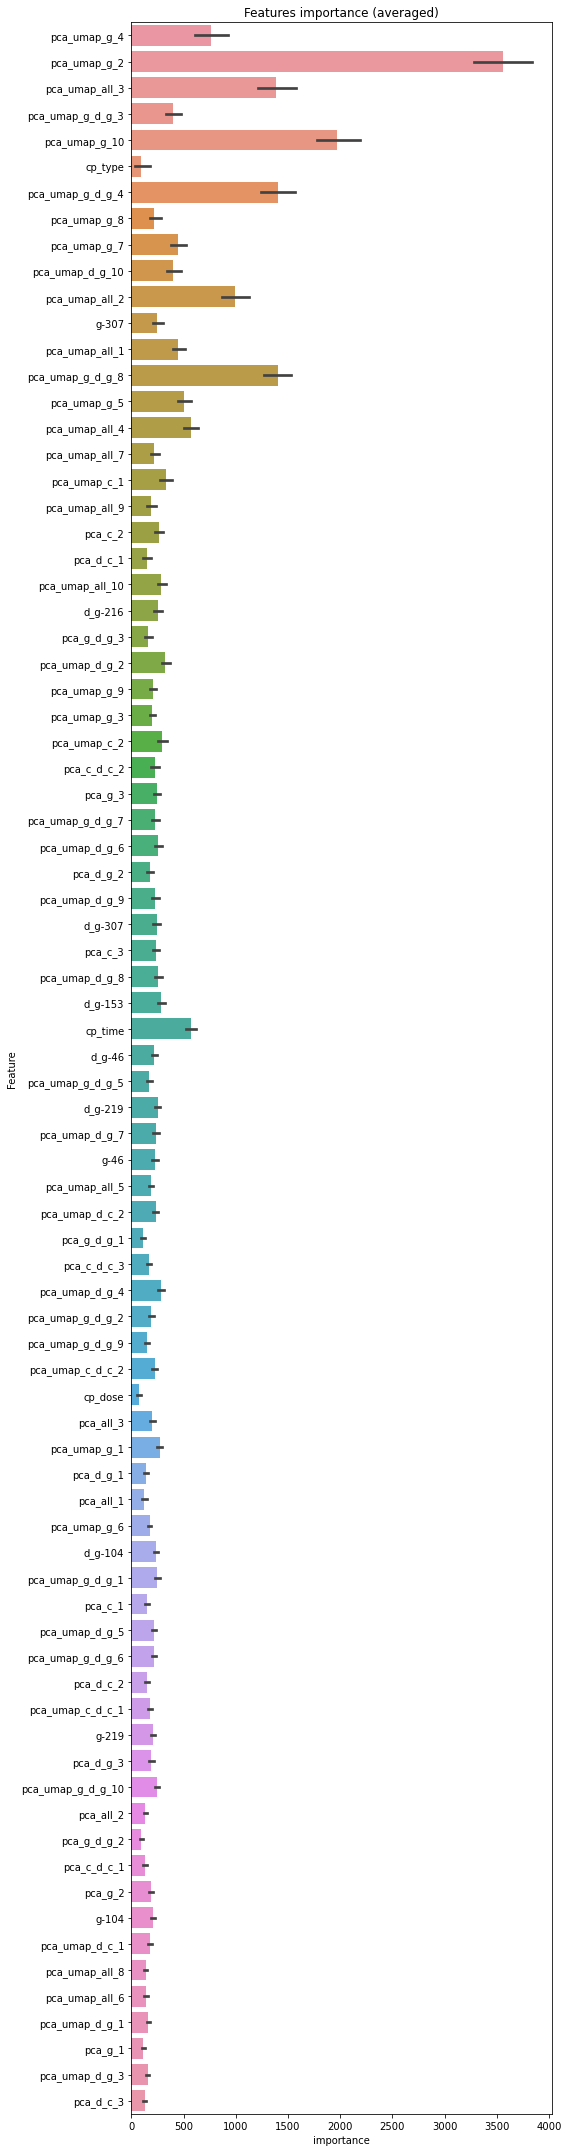

In [49]:
show_feature_importance(feature_importance_df)

In [50]:
feature_importance_df.to_csv(f'feature_importance_df.{Version}.csv', index=False)